$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 1: Sequence Models
<a id=part1></a>

In this part we will learn about working with text sequences using recurrent neural networks.
We'll go from a raw text file all the way to a fully trained GRU-RNN model and generate works of art!

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Text generation with a char-level RNN
<a id=part1_1></a>

### Obtaining the corpus
<a id=part1_2></a>

Let's begin by downloading a corpus containing all the works of William Shakespeare.
Since he was very prolific, this corpus is fairly large and will provide us with enough data for
obtaining impressive results.

In [3]:
CORPUS_URL = 'https://github.com/cedricdeboom/character-level-rnn-datasets/raw/master/datasets/shakespeare.txt'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_corpus(out_path=DATA_DIR, url=CORPUS_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))
    
    if os.path.isfile(out_filename) and not force:
        print(f'Corpus file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename
    
corpus_path = download_corpus()

Corpus file /home/dana.gershon/.pytorch-datasets/shakespeare.txt exists, skipping download.


Load the text into memory and print a snippet:

In [4]:
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f'Corpus length: {len(corpus)} chars')
print(corpus[7:1234])

Corpus length: 6347703 chars
ALLS WELL THAT ENDS WELL

by William Shakespeare

Dramatis Personae

  KING OF FRANCE
  THE DUKE OF FLORENCE
  BERTRAM, Count of Rousillon
  LAFEU, an old lord
  PAROLLES, a follower of Bertram
  TWO FRENCH LORDS, serving with Bertram

  STEWARD, Servant to the Countess of Rousillon
  LAVACHE, a clown and Servant to the Countess of Rousillon
  A PAGE, Servant to the Countess of Rousillon

  COUNTESS OF ROUSILLON, mother to Bertram
  HELENA, a gentlewoman protected by the Countess
  A WIDOW OF FLORENCE.
  DIANA, daughter to the Widow

  VIOLENTA, neighbour and friend to the Widow
  MARIANA, neighbour and friend to the Widow

  Lords, Officers, Soldiers, etc., French and Florentine  

SCENE:
Rousillon; Paris; Florence; Marseilles

ACT I. SCENE 1.
Rousillon. The COUNT'S palace

Enter BERTRAM, the COUNTESS OF ROUSILLON, HELENA, and LAFEU, all in black

  COUNTESS. In delivering my son from me, I bury a second husband.
  BERTRAM. And I in going, madam, weep o'er

### Data Preprocessing
<a id=part1_3></a>

The first thing we'll need is to map from each unique character in the corpus to an index that will represent it in our learning process.

**TODO**: Implement the `char_maps()` function in the `hw3/charnn.py` module.

In [5]:
import hw3.charnn as charnn

char_to_idx, idx_to_char = charnn.char_maps(corpus)
print(char_to_idx)

test.assertEqual(len(char_to_idx), len(idx_to_char))
test.assertSequenceEqual(list(char_to_idx.keys()), list(idx_to_char.values()))
test.assertSequenceEqual(list(char_to_idx.values()), list(idx_to_char.keys()))

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '_': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '}': 81, '\ufeff': 82}


Seems we have some strange characters in the corpus that are very rare and are probably due to mistakes.
To reduce the length of each tensor we'll need to later represent our chars, it's best to remove them.

**TODO**: Implement the `remove_chars()` function in the `hw3/charnn.py` module.

In [6]:
corpus, n_removed = charnn.remove_chars(corpus, ['}','$','_','<','\ufeff'])
print(f'Removed {n_removed} chars')

# After removing the chars, re-create the mappings
char_to_idx, idx_to_char = charnn.char_maps(corpus)

Removed 34 chars


The next thing we need is an **embedding** of the chracters.
An embedding is a representation of each token from the sequence as a tensor.
For a char-level RNN, our tokens will be chars and we can thus use the simplest possible embedding: encode each char as a **one-hot** tensor. In other words, each char will be represented
as a tensor whos length is the total number of unique chars (`V`) which contains all zeros except at the index
corresponding to that specific char.

**TODO**: Implement the functions `chars_to_onehot()` and `onehot_to_chars()` in the `hw3/charnn.py` module.

In [7]:
# Wrap the actual embedding functions for calling convenience
def embed(text):
    return charnn.chars_to_onehot(text, char_to_idx)

def unembed(embedding):
    return charnn.onehot_to_chars(embedding, idx_to_char)

text_snippet = corpus[3104:3148]
print(text_snippet)
print(embed(text_snippet[0:3]))

test.assertEqual(text_snippet, unembed(embed(text_snippet)))
test.assertEqual(embed(text_snippet).dtype, torch.int8)

brine a maiden can season her praise in.
   
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=torch.int8)


### Dataset Creation
<a id=part1_4></a>

We wish to train our model to generate text by constantly predicting what the next char should be based on the past.
To that end we'll need to train our recurrent network in a way similar to a classification task. At each timestep, we input a char and set the expected output (label) to be the next char in the original sequence.

We will split our corpus into shorter sequences of length `S` chars (see question below).
Each **sample** we provide our model with will therefore be a tensor of shape `(S,V)` where `V` is the embedding dimension. Our model will operate sequentially on each char in the sequence.
For each sample, we'll also need a **label**. This is simply another sequence, shifted by one char so that the label of each char is the next char in the corpus.

**TODO**: Implement the `chars_to_labelled_samples()` function in the `hw3/charnn.py` module.

In [8]:
# Create dataset of sequences
seq_len = 64
vocab_len = len(char_to_idx)

# Create labelled samples
samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)
print(f'samples shape: {samples.shape}')
print(f'labels shape: {labels.shape}')

# Test shapes
num_samples = (len(corpus) - 1) // seq_len
test.assertEqual(samples.shape, (num_samples, seq_len, vocab_len))
test.assertEqual(labels.shape, (num_samples, seq_len))

# Test content
for _ in range(1000):
    # random sample
    i = np.random.randint(num_samples, size=(1,))[0]
    # Compare to corpus
    test.assertEqual(unembed(samples[i]), corpus[i*seq_len:(i+1)*seq_len], msg=f"content mismatch in sample {i}")
    # Compare to labels
    sample_text = unembed(samples[i])
    label_text = str.join('', [idx_to_char[j.item()] for j in labels[i]])
    test.assertEqual(sample_text[1:], label_text[0:-1], msg=f"label mismatch in sample {i}")

samples shape: torch.Size([99182, 64, 78])
labels shape: torch.Size([99182, 64])


Let's print a few consecutive samples. You should see that the text continues between them.

In [9]:
import re
import random

i = random.randrange(num_samples-5)
for i in range(i, i+5):
    test.assertEqual(len(samples[i]), seq_len)
    s = re.sub(r'\s+', ' ', unembed(samples[i])).strip()
    print(f'sample [{i}]:\n\t{s}')

sample [83392]:
	have broke their sleep, To take the one the other, by some chanc
sample [83393]:
	e, Some trick not worth an egg, shall grow dear friends And inte
sample [83394]:
	rjoin their issues. So with me: My birth-place hate I, and my lo
sample [83395]:
	ve's upon This enemy town. I'll enter: if he slay me, He does fa
sample [83396]:
	ir justice; if he give me way, I'll do his country service. Fir


As usual, instead of feeding one sample at a time into our model's forward we'll work with **batches** of samples. This means that at every timestep, our model will operate on a batch of chars that are from **different sequences**.
Effectively this will allow us to parallelize training our model by dong matrix-matrix multiplications
instead of matrix-vector during the forward pass.

An important nuance is that we need the batches to be **contiguous**, i.e. sample $k$ in batch $j$ should continue sample $k$ from batch $j-1$.
The following figure illustrates this:

<img src="imgs/rnn-batching.png"/>

If we naïvely take consecutive samples into batches, e.g. `[0,1,...,B-1]`, `[B,B+1,...,2B-1]` and so on, we won't have contiguous
sequences at the same index between adjacent batches.

To accomplish this we need to tell our `DataLoader` which samples to combine together into one batch.
We do this by implementing a custom PyTorch `Sampler`, and providing it to our `DataLoader`.

**TODO**: Implement the `SequenceBatchSampler` class in the `hw3/charnn.py` module.

In [10]:
from hw3.charnn import SequenceBatchSampler

sampler = SequenceBatchSampler(dataset=range(32), batch_size=10)
sampler_idx = list(sampler)
print('sampler_idx =\n', sampler_idx)

# Test the Sampler
test.assertEqual(len(sampler_idx), 30)
batch_idx = np.array(sampler_idx).reshape(-1, 10)
for k in range(10):
    test.assertEqual(np.diff(batch_idx[:, k], n=2).item(), 0)

sampler_idx =
 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29]


Even though we're working with sequences, we can still use the standard PyTorch `Dataset`/`DataLoader` combo.
For the dataset we can use a built-in class, `TensorDataset` to return tuples of `(sample, label)`
from the `samples` and `labels` tensors we created above.
The `DataLoader` will be provided with our custom `Sampler` so that it generates appropriate batches.

In [11]:
import torch.utils.data

# Create DataLoader returning batches of samples.
batch_size = 32

ds_corpus = torch.utils.data.TensorDataset(samples, labels)
sampler_corpus = SequenceBatchSampler(ds_corpus, batch_size)
dl_corpus = torch.utils.data.DataLoader(ds_corpus, batch_size=batch_size, sampler=sampler_corpus, shuffle=False)

Let's see what that gives us:

In [12]:
print(f'num batches: {len(dl_corpus)}')

x0, y0 = next(iter(dl_corpus))
print(f'shape of a batch of samples: {x0.shape}')
print(f'shape of a batch of labels: {y0.shape}')

num batches: 3100
shape of a batch of samples: torch.Size([32, 64, 78])
shape of a batch of labels: torch.Size([32, 64])


Now lets look at the same sample index from multiple batches taken from our corpus.

In [13]:
# Check that sentences in in same index of different batches complete each other.
k = random.randrange(batch_size)
for j, (X, y) in enumerate(dl_corpus,):
    print(f'=== batch {j}, sample {k} ({X[k].shape}): ===')
    s = re.sub(r'\s+', ' ', unembed(X[k])).strip()
    print(f'\t{s}')
    if j==4: break

=== batch 0, sample 2 (torch.Size([64, 78])): ===
	do not scorn me; do not, Phebe. Say that you love me not; bu
=== batch 1, sample 2 (torch.Size([64, 78])): ===
	t say not so In bitterness. The common executioner, Whos
=== batch 2, sample 2 (torch.Size([64, 78])): ===
	e heart th' accustom'd sight of death makes hard, Falls not
=== batch 3, sample 2 (torch.Size([64, 78])): ===
	the axe upon the humbled neck But first begs pardon. Will yo
=== batch 4, sample 2 (torch.Size([64, 78])): ===
	u sterner be Than he that dies and lives by bloody drops?


### Model Implementation
<a id=part1_5></a>

Finally, our data set is ready so we can focus on our model.

We'll implement here is a multilayer gated recurrent unit (GRU) model, with dropout.
This model is a type of RNN which performs similar to the well-known LSTM model,
but it's somewhat easier to train because it has less parameters.
We'll modify the regular GRU slightly by applying dropout to
the hidden states passed between layers of the model.

The model accepts an input $\mat{X}\in\set{R}^{S\times V}$ containing a sequence of embedded chars.
It returns an output $\mat{Y}\in\set{R}^{S\times V}$ of predictions for the next char and the final hidden state
$\mat{H}\in\set{R}^{L\times H}$. Here $S$ is the sequence length, $V$ is the vocabulary size (number of unique chars), $L$ is the number of layers in the model and $H$ is the hidden dimension.

Mathematically, the model's forward function at layer $k\in[1,L]$ and timestep $t\in[1,S]$ can be described as

$$
\begin{align}
\vec{z_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xz}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hz}}}^{[k]} + \vec{b}_{\mathrm{z}}^{[k]}\right) \\
\vec{r_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xr}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hr}}}^{[k]} + \vec{b}_{\mathrm{r}}^{[k]}\right) \\
\vec{g_t}^{[k]} &= \tanh\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xg}}}^{[k]} +
    (\vec{r_t}^{[k]}\odot\vec{h}_{t-1}^{[k]}) {\mattr{W}_{\mathrm{hg}}}^{[k]} + \vec{b}_{\mathrm{g}}^{[k]}\right) \\
\vec{h_t}^{[k]} &= \vec{z}^{[k]}_t \odot \vec{h}^{[k]}_{t-1} + \left(1-\vec{z}^{[k]}_t\right)\odot \vec{g_t}^{[k]}
\end{align}
$$

The input to each layer is,
$$
\mat{X}^{[k]} =
\begin{bmatrix}
    {\vec{x}_1}^{[k]} \\ \vdots \\ {\vec{x}_S}^{[k]}
\end{bmatrix} 
=
\begin{cases}
    \mat{X} & \mathrm{if} ~k = 1~ \\
    \mathrm{dropout}_p \left(
    \begin{bmatrix}
        {\vec{h}_1}^{[k-1]} \\ \vdots \\ {\vec{h}_S}^{[k-1]}
    \end{bmatrix} \right) & \mathrm{if} ~1 < k \leq L+1~
\end{cases}.
$$

The output of the entire model is then,
$$
\mat{Y} = \mat{X}^{[L+1]} {\mattr{W}_{\mathrm{hy}}} + \mat{B}_{\mathrm{y}}
$$

and the final hidden state is
$$
\mat{H} = 
\begin{bmatrix}
    {\vec{h}_S}^{[1]} \\ \vdots \\ {\vec{h}_S}^{[L]}
\end{bmatrix}.
$$

Notes:
- $t\in[1,S]$ is the timestep, i.e. the current position within the sequence of each sample.
- $\vec{x}_t^{[k]}$ is the input of layer $k$ at timestep $t$, respectively.
- The outputs of the **last layer** $\vec{y}_t^{[L]}$, are the predicted next characters for every input char.
  These are similar to class scores in classification tasks.
- The hidden states at the **last timestep**, $\vec{h}_S^{[k]}$, are the final hidden state returned from the model.
- $\sigma(\cdot)$ is the sigmoid function, i.e. $\sigma(\vec{z}) = 1/(1+e^{-\vec{z}})$ which returns values in $(0,1)$.
- $\tanh(\cdot)$ is the hyperbolic tangent, i.e. $\tanh(\vec{z}) = (e^{2\vec{z}}-1)/(e^{2\vec{z}}+1)$ which returns values in $(-1,1)$.
- $\vec{h_t}^{[k]}$ is the hidden state of layer $k$ at time $t$. This can be thought of as the memory of that layer.
- $\vec{g_t}^{[k]}$ is the candidate hidden state for time $t+1$.
- $\vec{z_t}^{[k]}$ is known as the update gate. It combines the previous state with the input to determine how much the current state will be combined with the new candidate state. For example, if $\vec{z_t}^{[k]}=\vec{1}$ then the current input has no effect on the output.
- $\vec{r_t}^{[k]}$ is known as the reset gate. It combines the previous state with the input to determine how much of the previous state will affect the current state candidate. For example if $\vec{r_t}^{[k]}=\vec{0}$ the previous state has no effect on the current candidate state.

Here's a graphical representation of the GRU's forward pass at each timestep. The $\vec{\tilde{h}}$ in the image is our $\vec{g}$ (candidate next state).

<img src="imgs/gru_cell.png" width="400"/>

You can see how the reset and update gates allow the model to completely ignore it's previous state, completely ignore it's input, or any mixture of those states (since the gates are actually continuous and between $(0,1)$).

Here's a graphical representation of the entire model.
You can ignore the $c_t^{[k]}$ (cell state) variables (which are relevant for LSTM models).
Our model has only the hidden state, $h_t^{[k]}$. Also notice that we added dropout between layers (i.e., on the up arrows).

<img src="imgs/lstm_model.png" />

The purple tensors are inputs (a sequence and initial hidden state per layer), and the green tensors are outputs (another sequence and final hidden state per layer). Each blue block implements the above forward equations.
Blocks that are on the same vertical level are at the same layer, and therefore share parameters.

**TODO**:implement `MultilayerGRU` class in the `hw3/charnn.py` module.


Notes:
- We use **batches** now.
  The math is identical to the above, but all the tensors will have an extra batch 
  dimension as their first dimension.
- Before you read the implementation, read the diagram above, try to understand all the dimentions.


In [14]:
in_dim = vocab_len
h_dim = 256
n_layers = 3
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers)
model = model.to(device)
print(model)

# Test forward pass
y, h = model(x0.to(dtype=torch.float, device=device))
print(f'y.shape={y.shape}')
print(f'h.shape={h.shape}')

test.assertEqual(y.shape, (batch_size, seq_len, vocab_len))
test.assertEqual(h.shape, (batch_size, n_layers, h_dim))
test.assertEqual(len(list(model.parameters())), 9 * n_layers + 2) 

MultilayerGRU(
  (dropout_layer): Dropout(p=0, inplace=False)
  (layer_0_xz): Linear(in_features=78, out_features=256, bias=True)
  (layer_0_hz): Linear(in_features=256, out_features=256, bias=False)
  (layer_0_xr): Linear(in_features=78, out_features=256, bias=True)
  (layer_0_hr): Linear(in_features=256, out_features=256, bias=False)
  (layer_0_xg): Linear(in_features=78, out_features=256, bias=True)
  (layer_0_hg): Linear(in_features=256, out_features=256, bias=False)
  (layer_1_xz): Linear(in_features=256, out_features=256, bias=True)
  (layer_1_hz): Linear(in_features=256, out_features=256, bias=False)
  (layer_1_xr): Linear(in_features=256, out_features=256, bias=True)
  (layer_1_hr): Linear(in_features=256, out_features=256, bias=False)
  (layer_1_xg): Linear(in_features=256, out_features=256, bias=True)
  (layer_1_hg): Linear(in_features=256, out_features=256, bias=False)
  (layer_2_xz): Linear(in_features=256, out_features=256, bias=True)
  (layer_2_hz): Linear(in_features=256

y.shape=torch.Size([32, 64, 78])
h.shape=torch.Size([32, 3, 256])


### Generating text by sampling
<a id=part1_6></a>

Now that we have a model, we can implement **text generation** based on it.
The idea is simple:
At each timestep our model receives one char $x_t$ from the input sequence and outputs scores $y_t$
for what the next char should be.
We'll convert these scores into a probability over each of the possible chars.
In other words, for each input char $x_t$ we create a probability distribution for the next char
conditioned on the current one and the state of the model (representing all previous inputs):
$$p(x_{t+1}|x_t, \vec{h}_t).$$

Once we have such a distribution, we'll sample a char from it.
This will be the first char of our generated sequence.
Now we can feed this new char into the model, create another distribution, sample the next char and so on.
Note that it's crucial to propagate the hidden state when sampling.

The important point however is how to create the distribution from the scores.
One way, as we saw in previous ML tasks, is to use the softmax function.
However, a drawback of softmax is that it can generate very diffuse (more uniform) distributions if the score values are very similar. When sampling, we would prefer to control the distributions and make them less uniform to increase the chance of sampling the char(s) with the highest scores compared to the others.

To control the variance of the distribution, a common trick is to add a hyperparameter $T$, known as the 
*temperature* to the softmax function. The class scores are simply scaled by $T$ before softmax is applied:
$$
\mathrm{softmax}_T(\vec{y}) = \frac{e^{\vec{y}/T}}{\sum_k e^{y_k/T}}
$$

A low $T$ will result in less uniform distributions and vice-versa.

**TODO**: Implement the `hot_softmax()` function in the `hw3/charnn.py` module.

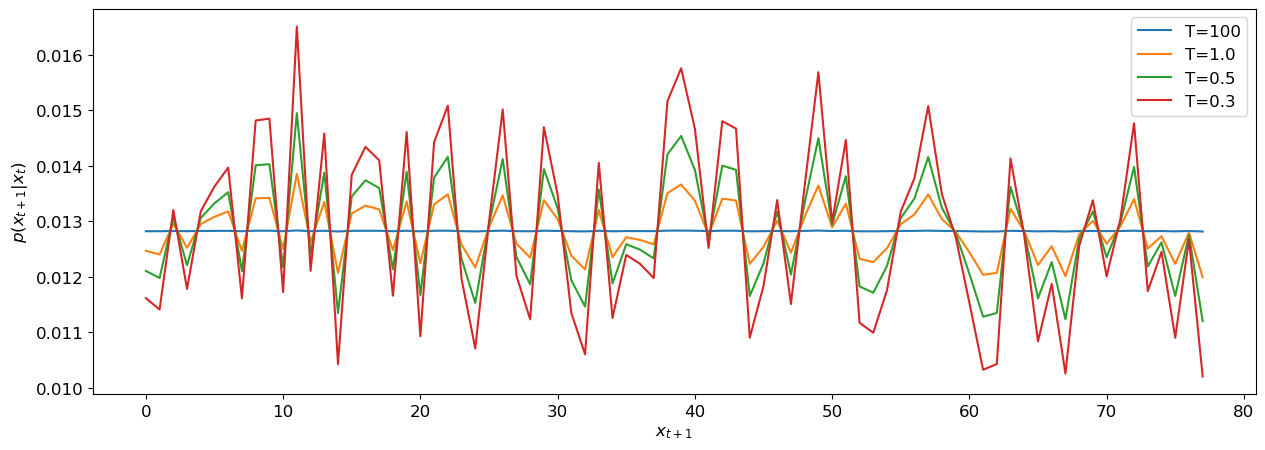

In [15]:
scores = y[0,0,:].detach()
_, ax = plt.subplots(figsize=(15,5))

for t in reversed([0.3, 0.5, 1.0, 100]):
    ax.plot(charnn.hot_softmax(scores, temperature=t).cpu().numpy(), label=f'T={t}')
ax.set_xlabel('$x_{t+1}$')
ax.set_ylabel('$p(x_{t+1}|x_t)$')
ax.legend()

uniform_proba = 1/len(char_to_idx)
uniform_diff = torch.abs(charnn.hot_softmax(scores, temperature=100) - uniform_proba)
test.assertTrue(torch.all(uniform_diff < 1e-4))

**TODO**: Implement the `generate_from_model()` function in the `hw3/charnn.py` module.

In [16]:
for _ in range(3):
    text = charnn.generate_from_model(model, "foobar", 50, (char_to_idx, idx_to_char), T=0.5)
    print(text)
    test.assertEqual(len(text), 50)

foobar5inqM.B;&.SRrSV9yMo;PAnhdFet)fw2alTYktD4w"n 
foobar]b;VRQ8!0uxscU7Fy2QD214C;oQuJ:
d,rPtc-2B-Y[]
foobartG:"v2iicH.&9I2n]&npb(,4 ym[Mzy(u-C]NZD8geop


### Training
<a id=part1_7></a>

To train this model, we'll calculate the loss at each time step by comparing the predicted char to
the actual char from our label. We can use cross entropy since per char it's similar to a classification problem.
We'll then sum the losses over the sequence and back-propagate the gradients though time.
Notice that the back-propagation algorithm will "visit" each layer's parameter tensors multiple times,
so we'll accumulate gradients in parameters of the blocks. Luckily `autograd` will handle this part for us.

As usual, the first step of training will be to try and **overfit** a large model (many parameters) to a tiny dataset.
Again, this is to ensure the model and training code are implemented correctly, i.e. that the model can learn.

For a generative model such as this, overfitting is slightly trickier than for classification.
What we'll aim to do is to get our model to **memorize** a specific sequence of chars, so that when given the first
char in the sequence it will immediately spit out the rest of the sequence verbatim.

Let's create a tiny dataset to memorize.

In [17]:
# Pick a tiny subset of the dataset
subset_start, subset_end = 1001, 1005
ds_corpus_ss = torch.utils.data.Subset(ds_corpus, range(subset_start, subset_end))
batch_size_ss = 1
sampler_ss = SequenceBatchSampler(ds_corpus_ss, batch_size=batch_size_ss)
dl_corpus_ss = torch.utils.data.DataLoader(ds_corpus_ss, batch_size_ss, sampler=sampler_ss, shuffle=False)

# Convert subset to text
subset_text = ''
for i in range(subset_end - subset_start):
    subset_text += unembed(ds_corpus_ss[i][0])
print(f'Text to "memorize":\n\n{subset_text}')

Text to "memorize":

TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


Now let's implement the first part of our training code.

**TODO**: Implement the `train_epoch()` and `train_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module. 
You must think about how to correctly handle the hidden state of the model between batches and epochs for this specific task (i.e. text generation).

In [18]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import RNNTrainer

torch.manual_seed(42)

lr = 0.01
num_epochs = 500

in_dim = vocab_len
h_dim = 128
n_layers = 2
loss_fn = nn.CrossEntropyLoss()
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

for epoch in range(num_epochs):
    epoch_result = trainer.train_epoch(dl_corpus_ss, verbose=False)
    
    # Every X epochs, we'll generate a sequence starting from the first char in the first sequence
    # to visualize how/if/what the model is learning.
    if epoch == 0 or (epoch+1) % 25 == 0:
        avg_loss = np.mean(epoch_result.losses)
        accuracy = np.mean(epoch_result.accuracy)
        print(f'\nEpoch #{epoch+1}: Avg. loss = {avg_loss:.3f}, Accuracy = {accuracy:.2f}%')
        
        generated_sequence = charnn.generate_from_model(model, subset_text[0],
                                                        seq_len*(subset_end-subset_start),
                                                        (char_to_idx,idx_to_char), T=0.1)
        
        # Stop if we've successfully memorized the small dataset.
        print(generated_sequence)
        if generated_sequence == subset_text:
            break

# Test successful overfitting
test.assertGreater(epoch_result.accuracy, 99)
test.assertEqual(generated_sequence, subset_text)


Epoch #1: Avg. loss = 3.937, Accuracy = 17.97%


Ttn                         t            t     t  n t                       t    t         t                                   t       t    tt           t       t                             t    t                          t           t          t         



Epoch #25: Avg. loss = 1.172, Accuracy = 69.53%


TAAM. What would you tell you tell you that yould you tell you tela do tould you tela do tould you tell you teld not tould you tel; not yould you tela do tould you tell you tell you tell you tell you tele so tuld not tell you tell you thande not yould you 



Epoch #50: Avg. loss = 0.029, Accuracy = 100.00%


TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


OK, so training works - we can memorize a short sequence.
We'll now train a much larger model on our large dataset. You'll need a GPU for this part.

First, lets set up our dataset and models for training.
We'll split our corpus into 90% train and 10% test-set.
Also, we'll use a learning-rate scheduler to control the learning rate during training.

**TODO**: Set the hyperparameters in the `part1_rnn_hyperparams()` function of the `hw3/answers.py` module.

In [19]:
from hw3.answers import part1_rnn_hyperparams

hp = part1_rnn_hyperparams()
print('hyperparams:\n', hp)

### Dataset definition
vocab_len = len(char_to_idx)
batch_size = hp['batch_size']
seq_len = hp['seq_len']
train_test_ratio = 0.9
num_samples = (len(corpus) - 1) // seq_len
num_train = int(train_test_ratio * num_samples)

samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)

ds_train = torch.utils.data.TensorDataset(samples[:num_train], labels[:num_train])
sampler_train = SequenceBatchSampler(ds_train, batch_size)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False, sampler=sampler_train, drop_last=True)

ds_test = torch.utils.data.TensorDataset(samples[num_train:], labels[num_train:])
sampler_test = SequenceBatchSampler(ds_test, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, sampler=sampler_test, drop_last=True)

print(f'Train: {len(dl_train):3d} batches, {len(dl_train)*batch_size*seq_len:7d} chars')
print(f'Test:  {len(dl_test):3d} batches, {len(dl_test)*batch_size*seq_len:7d} chars')

### Training definition
in_dim = out_dim = vocab_len
checkpoint_file = 'checkpoints/rnn'
num_epochs = 50
early_stopping = 5

model = charnn.MultilayerGRU(in_dim, hp['h_dim'], out_dim, hp['n_layers'], hp['dropout'])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hp['learn_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=hp['lr_sched_factor'], patience=hp['lr_sched_patience'], verbose=True
)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

hyperparams:
 {'batch_size': 512, 'seq_len': 64, 'h_dim': 128, 'n_layers': 2, 'dropout': 0.3, 'learn_rate': 0.002, 'lr_sched_factor': 0.1, 'lr_sched_patience': 3}


Train: 174 batches, 5701632 chars
Test:   19 batches,  622592 chars


The code blocks below will train the model and save checkpoints containing the training state and the best model parameters to a file. This allows you to stop training and resume it later from where you left.

Note that you can use the `main.py` script provided within the assignment folder to run this notebook from the command line as if it were a python script by using the `run-nb` subcommand. This allows you to train your model using this notebook without starting jupyter. You can combine this with `srun` or `sbatch` to run the notebook with a GPU on the course servers.

**TODO**:
- Implement the `fit()` method of the `Trainer` class. You can reuse the relevant implementation parts from HW2, but make sure to implement early stopping and checkpoints.
- Implement the `test_epoch()` and `test_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module.
- Run the following block to train.
- When training is done and you're satisfied with the model's outputs, rename the checkpoint file to `checkpoints/rnn_final.pt`.
  This will cause the block to skip training and instead load your saved model when running the homework submission script.
  Note that your submission zip file will not include the checkpoint file. This is OK.

ACT I.xgqb[nwv.EfEQvPeoTxX,.l Mv50AWXFvZkBs58g"ppONEOs2co-&l4E1i:0bBzbH;aMJj;b qBp;x3n-YT."&Xxzh
C)s
--- EPOCH 1/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (4.393):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (4.393):   1%|          | 1/174 [00:00<00:53,  3.26it/s]

train_batch (4.331):   1%|          | 1/174 [00:00<00:53,  3.26it/s]

train_batch (4.331):   1%|          | 2/174 [00:00<00:42,  4.03it/s]

train_batch (4.264):   1%|          | 2/174 [00:00<00:42,  4.03it/s]

train_batch (4.264):   2%|▏         | 3/174 [00:00<00:39,  4.38it/s]

train_batch (4.180):   2%|▏         | 3/174 [00:00<00:39,  4.38it/s]

train_batch (4.180):   2%|▏         | 4/174 [00:00<00:37,  4.56it/s]

train_batch (4.046):   2%|▏         | 4/174 [00:01<00:37,  4.56it/s]

train_batch (4.046):   3%|▎         | 5/174 [00:01<00:36,  4.65it/s]

train_batch (3.837):   3%|▎         | 5/174 [00:01<00:36,  4.65it/s]

train_batch (3.837):   3%|▎         | 6/174 [00:01<00:35,  4.72it/s]

train_batch (3.561):   3%|▎         | 6/174 [00:01<00:35,  4.72it/s]

train_batch (3.561):   4%|▍         | 7/174 [00:01<00:35,  4.77it/s]

train_batch (3.424):   4%|▍         | 7/174 [00:01<00:35,  4.77it/s]

train_batch (3.424):   5%|▍         | 8/174 [00:01<00:34,  4.81it/s]

train_batch (3.424):   5%|▍         | 8/174 [00:01<00:34,  4.81it/s]

train_batch (3.424):   5%|▌         | 9/174 [00:01<00:34,  4.82it/s]

train_batch (3.422):   5%|▌         | 9/174 [00:02<00:34,  4.82it/s]

train_batch (3.422):   6%|▌         | 10/174 [00:02<00:33,  4.84it/s]

train_batch (3.331):   6%|▌         | 10/174 [00:02<00:33,  4.84it/s]

train_batch (3.331):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (3.294):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (3.294):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (3.303):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (3.303):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (3.299):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (3.299):   8%|▊         | 14/174 [00:02<00:32,  4.85it/s]

train_batch (3.311):   8%|▊         | 14/174 [00:03<00:32,  4.85it/s]

train_batch (3.311):   9%|▊         | 15/174 [00:03<00:32,  4.84it/s]

train_batch (3.293):   9%|▊         | 15/174 [00:03<00:32,  4.84it/s]

train_batch (3.293):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (3.274):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (3.274):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (3.265):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (3.265):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (3.242):  10%|█         | 18/174 [00:04<00:32,  4.85it/s]

train_batch (3.242):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (3.238):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (3.238):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (3.228):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (3.228):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (3.227):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (3.227):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (3.233):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (3.233):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (3.245):  13%|█▎        | 23/174 [00:05<00:31,  4.85it/s]

train_batch (3.245):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (3.237):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (3.237):  14%|█▍        | 25/174 [00:05<00:30,  4.84it/s]

train_batch (3.213):  14%|█▍        | 25/174 [00:05<00:30,  4.84it/s]

train_batch (3.213):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (3.204):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (3.204):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (3.200):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (3.200):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (3.207):  16%|█▌        | 28/174 [00:06<00:30,  4.84it/s]

train_batch (3.207):  17%|█▋        | 29/174 [00:06<00:29,  4.83it/s]

train_batch (3.204):  17%|█▋        | 29/174 [00:06<00:29,  4.83it/s]

train_batch (3.204):  17%|█▋        | 30/174 [00:06<00:29,  4.84it/s]

train_batch (3.197):  17%|█▋        | 30/174 [00:06<00:29,  4.84it/s]

train_batch (3.197):  18%|█▊        | 31/174 [00:06<00:29,  4.84it/s]

train_batch (3.179):  18%|█▊        | 31/174 [00:06<00:29,  4.84it/s]

train_batch (3.179):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (3.194):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (3.194):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (3.190):  19%|█▉        | 33/174 [00:07<00:29,  4.85it/s]

train_batch (3.190):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (3.185):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (3.185):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (3.181):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (3.181):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (3.168):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (3.168):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (3.179):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (3.179):  22%|██▏       | 38/174 [00:07<00:28,  4.86it/s]

train_batch (3.173):  22%|██▏       | 38/174 [00:08<00:28,  4.86it/s]

train_batch (3.173):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (3.163):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (3.163):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (3.164):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (3.164):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (3.144):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (3.144):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (3.148):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (3.148):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (3.151):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (3.151):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (3.138):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (3.138):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (3.137):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (3.137):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (3.122):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (3.122):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (3.137):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (3.137):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (3.138):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (3.138):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (3.145):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (3.145):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (3.120):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (3.120):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (3.130):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (3.130):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (3.095):  30%|██▉       | 52/174 [00:11<00:25,  4.87it/s]

train_batch (3.095):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (3.108):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (3.108):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (3.083):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (3.083):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (3.087):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (3.087):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (3.070):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (3.070):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (3.066):  33%|███▎      | 57/174 [00:12<00:24,  4.85it/s]

train_batch (3.066):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (3.074):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (3.074):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (3.036):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (3.036):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (3.044):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (3.044):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (3.045):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (3.045):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (3.018):  36%|███▌      | 62/174 [00:13<00:23,  4.87it/s]

train_batch (3.018):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (3.014):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (3.014):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (2.986):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (2.986):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (3.000):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (3.000):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (2.988):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (2.988):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (2.978):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (2.978):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (2.951):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (2.951):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (2.953):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (2.953):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (2.921):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (2.921):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (2.920):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (2.920):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (2.907):  41%|████▏     | 72/174 [00:15<00:20,  4.86it/s]

train_batch (2.907):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (2.884):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (2.884):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (2.887):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (2.887):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (2.877):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (2.877):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (2.852):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (2.852):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (2.845):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (2.845):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (2.839):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (2.839):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (2.816):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (2.816):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (2.792):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (2.792):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (2.768):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (2.768):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (2.765):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (2.765):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (2.745):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (2.745):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (2.733):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (2.733):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (2.706):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (2.706):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (2.696):  49%|████▉     | 86/174 [00:18<00:18,  4.86it/s]

train_batch (2.696):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (2.686):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (2.686):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (2.664):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (2.664):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (2.670):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (2.670):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (2.666):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (2.666):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (2.642):  52%|█████▏    | 91/174 [00:19<00:17,  4.86it/s]

train_batch (2.642):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (2.629):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (2.629):  53%|█████▎    | 93/174 [00:19<00:19,  4.23it/s]

train_batch (2.616):  53%|█████▎    | 93/174 [00:19<00:19,  4.23it/s]

train_batch (2.616):  54%|█████▍    | 94/174 [00:19<00:18,  4.41it/s]

train_batch (2.609):  54%|█████▍    | 94/174 [00:19<00:18,  4.41it/s]

train_batch (2.609):  55%|█████▍    | 95/174 [00:19<00:17,  4.54it/s]

train_batch (2.591):  55%|█████▍    | 95/174 [00:19<00:17,  4.54it/s]

train_batch (2.591):  55%|█████▌    | 96/174 [00:19<00:16,  4.63it/s]

train_batch (2.582):  55%|█████▌    | 96/174 [00:20<00:16,  4.63it/s]

train_batch (2.582):  56%|█████▌    | 97/174 [00:20<00:16,  4.70it/s]

train_batch (2.577):  56%|█████▌    | 97/174 [00:20<00:16,  4.70it/s]

train_batch (2.577):  56%|█████▋    | 98/174 [00:20<00:16,  4.74it/s]

train_batch (2.553):  56%|█████▋    | 98/174 [00:20<00:16,  4.74it/s]

train_batch (2.553):  57%|█████▋    | 99/174 [00:20<00:15,  4.77it/s]

train_batch (2.554):  57%|█████▋    | 99/174 [00:20<00:15,  4.77it/s]

train_batch (2.554):  57%|█████▋    | 100/174 [00:20<00:15,  4.80it/s]

train_batch (2.546):  57%|█████▋    | 100/174 [00:20<00:15,  4.80it/s]

train_batch (2.546):  58%|█████▊    | 101/174 [00:20<00:15,  4.81it/s]

train_batch (2.514):  58%|█████▊    | 101/174 [00:21<00:15,  4.81it/s]

train_batch (2.514):  59%|█████▊    | 102/174 [00:21<00:14,  4.82it/s]

train_batch (2.516):  59%|█████▊    | 102/174 [00:21<00:14,  4.82it/s]

train_batch (2.516):  59%|█████▉    | 103/174 [00:21<00:14,  4.82it/s]

train_batch (2.498):  59%|█████▉    | 103/174 [00:21<00:14,  4.82it/s]

train_batch (2.498):  60%|█████▉    | 104/174 [00:21<00:14,  4.83it/s]

train_batch (2.496):  60%|█████▉    | 104/174 [00:21<00:14,  4.83it/s]

train_batch (2.496):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (2.481):  60%|██████    | 105/174 [00:22<00:14,  4.85it/s]

train_batch (2.481):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (2.479):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (2.479):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (2.477):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (2.477):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (2.478):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (2.478):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (2.453):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (2.453):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (2.455):  63%|██████▎   | 110/174 [00:23<00:13,  4.85it/s]

train_batch (2.455):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (2.464):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (2.464):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (2.451):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (2.451):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (2.440):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (2.440):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (2.443):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (2.443):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (2.423):  66%|██████▌   | 115/174 [00:24<00:12,  4.86it/s]

train_batch (2.423):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (2.419):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (2.419):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (2.397):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (2.397):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (2.401):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (2.401):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (2.385):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (2.385):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (2.397):  69%|██████▉   | 120/174 [00:25<00:11,  4.86it/s]

train_batch (2.397):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (2.398):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (2.398):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (2.380):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (2.380):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (2.345):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (2.345):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (2.380):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (2.380):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (2.370):  72%|███████▏  | 125/174 [00:26<00:10,  4.86it/s]

train_batch (2.370):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (2.348):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (2.348):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (2.338):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (2.338):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (2.338):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (2.338):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (2.340):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (2.340):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (2.332):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (2.332):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (2.329):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (2.329):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (2.308):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (2.308):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (2.316):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (2.316):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (2.304):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (2.304):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (2.306):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (2.306):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (2.294):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (2.294):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (2.303):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (2.303):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (2.293):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (2.293):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (2.273):  80%|███████▉  | 139/174 [00:29<00:07,  4.86it/s]

train_batch (2.273):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (2.279):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (2.279):  81%|████████  | 141/174 [00:29<00:06,  4.84it/s]

train_batch (2.278):  81%|████████  | 141/174 [00:29<00:06,  4.84it/s]

train_batch (2.278):  82%|████████▏ | 142/174 [00:29<00:06,  4.84it/s]

train_batch (2.270):  82%|████████▏ | 142/174 [00:29<00:06,  4.84it/s]

train_batch (2.270):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (2.252):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (2.252):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (2.264):  83%|████████▎ | 144/174 [00:30<00:06,  4.84it/s]

train_batch (2.264):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (2.274):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (2.274):  84%|████████▍ | 146/174 [00:30<00:05,  4.84it/s]

train_batch (2.258):  84%|████████▍ | 146/174 [00:30<00:05,  4.84it/s]

train_batch (2.258):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (2.244):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (2.244):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (2.269):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (2.269):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (2.269):  86%|████████▌ | 149/174 [00:31<00:05,  4.85it/s]

train_batch (2.269):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (2.241):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (2.241):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (2.249):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (2.249):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (2.235):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (2.235):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (2.229):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (2.229):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (2.230):  89%|████████▊ | 154/174 [00:32<00:04,  4.86it/s]

train_batch (2.230):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (2.232):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (2.232):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (2.219):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (2.219):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (2.230):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (2.230):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (2.204):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (2.204):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (2.228):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (2.228):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (2.215):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (2.215):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (2.224):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (2.224):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (2.202):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (2.202):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (2.184):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (2.184):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (2.211):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (2.211):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (2.200):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (2.200):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (2.169):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (2.169):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (2.169):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (2.169):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (2.183):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (2.183):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (2.187):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (2.187):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (2.183):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (2.183):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (2.161):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (2.161):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (2.181):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (2.181):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (2.185):  99%|█████████▉| 173/174 [00:36<00:00,  4.86it/s]

train_batch (2.185): 100%|██████████| 174/174 [00:36<00:00,  4.85it/s]

train_batch (Avg. Loss 2.767, Accuracy 28.9): 100%|██████████| 174/174 [00:36<00:00,  4.85it/s]

train_batch (Avg. Loss 2.767, Accuracy 28.9): 100%|██████████| 174/174 [00:36<00:00,  4.83it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.391):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.371):   5%|▌         | 1/19 [00:00<00:02,  7.51it/s]

test_batch (2.371):  11%|█         | 2/19 [00:00<00:01, 14.91it/s]

test_batch (2.367):  11%|█         | 2/19 [00:00<00:01, 14.91it/s]

test_batch (2.384):  16%|█▌        | 3/19 [00:00<00:01, 14.91it/s]

test_batch (2.384):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (2.371):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (2.373):  26%|██▋       | 5/19 [00:00<00:00, 14.72it/s]

test_batch (2.373):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (2.368):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (2.371):  37%|███▋      | 7/19 [00:00<00:00, 14.68it/s]

test_batch (2.371):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (2.369):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (2.378):  47%|████▋     | 9/19 [00:00<00:00, 14.69it/s]

test_batch (2.378):  53%|█████▎    | 10/19 [00:00<00:00, 14.68it/s]

test_batch (2.369):  53%|█████▎    | 10/19 [00:00<00:00, 14.68it/s]

test_batch (2.366):  58%|█████▊    | 11/19 [00:00<00:00, 14.68it/s]

test_batch (2.366):  63%|██████▎   | 12/19 [00:00<00:00, 14.46it/s]

test_batch (2.373):  63%|██████▎   | 12/19 [00:00<00:00, 14.46it/s]

test_batch (2.366):  68%|██████▊   | 13/19 [00:00<00:00, 14.46it/s]

test_batch (2.366):  74%|███████▎  | 14/19 [00:00<00:00, 14.52it/s]

test_batch (2.364):  74%|███████▎  | 14/19 [00:01<00:00, 14.52it/s]

test_batch (2.362):  79%|███████▉  | 15/19 [00:01<00:00, 14.52it/s]

test_batch (2.362):  84%|████████▍ | 16/19 [00:01<00:00, 14.59it/s]

test_batch (2.370):  84%|████████▍ | 16/19 [00:01<00:00, 14.59it/s]

test_batch (2.381):  89%|████████▉ | 17/19 [00:01<00:00, 14.59it/s]

test_batch (2.381):  95%|█████████▍| 18/19 [00:01<00:00, 14.61it/s]

test_batch (2.353):  95%|█████████▍| 18/19 [00:01<00:00, 14.61it/s]

test_batch (Avg. Loss 2.371, Accuracy 32.7): 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]

test_batch (Avg. Loss 2.371, Accuracy 32.7): 100%|██████████| 19/19 [00:01<00:00, 14.60it/s]

ACT I. Whe of ho sor and the herucid of he dorthe tor and pof me for fore the ther hell llat thans m
--- EPOCH 2/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (2.191):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (2.191):   1%|          | 1/174 [00:00<00:36,  4.68it/s]

train_batch (2.185):   1%|          | 1/174 [00:00<00:36,  4.68it/s]

train_batch (2.185):   1%|          | 2/174 [00:00<00:36,  4.75it/s]

train_batch (2.181):   1%|          | 2/174 [00:00<00:36,  4.75it/s]

train_batch (2.181):   2%|▏         | 3/174 [00:00<00:35,  4.79it/s]

train_batch (2.170):   2%|▏         | 3/174 [00:00<00:35,  4.79it/s]

train_batch (2.170):   2%|▏         | 4/174 [00:00<00:35,  4.81it/s]

train_batch (2.164):   2%|▏         | 4/174 [00:01<00:35,  4.81it/s]

train_batch (2.164):   3%|▎         | 5/174 [00:01<00:35,  4.83it/s]

train_batch (2.152):   3%|▎         | 5/174 [00:01<00:35,  4.83it/s]

train_batch (2.152):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (2.146):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (2.146):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (2.162):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (2.162):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (2.146):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (2.146):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (2.157):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (2.157):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (2.156):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (2.156):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (2.151):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (2.151):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (2.161):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (2.161):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (2.148):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (2.148):   8%|▊         | 14/174 [00:02<00:32,  4.85it/s]

train_batch (2.132):   8%|▊         | 14/174 [00:03<00:32,  4.85it/s]

train_batch (2.132):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (2.135):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (2.135):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (2.119):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (2.119):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (2.128):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (2.128):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (2.124):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (2.124):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (2.117):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (2.117):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (2.120):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (2.120):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (2.123):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (2.123):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (2.115):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (2.115):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (2.127):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (2.127):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (2.119):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (2.119):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (2.101):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (2.101):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (2.092):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (2.092):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (2.086):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (2.086):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (2.106):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (2.106):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (2.117):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (2.117):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (2.103):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (2.103):  18%|█▊        | 31/174 [00:06<00:29,  4.84it/s]

train_batch (2.085):  18%|█▊        | 31/174 [00:06<00:29,  4.84it/s]

train_batch (2.085):  18%|█▊        | 32/174 [00:06<00:29,  4.84it/s]

train_batch (2.102):  18%|█▊        | 32/174 [00:06<00:29,  4.84it/s]

train_batch (2.102):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (2.102):  19%|█▉        | 33/174 [00:07<00:29,  4.85it/s]

train_batch (2.102):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (2.116):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (2.116):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (2.101):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (2.101):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (2.093):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (2.093):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (2.096):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (2.096):  22%|██▏       | 38/174 [00:07<00:28,  4.86it/s]

train_batch (2.089):  22%|██▏       | 38/174 [00:08<00:28,  4.86it/s]

train_batch (2.089):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (2.072):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (2.072):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (2.084):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (2.084):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (2.078):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (2.078):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (2.081):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (2.081):  25%|██▍       | 43/174 [00:08<00:27,  4.85it/s]

train_batch (2.082):  25%|██▍       | 43/174 [00:09<00:27,  4.85it/s]

train_batch (2.082):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (2.073):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (2.073):  26%|██▌       | 45/174 [00:09<00:26,  4.85it/s]

train_batch (2.081):  26%|██▌       | 45/174 [00:09<00:26,  4.85it/s]

train_batch (2.081):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (2.068):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (2.068):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (2.072):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (2.072):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (2.076):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (2.076):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (2.089):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (2.089):  29%|██▊       | 50/174 [00:10<00:29,  4.25it/s]

train_batch (2.068):  29%|██▊       | 50/174 [00:10<00:29,  4.25it/s]

train_batch (2.068):  29%|██▉       | 51/174 [00:10<00:27,  4.42it/s]

train_batch (2.076):  29%|██▉       | 51/174 [00:10<00:27,  4.42it/s]

train_batch (2.076):  30%|██▉       | 52/174 [00:10<00:26,  4.55it/s]

train_batch (2.053):  30%|██▉       | 52/174 [00:11<00:26,  4.55it/s]

train_batch (2.053):  30%|███       | 53/174 [00:11<00:26,  4.65it/s]

train_batch (2.073):  30%|███       | 53/174 [00:11<00:26,  4.65it/s]

train_batch (2.073):  31%|███       | 54/174 [00:11<00:25,  4.70it/s]

train_batch (2.057):  31%|███       | 54/174 [00:11<00:25,  4.70it/s]

train_batch (2.057):  32%|███▏      | 55/174 [00:11<00:25,  4.74it/s]

train_batch (2.057):  32%|███▏      | 55/174 [00:11<00:25,  4.74it/s]

train_batch (2.057):  32%|███▏      | 56/174 [00:11<00:24,  4.76it/s]

train_batch (2.047):  32%|███▏      | 56/174 [00:11<00:24,  4.76it/s]

train_batch (2.047):  33%|███▎      | 57/174 [00:11<00:24,  4.78it/s]

train_batch (2.057):  33%|███▎      | 57/174 [00:12<00:24,  4.78it/s]

train_batch (2.057):  33%|███▎      | 58/174 [00:12<00:24,  4.81it/s]

train_batch (2.056):  33%|███▎      | 58/174 [00:12<00:24,  4.81it/s]

train_batch (2.056):  34%|███▍      | 59/174 [00:12<00:23,  4.82it/s]

train_batch (2.028):  34%|███▍      | 59/174 [00:12<00:23,  4.82it/s]

train_batch (2.028):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (2.035):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (2.035):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (2.053):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (2.053):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (2.038):  36%|███▌      | 62/174 [00:13<00:23,  4.85it/s]

train_batch (2.038):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (2.039):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (2.039):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (2.029):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (2.029):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (2.046):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (2.046):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (2.020):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (2.020):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (2.036):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (2.036):  39%|███▉      | 68/174 [00:14<00:21,  4.84it/s]

train_batch (2.036):  39%|███▉      | 68/174 [00:14<00:21,  4.84it/s]

train_batch (2.036):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (2.035):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (2.035):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (2.026):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (2.026):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (2.032):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (2.032):  41%|████▏     | 72/174 [00:14<00:21,  4.86it/s]

train_batch (2.026):  41%|████▏     | 72/174 [00:15<00:21,  4.86it/s]

train_batch (2.026):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (2.013):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (2.013):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (2.032):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (2.032):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (2.043):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (2.043):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (2.021):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (2.021):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (2.030):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (2.030):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (2.032):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (2.032):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (2.018):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (2.018):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (2.018):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (2.018):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.999):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.999):  47%|████▋     | 82/174 [00:16<00:18,  4.86it/s]

train_batch (2.015):  47%|████▋     | 82/174 [00:17<00:18,  4.86it/s]

train_batch (2.015):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (2.016):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (2.016):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (2.014):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (2.014):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (2.000):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (2.000):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.995):  49%|████▉     | 86/174 [00:18<00:18,  4.85it/s]

train_batch (1.995):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.999):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.999):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.987):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.987):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (2.010):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (2.010):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (2.008):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (2.008):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (2.004):  52%|█████▏    | 91/174 [00:19<00:17,  4.86it/s]

train_batch (2.004):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (2.000):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (2.000):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (2.008):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (2.008):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (2.001):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (2.001):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.997):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.997):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (2.000):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (2.000):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.993):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.993):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.986):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.986):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.988):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.988):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.996):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.996):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.973):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.973):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.989):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.989):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.965):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.965):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.972):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.972):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.974):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.974):  61%|██████    | 106/174 [00:21<00:14,  4.83it/s]

train_batch (1.976):  61%|██████    | 106/174 [00:22<00:14,  4.83it/s]

train_batch (1.976):  61%|██████▏   | 107/174 [00:22<00:13,  4.83it/s]

train_batch (1.982):  61%|██████▏   | 107/174 [00:22<00:13,  4.83it/s]

train_batch (1.982):  62%|██████▏   | 108/174 [00:22<00:13,  4.84it/s]

train_batch (1.989):  62%|██████▏   | 108/174 [00:22<00:13,  4.84it/s]

train_batch (1.989):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.963):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.963):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.983):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.983):  64%|██████▍   | 111/174 [00:22<00:13,  4.82it/s]

train_batch (1.976):  64%|██████▍   | 111/174 [00:23<00:13,  4.82it/s]

train_batch (1.976):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.981):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.981):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.972):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.972):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.982):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.982):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.967):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.967):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.972):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.972):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.954):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.954):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.963):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.963):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.958):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.958):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.975):  69%|██████▉   | 120/174 [00:25<00:11,  4.85it/s]

train_batch (1.975):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.980):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.980):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.966):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.966):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.944):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.944):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.971):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.971):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.966):  72%|███████▏  | 125/174 [00:26<00:10,  4.86it/s]

train_batch (1.966):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.958):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.958):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.942):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.942):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.944):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.944):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.965):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.965):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.954):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.954):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.958):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.958):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.951):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.951):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.948):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.948):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.945):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.945):  78%|███████▊  | 135/174 [00:27<00:08,  4.85it/s]

train_batch (1.952):  78%|███████▊  | 135/174 [00:28<00:08,  4.85it/s]

train_batch (1.952):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.940):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.940):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.951):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.951):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.941):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.941):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.928):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.928):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.939):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.939):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.937):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.937):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.929):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.929):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.922):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.922):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.933):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.933):  83%|████████▎ | 145/174 [00:29<00:05,  4.85it/s]

train_batch (1.947):  83%|████████▎ | 145/174 [00:30<00:05,  4.85it/s]

train_batch (1.947):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.930):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.930):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.931):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.931):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.946):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.946):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.952):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.952):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.934):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.934):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.936):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.936):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.925):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.925):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.925):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.925):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.915):  89%|████████▊ | 154/174 [00:32<00:04,  4.86it/s]

train_batch (1.915):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.931):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.931):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.921):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.921):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.929):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.929):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.906):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.906):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.929):  91%|█████████▏| 159/174 [00:33<00:03,  4.87it/s]

train_batch (1.929):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.923):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.923):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.947):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.947):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.907):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.907):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.892):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.892):  94%|█████████▍| 164/174 [00:33<00:02,  4.85it/s]

train_batch (1.931):  94%|█████████▍| 164/174 [00:34<00:02,  4.85it/s]

train_batch (1.931):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.918):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.918):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.898):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.898):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.896):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.896):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.896):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.896):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.916):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.916):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.910):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.910):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.893):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.893):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.915):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.915):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.912):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.912): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 2.018, Accuracy 42.5): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 2.018, Accuracy 42.5): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.076):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (2.042):   5%|▌         | 1/19 [00:00<00:02,  7.47it/s]

test_batch (2.042):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (2.041):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (2.056):  16%|█▌        | 3/19 [00:00<00:01, 14.84it/s]

test_batch (2.056):  21%|██        | 4/19 [00:00<00:01, 14.60it/s]

test_batch (2.042):  21%|██        | 4/19 [00:00<00:01, 14.60it/s]

test_batch (2.047):  26%|██▋       | 5/19 [00:00<00:00, 14.60it/s]

test_batch (2.047):  32%|███▏      | 6/19 [00:00<00:00, 14.61it/s]

test_batch (2.038):  32%|███▏      | 6/19 [00:00<00:00, 14.61it/s]

test_batch (2.038):  37%|███▋      | 7/19 [00:00<00:00, 14.61it/s]

test_batch (2.038):  42%|████▏     | 8/19 [00:00<00:00, 14.59it/s]

test_batch (2.035):  42%|████▏     | 8/19 [00:00<00:00, 14.59it/s]

test_batch (2.058):  47%|████▋     | 9/19 [00:00<00:00, 14.59it/s]

test_batch (2.058):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (2.041):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (2.039):  58%|█████▊    | 11/19 [00:00<00:00, 14.61it/s]

test_batch (2.039):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (2.045):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (2.046):  68%|██████▊   | 13/19 [00:00<00:00, 14.60it/s]

test_batch (2.046):  74%|███████▎  | 14/19 [00:00<00:00, 14.61it/s]

test_batch (2.036):  74%|███████▎  | 14/19 [00:01<00:00, 14.61it/s]

test_batch (2.034):  79%|███████▉  | 15/19 [00:01<00:00, 14.61it/s]

test_batch (2.034):  84%|████████▍ | 16/19 [00:01<00:00, 14.60it/s]

test_batch (2.043):  84%|████████▍ | 16/19 [00:01<00:00, 14.60it/s]

test_batch (2.052):  89%|████████▉ | 17/19 [00:01<00:00, 14.60it/s]

test_batch (2.052):  95%|█████████▍| 18/19 [00:01<00:00, 14.61it/s]

test_batch (2.027):  95%|█████████▍| 18/19 [00:01<00:00, 14.61it/s]

test_batch (Avg. Loss 2.044, Accuracy 40.3): 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]

test_batch (Avg. Loss 2.044, Accuracy 40.3): 100%|██████████| 19/19 [00:01<00:00, 14.60it/s]

ACT I. I love the sore me to me conder that
    Garte the that is the treigh of and the ray and me t
--- EPOCH 3/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.944):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.944):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.920):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.920):   1%|          | 2/174 [00:00<00:35,  4.81it/s]

train_batch (1.917):   1%|          | 2/174 [00:00<00:35,  4.81it/s]

train_batch (1.917):   2%|▏         | 3/174 [00:00<00:35,  4.83it/s]

train_batch (1.918):   2%|▏         | 3/174 [00:00<00:35,  4.83it/s]

train_batch (1.918):   2%|▏         | 4/174 [00:00<00:35,  4.84it/s]

train_batch (1.912):   2%|▏         | 4/174 [00:01<00:35,  4.84it/s]

train_batch (1.912):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.901):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.901):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.899):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.899):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.908):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.908):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.891):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.891):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.907):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.907):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.915):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.915):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.909):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.909):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.925):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.925):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.909):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.909):   8%|▊         | 14/174 [00:02<00:32,  4.85it/s]

train_batch (1.896):   8%|▊         | 14/174 [00:03<00:32,  4.85it/s]

train_batch (1.896):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.897):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.897):   9%|▉         | 16/174 [00:03<00:35,  4.39it/s]

train_batch (1.887):   9%|▉         | 16/174 [00:03<00:35,  4.39it/s]

train_batch (1.887):  10%|▉         | 17/174 [00:03<00:34,  4.52it/s]

train_batch (1.902):  10%|▉         | 17/174 [00:03<00:34,  4.52it/s]

train_batch (1.902):  10%|█         | 18/174 [00:03<00:33,  4.62it/s]

train_batch (1.891):  10%|█         | 18/174 [00:03<00:33,  4.62it/s]

train_batch (1.891):  11%|█         | 19/174 [00:03<00:33,  4.69it/s]

train_batch (1.884):  11%|█         | 19/174 [00:04<00:33,  4.69it/s]

train_batch (1.884):  11%|█▏        | 20/174 [00:04<00:32,  4.75it/s]

train_batch (1.892):  11%|█▏        | 20/174 [00:04<00:32,  4.75it/s]

train_batch (1.892):  12%|█▏        | 21/174 [00:04<00:32,  4.77it/s]

train_batch (1.895):  12%|█▏        | 21/174 [00:04<00:32,  4.77it/s]

train_batch (1.895):  13%|█▎        | 22/174 [00:04<00:31,  4.79it/s]

train_batch (1.881):  13%|█▎        | 22/174 [00:04<00:31,  4.79it/s]

train_batch (1.881):  13%|█▎        | 23/174 [00:04<00:31,  4.82it/s]

train_batch (1.890):  13%|█▎        | 23/174 [00:05<00:31,  4.82it/s]

train_batch (1.890):  14%|█▍        | 24/174 [00:05<00:31,  4.82it/s]

train_batch (1.887):  14%|█▍        | 24/174 [00:05<00:31,  4.82it/s]

train_batch (1.887):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.883):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.883):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.870):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.870):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.859):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.859):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.888):  16%|█▌        | 28/174 [00:06<00:30,  4.86it/s]

train_batch (1.888):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.901):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.901):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.887):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.887):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.869):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.869):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.885):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.885):  19%|█▉        | 33/174 [00:06<00:28,  4.86it/s]

train_batch (1.888):  19%|█▉        | 33/174 [00:07<00:28,  4.86it/s]

train_batch (1.888):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.900):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.900):  20%|██        | 35/174 [00:07<00:28,  4.85it/s]

train_batch (1.885):  20%|██        | 35/174 [00:07<00:28,  4.85it/s]

train_batch (1.885):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.887):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.887):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.890):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.890):  22%|██▏       | 38/174 [00:07<00:28,  4.84it/s]

train_batch (1.879):  22%|██▏       | 38/174 [00:08<00:28,  4.84it/s]

train_batch (1.879):  22%|██▏       | 39/174 [00:08<00:27,  4.84it/s]

train_batch (1.863):  22%|██▏       | 39/174 [00:08<00:27,  4.84it/s]

train_batch (1.863):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.887):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.887):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.869):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.869):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.882):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.882):  25%|██▍       | 43/174 [00:08<00:26,  4.85it/s]

train_batch (1.877):  25%|██▍       | 43/174 [00:09<00:26,  4.85it/s]

train_batch (1.877):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.871):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.871):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.881):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.881):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.869):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.869):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.877):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.877):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.877):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (1.877):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.890):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.890):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.876):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.876):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.882):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.882):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.861):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.861):  30%|███       | 53/174 [00:10<00:24,  4.85it/s]

train_batch (1.880):  30%|███       | 53/174 [00:11<00:24,  4.85it/s]

train_batch (1.880):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.863):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.863):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.861):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.861):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.865):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.865):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.865):  33%|███▎      | 57/174 [00:12<00:24,  4.85it/s]

train_batch (1.865):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.866):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.866):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.848):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.848):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.848):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.848):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.867):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.867):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.852):  36%|███▌      | 62/174 [00:13<00:23,  4.87it/s]

train_batch (1.852):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.855):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.855):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.843):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.843):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.858):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.858):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.834):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.834):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.857):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.857):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.856):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.856):  40%|███▉      | 69/174 [00:14<00:21,  4.80it/s]

train_batch (1.853):  40%|███▉      | 69/174 [00:14<00:21,  4.80it/s]

train_batch (1.853):  40%|████      | 70/174 [00:14<00:21,  4.82it/s]

train_batch (1.843):  40%|████      | 70/174 [00:14<00:21,  4.82it/s]

train_batch (1.843):  41%|████      | 71/174 [00:14<00:21,  4.83it/s]

train_batch (1.848):  41%|████      | 71/174 [00:14<00:21,  4.83it/s]

train_batch (1.848):  41%|████▏     | 72/174 [00:14<00:21,  4.84it/s]

train_batch (1.852):  41%|████▏     | 72/174 [00:15<00:21,  4.84it/s]

train_batch (1.852):  42%|████▏     | 73/174 [00:15<00:20,  4.84it/s]

train_batch (1.847):  42%|████▏     | 73/174 [00:15<00:20,  4.84it/s]

train_batch (1.847):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.855):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.855):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.862):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.862):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.837):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.837):  44%|████▍     | 77/174 [00:15<00:20,  4.85it/s]

train_batch (1.854):  44%|████▍     | 77/174 [00:16<00:20,  4.85it/s]

train_batch (1.854):  45%|████▍     | 78/174 [00:16<00:19,  4.85it/s]

train_batch (1.859):  45%|████▍     | 78/174 [00:16<00:19,  4.85it/s]

train_batch (1.859):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.849):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.849):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.849):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.849):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.835):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.835):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.844):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.844):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.847):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.847):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.850):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.850):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.833):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.833):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.825):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.825):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.829):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.829):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.828):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.828):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.850):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.850):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.842):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.842):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.844):  52%|█████▏    | 91/174 [00:19<00:17,  4.86it/s]

train_batch (1.844):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.837):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.837):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.847):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.847):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.836):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.836):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.837):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.837):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.837):  55%|█████▌    | 96/174 [00:20<00:16,  4.87it/s]

train_batch (1.837):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.836):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.836):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.829):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.829):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.831):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.831):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.836):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.836):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.817):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.817):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.833):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.833):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.810):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.810):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.815):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.815):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.831):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.831):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.827):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (1.827):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.839):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.839):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.835):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.835):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.812):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.812):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.831):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.831):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.828):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.828):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.834):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.834):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.824):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.824):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.834):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.834):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.826):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.826):  67%|██████▋   | 116/174 [00:23<00:11,  4.85it/s]

train_batch (1.825):  67%|██████▋   | 116/174 [00:24<00:11,  4.85it/s]

train_batch (1.825):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.805):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.805):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.812):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.812):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.818):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.818):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.830):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.830):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.836):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.836):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.831):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.831):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.802):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.802):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.827):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.827):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.827):  72%|███████▏  | 125/174 [00:26<00:10,  4.87it/s]

train_batch (1.827):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.819):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.819):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.809):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.809):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.799):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.799):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.830):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.830):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.814):  75%|███████▍  | 130/174 [00:27<00:09,  4.87it/s]

train_batch (1.814):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.827):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.827):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.819):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.819):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.811):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.811):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.804):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.804):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.811):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.811):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.803):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.803):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.819):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.819):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.804):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.804):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.788):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.788):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.799):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.799):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.803):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.803):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.801):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.801):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.787):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.787):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.800):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.800):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.817):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.817):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.797):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.797):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.796):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.796):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.816):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.816):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.817):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.817):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.811):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.811):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.802):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.802):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.797):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.797):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.797):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.797):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.782):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.782):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.802):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.802):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.802):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.802):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.801):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.801):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.777):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.777):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.805):  91%|█████████▏| 159/174 [00:33<00:03,  4.86it/s]

train_batch (1.805):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.799):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.799):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.822):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.822):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.789):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.789):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.771):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.771):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.802):  94%|█████████▍| 164/174 [00:34<00:02,  4.87it/s]

train_batch (1.802):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.800):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.800):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.784):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.784):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.781):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.781):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.778):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.778):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.792):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.792):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.796):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.796):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.775):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.775):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.796):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.796):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.791):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.791): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.844, Accuracy 46.7): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.844, Accuracy 46.7): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.941):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.896):   5%|▌         | 1/19 [00:00<00:02,  7.46it/s]

test_batch (1.896):  11%|█         | 2/19 [00:00<00:01, 14.82it/s]

test_batch (1.900):  11%|█         | 2/19 [00:00<00:01, 14.82it/s]

test_batch (1.913):  16%|█▌        | 3/19 [00:00<00:01, 14.82it/s]

test_batch (1.913):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.896):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.897):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.897):  32%|███▏      | 6/19 [00:00<00:00, 14.65it/s]

test_batch (1.891):  32%|███▏      | 6/19 [00:00<00:00, 14.65it/s]

test_batch (1.889):  37%|███▋      | 7/19 [00:00<00:00, 14.65it/s]

test_batch (1.889):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.890):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.912):  47%|████▋     | 9/19 [00:00<00:00, 14.66it/s]

test_batch (1.912):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.897):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.898):  58%|█████▊    | 11/19 [00:00<00:00, 14.65it/s]

test_batch (1.898):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.903):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.905):  68%|██████▊   | 13/19 [00:00<00:00, 14.67it/s]

test_batch (1.905):  74%|███████▎  | 14/19 [00:00<00:00, 14.66it/s]

test_batch (1.893):  74%|███████▎  | 14/19 [00:01<00:00, 14.66it/s]

test_batch (1.892):  79%|███████▉  | 15/19 [00:01<00:00, 14.66it/s]

test_batch (1.892):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.899):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.906):  89%|████████▉ | 17/19 [00:01<00:00, 14.68it/s]

test_batch (1.906):  95%|█████████▍| 18/19 [00:01<00:00, 14.67it/s]

test_batch (1.885):  95%|█████████▍| 18/19 [00:01<00:00, 14.67it/s]

test_batch (Avg. Loss 1.900, Accuracy 44.0): 100%|██████████| 19/19 [00:01<00:00, 14.67it/s]

test_batch (Avg. Loss 1.900, Accuracy 44.0): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

ACT I. I what the hath a porting
    Where the dold and groth he shall conter wither.
              
--- EPOCH 4/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.845):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.845):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.797):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.797):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.807):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.807):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.805):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.805):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.796):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.796):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.783):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.783):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.790):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.790):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.787):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.787):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.772):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.772):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.793):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.793):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.800):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.800):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.795):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.795):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.807):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.807):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.795):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.795):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.783):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.783):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.788):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.788):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.776):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.776):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.795):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.795):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.780):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.780):  11%|█         | 19/174 [00:03<00:32,  4.84it/s]

train_batch (1.766):  11%|█         | 19/174 [00:04<00:32,  4.84it/s]

train_batch (1.766):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.783):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.783):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.776):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.776):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.775):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.775):  13%|█▎        | 23/174 [00:04<00:31,  4.84it/s]

train_batch (1.776):  13%|█▎        | 23/174 [00:04<00:31,  4.84it/s]

train_batch (1.776):  14%|█▍        | 24/174 [00:04<00:30,  4.85it/s]

train_batch (1.781):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.781):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.773):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.773):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.757):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.757):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (1.756):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (1.756):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.781):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.781):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.795):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.795):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.776):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.776):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.763):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.763):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.779):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.779):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.780):  19%|█▉        | 33/174 [00:07<00:29,  4.85it/s]

train_batch (1.780):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.800):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.800):  20%|██        | 35/174 [00:07<00:28,  4.85it/s]

train_batch (1.787):  20%|██        | 35/174 [00:07<00:28,  4.85it/s]

train_batch (1.787):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.783):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.783):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.784):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.784):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.769):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.769):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.759):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.759):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.777):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.777):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.767):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.767):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.782):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.782):  25%|██▍       | 43/174 [00:08<00:27,  4.84it/s]

train_batch (1.772):  25%|██▍       | 43/174 [00:09<00:27,  4.84it/s]

train_batch (1.772):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.773):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.773):  26%|██▌       | 45/174 [00:09<00:30,  4.22it/s]

train_batch (1.776):  26%|██▌       | 45/174 [00:09<00:30,  4.22it/s]

train_batch (1.776):  26%|██▋       | 46/174 [00:09<00:29,  4.39it/s]

train_batch (1.763):  26%|██▋       | 46/174 [00:09<00:29,  4.39it/s]

train_batch (1.763):  27%|██▋       | 47/174 [00:09<00:28,  4.53it/s]

train_batch (1.779):  27%|██▋       | 47/174 [00:09<00:28,  4.53it/s]

train_batch (1.779):  28%|██▊       | 48/174 [00:09<00:27,  4.63it/s]

train_batch (1.773):  28%|██▊       | 48/174 [00:10<00:27,  4.63it/s]

train_batch (1.773):  28%|██▊       | 49/174 [00:10<00:26,  4.69it/s]

train_batch (1.792):  28%|██▊       | 49/174 [00:10<00:26,  4.69it/s]

train_batch (1.792):  29%|██▊       | 50/174 [00:10<00:26,  4.75it/s]

train_batch (1.772):  29%|██▊       | 50/174 [00:10<00:26,  4.75it/s]

train_batch (1.772):  29%|██▉       | 51/174 [00:10<00:25,  4.77it/s]

train_batch (1.782):  29%|██▉       | 51/174 [00:10<00:25,  4.77it/s]

train_batch (1.782):  30%|██▉       | 52/174 [00:10<00:25,  4.80it/s]

train_batch (1.765):  30%|██▉       | 52/174 [00:11<00:25,  4.80it/s]

train_batch (1.765):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.781):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.781):  31%|███       | 54/174 [00:11<00:24,  4.83it/s]

train_batch (1.764):  31%|███       | 54/174 [00:11<00:24,  4.83it/s]

train_batch (1.764):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.764):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.764):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.765):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.765):  33%|███▎      | 57/174 [00:11<00:24,  4.84it/s]

train_batch (1.766):  33%|███▎      | 57/174 [00:12<00:24,  4.84it/s]

train_batch (1.766):  33%|███▎      | 58/174 [00:12<00:23,  4.84it/s]

train_batch (1.770):  33%|███▎      | 58/174 [00:12<00:23,  4.84it/s]

train_batch (1.770):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.748):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.748):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.760):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.760):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.769):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.769):  36%|███▌      | 62/174 [00:12<00:23,  4.86it/s]

train_batch (1.758):  36%|███▌      | 62/174 [00:13<00:23,  4.86it/s]

train_batch (1.758):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.752):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.752):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.747):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.747):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.762):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.762):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.741):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.741):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.759):  39%|███▊      | 67/174 [00:14<00:21,  4.87it/s]

train_batch (1.759):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.766):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.766):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.753):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.753):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.747):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.747):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.754):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.754):  41%|████▏     | 72/174 [00:14<00:21,  4.86it/s]

train_batch (1.756):  41%|████▏     | 72/174 [00:15<00:21,  4.86it/s]

train_batch (1.756):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.756):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.756):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.767):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.767):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.768):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.768):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.747):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.747):  44%|████▍     | 77/174 [00:15<00:19,  4.85it/s]

train_batch (1.758):  44%|████▍     | 77/174 [00:16<00:19,  4.85it/s]

train_batch (1.758):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.756):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.756):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.752):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.752):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.758):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.758):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.741):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.741):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.752):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.752):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.759):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.759):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.753):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.753):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.746):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.746):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.740):  49%|████▉     | 86/174 [00:18<00:18,  4.88it/s]

train_batch (1.740):  50%|█████     | 87/174 [00:18<00:17,  4.88it/s]

train_batch (1.741):  50%|█████     | 87/174 [00:18<00:17,  4.88it/s]

train_batch (1.741):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.740):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.740):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.765):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.765):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.752):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.752):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.755):  52%|█████▏    | 91/174 [00:19<00:17,  4.88it/s]

train_batch (1.755):  53%|█████▎    | 92/174 [00:19<00:16,  4.89it/s]

train_batch (1.745):  53%|█████▎    | 92/174 [00:19<00:16,  4.89it/s]

train_batch (1.745):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.758):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.758):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.746):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.746):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.753):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.753):  55%|█████▌    | 96/174 [00:19<00:15,  4.90it/s]

train_batch (1.747):  55%|█████▌    | 96/174 [00:20<00:15,  4.90it/s]

train_batch (1.747):  56%|█████▌    | 97/174 [00:20<00:15,  4.90it/s]

train_batch (1.746):  56%|█████▌    | 97/174 [00:20<00:15,  4.90it/s]

train_batch (1.746):  56%|█████▋    | 98/174 [00:20<00:15,  4.90it/s]

train_batch (1.745):  56%|█████▋    | 98/174 [00:20<00:15,  4.90it/s]

train_batch (1.745):  57%|█████▋    | 99/174 [00:20<00:15,  4.90it/s]

train_batch (1.748):  57%|█████▋    | 99/174 [00:20<00:15,  4.90it/s]

train_batch (1.748):  57%|█████▋    | 100/174 [00:20<00:15,  4.90it/s]

train_batch (1.754):  57%|█████▋    | 100/174 [00:20<00:15,  4.90it/s]

train_batch (1.754):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.733):  58%|█████▊    | 101/174 [00:21<00:14,  4.89it/s]

train_batch (1.733):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.746):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.746):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.731):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.731):  60%|█████▉    | 104/174 [00:21<00:14,  4.89it/s]

train_batch (1.738):  60%|█████▉    | 104/174 [00:21<00:14,  4.89it/s]

train_batch (1.738):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.751):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.751):  61%|██████    | 106/174 [00:21<00:13,  4.89it/s]

train_batch (1.748):  61%|██████    | 106/174 [00:22<00:13,  4.89it/s]

train_batch (1.748):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.756):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.756):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.754):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.754):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.731):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.731):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.750):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.750):  64%|██████▍   | 111/174 [00:22<00:12,  4.89it/s]

train_batch (1.743):  64%|██████▍   | 111/174 [00:23<00:12,  4.89it/s]

train_batch (1.743):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.758):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.758):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.742):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.742):  66%|██████▌   | 114/174 [00:23<00:12,  4.90it/s]

train_batch (1.747):  66%|██████▌   | 114/174 [00:23<00:12,  4.90it/s]

train_batch (1.747):  66%|██████▌   | 115/174 [00:23<00:12,  4.91it/s]

train_batch (1.748):  66%|██████▌   | 115/174 [00:23<00:12,  4.91it/s]

train_batch (1.748):  67%|██████▋   | 116/174 [00:23<00:11,  4.90it/s]

train_batch (1.740):  67%|██████▋   | 116/174 [00:24<00:11,  4.90it/s]

train_batch (1.740):  67%|██████▋   | 117/174 [00:24<00:11,  4.90it/s]

train_batch (1.725):  67%|██████▋   | 117/174 [00:24<00:11,  4.90it/s]

train_batch (1.725):  68%|██████▊   | 118/174 [00:24<00:11,  4.90it/s]

train_batch (1.730):  68%|██████▊   | 118/174 [00:24<00:11,  4.90it/s]

train_batch (1.730):  68%|██████▊   | 119/174 [00:24<00:11,  4.91it/s]

train_batch (1.740):  68%|██████▊   | 119/174 [00:24<00:11,  4.91it/s]

train_batch (1.740):  69%|██████▉   | 120/174 [00:24<00:10,  4.91it/s]

train_batch (1.746):  69%|██████▉   | 120/174 [00:24<00:10,  4.91it/s]

train_batch (1.746):  70%|██████▉   | 121/174 [00:24<00:10,  4.91it/s]

train_batch (1.752):  70%|██████▉   | 121/174 [00:25<00:10,  4.91it/s]

train_batch (1.752):  70%|███████   | 122/174 [00:25<00:10,  4.91it/s]

train_batch (1.741):  70%|███████   | 122/174 [00:25<00:10,  4.91it/s]

train_batch (1.741):  71%|███████   | 123/174 [00:25<00:10,  4.90it/s]

train_batch (1.726):  71%|███████   | 123/174 [00:25<00:10,  4.90it/s]

train_batch (1.726):  71%|███████▏  | 124/174 [00:25<00:10,  4.90it/s]

train_batch (1.744):  71%|███████▏  | 124/174 [00:25<00:10,  4.90it/s]

train_batch (1.744):  72%|███████▏  | 125/174 [00:25<00:09,  4.91it/s]

train_batch (1.751):  72%|███████▏  | 125/174 [00:25<00:09,  4.91it/s]

train_batch (1.751):  72%|███████▏  | 126/174 [00:25<00:09,  4.89it/s]

train_batch (1.739):  72%|███████▏  | 126/174 [00:26<00:09,  4.89it/s]

train_batch (1.739):  73%|███████▎  | 127/174 [00:26<00:09,  4.89it/s]

train_batch (1.732):  73%|███████▎  | 127/174 [00:26<00:09,  4.89it/s]

train_batch (1.732):  74%|███████▎  | 128/174 [00:26<00:09,  4.89it/s]

train_batch (1.719):  74%|███████▎  | 128/174 [00:26<00:09,  4.89it/s]

train_batch (1.719):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.743):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.743):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.736):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.736):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.748):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.748):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.743):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.743):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.734):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.734):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.724):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.724):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.735):  78%|███████▊  | 135/174 [00:28<00:07,  4.88it/s]

train_batch (1.735):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.724):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.724):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.737):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.737):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.725):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.725):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.714):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.714):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.718):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.718):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.721):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.721):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.724):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.724):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.713):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.713):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.724):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.724):  83%|████████▎ | 145/174 [00:29<00:05,  4.85it/s]

train_batch (1.740):  83%|████████▎ | 145/174 [00:30<00:05,  4.85it/s]

train_batch (1.740):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.722):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.722):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.720):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.720):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.735):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.735):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.739):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.739):  86%|████████▌ | 150/174 [00:30<00:04,  4.87it/s]

train_batch (1.726):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.726):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.724):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.724):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.720):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.720):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.722):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.722):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.709):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.709):  89%|████████▉ | 155/174 [00:31<00:03,  4.89it/s]

train_batch (1.732):  89%|████████▉ | 155/174 [00:32<00:03,  4.89it/s]

train_batch (1.732):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.729):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.729):  90%|█████████ | 157/174 [00:32<00:03,  4.89it/s]

train_batch (1.724):  90%|█████████ | 157/174 [00:32<00:03,  4.89it/s]

train_batch (1.724):  91%|█████████ | 158/174 [00:32<00:03,  4.90it/s]

train_batch (1.705):  91%|█████████ | 158/174 [00:32<00:03,  4.90it/s]

train_batch (1.705):  91%|█████████▏| 159/174 [00:32<00:03,  4.90it/s]

train_batch (1.728):  91%|█████████▏| 159/174 [00:32<00:03,  4.90it/s]

train_batch (1.728):  92%|█████████▏| 160/174 [00:32<00:02,  4.90it/s]

train_batch (1.725):  92%|█████████▏| 160/174 [00:33<00:02,  4.90it/s]

train_batch (1.725):  93%|█████████▎| 161/174 [00:33<00:02,  4.91it/s]

train_batch (1.753):  93%|█████████▎| 161/174 [00:33<00:02,  4.91it/s]

train_batch (1.753):  93%|█████████▎| 162/174 [00:33<00:02,  4.91it/s]

train_batch (1.713):  93%|█████████▎| 162/174 [00:33<00:02,  4.91it/s]

train_batch (1.713):  94%|█████████▎| 163/174 [00:33<00:02,  4.92it/s]

train_batch (1.702):  94%|█████████▎| 163/174 [00:33<00:02,  4.92it/s]

train_batch (1.702):  94%|█████████▍| 164/174 [00:33<00:02,  4.92it/s]

train_batch (1.738):  94%|█████████▍| 164/174 [00:33<00:02,  4.92it/s]

train_batch (1.738):  95%|█████████▍| 165/174 [00:33<00:01,  4.91it/s]

train_batch (1.727):  95%|█████████▍| 165/174 [00:34<00:01,  4.91it/s]

train_batch (1.727):  95%|█████████▌| 166/174 [00:34<00:01,  4.92it/s]

train_batch (1.710):  95%|█████████▌| 166/174 [00:34<00:01,  4.92it/s]

train_batch (1.710):  96%|█████████▌| 167/174 [00:34<00:01,  4.92it/s]

train_batch (1.710):  96%|█████████▌| 167/174 [00:34<00:01,  4.92it/s]

train_batch (1.710):  97%|█████████▋| 168/174 [00:34<00:01,  4.92it/s]

train_batch (1.704):  97%|█████████▋| 168/174 [00:34<00:01,  4.92it/s]

train_batch (1.704):  97%|█████████▋| 169/174 [00:34<00:01,  4.92it/s]

train_batch (1.721):  97%|█████████▋| 169/174 [00:34<00:01,  4.92it/s]

train_batch (1.721):  98%|█████████▊| 170/174 [00:34<00:00,  4.92it/s]

train_batch (1.723):  98%|█████████▊| 170/174 [00:35<00:00,  4.92it/s]

train_batch (1.723):  98%|█████████▊| 171/174 [00:35<00:00,  4.91it/s]

train_batch (1.706):  98%|█████████▊| 171/174 [00:35<00:00,  4.91it/s]

train_batch (1.706):  99%|█████████▉| 172/174 [00:35<00:00,  4.91it/s]

train_batch (1.723):  99%|█████████▉| 172/174 [00:35<00:00,  4.91it/s]

train_batch (1.723):  99%|█████████▉| 173/174 [00:35<00:00,  4.90it/s]

train_batch (1.721):  99%|█████████▉| 173/174 [00:35<00:00,  4.90it/s]

train_batch (1.721): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.753, Accuracy 49.1): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.753, Accuracy 49.1): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.865):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.816):   5%|▌         | 1/19 [00:00<00:02,  7.57it/s]

test_batch (1.816):  11%|█         | 2/19 [00:00<00:01, 15.04it/s]

test_batch (1.820):  11%|█         | 2/19 [00:00<00:01, 15.04it/s]

test_batch (1.835):  16%|█▌        | 3/19 [00:00<00:01, 15.04it/s]

test_batch (1.835):  21%|██        | 4/19 [00:00<00:01, 14.81it/s]

test_batch (1.814):  21%|██        | 4/19 [00:00<00:01, 14.81it/s]

test_batch (1.813):  26%|██▋       | 5/19 [00:00<00:00, 14.81it/s]

test_batch (1.813):  32%|███▏      | 6/19 [00:00<00:00, 14.78it/s]

test_batch (1.811):  32%|███▏      | 6/19 [00:00<00:00, 14.78it/s]

test_batch (1.806):  37%|███▋      | 7/19 [00:00<00:00, 14.78it/s]

test_batch (1.806):  42%|████▏     | 8/19 [00:00<00:00, 14.77it/s]

test_batch (1.811):  42%|████▏     | 8/19 [00:00<00:00, 14.77it/s]

test_batch (1.831):  47%|████▋     | 9/19 [00:00<00:00, 14.77it/s]

test_batch (1.831):  53%|█████▎    | 10/19 [00:00<00:00, 14.75it/s]

test_batch (1.817):  53%|█████▎    | 10/19 [00:00<00:00, 14.75it/s]

test_batch (1.818):  58%|█████▊    | 11/19 [00:00<00:00, 14.75it/s]

test_batch (1.818):  63%|██████▎   | 12/19 [00:00<00:00, 14.75it/s]

test_batch (1.823):  63%|██████▎   | 12/19 [00:00<00:00, 14.75it/s]

test_batch (1.829):  68%|██████▊   | 13/19 [00:00<00:00, 14.75it/s]

test_batch (1.829):  74%|███████▎  | 14/19 [00:00<00:00, 14.74it/s]

test_batch (1.812):  74%|███████▎  | 14/19 [00:01<00:00, 14.74it/s]

test_batch (1.813):  79%|███████▉  | 15/19 [00:01<00:00, 14.74it/s]

test_batch (1.813):  84%|████████▍ | 16/19 [00:01<00:00, 14.74it/s]

test_batch (1.819):  84%|████████▍ | 16/19 [00:01<00:00, 14.74it/s]

test_batch (1.827):  89%|████████▉ | 17/19 [00:01<00:00, 14.74it/s]

test_batch (1.827):  95%|█████████▍| 18/19 [00:01<00:00, 12.89it/s]

test_batch (1.808):  95%|█████████▍| 18/19 [00:01<00:00, 12.89it/s]

test_batch (Avg. Loss 1.820, Accuracy 46.2): 100%|██████████| 19/19 [00:01<00:00, 12.89it/s]

test_batch (Avg. Loss 1.820, Accuracy 46.2): 100%|██████████| 19/19 [00:01<00:00, 14.06it/s]

ACT I.
    I am center the gray for a with the may so this prose. Enter her can see him there
    an
--- EPOCH 5/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.776):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.776):   1%|          | 1/174 [00:00<00:35,  4.84it/s]

train_batch (1.728):   1%|          | 1/174 [00:00<00:35,  4.84it/s]

train_batch (1.728):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.731):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.731):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.739):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.739):   2%|▏         | 4/174 [00:00<00:34,  4.88it/s]

train_batch (1.724):   2%|▏         | 4/174 [00:01<00:34,  4.88it/s]

train_batch (1.724):   3%|▎         | 5/174 [00:01<00:34,  4.89it/s]

train_batch (1.715):   3%|▎         | 5/174 [00:01<00:34,  4.89it/s]

train_batch (1.715):   3%|▎         | 6/174 [00:01<00:34,  4.90it/s]

train_batch (1.716):   3%|▎         | 6/174 [00:01<00:34,  4.90it/s]

train_batch (1.716):   4%|▍         | 7/174 [00:01<00:34,  4.90it/s]

train_batch (1.716):   4%|▍         | 7/174 [00:01<00:34,  4.90it/s]

train_batch (1.716):   5%|▍         | 8/174 [00:01<00:33,  4.90it/s]

train_batch (1.704):   5%|▍         | 8/174 [00:01<00:33,  4.90it/s]

train_batch (1.704):   5%|▌         | 9/174 [00:01<00:33,  4.91it/s]

train_batch (1.724):   5%|▌         | 9/174 [00:02<00:33,  4.91it/s]

train_batch (1.724):   6%|▌         | 10/174 [00:02<00:33,  4.92it/s]

train_batch (1.727):   6%|▌         | 10/174 [00:02<00:33,  4.92it/s]

train_batch (1.727):   6%|▋         | 11/174 [00:02<00:33,  4.92it/s]

train_batch (1.724):   6%|▋         | 11/174 [00:02<00:33,  4.92it/s]

train_batch (1.724):   7%|▋         | 12/174 [00:02<00:32,  4.92it/s]

train_batch (1.739):   7%|▋         | 12/174 [00:02<00:32,  4.92it/s]

train_batch (1.739):   7%|▋         | 13/174 [00:02<00:32,  4.92it/s]

train_batch (1.728):   7%|▋         | 13/174 [00:02<00:32,  4.92it/s]

train_batch (1.728):   8%|▊         | 14/174 [00:02<00:32,  4.92it/s]

train_batch (1.716):   8%|▊         | 14/174 [00:03<00:32,  4.92it/s]

train_batch (1.716):   9%|▊         | 15/174 [00:03<00:32,  4.92it/s]

train_batch (1.718):   9%|▊         | 15/174 [00:03<00:32,  4.92it/s]

train_batch (1.718):   9%|▉         | 16/174 [00:03<00:32,  4.92it/s]

train_batch (1.704):   9%|▉         | 16/174 [00:03<00:32,  4.92it/s]

train_batch (1.704):  10%|▉         | 17/174 [00:03<00:31,  4.92it/s]

train_batch (1.725):  10%|▉         | 17/174 [00:03<00:31,  4.92it/s]

train_batch (1.725):  10%|█         | 18/174 [00:03<00:31,  4.92it/s]

train_batch (1.716):  10%|█         | 18/174 [00:03<00:31,  4.92it/s]

train_batch (1.716):  11%|█         | 19/174 [00:03<00:31,  4.91it/s]

train_batch (1.705):  11%|█         | 19/174 [00:04<00:31,  4.91it/s]

train_batch (1.705):  11%|█▏        | 20/174 [00:04<00:31,  4.90it/s]

train_batch (1.717):  11%|█▏        | 20/174 [00:04<00:31,  4.90it/s]

train_batch (1.717):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.711):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.711):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.711):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.711):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.706):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.706):  14%|█▍        | 24/174 [00:04<00:30,  4.89it/s]

train_batch (1.711):  14%|█▍        | 24/174 [00:05<00:30,  4.89it/s]

train_batch (1.711):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.712):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.712):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.688):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.688):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.691):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.691):  16%|█▌        | 28/174 [00:05<00:29,  4.89it/s]

train_batch (1.712):  16%|█▌        | 28/174 [00:05<00:29,  4.89it/s]

train_batch (1.712):  17%|█▋        | 29/174 [00:05<00:29,  4.90it/s]

train_batch (1.728):  17%|█▋        | 29/174 [00:06<00:29,  4.90it/s]

train_batch (1.728):  17%|█▋        | 30/174 [00:06<00:29,  4.89it/s]

train_batch (1.706):  17%|█▋        | 30/174 [00:06<00:29,  4.89it/s]

train_batch (1.706):  18%|█▊        | 31/174 [00:06<00:29,  4.90it/s]

train_batch (1.699):  18%|█▊        | 31/174 [00:06<00:29,  4.90it/s]

train_batch (1.699):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.702):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.702):  19%|█▉        | 33/174 [00:06<00:28,  4.90it/s]

train_batch (1.712):  19%|█▉        | 33/174 [00:06<00:28,  4.90it/s]

train_batch (1.712):  20%|█▉        | 34/174 [00:06<00:28,  4.90it/s]

train_batch (1.737):  20%|█▉        | 34/174 [00:07<00:28,  4.90it/s]

train_batch (1.737):  20%|██        | 35/174 [00:07<00:28,  4.91it/s]

train_batch (1.721):  20%|██        | 35/174 [00:07<00:28,  4.91it/s]

train_batch (1.721):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.719):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.719):  21%|██▏       | 37/174 [00:07<00:27,  4.90it/s]

train_batch (1.716):  21%|██▏       | 37/174 [00:07<00:27,  4.90it/s]

train_batch (1.716):  22%|██▏       | 38/174 [00:07<00:27,  4.91it/s]

train_batch (1.707):  22%|██▏       | 38/174 [00:07<00:27,  4.91it/s]

train_batch (1.707):  22%|██▏       | 39/174 [00:07<00:27,  4.91it/s]

train_batch (1.695):  22%|██▏       | 39/174 [00:08<00:27,  4.91it/s]

train_batch (1.695):  23%|██▎       | 40/174 [00:08<00:27,  4.92it/s]

train_batch (1.718):  23%|██▎       | 40/174 [00:08<00:27,  4.92it/s]

train_batch (1.718):  24%|██▎       | 41/174 [00:08<00:27,  4.92it/s]

train_batch (1.705):  24%|██▎       | 41/174 [00:08<00:27,  4.92it/s]

train_batch (1.705):  24%|██▍       | 42/174 [00:08<00:26,  4.92it/s]

train_batch (1.718):  24%|██▍       | 42/174 [00:08<00:26,  4.92it/s]

train_batch (1.718):  25%|██▍       | 43/174 [00:08<00:26,  4.92it/s]

train_batch (1.700):  25%|██▍       | 43/174 [00:08<00:26,  4.92it/s]

train_batch (1.700):  25%|██▌       | 44/174 [00:08<00:26,  4.92it/s]

train_batch (1.709):  25%|██▌       | 44/174 [00:09<00:26,  4.92it/s]

train_batch (1.709):  26%|██▌       | 45/174 [00:09<00:26,  4.92it/s]

train_batch (1.709):  26%|██▌       | 45/174 [00:09<00:26,  4.92it/s]

train_batch (1.709):  26%|██▋       | 46/174 [00:09<00:26,  4.92it/s]

train_batch (1.705):  26%|██▋       | 46/174 [00:09<00:26,  4.92it/s]

train_batch (1.705):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.711):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.711):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.710):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.710):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.732):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.732):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.709):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.709):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.712):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.712):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.696):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.696):  30%|███       | 53/174 [00:10<00:24,  4.89it/s]

train_batch (1.721):  30%|███       | 53/174 [00:11<00:24,  4.89it/s]

train_batch (1.721):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.703):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.703):  32%|███▏      | 55/174 [00:11<00:24,  4.90it/s]

train_batch (1.696):  32%|███▏      | 55/174 [00:11<00:24,  4.90it/s]

train_batch (1.696):  32%|███▏      | 56/174 [00:11<00:24,  4.90it/s]

train_batch (1.705):  32%|███▏      | 56/174 [00:11<00:24,  4.90it/s]

train_batch (1.705):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.701):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.701):  33%|███▎      | 58/174 [00:11<00:23,  4.89it/s]

train_batch (1.708):  33%|███▎      | 58/174 [00:12<00:23,  4.89it/s]

train_batch (1.708):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.691):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.691):  34%|███▍      | 60/174 [00:12<00:23,  4.90it/s]

train_batch (1.696):  34%|███▍      | 60/174 [00:12<00:23,  4.90it/s]

train_batch (1.696):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.713):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.713):  36%|███▌      | 62/174 [00:12<00:22,  4.90it/s]

train_batch (1.699):  36%|███▌      | 62/174 [00:12<00:22,  4.90it/s]

train_batch (1.699):  36%|███▌      | 63/174 [00:12<00:22,  4.89it/s]

train_batch (1.690):  36%|███▌      | 63/174 [00:13<00:22,  4.89it/s]

train_batch (1.690):  37%|███▋      | 64/174 [00:13<00:22,  4.90it/s]

train_batch (1.690):  37%|███▋      | 64/174 [00:13<00:22,  4.90it/s]

train_batch (1.690):  37%|███▋      | 65/174 [00:13<00:22,  4.91it/s]

train_batch (1.697):  37%|███▋      | 65/174 [00:13<00:22,  4.91it/s]

train_batch (1.697):  38%|███▊      | 66/174 [00:13<00:22,  4.89it/s]

train_batch (1.679):  38%|███▊      | 66/174 [00:13<00:22,  4.89it/s]

train_batch (1.679):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.702):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.702):  39%|███▉      | 68/174 [00:13<00:21,  4.87it/s]

train_batch (1.706):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.706):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.692):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.692):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.688):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.688):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.693):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.693):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.697):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.697):  42%|████▏     | 73/174 [00:14<00:20,  4.86it/s]

train_batch (1.697):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.697):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.710):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.710):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.709):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.709):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.687):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.687):  44%|████▍     | 77/174 [00:15<00:20,  4.84it/s]

train_batch (1.698):  44%|████▍     | 77/174 [00:15<00:20,  4.84it/s]

train_batch (1.698):  45%|████▍     | 78/174 [00:15<00:19,  4.83it/s]

train_batch (1.698):  45%|████▍     | 78/174 [00:16<00:19,  4.83it/s]

train_batch (1.698):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.692):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.692):  46%|████▌     | 80/174 [00:16<00:19,  4.83it/s]

train_batch (1.701):  46%|████▌     | 80/174 [00:16<00:19,  4.83it/s]

train_batch (1.701):  47%|████▋     | 81/174 [00:16<00:19,  4.83it/s]

train_batch (1.686):  47%|████▋     | 81/174 [00:16<00:19,  4.83it/s]

train_batch (1.686):  47%|████▋     | 82/174 [00:16<00:19,  4.84it/s]

train_batch (1.695):  47%|████▋     | 82/174 [00:16<00:19,  4.84it/s]

train_batch (1.695):  48%|████▊     | 83/174 [00:16<00:18,  4.82it/s]

train_batch (1.696):  48%|████▊     | 83/174 [00:17<00:18,  4.82it/s]

train_batch (1.696):  48%|████▊     | 84/174 [00:17<00:18,  4.83it/s]

train_batch (1.692):  48%|████▊     | 84/174 [00:17<00:18,  4.83it/s]

train_batch (1.692):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (1.694):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (1.694):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.687):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.687):  50%|█████     | 87/174 [00:17<00:17,  4.84it/s]

train_batch (1.683):  50%|█████     | 87/174 [00:18<00:17,  4.84it/s]

train_batch (1.683):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.682):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.682):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.704):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.704):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.698):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.698):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.696):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.696):  53%|█████▎    | 92/174 [00:18<00:16,  4.83it/s]

train_batch (1.693):  53%|█████▎    | 92/174 [00:19<00:16,  4.83it/s]

train_batch (1.693):  53%|█████▎    | 93/174 [00:19<00:16,  4.84it/s]

train_batch (1.694):  53%|█████▎    | 93/174 [00:19<00:16,  4.84it/s]

train_batch (1.694):  54%|█████▍    | 94/174 [00:19<00:16,  4.84it/s]

train_batch (1.692):  54%|█████▍    | 94/174 [00:19<00:16,  4.84it/s]

train_batch (1.692):  55%|█████▍    | 95/174 [00:19<00:16,  4.84it/s]

train_batch (1.699):  55%|█████▍    | 95/174 [00:19<00:16,  4.84it/s]

train_batch (1.699):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.691):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.691):  56%|█████▌    | 97/174 [00:19<00:15,  4.85it/s]

train_batch (1.693):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.693):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.686):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.686):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.692):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.692):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.698):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.698):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.681):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.681):  59%|█████▊    | 102/174 [00:20<00:14,  4.85it/s]

train_batch (1.693):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.693):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.673):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.673):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.681):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.681):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.695):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.695):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.690):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.690):  61%|██████▏   | 107/174 [00:21<00:13,  4.85it/s]

train_batch (1.699):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.699):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.699):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.699):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.674):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.674):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.698):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.698):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.685):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.685):  64%|██████▍   | 112/174 [00:22<00:12,  4.87it/s]

train_batch (1.701):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.701):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.693):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.693):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.696):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.696):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.694):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.694):  67%|██████▋   | 116/174 [00:23<00:11,  4.85it/s]

train_batch (1.684):  67%|██████▋   | 116/174 [00:23<00:11,  4.85it/s]

train_batch (1.684):  67%|██████▋   | 117/174 [00:23<00:11,  4.85it/s]

train_batch (1.668):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.668):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.674):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.674):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.687):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.687):  69%|██████▉   | 120/174 [00:24<00:11,  4.84it/s]

train_batch (1.691):  69%|██████▉   | 120/174 [00:24<00:11,  4.84it/s]

train_batch (1.691):  70%|██████▉   | 121/174 [00:24<00:10,  4.83it/s]

train_batch (1.695):  70%|██████▉   | 121/174 [00:25<00:10,  4.83it/s]

train_batch (1.695):  70%|███████   | 122/174 [00:25<00:10,  4.83it/s]

train_batch (1.695):  70%|███████   | 122/174 [00:25<00:10,  4.83it/s]

train_batch (1.695):  71%|███████   | 123/174 [00:25<00:10,  4.82it/s]

train_batch (1.673):  71%|███████   | 123/174 [00:25<00:10,  4.82it/s]

train_batch (1.673):  71%|███████▏  | 124/174 [00:25<00:10,  4.83it/s]

train_batch (1.691):  71%|███████▏  | 124/174 [00:25<00:10,  4.83it/s]

train_batch (1.691):  72%|███████▏  | 125/174 [00:25<00:10,  4.83it/s]

train_batch (1.699):  72%|███████▏  | 125/174 [00:25<00:10,  4.83it/s]

train_batch (1.699):  72%|███████▏  | 126/174 [00:25<00:09,  4.84it/s]

train_batch (1.691):  72%|███████▏  | 126/174 [00:26<00:09,  4.84it/s]

train_batch (1.691):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.681):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.681):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.667):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.667):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.695):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.695):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.684):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.684):  75%|███████▌  | 131/174 [00:26<00:08,  4.86it/s]

train_batch (1.698):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.698):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.685):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.685):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.680):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.680):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.677):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.677):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.678):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.678):  78%|███████▊  | 136/174 [00:27<00:07,  4.87it/s]

train_batch (1.673):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.673):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.693):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.693):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.670):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.670):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.662):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.662):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.670):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.670):  81%|████████  | 141/174 [00:28<00:06,  4.85it/s]

train_batch (1.671):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.671):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.678):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.678):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.663):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.663):  83%|████████▎ | 144/174 [00:29<00:06,  4.85it/s]

train_batch (1.669):  83%|████████▎ | 144/174 [00:29<00:06,  4.85it/s]

train_batch (1.669):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.685):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.685):  84%|████████▍ | 146/174 [00:29<00:05,  4.86it/s]

train_batch (1.671):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.671):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.677):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.677):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.691):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.691):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.687):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.687):  86%|████████▌ | 150/174 [00:30<00:04,  4.85it/s]

train_batch (1.680):  86%|████████▌ | 150/174 [00:30<00:04,  4.85it/s]

train_batch (1.680):  87%|████████▋ | 151/174 [00:30<00:04,  4.86it/s]

train_batch (1.673):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.673):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.670):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.670):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.673):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.673):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.663):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.663):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.684):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.684):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.679):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.679):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.675):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.675):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.657):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.657):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.680):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.680):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.679):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.679):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.696):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.696):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.669):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.669):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.651):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.651):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.688):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.688):  95%|█████████▍| 165/174 [00:33<00:01,  4.86it/s]

train_batch (1.678):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.678):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.658):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.658):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.655):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.655):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.655):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.655):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.670):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.670):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.678):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.678):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.651):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.651):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.672):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.672):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.673):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.673): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.695, Accuracy 50.6): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.695, Accuracy 50.6): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.813):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.761):   5%|▌         | 1/19 [00:00<00:02,  7.52it/s]

test_batch (1.761):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.764):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.779):  16%|█▌        | 3/19 [00:00<00:01, 14.92it/s]

test_batch (1.779):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.757):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.755):  26%|██▋       | 5/19 [00:00<00:00, 14.72it/s]

test_batch (1.755):  32%|███▏      | 6/19 [00:00<00:00, 14.71it/s]

test_batch (1.754):  32%|███▏      | 6/19 [00:00<00:00, 14.71it/s]

test_batch (1.748):  37%|███▋      | 7/19 [00:00<00:00, 14.71it/s]

test_batch (1.748):  42%|████▏     | 8/19 [00:00<00:00, 14.68it/s]

test_batch (1.756):  42%|████▏     | 8/19 [00:00<00:00, 14.68it/s]

test_batch (1.778):  47%|████▋     | 9/19 [00:00<00:00, 14.68it/s]

test_batch (1.778):  53%|█████▎    | 10/19 [00:00<00:00, 14.58it/s]

test_batch (1.761):  53%|█████▎    | 10/19 [00:00<00:00, 14.58it/s]

test_batch (1.763):  58%|█████▊    | 11/19 [00:00<00:00, 14.58it/s]

test_batch (1.763):  63%|██████▎   | 12/19 [00:00<00:00, 14.59it/s]

test_batch (1.768):  63%|██████▎   | 12/19 [00:00<00:00, 14.59it/s]

test_batch (1.775):  68%|██████▊   | 13/19 [00:00<00:00, 14.59it/s]

test_batch (1.775):  74%|███████▎  | 14/19 [00:00<00:00, 14.59it/s]

test_batch (1.756):  74%|███████▎  | 14/19 [00:01<00:00, 14.59it/s]

test_batch (1.759):  79%|███████▉  | 15/19 [00:01<00:00, 14.59it/s]

test_batch (1.759):  84%|████████▍ | 16/19 [00:01<00:00, 14.62it/s]

test_batch (1.762):  84%|████████▍ | 16/19 [00:01<00:00, 14.62it/s]

test_batch (1.773):  89%|████████▉ | 17/19 [00:01<00:00, 14.62it/s]

test_batch (1.773):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (1.754):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.765, Accuracy 47.7): 100%|██████████| 19/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.765, Accuracy 47.7): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

ACT I.
    And must thy door, and that for the skant,
    I have my not for the cempers have letter 
--- EPOCH 6/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.736):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.736):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.678):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.678):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.681):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.681):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.688):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.688):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.682):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.682):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.666):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.666):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.670):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.670):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.665):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.665):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.656):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.656):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.675):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.675):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.684):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.684):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.673):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.673):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.683):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.683):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.679):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.679):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.668):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.668):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.665):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.665):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.656):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.656):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.680):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.680):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.668):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.668):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.652):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.652):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.667):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.667):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.665):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.665):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.655):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.655):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.655):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.655):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.670):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.670):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.669):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.669):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.646):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.646):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.645):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.645):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.668):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.668):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.682):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.682):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.661):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.661):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.651):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.651):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.665):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.665):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.674):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.674):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.696):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.696):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.672):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.672):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.670):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.670):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.671):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.671):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.656):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.656):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.651):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.651):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.665):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.665):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.658):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.658):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.674):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.674):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.664):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.664):  25%|██▌       | 44/174 [00:09<00:30,  4.23it/s]

train_batch (1.657):  25%|██▌       | 44/174 [00:09<00:30,  4.23it/s]

train_batch (1.657):  26%|██▌       | 45/174 [00:09<00:29,  4.40it/s]

train_batch (1.666):  26%|██▌       | 45/174 [00:09<00:29,  4.40it/s]

train_batch (1.666):  26%|██▋       | 46/174 [00:09<00:28,  4.52it/s]

train_batch (1.663):  26%|██▋       | 46/174 [00:09<00:28,  4.52it/s]

train_batch (1.663):  27%|██▋       | 47/174 [00:09<00:27,  4.61it/s]

train_batch (1.674):  27%|██▋       | 47/174 [00:09<00:27,  4.61it/s]

train_batch (1.674):  28%|██▊       | 48/174 [00:09<00:26,  4.69it/s]

train_batch (1.666):  28%|██▊       | 48/174 [00:10<00:26,  4.69it/s]

train_batch (1.666):  28%|██▊       | 49/174 [00:10<00:26,  4.73it/s]

train_batch (1.686):  28%|██▊       | 49/174 [00:10<00:26,  4.73it/s]

train_batch (1.686):  29%|██▊       | 50/174 [00:10<00:26,  4.76it/s]

train_batch (1.663):  29%|██▊       | 50/174 [00:10<00:26,  4.76it/s]

train_batch (1.663):  29%|██▉       | 51/174 [00:10<00:25,  4.79it/s]

train_batch (1.668):  29%|██▉       | 51/174 [00:10<00:25,  4.79it/s]

train_batch (1.668):  30%|██▉       | 52/174 [00:10<00:25,  4.81it/s]

train_batch (1.663):  30%|██▉       | 52/174 [00:10<00:25,  4.81it/s]

train_batch (1.663):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.680):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.680):  31%|███       | 54/174 [00:11<00:24,  4.83it/s]

train_batch (1.663):  31%|███       | 54/174 [00:11<00:24,  4.83it/s]

train_batch (1.663):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.651):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.651):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.663):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.663):  33%|███▎      | 57/174 [00:11<00:24,  4.83it/s]

train_batch (1.662):  33%|███▎      | 57/174 [00:12<00:24,  4.83it/s]

train_batch (1.662):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.666):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.666):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.648):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.648):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.653):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.653):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.670):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.670):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.655):  36%|███▌      | 62/174 [00:13<00:23,  4.85it/s]

train_batch (1.655):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.644):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.644):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.644):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.644):  37%|███▋      | 65/174 [00:13<00:22,  4.83it/s]

train_batch (1.657):  37%|███▋      | 65/174 [00:13<00:22,  4.83it/s]

train_batch (1.657):  38%|███▊      | 66/174 [00:13<00:22,  4.83it/s]

train_batch (1.639):  38%|███▊      | 66/174 [00:13<00:22,  4.83it/s]

train_batch (1.639):  39%|███▊      | 67/174 [00:13<00:22,  4.83it/s]

train_batch (1.658):  39%|███▊      | 67/174 [00:14<00:22,  4.83it/s]

train_batch (1.658):  39%|███▉      | 68/174 [00:14<00:21,  4.83it/s]

train_batch (1.667):  39%|███▉      | 68/174 [00:14<00:21,  4.83it/s]

train_batch (1.667):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.654):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.654):  40%|████      | 70/174 [00:14<00:21,  4.84it/s]

train_batch (1.645):  40%|████      | 70/174 [00:14<00:21,  4.84it/s]

train_batch (1.645):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.649):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.649):  41%|████▏     | 72/174 [00:14<00:21,  4.85it/s]

train_batch (1.655):  41%|████▏     | 72/174 [00:15<00:21,  4.85it/s]

train_batch (1.655):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.656):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.656):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.670):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.670):  43%|████▎     | 75/174 [00:15<00:20,  4.84it/s]

train_batch (1.667):  43%|████▎     | 75/174 [00:15<00:20,  4.84it/s]

train_batch (1.667):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.642):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.642):  44%|████▍     | 77/174 [00:15<00:20,  4.84it/s]

train_batch (1.654):  44%|████▍     | 77/174 [00:16<00:20,  4.84it/s]

train_batch (1.654):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.657):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.657):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.644):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.644):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.659):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.659):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.647):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.647):  47%|████▋     | 82/174 [00:16<00:18,  4.85it/s]

train_batch (1.648):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.648):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.654):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.654):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.651):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.651):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.649):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.649):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.640):  49%|████▉     | 86/174 [00:18<00:18,  4.86it/s]

train_batch (1.640):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.640):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.640):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.638):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.638):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.664):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.664):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.661):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.661):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.653):  52%|█████▏    | 91/174 [00:19<00:17,  4.86it/s]

train_batch (1.653):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.644):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.644):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.660):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.660):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.650):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.650):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.654):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.654):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.650):  55%|█████▌    | 96/174 [00:20<00:16,  4.87it/s]

train_batch (1.650):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.647):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.647):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.642):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.642):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.650):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.650):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.660):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.660):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.642):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.642):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.650):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.650):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.635):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.635):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.642):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.642):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.653):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.653):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.652):  61%|██████    | 106/174 [00:22<00:13,  4.86it/s]

train_batch (1.652):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.662):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.662):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.656):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.656):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.636):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.636):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.652):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.652):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.642):  64%|██████▍   | 111/174 [00:23<00:12,  4.88it/s]

train_batch (1.642):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.657):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.657):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.653):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.653):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.652):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.652):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.650):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.650):  67%|██████▋   | 116/174 [00:23<00:11,  4.88it/s]

train_batch (1.646):  67%|██████▋   | 116/174 [00:24<00:11,  4.88it/s]

train_batch (1.646):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.633):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.633):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.628):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.628):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.641):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.641):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.651):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.651):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.659):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.659):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.651):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.651):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.642):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.642):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.646):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.646):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.655):  72%|███████▏  | 125/174 [00:26<00:10,  4.87it/s]

train_batch (1.655):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.654):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.654):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.641):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.641):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.627):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.627):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.655):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.655):  75%|███████▍  | 130/174 [00:26<00:08,  4.89it/s]

train_batch (1.646):  75%|███████▍  | 130/174 [00:27<00:08,  4.89it/s]

train_batch (1.646):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.661):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.661):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.652):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.652):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.638):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.638):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.635):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.635):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.644):  78%|███████▊  | 135/174 [00:28<00:07,  4.88it/s]

train_batch (1.644):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.632):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.632):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.648):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.648):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.633):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.633):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.620):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.620):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.628):  80%|████████  | 140/174 [00:29<00:06,  4.88it/s]

train_batch (1.628):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.641):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.641):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.635):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.635):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.624):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.624):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.633):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.633):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.652):  83%|████████▎ | 145/174 [00:30<00:05,  4.88it/s]

train_batch (1.652):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.634):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.634):  84%|████████▍ | 147/174 [00:30<00:05,  4.90it/s]

train_batch (1.639):  84%|████████▍ | 147/174 [00:30<00:05,  4.90it/s]

train_batch (1.639):  85%|████████▌ | 148/174 [00:30<00:05,  4.90it/s]

train_batch (1.648):  85%|████████▌ | 148/174 [00:30<00:05,  4.90it/s]

train_batch (1.648):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.647):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.647):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.645):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.645):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.638):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.638):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.630):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.630):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.638):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.638):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.623):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.623):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.636):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.636):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.640):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.640):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.635):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.635):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.616):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.616):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.646):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.646):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.640):  92%|█████████▏| 160/174 [00:33<00:02,  4.88it/s]

train_batch (1.640):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.657):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.657):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.637):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.637):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.620):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.620):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.649):  94%|█████████▍| 164/174 [00:34<00:02,  4.87it/s]

train_batch (1.649):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.644):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.644):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.624):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.624):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.627):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.627):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.620):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.620):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.634):  97%|█████████▋| 169/174 [00:35<00:01,  4.88it/s]

train_batch (1.634):  98%|█████████▊| 170/174 [00:35<00:00,  4.89it/s]

train_batch (1.641):  98%|█████████▊| 170/174 [00:35<00:00,  4.89it/s]

train_batch (1.641):  98%|█████████▊| 171/174 [00:35<00:00,  4.90it/s]

train_batch (1.618):  98%|█████████▊| 171/174 [00:35<00:00,  4.90it/s]

train_batch (1.618):  99%|█████████▉| 172/174 [00:35<00:00,  4.89it/s]

train_batch (1.636):  99%|█████████▉| 172/174 [00:35<00:00,  4.89it/s]

train_batch (1.636):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.638):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.638): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.653, Accuracy 51.7): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.653, Accuracy 51.7): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.782):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.725):   5%|▌         | 1/19 [00:00<00:02,  7.53it/s]

test_batch (1.725):  11%|█         | 2/19 [00:00<00:01, 14.96it/s]

test_batch (1.729):  11%|█         | 2/19 [00:00<00:01, 14.96it/s]

test_batch (1.742):  16%|█▌        | 3/19 [00:00<00:01, 14.96it/s]

test_batch (1.742):  21%|██        | 4/19 [00:00<00:01, 14.77it/s]

test_batch (1.721):  21%|██        | 4/19 [00:00<00:01, 14.77it/s]

test_batch (1.716):  26%|██▋       | 5/19 [00:00<00:00, 14.77it/s]

test_batch (1.716):  32%|███▏      | 6/19 [00:00<00:00, 14.71it/s]

test_batch (1.717):  32%|███▏      | 6/19 [00:00<00:00, 14.71it/s]

test_batch (1.708):  37%|███▋      | 7/19 [00:00<00:00, 14.71it/s]

test_batch (1.708):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.720):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.743):  47%|████▋     | 9/19 [00:00<00:00, 14.66it/s]

test_batch (1.743):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.725):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.727):  58%|█████▊    | 11/19 [00:00<00:00, 14.66it/s]

test_batch (1.727):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.732):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.741):  68%|██████▊   | 13/19 [00:00<00:00, 14.67it/s]

test_batch (1.741):  74%|███████▎  | 14/19 [00:00<00:00, 14.66it/s]

test_batch (1.720):  74%|███████▎  | 14/19 [00:01<00:00, 14.66it/s]

test_batch (1.724):  79%|███████▉  | 15/19 [00:01<00:00, 14.66it/s]

test_batch (1.724):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.725):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.737):  89%|████████▉ | 17/19 [00:01<00:00, 14.69it/s]

test_batch (1.737):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (1.718):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.729, Accuracy 48.7): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.729, Accuracy 48.7): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

ACT I.

                                                                                            
--- EPOCH 7/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.711):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.711):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.636):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.636):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.652):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.652):   2%|▏         | 3/174 [00:00<00:34,  4.89it/s]

train_batch (1.657):   2%|▏         | 3/174 [00:00<00:34,  4.89it/s]

train_batch (1.657):   2%|▏         | 4/174 [00:00<00:34,  4.90it/s]

train_batch (1.647):   2%|▏         | 4/174 [00:01<00:34,  4.90it/s]

train_batch (1.647):   3%|▎         | 5/174 [00:01<00:34,  4.90it/s]

train_batch (1.628):   3%|▎         | 5/174 [00:01<00:34,  4.90it/s]

train_batch (1.628):   3%|▎         | 6/174 [00:01<00:37,  4.43it/s]

train_batch (1.640):   3%|▎         | 6/174 [00:01<00:37,  4.43it/s]

train_batch (1.640):   4%|▍         | 7/174 [00:01<00:36,  4.57it/s]

train_batch (1.629):   4%|▍         | 7/174 [00:01<00:36,  4.57it/s]

train_batch (1.629):   5%|▍         | 8/174 [00:01<00:35,  4.67it/s]

train_batch (1.625):   5%|▍         | 8/174 [00:01<00:35,  4.67it/s]

train_batch (1.625):   5%|▌         | 9/174 [00:01<00:34,  4.73it/s]

train_batch (1.646):   5%|▌         | 9/174 [00:02<00:34,  4.73it/s]

train_batch (1.646):   6%|▌         | 10/174 [00:02<00:34,  4.75it/s]

train_batch (1.648):   6%|▌         | 10/174 [00:02<00:34,  4.75it/s]

train_batch (1.648):   6%|▋         | 11/174 [00:02<00:34,  4.79it/s]

train_batch (1.643):   6%|▋         | 11/174 [00:02<00:34,  4.79it/s]

train_batch (1.643):   7%|▋         | 12/174 [00:02<00:33,  4.81it/s]

train_batch (1.650):   7%|▋         | 12/174 [00:02<00:33,  4.81it/s]

train_batch (1.650):   7%|▋         | 13/174 [00:02<00:33,  4.84it/s]

train_batch (1.642):   7%|▋         | 13/174 [00:02<00:33,  4.84it/s]

train_batch (1.642):   8%|▊         | 14/174 [00:02<00:33,  4.85it/s]

train_batch (1.632):   8%|▊         | 14/174 [00:03<00:33,  4.85it/s]

train_batch (1.632):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.632):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.632):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.628):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.628):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.649):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.649):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.631):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.631):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.624):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.624):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.636):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.636):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.625):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.625):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.618):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.618):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.624):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.624):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.626):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.626):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.629):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.629):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.617):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.617):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.608):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.608):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.631):  16%|█▌        | 28/174 [00:06<00:29,  4.87it/s]

train_batch (1.631):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.645):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.645):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.630):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.630):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.613):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.613):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.625):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.625):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.646):  19%|█▉        | 33/174 [00:07<00:28,  4.88it/s]

train_batch (1.646):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.655):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.655):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.637):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.637):  21%|██        | 36/174 [00:07<00:28,  4.89it/s]

train_batch (1.647):  21%|██        | 36/174 [00:07<00:28,  4.89it/s]

train_batch (1.647):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.637):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.637):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.619):  22%|██▏       | 38/174 [00:08<00:27,  4.89it/s]

train_batch (1.619):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.612):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.612):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.638):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.638):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.621):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.621):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.641):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.641):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.628):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.628):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.621):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.621):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.631):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.631):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.620):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.620):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.637):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.637):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.629):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.629):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.652):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.652):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.634):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.634):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.638):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.638):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.624):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.624):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.641):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.641):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.630):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.630):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.621):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.621):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.633):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.633):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.625):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.625):  33%|███▎      | 58/174 [00:11<00:23,  4.90it/s]

train_batch (1.627):  33%|███▎      | 58/174 [00:12<00:23,  4.90it/s]

train_batch (1.627):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.612):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.612):  34%|███▍      | 60/174 [00:12<00:23,  4.89it/s]

train_batch (1.618):  34%|███▍      | 60/174 [00:12<00:23,  4.89it/s]

train_batch (1.618):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.629):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.629):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.618):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.618):  36%|███▌      | 63/174 [00:12<00:22,  4.87it/s]

train_batch (1.612):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.612):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.608):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.608):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.619):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.619):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.599):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.599):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.624):  39%|███▊      | 67/174 [00:14<00:21,  4.88it/s]

train_batch (1.624):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.630):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.630):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.619):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.619):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.615):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.615):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.618):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.618):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.621):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.621):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.618):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.618):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.636):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.636):  43%|████▎     | 75/174 [00:15<00:20,  4.89it/s]

train_batch (1.632):  43%|████▎     | 75/174 [00:15<00:20,  4.89it/s]

train_batch (1.632):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.613):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.613):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.626):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.626):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.614):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.614):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.614):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.614):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.629):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.629):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.610):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.610):  47%|████▋     | 82/174 [00:16<00:18,  4.89it/s]

train_batch (1.616):  47%|████▋     | 82/174 [00:17<00:18,  4.89it/s]

train_batch (1.616):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.625):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.625):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.619):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.619):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.620):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.620):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.615):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.615):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.608):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.608):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.609):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.609):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.633):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.633):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.631):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.631):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.618):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.618):  53%|█████▎    | 92/174 [00:18<00:16,  4.88it/s]

train_batch (1.613):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.613):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.629):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.629):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.624):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.624):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.617):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.617):  55%|█████▌    | 96/174 [00:19<00:16,  4.83it/s]

train_batch (1.623):  55%|█████▌    | 96/174 [00:19<00:16,  4.83it/s]

train_batch (1.623):  56%|█████▌    | 97/174 [00:19<00:15,  4.83it/s]

train_batch (1.616):  56%|█████▌    | 97/174 [00:20<00:15,  4.83it/s]

train_batch (1.616):  56%|█████▋    | 98/174 [00:20<00:15,  4.84it/s]

train_batch (1.619):  56%|█████▋    | 98/174 [00:20<00:15,  4.84it/s]

train_batch (1.619):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.616):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.616):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.630):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.630):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.608):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.608):  59%|█████▊    | 102/174 [00:20<00:14,  4.86it/s]

train_batch (1.619):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.619):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.604):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.604):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.609):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.609):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.619):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.619):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.624):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.624):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.634):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.634):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.625):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.625):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.605):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.605):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.622):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.622):  64%|██████▍   | 111/174 [00:22<00:12,  4.89it/s]

train_batch (1.610):  64%|██████▍   | 111/174 [00:23<00:12,  4.89it/s]

train_batch (1.610):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.632):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.632):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.620):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.620):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.621):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.621):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.623):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.623):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.612):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.612):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.603):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.603):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.600):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.600):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.613):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.613):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.622):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.622):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.629):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.629):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.625):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.625):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.612):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.612):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.619):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.619):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.632):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.632):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.621):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.621):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.611):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.611):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.598):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.598):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.623):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.623):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.612):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.612):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.628):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.628):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.618):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.618):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.613):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.613):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.603):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.603):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.613):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.613):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.600):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.600):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.612):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.612):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.604):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.604):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.597):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.597):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.597):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.597):  81%|████████  | 141/174 [00:28<00:06,  4.86it/s]

train_batch (1.603):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.603):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.604):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.604):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.597):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.597):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.598):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.598):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.614):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.614):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.601):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.601):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.609):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.609):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.619):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.619):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.619):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.619):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.610):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.610):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.607):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.607):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.604):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.604):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.609):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.609):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.595):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.595):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.614):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.614):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.614):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.614):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.608):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.608):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.589):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.589):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.617):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.617):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.609):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.609):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.627):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.627):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.597):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.597):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.587):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.587):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.618):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.618):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.615):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.615):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.603):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.603):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.590):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.590):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.588):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.588):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.605):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.605):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.616):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.616):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.587):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.587):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.607):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.607):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.605):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.605): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.621, Accuracy 52.5): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.621, Accuracy 52.5): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.752):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.694):   5%|▌         | 1/19 [00:00<00:02,  7.54it/s]

test_batch (1.694):  11%|█         | 2/19 [00:00<00:01, 14.97it/s]

test_batch (1.699):  11%|█         | 2/19 [00:00<00:01, 14.97it/s]

test_batch (1.712):  16%|█▌        | 3/19 [00:00<00:01, 14.97it/s]

test_batch (1.712):  21%|██        | 4/19 [00:00<00:01, 14.75it/s]

test_batch (1.690):  21%|██        | 4/19 [00:00<00:01, 14.75it/s]

test_batch (1.683):  26%|██▋       | 5/19 [00:00<00:00, 14.75it/s]

test_batch (1.683):  32%|███▏      | 6/19 [00:00<00:00, 14.67it/s]

test_batch (1.687):  32%|███▏      | 6/19 [00:00<00:00, 14.67it/s]

test_batch (1.676):  37%|███▋      | 7/19 [00:00<00:00, 14.67it/s]

test_batch (1.676):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.689):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.711):  47%|████▋     | 9/19 [00:00<00:00, 14.66it/s]

test_batch (1.711):  53%|█████▎    | 10/19 [00:00<00:00, 14.67it/s]

test_batch (1.694):  53%|█████▎    | 10/19 [00:00<00:00, 14.67it/s]

test_batch (1.696):  58%|█████▊    | 11/19 [00:00<00:00, 14.67it/s]

test_batch (1.696):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.701):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.711):  68%|██████▊   | 13/19 [00:00<00:00, 14.67it/s]

test_batch (1.711):  74%|███████▎  | 14/19 [00:00<00:00, 14.69it/s]

test_batch (1.689):  74%|███████▎  | 14/19 [00:01<00:00, 14.69it/s]

test_batch (1.694):  79%|███████▉  | 15/19 [00:01<00:00, 14.69it/s]

test_batch (1.694):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.694):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.706):  89%|████████▉ | 17/19 [00:01<00:00, 14.69it/s]

test_batch (1.706):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (1.688):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.698, Accuracy 49.6): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.698, Accuracy 49.6): 100%|██████████| 19/19 [00:01<00:00, 14.67it/s]

ACT I.
                                                                                             
--- EPOCH 8/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.683):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.683):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.618):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.618):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.620):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.620):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.631):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.631):   2%|▏         | 4/174 [00:00<00:34,  4.88it/s]

train_batch (1.612):   2%|▏         | 4/174 [00:01<00:34,  4.88it/s]

train_batch (1.612):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.599):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.599):   3%|▎         | 6/174 [00:01<00:34,  4.89it/s]

train_batch (1.613):   3%|▎         | 6/174 [00:01<00:34,  4.89it/s]

train_batch (1.613):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.601):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.601):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.592):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.592):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.611):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.611):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.620):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.620):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.612):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.612):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.618):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.618):   7%|▋         | 13/174 [00:02<00:33,  4.88it/s]

train_batch (1.619):   7%|▋         | 13/174 [00:02<00:33,  4.88it/s]

train_batch (1.619):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.603):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.603):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.601):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.601):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.596):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.596):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.622):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.622):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.602):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.602):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.590):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.590):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.603):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.603):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.603):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.603):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.592):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.592):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.592):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.592):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.599):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.599):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.602):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.602):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.583):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.583):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (1.580):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (1.580):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.604):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.604):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.618):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.618):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.600):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.600):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.588):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.588):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.600):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.600):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.617):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.617):  20%|█▉        | 34/174 [00:06<00:28,  4.85it/s]

train_batch (1.629):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.629):  20%|██        | 35/174 [00:07<00:28,  4.85it/s]

train_batch (1.610):  20%|██        | 35/174 [00:07<00:28,  4.85it/s]

train_batch (1.610):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.616):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.616):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.611):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.611):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.589):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.589):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.590):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.590):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.603):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.603):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.589):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.589):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.616):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.616):  25%|██▍       | 43/174 [00:08<00:30,  4.25it/s]

train_batch (1.596):  25%|██▍       | 43/174 [00:09<00:30,  4.25it/s]

train_batch (1.596):  25%|██▌       | 44/174 [00:09<00:29,  4.42it/s]

train_batch (1.600):  25%|██▌       | 44/174 [00:09<00:29,  4.42it/s]

train_batch (1.600):  26%|██▌       | 45/174 [00:09<00:28,  4.52it/s]

train_batch (1.603):  26%|██▌       | 45/174 [00:09<00:28,  4.52it/s]

train_batch (1.603):  26%|██▋       | 46/174 [00:09<00:27,  4.62it/s]

train_batch (1.598):  26%|██▋       | 46/174 [00:09<00:27,  4.62it/s]

train_batch (1.598):  27%|██▋       | 47/174 [00:09<00:27,  4.69it/s]

train_batch (1.609):  27%|██▋       | 47/174 [00:09<00:27,  4.69it/s]

train_batch (1.609):  28%|██▊       | 48/174 [00:09<00:26,  4.73it/s]

train_batch (1.600):  28%|██▊       | 48/174 [00:10<00:26,  4.73it/s]

train_batch (1.600):  28%|██▊       | 49/174 [00:10<00:26,  4.75it/s]

train_batch (1.620):  28%|██▊       | 49/174 [00:10<00:26,  4.75it/s]

train_batch (1.620):  29%|██▊       | 50/174 [00:10<00:25,  4.78it/s]

train_batch (1.598):  29%|██▊       | 50/174 [00:10<00:25,  4.78it/s]

train_batch (1.598):  29%|██▉       | 51/174 [00:10<00:25,  4.81it/s]

train_batch (1.612):  29%|██▉       | 51/174 [00:10<00:25,  4.81it/s]

train_batch (1.612):  30%|██▉       | 52/174 [00:10<00:25,  4.82it/s]

train_batch (1.595):  30%|██▉       | 52/174 [00:11<00:25,  4.82it/s]

train_batch (1.595):  30%|███       | 53/174 [00:11<00:25,  4.83it/s]

train_batch (1.614):  30%|███       | 53/174 [00:11<00:25,  4.83it/s]

train_batch (1.614):  31%|███       | 54/174 [00:11<00:24,  4.84it/s]

train_batch (1.598):  31%|███       | 54/174 [00:11<00:24,  4.84it/s]

train_batch (1.598):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.591):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.591):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.605):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.605):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.607):  33%|███▎      | 57/174 [00:12<00:24,  4.85it/s]

train_batch (1.607):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.603):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.603):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.589):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.589):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.589):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.589):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.608):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.608):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.596):  36%|███▌      | 62/174 [00:13<00:23,  4.85it/s]

train_batch (1.596):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.589):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.589):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.583):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.583):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.592):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.592):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.575):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.575):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (1.601):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (1.601):  39%|███▉      | 68/174 [00:14<00:21,  4.84it/s]

train_batch (1.605):  39%|███▉      | 68/174 [00:14<00:21,  4.84it/s]

train_batch (1.605):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.593):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.593):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.588):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.588):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.590):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.590):  41%|████▏     | 72/174 [00:14<00:21,  4.83it/s]

train_batch (1.595):  41%|████▏     | 72/174 [00:15<00:21,  4.83it/s]

train_batch (1.595):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.590):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.590):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.616):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.616):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.606):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.606):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.581):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.581):  44%|████▍     | 77/174 [00:15<00:20,  4.84it/s]

train_batch (1.595):  44%|████▍     | 77/174 [00:16<00:20,  4.84it/s]

train_batch (1.595):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.587):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.587):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.588):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.588):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.600):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.600):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.588):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.588):  47%|████▋     | 82/174 [00:16<00:18,  4.85it/s]

train_batch (1.589):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.589):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.598):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.598):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.600):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.600):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.594):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.594):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.589):  49%|████▉     | 86/174 [00:18<00:18,  4.85it/s]

train_batch (1.589):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.587):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.587):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.583):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.583):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.604):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.604):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.605):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.605):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.595):  52%|█████▏    | 91/174 [00:19<00:17,  4.87it/s]

train_batch (1.595):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.586):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.586):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.599):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.599):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.598):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.598):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.598):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.598):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.594):  55%|█████▌    | 96/174 [00:20<00:16,  4.87it/s]

train_batch (1.594):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.596):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.596):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.592):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.592):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.590):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.590):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.602):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.602):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.587):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.587):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.598):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.598):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.579):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.579):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.585):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.585):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.598):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.598):  61%|██████    | 106/174 [00:21<00:14,  4.86it/s]

train_batch (1.592):  61%|██████    | 106/174 [00:22<00:14,  4.86it/s]

train_batch (1.592):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.605):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.605):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.599):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.599):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.579):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.579):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.593):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.593):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.588):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.588):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.607):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.607):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.598):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.598):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.594):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.594):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.594):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.594):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.590):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.590):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.577):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.577):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.571):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.571):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.585):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.585):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.599):  69%|██████▉   | 120/174 [00:25<00:11,  4.86it/s]

train_batch (1.599):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.605):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.605):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.600):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.600):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.593):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.593):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.591):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.591):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.600):  72%|███████▏  | 125/174 [00:26<00:10,  4.86it/s]

train_batch (1.600):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.595):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.595):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.581):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.581):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.576):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.576):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.603):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.603):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.590):  75%|███████▍  | 130/174 [00:27<00:09,  4.87it/s]

train_batch (1.590):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.606):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.606):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.599):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.599):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.590):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.590):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.584):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.584):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.590):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.590):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.579):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.579):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.591):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.591):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.576):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.576):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.567):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.567):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.579):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.579):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.584):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.584):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.580):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.580):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.569):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.569):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.575):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.575):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.596):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.596):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.578):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.578):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.589):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.589):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.596):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.596):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.594):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.594):  86%|████████▌ | 150/174 [00:30<00:04,  4.87it/s]

train_batch (1.591):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.591):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.582):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.582):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.579):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.579):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.587):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.587):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.576):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.576):  89%|████████▉ | 155/174 [00:31<00:03,  4.85it/s]

train_batch (1.586):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.586):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.591):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.591):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.584):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.584):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.564):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.564):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.591):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (1.591):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.586):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.586):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.606):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.606):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.578):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.578):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.558):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.558):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.592):  94%|█████████▍| 164/174 [00:34<00:02,  4.87it/s]

train_batch (1.592):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.590):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.590):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.576):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.576):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.570):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.570):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.560):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.560):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.585):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (1.585):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.590):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.590):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.565):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.565):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.582):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.582):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.589):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.589): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.595, Accuracy 53.2): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.595, Accuracy 53.2): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.732):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.670):   5%|▌         | 1/19 [00:00<00:02,  7.47it/s]

test_batch (1.670):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (1.673):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (1.687):  16%|█▌        | 3/19 [00:00<00:01, 14.84it/s]

test_batch (1.687):  21%|██        | 4/19 [00:00<00:01, 14.68it/s]

test_batch (1.665):  21%|██        | 4/19 [00:00<00:01, 14.68it/s]

test_batch (1.658):  26%|██▋       | 5/19 [00:00<00:00, 14.68it/s]

test_batch (1.658):  32%|███▏      | 6/19 [00:00<00:00, 14.59it/s]

test_batch (1.663):  32%|███▏      | 6/19 [00:00<00:00, 14.59it/s]

test_batch (1.649):  37%|███▋      | 7/19 [00:00<00:00, 14.59it/s]

test_batch (1.649):  42%|████▏     | 8/19 [00:00<00:00, 14.54it/s]

test_batch (1.666):  42%|████▏     | 8/19 [00:00<00:00, 14.54it/s]

test_batch (1.687):  47%|████▋     | 9/19 [00:00<00:00, 14.54it/s]

test_batch (1.687):  53%|█████▎    | 10/19 [00:00<00:00, 14.52it/s]

test_batch (1.668):  53%|█████▎    | 10/19 [00:00<00:00, 14.52it/s]

test_batch (1.672):  58%|█████▊    | 11/19 [00:00<00:00, 14.52it/s]

test_batch (1.672):  63%|██████▎   | 12/19 [00:00<00:00, 14.59it/s]

test_batch (1.677):  63%|██████▎   | 12/19 [00:00<00:00, 14.59it/s]

test_batch (1.686):  68%|██████▊   | 13/19 [00:01<00:00, 14.59it/s]

test_batch (1.686):  74%|███████▎  | 14/19 [00:01<00:00, 12.49it/s]

test_batch (1.664):  74%|███████▎  | 14/19 [00:01<00:00, 12.49it/s]

test_batch (1.670):  79%|███████▉  | 15/19 [00:01<00:00, 12.49it/s]

test_batch (1.670):  84%|████████▍ | 16/19 [00:01<00:00, 13.09it/s]

test_batch (1.668):  84%|████████▍ | 16/19 [00:01<00:00, 13.09it/s]

test_batch (1.682):  89%|████████▉ | 17/19 [00:01<00:00, 13.09it/s]

test_batch (1.682):  95%|█████████▍| 18/19 [00:01<00:00, 13.52it/s]

test_batch (1.663):  95%|█████████▍| 18/19 [00:01<00:00, 13.52it/s]

test_batch (Avg. Loss 1.674, Accuracy 50.2): 100%|██████████| 19/19 [00:01<00:00, 13.52it/s]

test_batch (Avg. Loss 1.674, Accuracy 50.2): 100%|██████████| 19/19 [00:01<00:00, 13.80it/s]

ACT I.
    And then your pantles and action.
    What sees you are not you must be not,
    And so s
--- EPOCH 9/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.667):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.667):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.592):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.592):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.597):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.597):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.605):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.605):   2%|▏         | 4/174 [00:00<00:35,  4.84it/s]

train_batch (1.592):   2%|▏         | 4/174 [00:01<00:35,  4.84it/s]

train_batch (1.592):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.573):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.573):   3%|▎         | 6/174 [00:01<00:34,  4.83it/s]

train_batch (1.589):   3%|▎         | 6/174 [00:01<00:34,  4.83it/s]

train_batch (1.589):   4%|▍         | 7/174 [00:01<00:34,  4.84it/s]

train_batch (1.578):   4%|▍         | 7/174 [00:01<00:34,  4.84it/s]

train_batch (1.578):   5%|▍         | 8/174 [00:01<00:34,  4.85it/s]

train_batch (1.569):   5%|▍         | 8/174 [00:01<00:34,  4.85it/s]

train_batch (1.569):   5%|▌         | 9/174 [00:01<00:34,  4.85it/s]

train_batch (1.592):   5%|▌         | 9/174 [00:02<00:34,  4.85it/s]

train_batch (1.592):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.597):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.597):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.585):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.585):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.595):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.595):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.590):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.590):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.578):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.578):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.583):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.583):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.572):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.572):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.596):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.596):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.578):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.578):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.572):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.572):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.582):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.582):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.578):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.578):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.573):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.573):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.577):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.577):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.574):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.574):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.581):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.581):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.561):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.561):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.556):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.556):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.582):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.582):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.596):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.596):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.578):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.578):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.564):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.564):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.577):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.577):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.594):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.594):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.605):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.605):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.589):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.589):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.602):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.602):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.588):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.588):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.573):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.573):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.567):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.567):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.587):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.587):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.573):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.573):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.596):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.596):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.579):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.579):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.577):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.577):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.582):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.582):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.574):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.574):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.587):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.587):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.578):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.578):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.602):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.602):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.580):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.580):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.590):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.590):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.580):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.580):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.594):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.594):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.575):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.575):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.571):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.571):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.579):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.579):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.579):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.579):  33%|███▎      | 58/174 [00:11<00:23,  4.86it/s]

train_batch (1.585):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.585):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.570):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.570):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.571):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.571):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.585):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.585):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.574):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.574):  36%|███▌      | 63/174 [00:12<00:22,  4.88it/s]

train_batch (1.567):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.567):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.563):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.563):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.572):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.572):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.559):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.559):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.580):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.580):  39%|███▉      | 68/174 [00:13<00:21,  4.86it/s]

train_batch (1.584):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.584):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.573):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.573):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.568):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.568):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.571):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.571):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.580):  41%|████▏     | 72/174 [00:15<00:20,  4.86it/s]

train_batch (1.580):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.571):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.571):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.590):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.590):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.591):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.591):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.560):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.560):  44%|████▍     | 77/174 [00:15<00:19,  4.88it/s]

train_batch (1.572):  44%|████▍     | 77/174 [00:16<00:19,  4.88it/s]

train_batch (1.572):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.570):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.570):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.567):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.567):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.580):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.580):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.565):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.565):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.565):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.565):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.577):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.577):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.573):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.573):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.576):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.576):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.565):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.565):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.560):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.560):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.563):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.563):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.584):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.584):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.581):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.581):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.571):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.571):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.572):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.572):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.581):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.581):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.577):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.577):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.573):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.573):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.568):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.568):  56%|█████▌    | 97/174 [00:19<00:15,  4.85it/s]

train_batch (1.578):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.578):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.572):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.572):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.577):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.577):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.578):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.578):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.565):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.565):  59%|█████▊    | 102/174 [00:20<00:14,  4.86it/s]

train_batch (1.572):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.572):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.559):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.559):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.564):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.564):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.578):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.578):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.575):  61%|██████    | 106/174 [00:22<00:13,  4.86it/s]

train_batch (1.575):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.590):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.590):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.581):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.581):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.560):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.560):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.578):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.578):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.564):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.564):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.583):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.583):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.584):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.584):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.578):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.578):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.576):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.576):  67%|██████▋   | 116/174 [00:23<00:11,  4.84it/s]

train_batch (1.565):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.565):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.560):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.560):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.555):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.555):  68%|██████▊   | 119/174 [00:24<00:11,  4.84it/s]

train_batch (1.560):  68%|██████▊   | 119/174 [00:24<00:11,  4.84it/s]

train_batch (1.560):  69%|██████▉   | 120/174 [00:24<00:11,  4.84it/s]

train_batch (1.578):  69%|██████▉   | 120/174 [00:24<00:11,  4.84it/s]

train_batch (1.578):  70%|██████▉   | 121/174 [00:24<00:10,  4.84it/s]

train_batch (1.582):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.582):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.573):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.573):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.565):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.565):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.569):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.569):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.581):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.581):  72%|███████▏  | 126/174 [00:25<00:09,  4.84it/s]

train_batch (1.579):  72%|███████▏  | 126/174 [00:26<00:09,  4.84it/s]

train_batch (1.579):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.569):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.569):  74%|███████▎  | 128/174 [00:26<00:09,  4.83it/s]

train_batch (1.559):  74%|███████▎  | 128/174 [00:26<00:09,  4.83it/s]

train_batch (1.559):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.581):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.581):  75%|███████▍  | 130/174 [00:26<00:09,  4.84it/s]

train_batch (1.566):  75%|███████▍  | 130/174 [00:26<00:09,  4.84it/s]

train_batch (1.566):  75%|███████▌  | 131/174 [00:26<00:08,  4.85it/s]

train_batch (1.587):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.587):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.570):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.570):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.568):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.568):  77%|███████▋  | 134/174 [00:27<00:08,  4.84it/s]

train_batch (1.560):  77%|███████▋  | 134/174 [00:27<00:08,  4.84it/s]

train_batch (1.560):  78%|███████▊  | 135/174 [00:27<00:08,  4.85it/s]

train_batch (1.571):  78%|███████▊  | 135/174 [00:27<00:08,  4.85it/s]

train_batch (1.571):  78%|███████▊  | 136/174 [00:27<00:07,  4.85it/s]

train_batch (1.560):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.560):  79%|███████▊  | 137/174 [00:28<00:07,  4.84it/s]

train_batch (1.571):  79%|███████▊  | 137/174 [00:28<00:07,  4.84it/s]

train_batch (1.571):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.559):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.559):  80%|███████▉  | 139/174 [00:28<00:07,  4.84it/s]

train_batch (1.547):  80%|███████▉  | 139/174 [00:28<00:07,  4.84it/s]

train_batch (1.547):  80%|████████  | 140/174 [00:28<00:07,  4.84it/s]

train_batch (1.553):  80%|████████  | 140/174 [00:29<00:07,  4.84it/s]

train_batch (1.553):  81%|████████  | 141/174 [00:29<00:06,  4.84it/s]

train_batch (1.564):  81%|████████  | 141/174 [00:29<00:06,  4.84it/s]

train_batch (1.564):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.563):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.563):  82%|████████▏ | 143/174 [00:29<00:06,  4.83it/s]

train_batch (1.554):  82%|████████▏ | 143/174 [00:29<00:06,  4.83it/s]

train_batch (1.554):  83%|████████▎ | 144/174 [00:29<00:06,  4.83it/s]

train_batch (1.549):  83%|████████▎ | 144/174 [00:29<00:06,  4.83it/s]

train_batch (1.549):  83%|████████▎ | 145/174 [00:29<00:05,  4.84it/s]

train_batch (1.569):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (1.569):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.564):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.564):  84%|████████▍ | 147/174 [00:30<00:05,  4.84it/s]

train_batch (1.570):  84%|████████▍ | 147/174 [00:30<00:05,  4.84it/s]

train_batch (1.570):  85%|████████▌ | 148/174 [00:30<00:05,  4.83it/s]

train_batch (1.580):  85%|████████▌ | 148/174 [00:30<00:05,  4.83it/s]

train_batch (1.580):  86%|████████▌ | 149/174 [00:30<00:05,  4.83it/s]

train_batch (1.573):  86%|████████▌ | 149/174 [00:30<00:05,  4.83it/s]

train_batch (1.573):  86%|████████▌ | 150/174 [00:30<00:04,  4.83it/s]

train_batch (1.567):  86%|████████▌ | 150/174 [00:31<00:04,  4.83it/s]

train_batch (1.567):  87%|████████▋ | 151/174 [00:31<00:04,  4.83it/s]

train_batch (1.564):  87%|████████▋ | 151/174 [00:31<00:04,  4.83it/s]

train_batch (1.564):  87%|████████▋ | 152/174 [00:31<00:04,  4.84it/s]

train_batch (1.555):  87%|████████▋ | 152/174 [00:31<00:04,  4.84it/s]

train_batch (1.555):  88%|████████▊ | 153/174 [00:31<00:04,  4.83it/s]

train_batch (1.564):  88%|████████▊ | 153/174 [00:31<00:04,  4.83it/s]

train_batch (1.564):  89%|████████▊ | 154/174 [00:31<00:04,  4.83it/s]

train_batch (1.551):  89%|████████▊ | 154/174 [00:31<00:04,  4.83it/s]

train_batch (1.551):  89%|████████▉ | 155/174 [00:31<00:03,  4.83it/s]

train_batch (1.571):  89%|████████▉ | 155/174 [00:32<00:03,  4.83it/s]

train_batch (1.571):  90%|████████▉ | 156/174 [00:32<00:03,  4.83it/s]

train_batch (1.570):  90%|████████▉ | 156/174 [00:32<00:03,  4.83it/s]

train_batch (1.570):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.562):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.562):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.541):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.541):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.581):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.581):  92%|█████████▏| 160/174 [00:32<00:02,  4.85it/s]

train_batch (1.564):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.564):  93%|█████████▎| 161/174 [00:33<00:02,  4.84it/s]

train_batch (1.587):  93%|█████████▎| 161/174 [00:33<00:02,  4.84it/s]

train_batch (1.587):  93%|█████████▎| 162/174 [00:33<00:02,  4.84it/s]

train_batch (1.556):  93%|█████████▎| 162/174 [00:33<00:02,  4.84it/s]

train_batch (1.556):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.540):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.540):  94%|█████████▍| 164/174 [00:33<00:02,  4.84it/s]

train_batch (1.576):  94%|█████████▍| 164/174 [00:33<00:02,  4.84it/s]

train_batch (1.576):  95%|█████████▍| 165/174 [00:33<00:01,  4.85it/s]

train_batch (1.575):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.575):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.553):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.553):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.553):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.553):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.548):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.548):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.563):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (1.563):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.572):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.572):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.548):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.548):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.559):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.559):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.563):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.563): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.574, Accuracy 53.8): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.574, Accuracy 53.8): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.714):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.651):   5%|▌         | 1/19 [00:00<00:02,  7.45it/s]

test_batch (1.651):  11%|█         | 2/19 [00:00<00:01, 14.79it/s]

test_batch (1.654):  11%|█         | 2/19 [00:00<00:01, 14.79it/s]

test_batch (1.667):  16%|█▌        | 3/19 [00:00<00:01, 14.79it/s]

test_batch (1.667):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.646):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.637):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.637):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.644):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.629):  37%|███▋      | 7/19 [00:00<00:00, 14.69it/s]

test_batch (1.629):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.647):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.667):  47%|████▋     | 9/19 [00:00<00:00, 14.67it/s]

test_batch (1.667):  53%|█████▎    | 10/19 [00:00<00:00, 14.59it/s]

test_batch (1.649):  53%|█████▎    | 10/19 [00:00<00:00, 14.59it/s]

test_batch (1.654):  58%|█████▊    | 11/19 [00:00<00:00, 14.59it/s]

test_batch (1.654):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (1.659):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (1.668):  68%|██████▊   | 13/19 [00:00<00:00, 14.60it/s]

test_batch (1.668):  74%|███████▎  | 14/19 [00:00<00:00, 14.64it/s]

test_batch (1.644):  74%|███████▎  | 14/19 [00:01<00:00, 14.64it/s]

test_batch (1.652):  79%|███████▉  | 15/19 [00:01<00:00, 14.64it/s]

test_batch (1.652):  84%|████████▍ | 16/19 [00:01<00:00, 14.63it/s]

test_batch (1.649):  84%|████████▍ | 16/19 [00:01<00:00, 14.63it/s]

test_batch (1.663):  89%|████████▉ | 17/19 [00:01<00:00, 14.63it/s]

test_batch (1.663):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (1.644):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.655, Accuracy 50.8): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.655, Accuracy 50.8): 100%|██████████| 19/19 [00:01<00:00, 14.63it/s]

ACT I.
    The conceens and to the first make the change.
    The lather of the sander with a word;

--- EPOCH 10/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.651):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.651):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.572):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.572):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.584):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.584):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.585):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.585):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.574):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.574):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.555):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.555):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.570):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.570):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.558):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.558):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.547):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.547):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.573):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.573):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.578):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.578):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.573):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.573):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.576):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.576):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.573):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.573):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.559):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.559):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.559):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.559):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.558):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.558):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.580):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.580):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.559):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.559):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.552):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.552):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.567):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.567):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.564):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.564):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.553):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.553):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.554):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.554):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.558):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.558):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.562):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.562):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.542):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.542):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.541):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.541):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.556):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.556):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.575):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.575):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.559):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.559):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.546):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.546):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.560):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.560):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.572):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.572):  20%|█▉        | 34/174 [00:06<00:28,  4.86it/s]

train_batch (1.589):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.589):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.567):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.567):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.578):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.578):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.568):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.568):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.556):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.556):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.553):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.553):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.568):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.568):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.548):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.548):  24%|██▍       | 42/174 [00:08<00:29,  4.41it/s]

train_batch (1.576):  24%|██▍       | 42/174 [00:08<00:29,  4.41it/s]

train_batch (1.576):  25%|██▍       | 43/174 [00:08<00:28,  4.53it/s]

train_batch (1.556):  25%|██▍       | 43/174 [00:09<00:28,  4.53it/s]

train_batch (1.556):  25%|██▌       | 44/174 [00:09<00:28,  4.62it/s]

train_batch (1.563):  25%|██▌       | 44/174 [00:09<00:28,  4.62it/s]

train_batch (1.563):  26%|██▌       | 45/174 [00:09<00:27,  4.69it/s]

train_batch (1.563):  26%|██▌       | 45/174 [00:09<00:27,  4.69it/s]

train_batch (1.563):  26%|██▋       | 46/174 [00:09<00:26,  4.75it/s]

train_batch (1.555):  26%|██▋       | 46/174 [00:09<00:26,  4.75it/s]

train_batch (1.555):  27%|██▋       | 47/174 [00:09<00:26,  4.78it/s]

train_batch (1.573):  27%|██▋       | 47/174 [00:09<00:26,  4.78it/s]

train_batch (1.573):  28%|██▊       | 48/174 [00:09<00:26,  4.80it/s]

train_batch (1.562):  28%|██▊       | 48/174 [00:10<00:26,  4.80it/s]

train_batch (1.562):  28%|██▊       | 49/174 [00:10<00:25,  4.82it/s]

train_batch (1.578):  28%|██▊       | 49/174 [00:10<00:25,  4.82it/s]

train_batch (1.578):  29%|██▊       | 50/174 [00:10<00:25,  4.83it/s]

train_batch (1.567):  29%|██▊       | 50/174 [00:10<00:25,  4.83it/s]

train_batch (1.567):  29%|██▉       | 51/174 [00:10<00:25,  4.84it/s]

train_batch (1.578):  29%|██▉       | 51/174 [00:10<00:25,  4.84it/s]

train_batch (1.578):  30%|██▉       | 52/174 [00:10<00:25,  4.84it/s]

train_batch (1.563):  30%|██▉       | 52/174 [00:10<00:25,  4.84it/s]

train_batch (1.563):  30%|███       | 53/174 [00:10<00:24,  4.85it/s]

train_batch (1.570):  30%|███       | 53/174 [00:11<00:24,  4.85it/s]

train_batch (1.570):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.564):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.564):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.548):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.548):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.566):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.566):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.565):  33%|███▎      | 57/174 [00:12<00:24,  4.86it/s]

train_batch (1.565):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.565):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.565):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.553):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.553):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.557):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.557):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.569):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.569):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.555):  36%|███▌      | 62/174 [00:13<00:22,  4.87it/s]

train_batch (1.555):  36%|███▌      | 63/174 [00:13<00:23,  4.81it/s]

train_batch (1.555):  36%|███▌      | 63/174 [00:13<00:23,  4.81it/s]

train_batch (1.555):  37%|███▋      | 64/174 [00:13<00:22,  4.81it/s]

train_batch (1.550):  37%|███▋      | 64/174 [00:13<00:22,  4.81it/s]

train_batch (1.550):  37%|███▋      | 65/174 [00:13<00:22,  4.83it/s]

train_batch (1.553):  37%|███▋      | 65/174 [00:13<00:22,  4.83it/s]

train_batch (1.553):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.546):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.546):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (1.560):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (1.560):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.564):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.564):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.555):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.555):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.549):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.549):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.549):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.549):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.560):  41%|████▏     | 72/174 [00:15<00:20,  4.87it/s]

train_batch (1.560):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.547):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.547):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.579):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.579):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.574):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.574):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.546):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.546):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.556):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.556):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.553):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.553):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.548):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.548):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.567):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.567):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.544):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.544):  47%|████▋     | 82/174 [00:16<00:18,  4.86it/s]

train_batch (1.554):  47%|████▋     | 82/174 [00:17<00:18,  4.86it/s]

train_batch (1.554):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.560):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.560):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.561):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.561):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.557):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.557):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.547):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.547):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.544):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.544):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.548):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.548):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.571):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.571):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.569):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.569):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.558):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.558):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.555):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.555):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.561):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.561):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.563):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.563):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.561):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.561):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.553):  55%|█████▌    | 96/174 [00:20<00:16,  4.87it/s]

train_batch (1.553):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.558):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.558):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.558):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.558):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.558):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.558):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.564):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.564):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.550):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.550):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.559):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.559):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.540):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.540):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.544):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.544):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.558):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.558):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.563):  61%|██████    | 106/174 [00:22<00:13,  4.87it/s]

train_batch (1.563):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.574):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.574):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.564):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.564):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.541):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.541):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.560):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.560):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.543):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.543):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.567):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.567):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.559):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.559):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.561):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.561):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.561):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.561):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.549):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.549):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.543):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.543):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.537):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.537):  68%|██████▊   | 119/174 [00:24<00:11,  4.84it/s]

train_batch (1.554):  68%|██████▊   | 119/174 [00:24<00:11,  4.84it/s]

train_batch (1.554):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.557):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.557):  70%|██████▉   | 121/174 [00:24<00:10,  4.85it/s]

train_batch (1.566):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.566):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.562):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.562):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.549):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.549):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.556):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.556):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.562):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.562):  72%|███████▏  | 126/174 [00:25<00:09,  4.85it/s]

train_batch (1.564):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.564):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.560):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.560):  74%|███████▎  | 128/174 [00:26<00:09,  4.83it/s]

train_batch (1.538):  74%|███████▎  | 128/174 [00:26<00:09,  4.83it/s]

train_batch (1.538):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.569):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.569):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.554):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.554):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.572):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.572):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.562):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.562):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.550):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.550):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.544):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.544):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.554):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (1.554):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.542):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.542):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.557):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.557):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.545):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.545):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.533):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.533):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.542):  80%|████████  | 140/174 [00:29<00:06,  4.87it/s]

train_batch (1.542):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.546):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.546):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.548):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.548):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.534):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.534):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.539):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.539):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.560):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.560):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.545):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.545):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.559):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.559):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.566):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.566):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.553):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.553):  86%|████████▌ | 150/174 [00:30<00:04,  4.87it/s]

train_batch (1.556):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.556):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.549):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.549):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.543):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.543):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.552):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.552):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.540):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.540):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.550):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.550):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.552):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.552):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.547):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.547):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.533):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.533):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.554):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.554):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.555):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.555):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.566):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.566):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.545):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.545):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.531):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.531):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.555):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.555):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.557):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.557):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.537):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.537):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.532):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.532):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.527):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.527):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.549):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.549):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.559):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.559):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.537):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.537):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.548):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.548):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.553):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.553): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.558, Accuracy 54.2): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.558, Accuracy 54.2): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.697):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.633):   5%|▌         | 1/19 [00:00<00:02,  7.55it/s]

test_batch (1.633):  11%|█         | 2/19 [00:00<00:01, 14.99it/s]

test_batch (1.634):  11%|█         | 2/19 [00:00<00:01, 14.99it/s]

test_batch (1.647):  16%|█▌        | 3/19 [00:00<00:01, 14.99it/s]

test_batch (1.647):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.627):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.617):  26%|██▋       | 5/19 [00:00<00:00, 14.73it/s]

test_batch (1.617):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.625):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.609):  37%|███▋      | 7/19 [00:00<00:00, 14.70it/s]

test_batch (1.609):  42%|████▏     | 8/19 [00:00<00:00, 14.68it/s]

test_batch (1.628):  42%|████▏     | 8/19 [00:00<00:00, 14.68it/s]

test_batch (1.649):  47%|████▋     | 9/19 [00:00<00:00, 14.68it/s]

test_batch (1.649):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.629):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.635):  58%|█████▊    | 11/19 [00:00<00:00, 14.71it/s]

test_batch (1.635):  63%|██████▎   | 12/19 [00:00<00:00, 14.70it/s]

test_batch (1.639):  63%|██████▎   | 12/19 [00:00<00:00, 14.70it/s]

test_batch (1.649):  68%|██████▊   | 13/19 [00:00<00:00, 14.70it/s]

test_batch (1.649):  74%|███████▎  | 14/19 [00:00<00:00, 14.69it/s]

test_batch (1.625):  74%|███████▎  | 14/19 [00:01<00:00, 14.69it/s]

test_batch (1.634):  79%|███████▉  | 15/19 [00:01<00:00, 14.69it/s]

test_batch (1.634):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.630):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.645):  89%|████████▉ | 17/19 [00:01<00:00, 14.68it/s]

test_batch (1.645):  95%|█████████▍| 18/19 [00:01<00:00, 12.02it/s]

test_batch (1.627):  95%|█████████▍| 18/19 [00:01<00:00, 12.02it/s]

test_batch (Avg. Loss 1.636, Accuracy 51.2): 100%|██████████| 19/19 [00:01<00:00, 12.02it/s]

test_batch (Avg. Loss 1.636, Accuracy 51.2): 100%|██████████| 19/19 [00:01<00:00, 13.66it/s]

ACT I.
                                                                           Exeunt

SCENE II.

--- EPOCH 11/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.629):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.629):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.555):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.555):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.564):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.564):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.566):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.566):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.554):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.554):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.541):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.541):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.553):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.553):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.546):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.546):   5%|▍         | 8/174 [00:01<00:34,  4.88it/s]

train_batch (1.533):   5%|▍         | 8/174 [00:01<00:34,  4.88it/s]

train_batch (1.533):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.554):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.554):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.563):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.563):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.556):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.556):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.559):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.559):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.552):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.552):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.553):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.553):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.541):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.541):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.539):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.539):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.564):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.564):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.538):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.538):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.541):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.541):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.546):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.546):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.550):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.550):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.533):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.533):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.535):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.535):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.538):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.538):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.548):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.548):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.526):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.526):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.529):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.529):  16%|█▌        | 28/174 [00:05<00:30,  4.87it/s]

train_batch (1.547):  16%|█▌        | 28/174 [00:05<00:30,  4.87it/s]

train_batch (1.547):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.560):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.560):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.546):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.546):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.531):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.531):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.544):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.544):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.558):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.558):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.572):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.572):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.556):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.556):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.565):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.565):  21%|██▏       | 37/174 [00:07<00:28,  4.88it/s]

train_batch (1.556):  21%|██▏       | 37/174 [00:07<00:28,  4.88it/s]

train_batch (1.556):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.534):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.534):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.536):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.536):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.548):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.548):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.540):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.540):  24%|██▍       | 42/174 [00:08<00:27,  4.89it/s]

train_batch (1.567):  24%|██▍       | 42/174 [00:08<00:27,  4.89it/s]

train_batch (1.567):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.539):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.539):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.548):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.548):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.547):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.547):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.541):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.541):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.555):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.555):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.539):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.539):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.569):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.569):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.552):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.552):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.553):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.553):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.548):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.548):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.559):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.559):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.550):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.550):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.533):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.533):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.542):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.542):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.549):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.549):  33%|███▎      | 58/174 [00:11<00:23,  4.86it/s]

train_batch (1.552):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.552):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.538):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.538):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.538):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.538):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.551):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.551):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.541):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.541):  36%|███▌      | 63/174 [00:12<00:22,  4.87it/s]

train_batch (1.535):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.535):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.535):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.535):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.538):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.538):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.523):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.523):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.546):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.546):  39%|███▉      | 68/174 [00:13<00:21,  4.87it/s]

train_batch (1.551):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.551):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.543):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.543):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.530):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.530):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.537):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.537):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.538):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.538):  42%|████▏     | 73/174 [00:14<00:20,  4.87it/s]

train_batch (1.536):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.536):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.560):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.560):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.552):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.552):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.529):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.529):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.545):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.545):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.544):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.544):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.538):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.538):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.545):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.545):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.539):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.539):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.536):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.536):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.548):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.548):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.539):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.539):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.542):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.542):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.532):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.532):  50%|█████     | 87/174 [00:17<00:17,  4.85it/s]

train_batch (1.535):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.535):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.532):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.532):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.559):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.559):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.551):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.551):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.546):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.546):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.543):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.543):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.550):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.550):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.548):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.548):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.546):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.546):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.545):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.545):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.550):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.550):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.541):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.541):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.545):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.545):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.549):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.549):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.540):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.540):  59%|█████▊    | 102/174 [00:20<00:14,  4.87it/s]

train_batch (1.544):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.544):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.534):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.534):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.532):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.532):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.549):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.549):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.548):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.548):  61%|██████▏   | 107/174 [00:21<00:13,  4.86it/s]

train_batch (1.556):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.556):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.548):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.548):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.527):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.527):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.549):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.549):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.531):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.531):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.559):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.559):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.544):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.544):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.539):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.539):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.549):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.549):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.537):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.537):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.528):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.528):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.525):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.525):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.538):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.538):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.543):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.543):  70%|██████▉   | 121/174 [00:24<00:10,  4.88it/s]

train_batch (1.551):  70%|██████▉   | 121/174 [00:25<00:10,  4.88it/s]

train_batch (1.551):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.552):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.552):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.533):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.533):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.540):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.540):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.550):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.550):  72%|███████▏  | 126/174 [00:25<00:09,  4.86it/s]

train_batch (1.548):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.548):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.535):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.535):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.528):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.528):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.551):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.551):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.532):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.532):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.559):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.559):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.545):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.545):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.535):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.535):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.528):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.528):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.540):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.540):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.527):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.527):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.542):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.542):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.531):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.531):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.519):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.519):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.522):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.522):  81%|████████  | 141/174 [00:28<00:06,  4.87it/s]

train_batch (1.535):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.535):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.531):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.531):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.526):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.526):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.520):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.520):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.540):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.540):  84%|████████▍ | 146/174 [00:29<00:05,  4.85it/s]

train_batch (1.537):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.537):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.540):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.540):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.544):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.544):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.543):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.543):  86%|████████▌ | 150/174 [00:30<00:04,  4.85it/s]

train_batch (1.540):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (1.540):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.534):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.534):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.534):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.534):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.536):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.536):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.523):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.523):  89%|████████▉ | 155/174 [00:31<00:03,  4.85it/s]

train_batch (1.543):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.543):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.537):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.537):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.531):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.531):  91%|█████████ | 158/174 [00:32<00:03,  4.83it/s]

train_batch (1.517):  91%|█████████ | 158/174 [00:32<00:03,  4.83it/s]

train_batch (1.517):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.548):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.548):  92%|█████████▏| 160/174 [00:32<00:02,  4.84it/s]

train_batch (1.537):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.537):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.551):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.551):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.529):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.529):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.517):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.517):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.542):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.542):  95%|█████████▍| 165/174 [00:33<00:01,  4.86it/s]

train_batch (1.544):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.544):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.522):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.522):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.520):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.520):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.515):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.515):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.532):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.532):  98%|█████████▊| 170/174 [00:34<00:00,  4.88it/s]

train_batch (1.548):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.548):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.519):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.519):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.534):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.534):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.536):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.536): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.543, Accuracy 54.6): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.543, Accuracy 54.6): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.685):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.621):   5%|▌         | 1/19 [00:00<00:02,  7.49it/s]

test_batch (1.621):  11%|█         | 2/19 [00:00<00:01, 14.87it/s]

test_batch (1.621):  11%|█         | 2/19 [00:00<00:01, 14.87it/s]

test_batch (1.633):  16%|█▌        | 3/19 [00:00<00:01, 14.87it/s]

test_batch (1.633):  21%|██        | 4/19 [00:00<00:01, 14.66it/s]

test_batch (1.615):  21%|██        | 4/19 [00:00<00:01, 14.66it/s]

test_batch (1.604):  26%|██▋       | 5/19 [00:00<00:00, 14.66it/s]

test_batch (1.604):  32%|███▏      | 6/19 [00:00<00:00, 14.67it/s]

test_batch (1.612):  32%|███▏      | 6/19 [00:00<00:00, 14.67it/s]

test_batch (1.597):  37%|███▋      | 7/19 [00:00<00:00, 14.67it/s]

test_batch (1.597):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.615):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.636):  47%|████▋     | 9/19 [00:00<00:00, 14.65it/s]

test_batch (1.636):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.616):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.623):  58%|█████▊    | 11/19 [00:00<00:00, 14.64it/s]

test_batch (1.623):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.627):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.636):  68%|██████▊   | 13/19 [00:00<00:00, 14.65it/s]

test_batch (1.636):  74%|███████▎  | 14/19 [00:00<00:00, 14.66it/s]

test_batch (1.612):  74%|███████▎  | 14/19 [00:01<00:00, 14.66it/s]

test_batch (1.620):  79%|███████▉  | 15/19 [00:01<00:00, 14.66it/s]

test_batch (1.620):  84%|████████▍ | 16/19 [00:01<00:00, 14.63it/s]

test_batch (1.618):  84%|████████▍ | 16/19 [00:01<00:00, 14.63it/s]

test_batch (1.631):  89%|████████▉ | 17/19 [00:01<00:00, 14.63it/s]

test_batch (1.631):  95%|█████████▍| 18/19 [00:01<00:00, 14.63it/s]

test_batch (1.614):  95%|█████████▍| 18/19 [00:01<00:00, 14.63it/s]

test_batch (Avg. Loss 1.623, Accuracy 51.6): 100%|██████████| 19/19 [00:01<00:00, 14.63it/s]

test_batch (Avg. Loss 1.623, Accuracy 51.6): 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]

ACT I.
Bandon the land and the marry.

                                                             
--- EPOCH 12/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.620):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.620):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.546):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.546):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.552):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.552):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.556):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.556):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.544):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.544):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.528):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.528):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.539):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.539):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.538):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.538):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.521):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.521):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.540):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.540):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.542):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.542):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.539):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.539):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.546):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.546):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.547):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.547):   8%|▊         | 14/174 [00:02<00:32,  4.85it/s]

train_batch (1.535):   8%|▊         | 14/174 [00:03<00:32,  4.85it/s]

train_batch (1.535):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.530):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.530):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.525):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.525):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.555):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.555):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.533):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.533):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.519):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.519):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.535):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.535):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.534):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.534):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.517):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.517):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.523):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.523):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.525):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.525):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.538):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.538):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.518):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.518):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.513):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.513):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.532):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.532):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.543):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.543):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.532):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.532):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.521):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.521):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.532):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.532):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.549):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.549):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.554):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.554):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.539):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.539):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.549):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.549):  21%|██▏       | 37/174 [00:07<00:31,  4.39it/s]

train_batch (1.540):  21%|██▏       | 37/174 [00:07<00:31,  4.39it/s]

train_batch (1.540):  22%|██▏       | 38/174 [00:07<00:30,  4.52it/s]

train_batch (1.530):  22%|██▏       | 38/174 [00:08<00:30,  4.52it/s]

train_batch (1.530):  22%|██▏       | 39/174 [00:08<00:29,  4.61it/s]

train_batch (1.523):  22%|██▏       | 39/174 [00:08<00:29,  4.61it/s]

train_batch (1.523):  23%|██▎       | 40/174 [00:08<00:28,  4.69it/s]

train_batch (1.537):  23%|██▎       | 40/174 [00:08<00:28,  4.69it/s]

train_batch (1.537):  24%|██▎       | 41/174 [00:08<00:28,  4.74it/s]

train_batch (1.528):  24%|██▎       | 41/174 [00:08<00:28,  4.74it/s]

train_batch (1.528):  24%|██▍       | 42/174 [00:08<00:27,  4.78it/s]

train_batch (1.550):  24%|██▍       | 42/174 [00:08<00:27,  4.78it/s]

train_batch (1.550):  25%|██▍       | 43/174 [00:08<00:27,  4.81it/s]

train_batch (1.524):  25%|██▍       | 43/174 [00:09<00:27,  4.81it/s]

train_batch (1.524):  25%|██▌       | 44/174 [00:09<00:26,  4.83it/s]

train_batch (1.533):  25%|██▌       | 44/174 [00:09<00:26,  4.83it/s]

train_batch (1.533):  26%|██▌       | 45/174 [00:09<00:26,  4.84it/s]

train_batch (1.538):  26%|██▌       | 45/174 [00:09<00:26,  4.84it/s]

train_batch (1.538):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.529):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.529):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.546):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.546):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.535):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.535):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.552):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.552):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.536):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.536):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.546):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.546):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.533):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.533):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.544):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.544):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.532):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.532):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.523):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.523):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.529):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.529):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.534):  33%|███▎      | 57/174 [00:12<00:24,  4.85it/s]

train_batch (1.534):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.541):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.541):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.524):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.524):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.529):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.529):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.537):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.537):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.531):  36%|███▌      | 62/174 [00:13<00:22,  4.87it/s]

train_batch (1.531):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.527):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.527):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.515):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.515):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.531):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.531):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.514):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.514):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.530):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.530):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.534):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.534):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.528):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.528):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.520):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.520):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.527):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.527):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.531):  41%|████▏     | 72/174 [00:15<00:20,  4.86it/s]

train_batch (1.531):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.520):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.520):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.548):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.548):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.545):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.545):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.517):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.517):  44%|████▍     | 77/174 [00:15<00:19,  4.88it/s]

train_batch (1.529):  44%|████▍     | 77/174 [00:16<00:19,  4.88it/s]

train_batch (1.529):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.523):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.523):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.521):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.521):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.537):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.537):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.523):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.523):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.523):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.523):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.537):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.537):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.529):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.529):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.531):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.531):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.522):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.522):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.519):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.519):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.516):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.516):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.541):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.541):  52%|█████▏    | 90/174 [00:18<00:17,  4.84it/s]

train_batch (1.539):  52%|█████▏    | 90/174 [00:18<00:17,  4.84it/s]

train_batch (1.539):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.530):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.530):  53%|█████▎    | 92/174 [00:18<00:16,  4.85it/s]

train_batch (1.533):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.533):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.537):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.537):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.536):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.536):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.532):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.532):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.531):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.531):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.533):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.533):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.530):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.530):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.534):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.534):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.534):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.534):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.524):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.524):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.530):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.530):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.513):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.513):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.519):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.519):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.533):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.533):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.538):  61%|██████    | 106/174 [00:22<00:13,  4.87it/s]

train_batch (1.538):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.545):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.545):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.538):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.538):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.517):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.517):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.533):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.533):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.527):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.527):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.540):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.540):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.533):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.533):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.531):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.531):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.536):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.536):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.528):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.528):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.515):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.515):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.510):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.510):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.525):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.525):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.540):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.540):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.543):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.543):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.532):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.532):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.524):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.524):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.533):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.533):  72%|███████▏  | 125/174 [00:25<00:10,  4.84it/s]

train_batch (1.540):  72%|███████▏  | 125/174 [00:25<00:10,  4.84it/s]

train_batch (1.540):  72%|███████▏  | 126/174 [00:25<00:09,  4.85it/s]

train_batch (1.539):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.539):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.527):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.527):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.511):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.511):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.541):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.541):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.524):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.524):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.544):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.544):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.533):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.533):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.520):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.520):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.517):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.517):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.522):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.522):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.517):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.517):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.531):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.531):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.518):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.518):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.516):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.516):  80%|████████  | 140/174 [00:28<00:07,  4.84it/s]

train_batch (1.515):  80%|████████  | 140/174 [00:29<00:07,  4.84it/s]

train_batch (1.515):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.522):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.522):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.527):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.527):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.509):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.509):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.514):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.514):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.533):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.533):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.521):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.521):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.529):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.529):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.530):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.530):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.528):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.528):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.531):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.531):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.522):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.522):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.516):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.516):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.521):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.521):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.511):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.511):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.529):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.529):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.526):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.526):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.521):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.521):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.502):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.502):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.532):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.532):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.527):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.527):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.541):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.541):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.513):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.513):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.502):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.502):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.532):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.532):  95%|█████████▍| 165/174 [00:33<00:01,  4.87it/s]

train_batch (1.528):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.528):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.517):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.517):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.512):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.512):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.503):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.503):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.518):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (1.518):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.531):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.531):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.515):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.515):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.518):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.518):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.525):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.525): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.530, Accuracy 54.9): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.530, Accuracy 54.9): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.673):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.606):   5%|▌         | 1/19 [00:00<00:02,  7.45it/s]

test_batch (1.606):  11%|█         | 2/19 [00:00<00:01, 14.80it/s]

test_batch (1.605):  11%|█         | 2/19 [00:00<00:01, 14.80it/s]

test_batch (1.618):  16%|█▌        | 3/19 [00:00<00:01, 14.80it/s]

test_batch (1.618):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.599):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.588):  26%|██▋       | 5/19 [00:00<00:00, 14.73it/s]

test_batch (1.588):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.597):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.581):  37%|███▋      | 7/19 [00:00<00:00, 14.72it/s]

test_batch (1.581):  42%|████▏     | 8/19 [00:00<00:00, 14.70it/s]

test_batch (1.600):  42%|████▏     | 8/19 [00:00<00:00, 14.70it/s]

test_batch (1.621):  47%|████▋     | 9/19 [00:00<00:00, 14.70it/s]

test_batch (1.621):  53%|█████▎    | 10/19 [00:00<00:00, 12.30it/s]

test_batch (1.601):  53%|█████▎    | 10/19 [00:00<00:00, 12.30it/s]

test_batch (1.608):  58%|█████▊    | 11/19 [00:00<00:00, 12.30it/s]

test_batch (1.608):  63%|██████▎   | 12/19 [00:00<00:00, 13.03it/s]

test_batch (1.613):  63%|██████▎   | 12/19 [00:00<00:00, 13.03it/s]

test_batch (1.622):  68%|██████▊   | 13/19 [00:01<00:00, 13.03it/s]

test_batch (1.622):  74%|███████▎  | 14/19 [00:01<00:00, 13.50it/s]

test_batch (1.597):  74%|███████▎  | 14/19 [00:01<00:00, 13.50it/s]

test_batch (1.606):  79%|███████▉  | 15/19 [00:01<00:00, 13.50it/s]

test_batch (1.606):  84%|████████▍ | 16/19 [00:01<00:00, 13.85it/s]

test_batch (1.603):  84%|████████▍ | 16/19 [00:01<00:00, 13.85it/s]

test_batch (1.618):  89%|████████▉ | 17/19 [00:01<00:00, 13.85it/s]

test_batch (1.618):  95%|█████████▍| 18/19 [00:01<00:00, 14.10it/s]

test_batch (1.601):  95%|█████████▍| 18/19 [00:01<00:00, 14.10it/s]

test_batch (Avg. Loss 1.608, Accuracy 51.9): 100%|██████████| 19/19 [00:01<00:00, 14.10it/s]

test_batch (Avg. Loss 1.608, Accuracy 51.9): 100%|██████████| 19/19 [00:01<00:00, 13.88it/s]

ACT I.
    Who say the bed come, shall then will they not make the scorrers
    Were not him of the 
--- EPOCH 13/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.614):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.614):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.533):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.533):   1%|          | 2/174 [00:00<00:35,  4.78it/s]

train_batch (1.538):   1%|          | 2/174 [00:00<00:35,  4.78it/s]

train_batch (1.538):   2%|▏         | 3/174 [00:00<00:35,  4.82it/s]

train_batch (1.546):   2%|▏         | 3/174 [00:00<00:35,  4.82it/s]

train_batch (1.546):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.532):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.532):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.517):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.517):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.529):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.529):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.523):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.523):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.510):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.510):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.531):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.531):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.538):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.538):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.534):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.534):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.535):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.535):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.539):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.539):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.523):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.523):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.517):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.517):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.511):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.511):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.539):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.539):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.519):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.519):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.509):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.509):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.527):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.527):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.524):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.524):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.506):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.506):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.514):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.514):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.513):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.513):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.520):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.520):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.504):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.504):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.504):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.504):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.522):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.522):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.535):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.535):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.520):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.520):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.509):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.509):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.513):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.513):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.528):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.528):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.547):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.547):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.526):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.526):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.543):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.543):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.529):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.529):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.518):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.518):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.511):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.511):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.527):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.527):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.516):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.516):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.535):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.535):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.514):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.514):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.516):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.516):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.518):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.518):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.519):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.519):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.532):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.532):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.518):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (1.518):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.536):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.536):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.523):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.523):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.534):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.534):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.522):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.522):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.529):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.529):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.521):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.521):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.513):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.513):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.526):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.526):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.526):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.526):  33%|███▎      | 58/174 [00:11<00:23,  4.85it/s]

train_batch (1.527):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.527):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.514):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.514):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.515):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.515):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.529):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.529):  36%|███▌      | 62/174 [00:12<00:23,  4.86it/s]

train_batch (1.521):  36%|███▌      | 62/174 [00:12<00:23,  4.86it/s]

train_batch (1.521):  36%|███▌      | 63/174 [00:12<00:22,  4.85it/s]

train_batch (1.512):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.512):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.504):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.504):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.517):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.517):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.498):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.498):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.519):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.519):  39%|███▉      | 68/174 [00:13<00:21,  4.86it/s]

train_batch (1.527):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.527):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.512):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.512):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.508):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.508):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.508):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.508):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.524):  41%|████▏     | 72/174 [00:15<00:20,  4.87it/s]

train_batch (1.524):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.511):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.511):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.534):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.534):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.526):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.526):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.509):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.509):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.518):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.518):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.516):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.516):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.509):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.509):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.527):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.527):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.508):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.508):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.506):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.506):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.522):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.522):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.520):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.520):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.516):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.516):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.507):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.507):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.511):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.511):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.506):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.506):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.534):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.534):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.530):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.530):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.519):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.519):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.518):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.518):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.528):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.528):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.522):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.522):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.524):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.524):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.513):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.513):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.522):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.522):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.515):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.515):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.520):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.520):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.519):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.519):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.514):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.514):  59%|█████▊    | 102/174 [00:20<00:14,  4.88it/s]

train_batch (1.524):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.524):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.505):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.505):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.509):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.509):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.527):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.527):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.525):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.525):  61%|██████▏   | 107/174 [00:21<00:13,  4.87it/s]

train_batch (1.537):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.537):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.525):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.525):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.505):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.505):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.520):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.520):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.505):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.505):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.529):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.529):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.522):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.522):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.521):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.521):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.529):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.529):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.510):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.510):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.502):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.502):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.494):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.494):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.519):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.519):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.527):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.527):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.533):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.533):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.528):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.528):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.512):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.512):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.518):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.518):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.525):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.525):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.529):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.529):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.514):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.514):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.504):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.504):  74%|███████▍  | 129/174 [00:26<00:09,  4.79it/s]

train_batch (1.533):  74%|███████▍  | 129/174 [00:26<00:09,  4.79it/s]

train_batch (1.533):  75%|███████▍  | 130/174 [00:26<00:09,  4.80it/s]

train_batch (1.513):  75%|███████▍  | 130/174 [00:26<00:09,  4.80it/s]

train_batch (1.513):  75%|███████▌  | 131/174 [00:26<00:08,  4.83it/s]

train_batch (1.537):  75%|███████▌  | 131/174 [00:27<00:08,  4.83it/s]

train_batch (1.537):  76%|███████▌  | 132/174 [00:27<00:08,  4.83it/s]

train_batch (1.516):  76%|███████▌  | 132/174 [00:27<00:08,  4.83it/s]

train_batch (1.516):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.511):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.511):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.505):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.505):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.519):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.519):  78%|███████▊  | 136/174 [00:27<00:07,  4.85it/s]

train_batch (1.504):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.504):  79%|███████▊  | 137/174 [00:28<00:07,  4.85it/s]

train_batch (1.517):  79%|███████▊  | 137/174 [00:28<00:07,  4.85it/s]

train_batch (1.517):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.508):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.508):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.499):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.499):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.499):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.499):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.509):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.509):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.512):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.512):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.504):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.504):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.500):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.500):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.533):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.533):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.511):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.511):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.517):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.517):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.527):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.527):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.518):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.518):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.520):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.520):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.507):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.507):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.509):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.509):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.516):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.516):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.502):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.502):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.521):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.521):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.518):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.518):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.512):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.512):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.492):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.492):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.524):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.524):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.517):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.517):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.530):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.530):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.512):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.512):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.494):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.494):  94%|█████████▍| 164/174 [00:33<00:02,  4.84it/s]

train_batch (1.522):  94%|█████████▍| 164/174 [00:33<00:02,  4.84it/s]

train_batch (1.522):  95%|█████████▍| 165/174 [00:33<00:01,  4.84it/s]

train_batch (1.521):  95%|█████████▍| 165/174 [00:34<00:01,  4.84it/s]

train_batch (1.521):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.501):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.501):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.500):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.500):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.491):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.491):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.515):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.515):  98%|█████████▊| 170/174 [00:34<00:00,  4.86it/s]

train_batch (1.521):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.521):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.499):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.499):  99%|█████████▉| 172/174 [00:35<00:00,  4.83it/s]

train_batch (1.511):  99%|█████████▉| 172/174 [00:35<00:00,  4.83it/s]

train_batch (1.511):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.509):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.509): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.519, Accuracy 55.2): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.519, Accuracy 55.2): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.663):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.593):   5%|▌         | 1/19 [00:00<00:02,  7.52it/s]

test_batch (1.593):  11%|█         | 2/19 [00:00<00:01, 14.93it/s]

test_batch (1.593):  11%|█         | 2/19 [00:00<00:01, 14.93it/s]

test_batch (1.603):  16%|█▌        | 3/19 [00:00<00:01, 14.93it/s]

test_batch (1.603):  21%|██        | 4/19 [00:00<00:01, 14.75it/s]

test_batch (1.586):  21%|██        | 4/19 [00:00<00:01, 14.75it/s]

test_batch (1.574):  26%|██▋       | 5/19 [00:00<00:00, 14.75it/s]

test_batch (1.574):  32%|███▏      | 6/19 [00:00<00:00, 14.66it/s]

test_batch (1.584):  32%|███▏      | 6/19 [00:00<00:00, 14.66it/s]

test_batch (1.568):  37%|███▋      | 7/19 [00:00<00:00, 14.66it/s]

test_batch (1.568):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.586):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.608):  47%|████▋     | 9/19 [00:00<00:00, 14.66it/s]

test_batch (1.608):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.588):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.594):  58%|█████▊    | 11/19 [00:00<00:00, 14.63it/s]

test_batch (1.594):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.600):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.609):  68%|██████▊   | 13/19 [00:00<00:00, 14.65it/s]

test_batch (1.609):  74%|███████▎  | 14/19 [00:00<00:00, 14.67it/s]

test_batch (1.584):  74%|███████▎  | 14/19 [00:01<00:00, 14.67it/s]

test_batch (1.594):  79%|███████▉  | 15/19 [00:01<00:00, 14.67it/s]

test_batch (1.594):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.591):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.604):  89%|████████▉ | 17/19 [00:01<00:00, 14.69it/s]

test_batch (1.604):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (1.587):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.595, Accuracy 52.1): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.595, Accuracy 52.1): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

ACT I.
  TETOS. I was in the sword with the princess of the world I do better
    sheet and been tha
--- EPOCH 14/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.608):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.608):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.519):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.519):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.527):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.527):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.536):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.536):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.520):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.520):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.501):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.501):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.519):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.519):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.508):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.508):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.500):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.500):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.519):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.519):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.528):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.528):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.517):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.517):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.526):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.526):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.527):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.527):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.512):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.512):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.506):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.506):   9%|▉         | 16/174 [00:03<00:32,  4.88it/s]

train_batch (1.503):   9%|▉         | 16/174 [00:03<00:32,  4.88it/s]

train_batch (1.503):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.531):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.531):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.513):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.513):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.497):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.497):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.512):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.512):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.510):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.510):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.499):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.499):  13%|█▎        | 23/174 [00:04<00:30,  4.87it/s]

train_batch (1.498):  13%|█▎        | 23/174 [00:04<00:30,  4.87it/s]

train_batch (1.498):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.503):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.503):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.509):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.509):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.498):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.498):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.489):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.489):  16%|█▌        | 28/174 [00:05<00:30,  4.87it/s]

train_batch (1.510):  16%|█▌        | 28/174 [00:05<00:30,  4.87it/s]

train_batch (1.510):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.523):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.523):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.509):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.509):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.494):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.494):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.507):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.507):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.524):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.524):  20%|█▉        | 34/174 [00:06<00:28,  4.86it/s]

train_batch (1.537):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.537):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.519):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.519):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.526):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.526):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.520):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.520):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.500):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.500):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.504):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.504):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.515):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.515):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.506):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.506):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.527):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.527):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.505):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.505):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.509):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.509):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.513):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.513):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.508):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.508):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.520):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.520):  28%|██▊       | 48/174 [00:09<00:25,  4.89it/s]

train_batch (1.509):  28%|██▊       | 48/174 [00:10<00:25,  4.89it/s]

train_batch (1.509):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.533):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.533):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.518):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.518):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.529):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.529):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.515):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.515):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.518):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.518):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.511):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.511):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.501):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.501):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.510):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.510):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.516):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.516):  33%|███▎      | 58/174 [00:11<00:23,  4.86it/s]

train_batch (1.517):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.517):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.503):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.503):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.503):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.503):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.518):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.518):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.505):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.505):  36%|███▌      | 63/174 [00:12<00:22,  4.86it/s]

train_batch (1.501):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.501):  37%|███▋      | 64/174 [00:13<00:25,  4.24it/s]

train_batch (1.496):  37%|███▋      | 64/174 [00:13<00:25,  4.24it/s]

train_batch (1.496):  37%|███▋      | 65/174 [00:13<00:24,  4.42it/s]

train_batch (1.503):  37%|███▋      | 65/174 [00:13<00:24,  4.42it/s]

train_batch (1.503):  38%|███▊      | 66/174 [00:13<00:23,  4.55it/s]

train_batch (1.492):  38%|███▊      | 66/174 [00:13<00:23,  4.55it/s]

train_batch (1.492):  39%|███▊      | 67/174 [00:13<00:23,  4.65it/s]

train_batch (1.514):  39%|███▊      | 67/174 [00:14<00:23,  4.65it/s]

train_batch (1.514):  39%|███▉      | 68/174 [00:14<00:22,  4.71it/s]

train_batch (1.515):  39%|███▉      | 68/174 [00:14<00:22,  4.71it/s]

train_batch (1.515):  40%|███▉      | 69/174 [00:14<00:22,  4.74it/s]

train_batch (1.502):  40%|███▉      | 69/174 [00:14<00:22,  4.74it/s]

train_batch (1.502):  40%|████      | 70/174 [00:14<00:21,  4.78it/s]

train_batch (1.503):  40%|████      | 70/174 [00:14<00:21,  4.78it/s]

train_batch (1.503):  41%|████      | 71/174 [00:14<00:21,  4.81it/s]

train_batch (1.506):  41%|████      | 71/174 [00:14<00:21,  4.81it/s]

train_batch (1.506):  41%|████▏     | 72/174 [00:14<00:21,  4.83it/s]

train_batch (1.507):  41%|████▏     | 72/174 [00:15<00:21,  4.83it/s]

train_batch (1.507):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.498):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.498):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.522):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.522):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.516):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.516):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.495):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.495):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.509):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.509):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.506):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.506):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.502):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.502):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.518):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.518):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.503):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.503):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.501):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.501):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.515):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.515):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.513):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.513):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.510):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.510):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.498):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.498):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.501):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.501):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.498):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.498):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.522):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.522):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.516):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.516):  52%|█████▏    | 91/174 [00:18<00:17,  4.84it/s]

train_batch (1.506):  52%|█████▏    | 91/174 [00:19<00:17,  4.84it/s]

train_batch (1.506):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.508):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.508):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.512):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.512):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.514):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.514):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.515):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.515):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.510):  55%|█████▌    | 96/174 [00:20<00:16,  4.85it/s]

train_batch (1.510):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.515):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.515):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.506):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.506):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.509):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.509):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.519):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.519):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.502):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.502):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.509):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.509):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.498):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.498):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.503):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.503):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.514):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.514):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.517):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.517):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.523):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.523):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.514):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.514):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.492):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.492):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.519):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.519):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.498):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.498):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.524):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.524):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.517):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.517):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.510):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.510):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.518):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.518):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.506):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.506):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.495):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.495):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.487):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.487):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.501):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.501):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.516):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.516):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.517):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.517):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.518):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.518):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.500):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.500):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.507):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.507):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.524):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.524):  72%|███████▏  | 126/174 [00:25<00:09,  4.83it/s]

train_batch (1.513):  72%|███████▏  | 126/174 [00:26<00:09,  4.83it/s]

train_batch (1.513):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.507):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.507):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.495):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.495):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.523):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.523):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.504):  75%|███████▍  | 130/174 [00:27<00:09,  4.86it/s]

train_batch (1.504):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.520):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.520):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.513):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.513):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.503):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.503):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.501):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.501):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.503):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.503):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.498):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.498):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.514):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.514):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.494):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.494):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.491):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.491):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.491):  80%|████████  | 140/174 [00:29<00:06,  4.88it/s]

train_batch (1.491):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.501):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.501):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.503):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.503):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.494):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.494):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.491):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.491):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.516):  83%|████████▎ | 145/174 [00:30<00:05,  4.88it/s]

train_batch (1.516):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.499):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.499):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.512):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.512):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.511):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.511):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.508):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.508):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.513):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.513):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.504):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.504):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.493):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.493):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.508):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.508):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.492):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.492):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.509):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.509):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.509):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.509):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.502):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.502):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.485):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.485):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.511):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.511):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.507):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.507):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.522):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.522):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.502):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.502):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.484):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.484):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.513):  94%|█████████▍| 164/174 [00:34<00:02,  4.87it/s]

train_batch (1.513):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.516):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.516):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.497):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.497):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.489):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.489):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.486):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.486):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.509):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.509):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.514):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.514):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.488):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.488):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.504):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.504):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.506):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.506): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.509, Accuracy 55.4): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.509, Accuracy 55.4): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.655):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.581):   5%|▌         | 1/19 [00:00<00:02,  7.44it/s]

test_batch (1.581):  11%|█         | 2/19 [00:00<00:01, 14.78it/s]

test_batch (1.582):  11%|█         | 2/19 [00:00<00:01, 14.78it/s]

test_batch (1.591):  16%|█▌        | 3/19 [00:00<00:01, 14.78it/s]

test_batch (1.591):  21%|██        | 4/19 [00:00<00:01, 14.68it/s]

test_batch (1.576):  21%|██        | 4/19 [00:00<00:01, 14.68it/s]

test_batch (1.563):  26%|██▋       | 5/19 [00:00<00:00, 14.68it/s]

test_batch (1.563):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.573):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.557):  37%|███▋      | 7/19 [00:00<00:00, 14.68it/s]

test_batch (1.557):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.575):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.597):  47%|████▋     | 9/19 [00:00<00:00, 14.67it/s]

test_batch (1.597):  53%|█████▎    | 10/19 [00:00<00:00, 14.67it/s]

test_batch (1.575):  53%|█████▎    | 10/19 [00:00<00:00, 14.67it/s]

test_batch (1.583):  58%|█████▊    | 11/19 [00:00<00:00, 14.67it/s]

test_batch (1.583):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.588):  63%|██████▎   | 12/19 [00:00<00:00, 14.67it/s]

test_batch (1.596):  68%|██████▊   | 13/19 [00:00<00:00, 14.67it/s]

test_batch (1.596):  74%|███████▎  | 14/19 [00:00<00:00, 14.65it/s]

test_batch (1.572):  74%|███████▎  | 14/19 [00:01<00:00, 14.65it/s]

test_batch (1.582):  79%|███████▉  | 15/19 [00:01<00:00, 14.65it/s]

test_batch (1.582):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.579):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.593):  89%|████████▉ | 17/19 [00:01<00:00, 14.67it/s]

test_batch (1.593):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (1.576):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.584, Accuracy 52.4): 100%|██████████| 19/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.584, Accuracy 52.4): 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]

ACT I.
    Betuness that will that that be not the belly being
    strong of his lords of the compan
--- EPOCH 15/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.597):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.597):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.504):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.504):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.515):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.515):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.523):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.523):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.509):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.509):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.496):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.496):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.508):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.508):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.498):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.498):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.492):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.492):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.507):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.507):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.518):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.518):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.513):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.513):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.513):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.513):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.517):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.517):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.506):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.506):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.496):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.496):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.493):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.493):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.522):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.522):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.499):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.499):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.490):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.490):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.503):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.503):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.502):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.502):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.493):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.493):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.488):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.488):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.496):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.496):  14%|█▍        | 25/174 [00:05<00:30,  4.84it/s]

train_batch (1.502):  14%|█▍        | 25/174 [00:05<00:30,  4.84it/s]

train_batch (1.502):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.485):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.485):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.484):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.484):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.503):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.503):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.512):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.512):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.498):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.498):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.489):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.489):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.498):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.498):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.521):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.521):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.526):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.526):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.507):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.507):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.523):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.523):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.509):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.509):  22%|██▏       | 38/174 [00:07<00:28,  4.83it/s]

train_batch (1.499):  22%|██▏       | 38/174 [00:08<00:28,  4.83it/s]

train_batch (1.499):  22%|██▏       | 39/174 [00:08<00:27,  4.84it/s]

train_batch (1.496):  22%|██▏       | 39/174 [00:08<00:27,  4.84it/s]

train_batch (1.496):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.509):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.509):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (1.493):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (1.493):  24%|██▍       | 42/174 [00:08<00:27,  4.84it/s]

train_batch (1.518):  24%|██▍       | 42/174 [00:08<00:27,  4.84it/s]

train_batch (1.518):  25%|██▍       | 43/174 [00:08<00:27,  4.85it/s]

train_batch (1.497):  25%|██▍       | 43/174 [00:09<00:27,  4.85it/s]

train_batch (1.497):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.502):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.502):  26%|██▌       | 45/174 [00:09<00:26,  4.85it/s]

train_batch (1.502):  26%|██▌       | 45/174 [00:09<00:26,  4.85it/s]

train_batch (1.502):  26%|██▋       | 46/174 [00:09<00:29,  4.39it/s]

train_batch (1.500):  26%|██▋       | 46/174 [00:09<00:29,  4.39it/s]

train_batch (1.500):  27%|██▋       | 47/174 [00:09<00:28,  4.52it/s]

train_batch (1.510):  27%|██▋       | 47/174 [00:09<00:28,  4.52it/s]

train_batch (1.510):  28%|██▊       | 48/174 [00:09<00:27,  4.62it/s]

train_batch (1.500):  28%|██▊       | 48/174 [00:10<00:27,  4.62it/s]

train_batch (1.500):  28%|██▊       | 49/174 [00:10<00:26,  4.69it/s]

train_batch (1.524):  28%|██▊       | 49/174 [00:10<00:26,  4.69it/s]

train_batch (1.524):  29%|██▊       | 50/174 [00:10<00:26,  4.75it/s]

train_batch (1.515):  29%|██▊       | 50/174 [00:10<00:26,  4.75it/s]

train_batch (1.515):  29%|██▉       | 51/174 [00:10<00:25,  4.78it/s]

train_batch (1.516):  29%|██▉       | 51/174 [00:10<00:25,  4.78it/s]

train_batch (1.516):  30%|██▉       | 52/174 [00:10<00:25,  4.78it/s]

train_batch (1.503):  30%|██▉       | 52/174 [00:10<00:25,  4.78it/s]

train_batch (1.503):  30%|███       | 53/174 [00:10<00:25,  4.80it/s]

train_batch (1.515):  30%|███       | 53/174 [00:11<00:25,  4.80it/s]

train_batch (1.515):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.509):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.509):  32%|███▏      | 55/174 [00:11<00:24,  4.82it/s]

train_batch (1.494):  32%|███▏      | 55/174 [00:11<00:24,  4.82it/s]

train_batch (1.494):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.499):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.499):  33%|███▎      | 57/174 [00:11<00:24,  4.84it/s]

train_batch (1.508):  33%|███▎      | 57/174 [00:12<00:24,  4.84it/s]

train_batch (1.508):  33%|███▎      | 58/174 [00:12<00:23,  4.84it/s]

train_batch (1.509):  33%|███▎      | 58/174 [00:12<00:23,  4.84it/s]

train_batch (1.509):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.497):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.497):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.499):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.499):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.504):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.504):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.502):  36%|███▌      | 62/174 [00:13<00:23,  4.87it/s]

train_batch (1.502):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.497):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.497):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.486):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.486):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.495):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.495):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.480):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.480):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.500):  39%|███▊      | 67/174 [00:14<00:21,  4.87it/s]

train_batch (1.500):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.502):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.502):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.494):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.494):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.489):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.489):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.495):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.495):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.502):  41%|████▏     | 72/174 [00:15<00:20,  4.87it/s]

train_batch (1.502):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.492):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.492):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.518):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.518):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.508):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.508):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.482):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.482):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.499):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.499):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.494):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.494):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.491):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.491):  46%|████▌     | 80/174 [00:16<00:19,  4.90it/s]

train_batch (1.508):  46%|████▌     | 80/174 [00:16<00:19,  4.90it/s]

train_batch (1.508):  47%|████▋     | 81/174 [00:16<00:18,  4.91it/s]

train_batch (1.492):  47%|████▋     | 81/174 [00:16<00:18,  4.91it/s]

train_batch (1.492):  47%|████▋     | 82/174 [00:16<00:18,  4.91it/s]

train_batch (1.494):  47%|████▋     | 82/174 [00:17<00:18,  4.91it/s]

train_batch (1.494):  48%|████▊     | 83/174 [00:17<00:18,  4.92it/s]

train_batch (1.504):  48%|████▊     | 83/174 [00:17<00:18,  4.92it/s]

train_batch (1.504):  48%|████▊     | 84/174 [00:17<00:18,  4.93it/s]

train_batch (1.502):  48%|████▊     | 84/174 [00:17<00:18,  4.93it/s]

train_batch (1.502):  49%|████▉     | 85/174 [00:17<00:18,  4.93it/s]

train_batch (1.503):  49%|████▉     | 85/174 [00:17<00:18,  4.93it/s]

train_batch (1.503):  49%|████▉     | 86/174 [00:17<00:17,  4.93it/s]

train_batch (1.490):  49%|████▉     | 86/174 [00:17<00:17,  4.93it/s]

train_batch (1.490):  50%|█████     | 87/174 [00:17<00:17,  4.93it/s]

train_batch (1.490):  50%|█████     | 87/174 [00:18<00:17,  4.93it/s]

train_batch (1.490):  51%|█████     | 88/174 [00:18<00:17,  4.92it/s]

train_batch (1.488):  51%|█████     | 88/174 [00:18<00:17,  4.92it/s]

train_batch (1.488):  51%|█████     | 89/174 [00:18<00:17,  4.91it/s]

train_batch (1.512):  51%|█████     | 89/174 [00:18<00:17,  4.91it/s]

train_batch (1.512):  52%|█████▏    | 90/174 [00:18<00:17,  4.91it/s]

train_batch (1.509):  52%|█████▏    | 90/174 [00:18<00:17,  4.91it/s]

train_batch (1.509):  52%|█████▏    | 91/174 [00:18<00:16,  4.91it/s]

train_batch (1.500):  52%|█████▏    | 91/174 [00:18<00:16,  4.91it/s]

train_batch (1.500):  53%|█████▎    | 92/174 [00:18<00:16,  4.91it/s]

train_batch (1.494):  53%|█████▎    | 92/174 [00:19<00:16,  4.91it/s]

train_batch (1.494):  53%|█████▎    | 93/174 [00:19<00:16,  4.91it/s]

train_batch (1.506):  53%|█████▎    | 93/174 [00:19<00:16,  4.91it/s]

train_batch (1.506):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.505):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.505):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.503):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.503):  55%|█████▌    | 96/174 [00:19<00:15,  4.90it/s]

train_batch (1.500):  55%|█████▌    | 96/174 [00:19<00:15,  4.90it/s]

train_batch (1.500):  56%|█████▌    | 97/174 [00:19<00:15,  4.90it/s]

train_batch (1.501):  56%|█████▌    | 97/174 [00:20<00:15,  4.90it/s]

train_batch (1.501):  56%|█████▋    | 98/174 [00:20<00:15,  4.91it/s]

train_batch (1.501):  56%|█████▋    | 98/174 [00:20<00:15,  4.91it/s]

train_batch (1.501):  57%|█████▋    | 99/174 [00:20<00:15,  4.90it/s]

train_batch (1.498):  57%|█████▋    | 99/174 [00:20<00:15,  4.90it/s]

train_batch (1.498):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.505):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.505):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.494):  58%|█████▊    | 101/174 [00:21<00:14,  4.89it/s]

train_batch (1.494):  59%|█████▊    | 102/174 [00:21<00:14,  4.90it/s]

train_batch (1.501):  59%|█████▊    | 102/174 [00:21<00:14,  4.90it/s]

train_batch (1.501):  59%|█████▉    | 103/174 [00:21<00:14,  4.91it/s]

train_batch (1.482):  59%|█████▉    | 103/174 [00:21<00:14,  4.91it/s]

train_batch (1.482):  60%|█████▉    | 104/174 [00:21<00:14,  4.90it/s]

train_batch (1.491):  60%|█████▉    | 104/174 [00:21<00:14,  4.90it/s]

train_batch (1.491):  60%|██████    | 105/174 [00:21<00:14,  4.90it/s]

train_batch (1.509):  60%|██████    | 105/174 [00:21<00:14,  4.90it/s]

train_batch (1.509):  61%|██████    | 106/174 [00:21<00:13,  4.89it/s]

train_batch (1.509):  61%|██████    | 106/174 [00:22<00:13,  4.89it/s]

train_batch (1.509):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.517):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.517):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.507):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.507):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.485):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.485):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.508):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.508):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.492):  64%|██████▍   | 111/174 [00:23<00:12,  4.88it/s]

train_batch (1.492):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.510):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.510):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.506):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.506):  66%|██████▌   | 114/174 [00:23<00:12,  4.89it/s]

train_batch (1.501):  66%|██████▌   | 114/174 [00:23<00:12,  4.89it/s]

train_batch (1.501):  66%|██████▌   | 115/174 [00:23<00:12,  4.90it/s]

train_batch (1.511):  66%|██████▌   | 115/174 [00:23<00:12,  4.90it/s]

train_batch (1.511):  67%|██████▋   | 116/174 [00:23<00:11,  4.89it/s]

train_batch (1.501):  67%|██████▋   | 116/174 [00:24<00:11,  4.89it/s]

train_batch (1.501):  67%|██████▋   | 117/174 [00:24<00:11,  4.90it/s]

train_batch (1.487):  67%|██████▋   | 117/174 [00:24<00:11,  4.90it/s]

train_batch (1.487):  68%|██████▊   | 118/174 [00:24<00:11,  4.91it/s]

train_batch (1.478):  68%|██████▊   | 118/174 [00:24<00:11,  4.91it/s]

train_batch (1.478):  68%|██████▊   | 119/174 [00:24<00:11,  4.92it/s]

train_batch (1.492):  68%|██████▊   | 119/174 [00:24<00:11,  4.92it/s]

train_batch (1.492):  69%|██████▉   | 120/174 [00:24<00:10,  4.93it/s]

train_batch (1.510):  69%|██████▉   | 120/174 [00:24<00:10,  4.93it/s]

train_batch (1.510):  70%|██████▉   | 121/174 [00:24<00:10,  4.93it/s]

train_batch (1.509):  70%|██████▉   | 121/174 [00:25<00:10,  4.93it/s]

train_batch (1.509):  70%|███████   | 122/174 [00:25<00:10,  4.91it/s]

train_batch (1.503):  70%|███████   | 122/174 [00:25<00:10,  4.91it/s]

train_batch (1.503):  71%|███████   | 123/174 [00:25<00:10,  4.91it/s]

train_batch (1.489):  71%|███████   | 123/174 [00:25<00:10,  4.91it/s]

train_batch (1.489):  71%|███████▏  | 124/174 [00:25<00:10,  4.91it/s]

train_batch (1.501):  71%|███████▏  | 124/174 [00:25<00:10,  4.91it/s]

train_batch (1.501):  72%|███████▏  | 125/174 [00:25<00:10,  4.90it/s]

train_batch (1.509):  72%|███████▏  | 125/174 [00:25<00:10,  4.90it/s]

train_batch (1.509):  72%|███████▏  | 126/174 [00:25<00:09,  4.90it/s]

train_batch (1.508):  72%|███████▏  | 126/174 [00:26<00:09,  4.90it/s]

train_batch (1.508):  73%|███████▎  | 127/174 [00:26<00:09,  4.90it/s]

train_batch (1.497):  73%|███████▎  | 127/174 [00:26<00:09,  4.90it/s]

train_batch (1.497):  74%|███████▎  | 128/174 [00:26<00:09,  4.90it/s]

train_batch (1.480):  74%|███████▎  | 128/174 [00:26<00:09,  4.90it/s]

train_batch (1.480):  74%|███████▍  | 129/174 [00:26<00:09,  4.90it/s]

train_batch (1.511):  74%|███████▍  | 129/174 [00:26<00:09,  4.90it/s]

train_batch (1.511):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.498):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.498):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.516):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.516):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.508):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.508):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.498):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.498):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.487):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.487):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.498):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.498):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.491):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.491):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.501):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.501):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.486):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.486):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.479):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.479):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.488):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.488):  81%|████████  | 141/174 [00:28<00:06,  4.89it/s]

train_batch (1.498):  81%|████████  | 141/174 [00:29<00:06,  4.89it/s]

train_batch (1.498):  82%|████████▏ | 142/174 [00:29<00:06,  4.90it/s]

train_batch (1.496):  82%|████████▏ | 142/174 [00:29<00:06,  4.90it/s]

train_batch (1.496):  82%|████████▏ | 143/174 [00:29<00:06,  4.91it/s]

train_batch (1.484):  82%|████████▏ | 143/174 [00:29<00:06,  4.91it/s]

train_batch (1.484):  83%|████████▎ | 144/174 [00:29<00:06,  4.92it/s]

train_batch (1.482):  83%|████████▎ | 144/174 [00:29<00:06,  4.92it/s]

train_batch (1.482):  83%|████████▎ | 145/174 [00:29<00:05,  4.92it/s]

train_batch (1.505):  83%|████████▎ | 145/174 [00:29<00:05,  4.92it/s]

train_batch (1.505):  84%|████████▍ | 146/174 [00:29<00:05,  4.93it/s]

train_batch (1.494):  84%|████████▍ | 146/174 [00:30<00:05,  4.93it/s]

train_batch (1.494):  84%|████████▍ | 147/174 [00:30<00:05,  4.93it/s]

train_batch (1.498):  84%|████████▍ | 147/174 [00:30<00:05,  4.93it/s]

train_batch (1.498):  85%|████████▌ | 148/174 [00:30<00:05,  4.93it/s]

train_batch (1.500):  85%|████████▌ | 148/174 [00:30<00:05,  4.93it/s]

train_batch (1.500):  86%|████████▌ | 149/174 [00:30<00:05,  4.93it/s]

train_batch (1.500):  86%|████████▌ | 149/174 [00:30<00:05,  4.93it/s]

train_batch (1.500):  86%|████████▌ | 150/174 [00:30<00:04,  4.94it/s]

train_batch (1.503):  86%|████████▌ | 150/174 [00:31<00:04,  4.94it/s]

train_batch (1.503):  87%|████████▋ | 151/174 [00:31<00:04,  4.94it/s]

train_batch (1.498):  87%|████████▋ | 151/174 [00:31<00:04,  4.94it/s]

train_batch (1.498):  87%|████████▋ | 152/174 [00:31<00:04,  4.93it/s]

train_batch (1.494):  87%|████████▋ | 152/174 [00:31<00:04,  4.93it/s]

train_batch (1.494):  88%|████████▊ | 153/174 [00:31<00:04,  4.93it/s]

train_batch (1.498):  88%|████████▊ | 153/174 [00:31<00:04,  4.93it/s]

train_batch (1.498):  89%|████████▊ | 154/174 [00:31<00:04,  4.93it/s]

train_batch (1.483):  89%|████████▊ | 154/174 [00:31<00:04,  4.93it/s]

train_batch (1.483):  89%|████████▉ | 155/174 [00:31<00:03,  4.93it/s]

train_batch (1.501):  89%|████████▉ | 155/174 [00:32<00:03,  4.93it/s]

train_batch (1.501):  90%|████████▉ | 156/174 [00:32<00:03,  4.93it/s]

train_batch (1.500):  90%|████████▉ | 156/174 [00:32<00:03,  4.93it/s]

train_batch (1.500):  90%|█████████ | 157/174 [00:32<00:03,  4.94it/s]

train_batch (1.489):  90%|█████████ | 157/174 [00:32<00:03,  4.94it/s]

train_batch (1.489):  91%|█████████ | 158/174 [00:32<00:03,  4.94it/s]

train_batch (1.472):  91%|█████████ | 158/174 [00:32<00:03,  4.94it/s]

train_batch (1.472):  91%|█████████▏| 159/174 [00:32<00:03,  4.94it/s]

train_batch (1.503):  91%|█████████▏| 159/174 [00:32<00:03,  4.94it/s]

train_batch (1.503):  92%|█████████▏| 160/174 [00:32<00:02,  4.92it/s]

train_batch (1.502):  92%|█████████▏| 160/174 [00:33<00:02,  4.92it/s]

train_batch (1.502):  93%|█████████▎| 161/174 [00:33<00:02,  4.91it/s]

train_batch (1.512):  93%|█████████▎| 161/174 [00:33<00:02,  4.91it/s]

train_batch (1.512):  93%|█████████▎| 162/174 [00:33<00:02,  4.90it/s]

train_batch (1.490):  93%|█████████▎| 162/174 [00:33<00:02,  4.90it/s]

train_batch (1.490):  94%|█████████▎| 163/174 [00:33<00:02,  4.91it/s]

train_batch (1.478):  94%|█████████▎| 163/174 [00:33<00:02,  4.91it/s]

train_batch (1.478):  94%|█████████▍| 164/174 [00:33<00:02,  4.91it/s]

train_batch (1.507):  94%|█████████▍| 164/174 [00:33<00:02,  4.91it/s]

train_batch (1.507):  95%|█████████▍| 165/174 [00:33<00:01,  4.91it/s]

train_batch (1.504):  95%|█████████▍| 165/174 [00:34<00:01,  4.91it/s]

train_batch (1.504):  95%|█████████▌| 166/174 [00:34<00:01,  4.91it/s]

train_batch (1.487):  95%|█████████▌| 166/174 [00:34<00:01,  4.91it/s]

train_batch (1.487):  96%|█████████▌| 167/174 [00:34<00:01,  4.91it/s]

train_batch (1.481):  96%|█████████▌| 167/174 [00:34<00:01,  4.91it/s]

train_batch (1.481):  97%|█████████▋| 168/174 [00:34<00:01,  4.92it/s]

train_batch (1.476):  97%|█████████▋| 168/174 [00:34<00:01,  4.92it/s]

train_batch (1.476):  97%|█████████▋| 169/174 [00:34<00:01,  4.92it/s]

train_batch (1.495):  97%|█████████▋| 169/174 [00:34<00:01,  4.92it/s]

train_batch (1.495):  98%|█████████▊| 170/174 [00:34<00:00,  4.92it/s]

train_batch (1.502):  98%|█████████▊| 170/174 [00:35<00:00,  4.92it/s]

train_batch (1.502):  98%|█████████▊| 171/174 [00:35<00:00,  4.91it/s]

train_batch (1.478):  98%|█████████▊| 171/174 [00:35<00:00,  4.91it/s]

train_batch (1.478):  99%|█████████▉| 172/174 [00:35<00:00,  4.91it/s]

train_batch (1.498):  99%|█████████▉| 172/174 [00:35<00:00,  4.91it/s]

train_batch (1.498):  99%|█████████▉| 173/174 [00:35<00:00,  4.92it/s]

train_batch (1.494):  99%|█████████▉| 173/174 [00:35<00:00,  4.92it/s]

train_batch (1.494): 100%|██████████| 174/174 [00:35<00:00,  4.93it/s]

train_batch (Avg. Loss 1.500, Accuracy 55.7): 100%|██████████| 174/174 [00:35<00:00,  4.93it/s]

train_batch (Avg. Loss 1.500, Accuracy 55.7): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.644):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.568):   5%|▌         | 1/19 [00:00<00:02,  7.47it/s]

test_batch (1.568):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (1.569):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (1.577):  16%|█▌        | 3/19 [00:00<00:01, 14.84it/s]

test_batch (1.577):  21%|██        | 4/19 [00:00<00:01, 14.79it/s]

test_batch (1.561):  21%|██        | 4/19 [00:00<00:01, 14.79it/s]

test_batch (1.551):  26%|██▋       | 5/19 [00:00<00:00, 14.79it/s]

test_batch (1.551):  32%|███▏      | 6/19 [00:00<00:00, 14.77it/s]

test_batch (1.559):  32%|███▏      | 6/19 [00:00<00:00, 14.77it/s]

test_batch (1.544):  37%|███▋      | 7/19 [00:00<00:00, 14.77it/s]

test_batch (1.544):  42%|████▏     | 8/19 [00:00<00:00, 14.78it/s]

test_batch (1.562):  42%|████▏     | 8/19 [00:00<00:00, 14.78it/s]

test_batch (1.584):  47%|████▋     | 9/19 [00:00<00:00, 14.78it/s]

test_batch (1.584):  53%|█████▎    | 10/19 [00:00<00:00, 14.79it/s]

test_batch (1.562):  53%|█████▎    | 10/19 [00:00<00:00, 14.79it/s]

test_batch (1.568):  58%|█████▊    | 11/19 [00:00<00:00, 14.79it/s]

test_batch (1.568):  63%|██████▎   | 12/19 [00:00<00:00, 14.79it/s]

test_batch (1.576):  63%|██████▎   | 12/19 [00:00<00:00, 14.79it/s]

test_batch (1.583):  68%|██████▊   | 13/19 [00:00<00:00, 14.79it/s]

test_batch (1.583):  74%|███████▎  | 14/19 [00:00<00:00, 14.79it/s]

test_batch (1.558):  74%|███████▎  | 14/19 [00:01<00:00, 14.79it/s]

test_batch (1.569):  79%|███████▉  | 15/19 [00:01<00:00, 14.79it/s]

test_batch (1.569):  84%|████████▍ | 16/19 [00:01<00:00, 14.78it/s]

test_batch (1.567):  84%|████████▍ | 16/19 [00:01<00:00, 14.78it/s]

test_batch (1.581):  89%|████████▉ | 17/19 [00:01<00:00, 14.78it/s]

test_batch (1.581):  95%|█████████▍| 18/19 [00:01<00:00, 14.76it/s]

test_batch (1.563):  95%|█████████▍| 18/19 [00:01<00:00, 14.76it/s]

test_batch (Avg. Loss 1.571, Accuracy 52.7): 100%|██████████| 19/19 [00:01<00:00, 14.76it/s]

test_batch (Avg. Loss 1.571, Accuracy 52.7): 100%|██████████| 19/19 [00:01<00:00, 14.76it/s]

ACT I.
                                                                                             
--- EPOCH 16/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.592):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.592):   1%|          | 1/174 [00:00<00:35,  4.85it/s]

train_batch (1.510):   1%|          | 1/174 [00:00<00:35,  4.85it/s]

train_batch (1.510):   1%|          | 2/174 [00:00<00:35,  4.89it/s]

train_batch (1.506):   1%|          | 2/174 [00:00<00:35,  4.89it/s]

train_batch (1.506):   2%|▏         | 3/174 [00:00<00:34,  4.90it/s]

train_batch (1.520):   2%|▏         | 3/174 [00:00<00:34,  4.90it/s]

train_batch (1.520):   2%|▏         | 4/174 [00:00<00:34,  4.90it/s]

train_batch (1.499):   2%|▏         | 4/174 [00:01<00:34,  4.90it/s]

train_batch (1.499):   3%|▎         | 5/174 [00:01<00:34,  4.90it/s]

train_batch (1.487):   3%|▎         | 5/174 [00:01<00:34,  4.90it/s]

train_batch (1.487):   3%|▎         | 6/174 [00:01<00:34,  4.91it/s]

train_batch (1.503):   3%|▎         | 6/174 [00:01<00:34,  4.91it/s]

train_batch (1.503):   4%|▍         | 7/174 [00:01<00:34,  4.91it/s]

train_batch (1.490):   4%|▍         | 7/174 [00:01<00:34,  4.91it/s]

train_batch (1.490):   5%|▍         | 8/174 [00:01<00:33,  4.90it/s]

train_batch (1.486):   5%|▍         | 8/174 [00:01<00:33,  4.90it/s]

train_batch (1.486):   5%|▌         | 9/174 [00:01<00:33,  4.90it/s]

train_batch (1.499):   5%|▌         | 9/174 [00:02<00:33,  4.90it/s]

train_batch (1.499):   6%|▌         | 10/174 [00:02<00:33,  4.91it/s]

train_batch (1.506):   6%|▌         | 10/174 [00:02<00:33,  4.91it/s]

train_batch (1.506):   6%|▋         | 11/174 [00:02<00:33,  4.91it/s]

train_batch (1.502):   6%|▋         | 11/174 [00:02<00:33,  4.91it/s]

train_batch (1.502):   7%|▋         | 12/174 [00:02<00:32,  4.91it/s]

train_batch (1.510):   7%|▋         | 12/174 [00:02<00:32,  4.91it/s]

train_batch (1.510):   7%|▋         | 13/174 [00:02<00:32,  4.90it/s]

train_batch (1.504):   7%|▋         | 13/174 [00:02<00:32,  4.90it/s]

train_batch (1.504):   8%|▊         | 14/174 [00:02<00:32,  4.90it/s]

train_batch (1.499):   8%|▊         | 14/174 [00:03<00:32,  4.90it/s]

train_batch (1.499):   9%|▊         | 15/174 [00:03<00:32,  4.89it/s]

train_batch (1.486):   9%|▊         | 15/174 [00:03<00:32,  4.89it/s]

train_batch (1.486):   9%|▉         | 16/174 [00:03<00:32,  4.90it/s]

train_batch (1.483):   9%|▉         | 16/174 [00:03<00:32,  4.90it/s]

train_batch (1.483):  10%|▉         | 17/174 [00:03<00:31,  4.91it/s]

train_batch (1.513):  10%|▉         | 17/174 [00:03<00:31,  4.91it/s]

train_batch (1.513):  10%|█         | 18/174 [00:03<00:31,  4.92it/s]

train_batch (1.495):  10%|█         | 18/174 [00:03<00:31,  4.92it/s]

train_batch (1.495):  11%|█         | 19/174 [00:03<00:31,  4.92it/s]

train_batch (1.480):  11%|█         | 19/174 [00:04<00:31,  4.92it/s]

train_batch (1.480):  11%|█▏        | 20/174 [00:04<00:31,  4.92it/s]

train_batch (1.494):  11%|█▏        | 20/174 [00:04<00:31,  4.92it/s]

train_batch (1.494):  12%|█▏        | 21/174 [00:04<00:31,  4.92it/s]

train_batch (1.493):  12%|█▏        | 21/174 [00:04<00:31,  4.92it/s]

train_batch (1.493):  13%|█▎        | 22/174 [00:04<00:30,  4.92it/s]

train_batch (1.480):  13%|█▎        | 22/174 [00:04<00:30,  4.92it/s]

train_batch (1.480):  13%|█▎        | 23/174 [00:04<00:30,  4.91it/s]

train_batch (1.483):  13%|█▎        | 23/174 [00:04<00:30,  4.91it/s]

train_batch (1.483):  14%|█▍        | 24/174 [00:04<00:30,  4.90it/s]

train_batch (1.483):  14%|█▍        | 24/174 [00:05<00:30,  4.90it/s]

train_batch (1.483):  14%|█▍        | 25/174 [00:05<00:30,  4.90it/s]

train_batch (1.498):  14%|█▍        | 25/174 [00:05<00:30,  4.90it/s]

train_batch (1.498):  15%|█▍        | 26/174 [00:05<00:30,  4.91it/s]

train_batch (1.477):  15%|█▍        | 26/174 [00:05<00:30,  4.91it/s]

train_batch (1.477):  16%|█▌        | 27/174 [00:05<00:29,  4.91it/s]

train_batch (1.474):  16%|█▌        | 27/174 [00:05<00:29,  4.91it/s]

train_batch (1.474):  16%|█▌        | 28/174 [00:05<00:29,  4.90it/s]

train_batch (1.494):  16%|█▌        | 28/174 [00:05<00:29,  4.90it/s]

train_batch (1.494):  17%|█▋        | 29/174 [00:05<00:29,  4.91it/s]

train_batch (1.508):  17%|█▋        | 29/174 [00:06<00:29,  4.91it/s]

train_batch (1.508):  17%|█▋        | 30/174 [00:06<00:29,  4.91it/s]

train_batch (1.491):  17%|█▋        | 30/174 [00:06<00:29,  4.91it/s]

train_batch (1.491):  18%|█▊        | 31/174 [00:06<00:29,  4.90it/s]

train_batch (1.482):  18%|█▊        | 31/174 [00:06<00:29,  4.90it/s]

train_batch (1.482):  18%|█▊        | 32/174 [00:06<00:28,  4.91it/s]

train_batch (1.490):  18%|█▊        | 32/174 [00:06<00:28,  4.91it/s]

train_batch (1.490):  19%|█▉        | 33/174 [00:06<00:28,  4.91it/s]

train_batch (1.509):  19%|█▉        | 33/174 [00:06<00:28,  4.91it/s]

train_batch (1.509):  20%|█▉        | 34/174 [00:06<00:28,  4.91it/s]

train_batch (1.518):  20%|█▉        | 34/174 [00:07<00:28,  4.91it/s]

train_batch (1.518):  20%|██        | 35/174 [00:07<00:28,  4.90it/s]

train_batch (1.495):  20%|██        | 35/174 [00:07<00:28,  4.90it/s]

train_batch (1.495):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.514):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.514):  21%|██▏       | 37/174 [00:07<00:27,  4.90it/s]

train_batch (1.501):  21%|██▏       | 37/174 [00:07<00:27,  4.90it/s]

train_batch (1.501):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.484):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.484):  22%|██▏       | 39/174 [00:07<00:27,  4.90it/s]

train_batch (1.492):  22%|██▏       | 39/174 [00:08<00:27,  4.90it/s]

train_batch (1.492):  23%|██▎       | 40/174 [00:08<00:27,  4.90it/s]

train_batch (1.499):  23%|██▎       | 40/174 [00:08<00:27,  4.90it/s]

train_batch (1.499):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.485):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.485):  24%|██▍       | 42/174 [00:08<00:26,  4.89it/s]

train_batch (1.509):  24%|██▍       | 42/174 [00:08<00:26,  4.89it/s]

train_batch (1.509):  25%|██▍       | 43/174 [00:08<00:26,  4.89it/s]

train_batch (1.489):  25%|██▍       | 43/174 [00:08<00:26,  4.89it/s]

train_batch (1.489):  25%|██▌       | 44/174 [00:08<00:26,  4.89it/s]

train_batch (1.487):  25%|██▌       | 44/174 [00:09<00:26,  4.89it/s]

train_batch (1.487):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.495):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.495):  26%|██▋       | 46/174 [00:09<00:26,  4.90it/s]

train_batch (1.489):  26%|██▋       | 46/174 [00:09<00:26,  4.90it/s]

train_batch (1.489):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.503):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.503):  28%|██▊       | 48/174 [00:09<00:25,  4.89it/s]

train_batch (1.493):  28%|██▊       | 48/174 [00:09<00:25,  4.89it/s]

train_batch (1.493):  28%|██▊       | 49/174 [00:09<00:25,  4.89it/s]

train_batch (1.514):  28%|██▊       | 49/174 [00:10<00:25,  4.89it/s]

train_batch (1.514):  29%|██▊       | 50/174 [00:10<00:25,  4.89it/s]

train_batch (1.500):  29%|██▊       | 50/174 [00:10<00:25,  4.89it/s]

train_batch (1.500):  29%|██▉       | 51/174 [00:10<00:25,  4.89it/s]

train_batch (1.509):  29%|██▉       | 51/174 [00:10<00:25,  4.89it/s]

train_batch (1.509):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.495):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.495):  30%|███       | 53/174 [00:10<00:24,  4.89it/s]

train_batch (1.503):  30%|███       | 53/174 [00:11<00:24,  4.89it/s]

train_batch (1.503):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.497):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.497):  32%|███▏      | 55/174 [00:11<00:24,  4.89it/s]

train_batch (1.485):  32%|███▏      | 55/174 [00:11<00:24,  4.89it/s]

train_batch (1.485):  32%|███▏      | 56/174 [00:11<00:24,  4.90it/s]

train_batch (1.495):  32%|███▏      | 56/174 [00:11<00:24,  4.90it/s]

train_batch (1.495):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.500):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.500):  33%|███▎      | 58/174 [00:11<00:23,  4.89it/s]

train_batch (1.499):  33%|███▎      | 58/174 [00:12<00:23,  4.89it/s]

train_batch (1.499):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.488):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.488):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.489):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.489):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.495):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.495):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.493):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.493):  36%|███▌      | 63/174 [00:12<00:25,  4.43it/s]

train_batch (1.489):  36%|███▌      | 63/174 [00:13<00:25,  4.43it/s]

train_batch (1.489):  37%|███▋      | 64/174 [00:13<00:24,  4.56it/s]

train_batch (1.478):  37%|███▋      | 64/174 [00:13<00:24,  4.56it/s]

train_batch (1.478):  37%|███▋      | 65/174 [00:13<00:23,  4.66it/s]

train_batch (1.486):  37%|███▋      | 65/174 [00:13<00:23,  4.66it/s]

train_batch (1.486):  38%|███▊      | 66/174 [00:13<00:22,  4.73it/s]

train_batch (1.474):  38%|███▊      | 66/174 [00:13<00:22,  4.73it/s]

train_batch (1.474):  39%|███▊      | 67/174 [00:13<00:22,  4.77it/s]

train_batch (1.494):  39%|███▊      | 67/174 [00:13<00:22,  4.77it/s]

train_batch (1.494):  39%|███▉      | 68/174 [00:13<00:22,  4.80it/s]

train_batch (1.493):  39%|███▉      | 68/174 [00:14<00:22,  4.80it/s]

train_batch (1.493):  40%|███▉      | 69/174 [00:14<00:21,  4.83it/s]

train_batch (1.486):  40%|███▉      | 69/174 [00:14<00:21,  4.83it/s]

train_batch (1.486):  40%|████      | 70/174 [00:14<00:21,  4.83it/s]

train_batch (1.484):  40%|████      | 70/174 [00:14<00:21,  4.83it/s]

train_batch (1.484):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.490):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.490):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.491):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.491):  42%|████▏     | 73/174 [00:14<00:20,  4.86it/s]

train_batch (1.484):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.484):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.507):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.507):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.501):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.501):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.480):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.480):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.489):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.489):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.488):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.488):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.486):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.486):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.501):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.501):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.489):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.489):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.485):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.485):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.492):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.492):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.491):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.491):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.491):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.491):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.475):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.475):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.481):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.481):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.476):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.476):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.503):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.503):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.500):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.500):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.491):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.491):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.492):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.492):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.498):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.498):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.494):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.494):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.496):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.496):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.490):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.490):  56%|█████▌    | 97/174 [00:19<00:15,  4.88it/s]

train_batch (1.492):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.492):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.492):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.492):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.493):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.493):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.497):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.497):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.488):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.488):  59%|█████▊    | 102/174 [00:20<00:14,  4.87it/s]

train_batch (1.493):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.493):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.476):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.476):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.476):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.476):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.497):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.497):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.499):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.499):  61%|██████▏   | 107/174 [00:21<00:13,  4.84it/s]

train_batch (1.508):  61%|██████▏   | 107/174 [00:22<00:13,  4.84it/s]

train_batch (1.508):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.497):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.497):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.475):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.475):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.496):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.496):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.482):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.482):  64%|██████▍   | 112/174 [00:22<00:12,  4.86it/s]

train_batch (1.506):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.506):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.500):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.500):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.487):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.487):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.495):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.495):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.488):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.488):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.475):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.475):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.467):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.467):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.489):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.489):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.500):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.500):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.501):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.501):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.501):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.501):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.486):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.486):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.495):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.495):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.507):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.507):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.500):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.500):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.489):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.489):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.481):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.481):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.508):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.508):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.482):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.482):  75%|███████▌  | 131/174 [00:26<00:08,  4.87it/s]

train_batch (1.511):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.511):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.501):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.501):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.491):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.491):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.477):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.477):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.493):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.493):  78%|███████▊  | 136/174 [00:27<00:07,  4.86it/s]

train_batch (1.477):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.477):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.494):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.494):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.476):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.476):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.475):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.475):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.481):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.481):  81%|████████  | 141/174 [00:28<00:06,  4.86it/s]

train_batch (1.483):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.483):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.486):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.486):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.474):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.474):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.476):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.476):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.495):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.495):  84%|████████▍ | 146/174 [00:29<00:05,  4.87it/s]

train_batch (1.487):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.487):  84%|████████▍ | 147/174 [00:30<00:05,  4.88it/s]

train_batch (1.492):  84%|████████▍ | 147/174 [00:30<00:05,  4.88it/s]

train_batch (1.492):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.495):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.495):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.495):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.495):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.495):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.495):  87%|████████▋ | 151/174 [00:30<00:04,  4.87it/s]

train_batch (1.487):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.487):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.481):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.481):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.487):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.487):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.476):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.476):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.495):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.495):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.492):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.492):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.483):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.483):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.462):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.462):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.494):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.494):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.491):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.491):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.505):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.505):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.481):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.481):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.466):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.466):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.491):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.491):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.497):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.497):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.481):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.481):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.472):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.472):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.466):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.466):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.486):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.486):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.498):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.498):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.472):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.472):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.487):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.487):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.482):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.482): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.492, Accuracy 55.9): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.492, Accuracy 55.9): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.636):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.557):   5%|▌         | 1/19 [00:00<00:02,  7.44it/s]

test_batch (1.557):  11%|█         | 2/19 [00:00<00:01, 14.78it/s]

test_batch (1.558):  11%|█         | 2/19 [00:00<00:01, 14.78it/s]

test_batch (1.565):  16%|█▌        | 3/19 [00:00<00:01, 14.78it/s]

test_batch (1.565):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.550):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.539):  26%|██▋       | 5/19 [00:00<00:00, 14.64it/s]

test_batch (1.539):  32%|███▏      | 6/19 [00:00<00:00, 14.59it/s]

test_batch (1.546):  32%|███▏      | 6/19 [00:00<00:00, 14.59it/s]

test_batch (1.532):  37%|███▋      | 7/19 [00:00<00:00, 14.59it/s]

test_batch (1.532):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.549):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.573):  47%|████▋     | 9/19 [00:00<00:00, 14.62it/s]

test_batch (1.573):  53%|█████▎    | 10/19 [00:00<00:00, 14.62it/s]

test_batch (1.551):  53%|█████▎    | 10/19 [00:00<00:00, 14.62it/s]

test_batch (1.557):  58%|█████▊    | 11/19 [00:00<00:00, 14.62it/s]

test_batch (1.557):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.563):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.572):  68%|██████▊   | 13/19 [00:00<00:00, 14.63it/s]

test_batch (1.572):  74%|███████▎  | 14/19 [00:00<00:00, 14.62it/s]

test_batch (1.546):  74%|███████▎  | 14/19 [00:01<00:00, 14.62it/s]

test_batch (1.557):  79%|███████▉  | 15/19 [00:01<00:00, 14.62it/s]

test_batch (1.557):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.555):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.568):  89%|████████▉ | 17/19 [00:01<00:00, 14.65it/s]

test_batch (1.568):  95%|█████████▍| 18/19 [00:01<00:00, 14.67it/s]

test_batch (1.553):  95%|█████████▍| 18/19 [00:01<00:00, 14.67it/s]

test_batch (Avg. Loss 1.559, Accuracy 52.9): 100%|██████████| 19/19 [00:01<00:00, 14.67it/s]

test_batch (Avg. Loss 1.559, Accuracy 52.9): 100%|██████████| 19/19 [00:01<00:00, 14.63it/s]

ACT I.
  CANDANDER. Why comes a made my good discourtess, and that I am not
    the with love, the p
--- EPOCH 17/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.588):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.588):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.495):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.495):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.502):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.502):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.511):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.511):   2%|▏         | 4/174 [00:00<00:35,  4.84it/s]

train_batch (1.498):   2%|▏         | 4/174 [00:01<00:35,  4.84it/s]

train_batch (1.498):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.480):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.480):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.492):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.492):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.484):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.484):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.475):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.475):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.489):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.489):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.495):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.495):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.494):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.494):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.497):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.497):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.498):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.498):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.487):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.487):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.479):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.479):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.479):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.479):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.502):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.502):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.484):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.484):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.476):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.476):  11%|█▏        | 20/174 [00:04<00:34,  4.43it/s]

train_batch (1.483):  11%|█▏        | 20/174 [00:04<00:34,  4.43it/s]

train_batch (1.483):  12%|█▏        | 21/174 [00:04<00:33,  4.56it/s]

train_batch (1.487):  12%|█▏        | 21/174 [00:04<00:33,  4.56it/s]

train_batch (1.487):  13%|█▎        | 22/174 [00:04<00:32,  4.65it/s]

train_batch (1.473):  13%|█▎        | 22/174 [00:04<00:32,  4.65it/s]

train_batch (1.473):  13%|█▎        | 23/174 [00:04<00:32,  4.71it/s]

train_batch (1.476):  13%|█▎        | 23/174 [00:05<00:32,  4.71it/s]

train_batch (1.476):  14%|█▍        | 24/174 [00:05<00:31,  4.76it/s]

train_batch (1.475):  14%|█▍        | 24/174 [00:05<00:31,  4.76it/s]

train_batch (1.475):  14%|█▍        | 25/174 [00:05<00:31,  4.78it/s]

train_batch (1.492):  14%|█▍        | 25/174 [00:05<00:31,  4.78it/s]

train_batch (1.492):  15%|█▍        | 26/174 [00:05<00:30,  4.81it/s]

train_batch (1.472):  15%|█▍        | 26/174 [00:05<00:30,  4.81it/s]

train_batch (1.472):  16%|█▌        | 27/174 [00:05<00:30,  4.83it/s]

train_batch (1.465):  16%|█▌        | 27/174 [00:05<00:30,  4.83it/s]

train_batch (1.465):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.481):  16%|█▌        | 28/174 [00:06<00:30,  4.84it/s]

train_batch (1.481):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.500):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.500):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.484):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.484):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.475):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.475):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.478):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.478):  19%|█▉        | 33/174 [00:06<00:29,  4.86it/s]

train_batch (1.498):  19%|█▉        | 33/174 [00:07<00:29,  4.86it/s]

train_batch (1.498):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.514):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.514):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.492):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.492):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.503):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.503):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.495):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.495):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.476):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.476):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.476):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.476):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.492):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.492):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.475):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.475):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.504):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.504):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.479):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.479):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.483):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.483):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.481):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.481):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.483):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.483):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.500):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.500):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.482):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.482):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.504):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.504):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.492):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.492):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.499):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.499):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.487):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.487):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.496):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.496):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.487):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.487):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.476):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.476):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.482):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.482):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.491):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.491):  33%|███▎      | 58/174 [00:11<00:23,  4.87it/s]

train_batch (1.497):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.497):  34%|███▍      | 59/174 [00:12<00:23,  4.88it/s]

train_batch (1.479):  34%|███▍      | 59/174 [00:12<00:23,  4.88it/s]

train_batch (1.479):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.485):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.485):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.490):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.490):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.484):  36%|███▌      | 62/174 [00:13<00:22,  4.87it/s]

train_batch (1.484):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.475):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.475):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.473):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.473):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.484):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.484):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.459):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.459):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.485):  39%|███▊      | 67/174 [00:14<00:21,  4.87it/s]

train_batch (1.485):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.488):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.488):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.481):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.481):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.478):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.478):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.475):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.475):  41%|████▏     | 72/174 [00:14<00:21,  4.83it/s]

train_batch (1.489):  41%|████▏     | 72/174 [00:15<00:21,  4.83it/s]

train_batch (1.489):  42%|████▏     | 73/174 [00:15<00:20,  4.82it/s]

train_batch (1.476):  42%|████▏     | 73/174 [00:15<00:20,  4.82it/s]

train_batch (1.476):  43%|████▎     | 74/174 [00:15<00:20,  4.83it/s]

train_batch (1.499):  43%|████▎     | 74/174 [00:15<00:20,  4.83it/s]

train_batch (1.499):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.493):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.493):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.471):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.471):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.483):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.483):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.480):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.480):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.474):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.474):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.492):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.492):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.481):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.481):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.477):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.477):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.487):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.487):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.484):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.484):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.486):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.486):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.474):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.474):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.475):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.475):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.478):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.478):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.496):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.496):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.496):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.496):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.486):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.486):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.485):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.485):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.494):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.494):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.486):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.486):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.488):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.488):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.485):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.485):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.488):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.488):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.480):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.480):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.486):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.486):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.488):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.488):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.482):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.482):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.486):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.486):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.470):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.470):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.473):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.473):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.494):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.494):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.490):  61%|██████    | 106/174 [00:22<00:13,  4.87it/s]

train_batch (1.490):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.497):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.497):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.489):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.489):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.468):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.468):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.489):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.489):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.476):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.476):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.495):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.495):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.490):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.490):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.486):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.486):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.495):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.495):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.481):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.481):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.469):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.469):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.463):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.463):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.478):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.478):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.492):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.492):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.495):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.495):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.492):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.492):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.483):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.483):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.484):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.484):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.495):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.495):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.486):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.486):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.482):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.482):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.471):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.471):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.499):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.499):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.480):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.480):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.504):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.504):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.493):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.493):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.482):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.482):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.470):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.470):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.489):  78%|███████▊  | 135/174 [00:28<00:07,  4.88it/s]

train_batch (1.489):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.473):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.473):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.489):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.489):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.469):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.469):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.463):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.463):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.471):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.471):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.481):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.481):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.478):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.478):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.466):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.466):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.473):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.473):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.495):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.495):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.484):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.484):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.489):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.489):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.487):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.487):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.482):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.482):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.488):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.488):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.481):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.481):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.477):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.477):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.475):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.475):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.470):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.470):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.484):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.484):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.482):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.482):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.476):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.476):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.462):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.462):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.488):  91%|█████████▏| 159/174 [00:33<00:03,  4.86it/s]

train_batch (1.488):  92%|█████████▏| 160/174 [00:33<00:03,  4.22it/s]

train_batch (1.484):  92%|█████████▏| 160/174 [00:33<00:03,  4.22it/s]

train_batch (1.484):  93%|█████████▎| 161/174 [00:33<00:02,  4.40it/s]

train_batch (1.495):  93%|█████████▎| 161/174 [00:33<00:02,  4.40it/s]

train_batch (1.495):  93%|█████████▎| 162/174 [00:33<00:02,  4.53it/s]

train_batch (1.472):  93%|█████████▎| 162/174 [00:33<00:02,  4.53it/s]

train_batch (1.472):  94%|█████████▎| 163/174 [00:33<00:02,  4.63it/s]

train_batch (1.457):  94%|█████████▎| 163/174 [00:33<00:02,  4.63it/s]

train_batch (1.457):  94%|█████████▍| 164/174 [00:33<00:02,  4.70it/s]

train_batch (1.487):  94%|█████████▍| 164/174 [00:34<00:02,  4.70it/s]

train_batch (1.487):  95%|█████████▍| 165/174 [00:34<00:01,  4.75it/s]

train_batch (1.487):  95%|█████████▍| 165/174 [00:34<00:01,  4.75it/s]

train_batch (1.487):  95%|█████████▌| 166/174 [00:34<00:01,  4.78it/s]

train_batch (1.472):  95%|█████████▌| 166/174 [00:34<00:01,  4.78it/s]

train_batch (1.472):  96%|█████████▌| 167/174 [00:34<00:01,  4.80it/s]

train_batch (1.470):  96%|█████████▌| 167/174 [00:34<00:01,  4.80it/s]

train_batch (1.470):  97%|█████████▋| 168/174 [00:34<00:01,  4.81it/s]

train_batch (1.458):  97%|█████████▋| 168/174 [00:34<00:01,  4.81it/s]

train_batch (1.458):  97%|█████████▋| 169/174 [00:34<00:01,  4.83it/s]

train_batch (1.479):  97%|█████████▋| 169/174 [00:35<00:01,  4.83it/s]

train_batch (1.479):  98%|█████████▊| 170/174 [00:35<00:00,  4.84it/s]

train_batch (1.492):  98%|█████████▊| 170/174 [00:35<00:00,  4.84it/s]

train_batch (1.492):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.465):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.465):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.479):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.479):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.480):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.480): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.485, Accuracy 56.0): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.485, Accuracy 56.0): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.629):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.550):   5%|▌         | 1/19 [00:00<00:02,  7.50it/s]

test_batch (1.550):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.551):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.557):  16%|█▌        | 3/19 [00:00<00:01, 14.88it/s]

test_batch (1.557):  21%|██        | 4/19 [00:00<00:01, 14.74it/s]

test_batch (1.542):  21%|██        | 4/19 [00:00<00:01, 14.74it/s]

test_batch (1.531):  26%|██▋       | 5/19 [00:00<00:00, 14.74it/s]

test_batch (1.531):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.538):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.524):  37%|███▋      | 7/19 [00:00<00:00, 14.72it/s]

test_batch (1.524):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.540):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.565):  47%|████▋     | 9/19 [00:00<00:00, 14.67it/s]

test_batch (1.565):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (1.542):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (1.548):  58%|█████▊    | 11/19 [00:00<00:00, 14.61it/s]

test_batch (1.548):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (1.555):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (1.562):  68%|██████▊   | 13/19 [00:00<00:00, 14.60it/s]

test_batch (1.562):  74%|███████▎  | 14/19 [00:00<00:00, 14.62it/s]

test_batch (1.538):  74%|███████▎  | 14/19 [00:01<00:00, 14.62it/s]

test_batch (1.547):  79%|███████▉  | 15/19 [00:01<00:00, 14.62it/s]

test_batch (1.547):  84%|████████▍ | 16/19 [00:01<00:00, 14.60it/s]

test_batch (1.546):  84%|████████▍ | 16/19 [00:01<00:00, 14.60it/s]

test_batch (1.558):  89%|████████▉ | 17/19 [00:01<00:00, 14.60it/s]

test_batch (1.558):  95%|█████████▍| 18/19 [00:01<00:00, 14.58it/s]

test_batch (1.544):  95%|█████████▍| 18/19 [00:01<00:00, 14.58it/s]

test_batch (Avg. Loss 1.551, Accuracy 53.1): 100%|██████████| 19/19 [00:01<00:00, 14.58it/s]

test_batch (Avg. Loss 1.551, Accuracy 53.1): 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]

ACT I.
                                                                                             
--- EPOCH 18/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.581):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.581):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.490):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.490):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.492):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.492):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.502):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.502):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.490):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.490):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.475):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.475):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.485):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.485):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.480):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.480):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.469):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.469):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.484):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.484):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.492):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.492):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.491):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.491):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.487):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.487):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.494):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.494):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.483):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.483):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.473):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.473):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.472):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.472):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.496):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.496):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.475):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.475):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.462):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.462):  11%|█▏        | 20/174 [00:04<00:31,  4.88it/s]

train_batch (1.478):  11%|█▏        | 20/174 [00:04<00:31,  4.88it/s]

train_batch (1.478):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.482):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.482):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.465):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.465):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.474):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.474):  14%|█▍        | 24/174 [00:04<00:30,  4.89it/s]

train_batch (1.478):  14%|█▍        | 24/174 [00:05<00:30,  4.89it/s]

train_batch (1.478):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.482):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.482):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.463):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.463):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.459):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.459):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.472):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.472):  17%|█▋        | 29/174 [00:05<00:29,  4.89it/s]

train_batch (1.493):  17%|█▋        | 29/174 [00:06<00:29,  4.89it/s]

train_batch (1.493):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.481):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.481):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.468):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.468):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.477):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.477):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.490):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.490):  20%|█▉        | 34/174 [00:06<00:28,  4.88it/s]

train_batch (1.498):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.498):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.483):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.483):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.491):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.491):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.485):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.485):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.475):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.475):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.475):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.475):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.484):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.484):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.473):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.473):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.494):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.494):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.476):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.476):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.482):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.482):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.476):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.476):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.476):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.476):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.494):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.494):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.478):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.478):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.494):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.494):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.484):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.484):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.488):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.488):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.482):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.482):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.487):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.487):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.481):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.481):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.465):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.465):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.479):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.479):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.477):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.477):  33%|███▎      | 58/174 [00:11<00:23,  4.88it/s]

train_batch (1.488):  33%|███▎      | 58/174 [00:12<00:23,  4.88it/s]

train_batch (1.488):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.467):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.467):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.477):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.477):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.479):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.479):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.476):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.476):  36%|███▌      | 63/174 [00:12<00:22,  4.87it/s]

train_batch (1.471):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.471):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.464):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.464):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.473):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.473):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.452):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.452):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.479):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.479):  39%|███▉      | 68/174 [00:13<00:21,  4.87it/s]

train_batch (1.483):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.483):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.471):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.471):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.471):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.471):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.468):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.468):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.479):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.479):  42%|████▏     | 73/174 [00:14<00:20,  4.86it/s]

train_batch (1.471):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.471):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.493):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.493):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.492):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.492):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.471):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.471):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.475):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.475):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.472):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.472):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.470):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.470):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.487):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.487):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.472):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.472):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.469):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.469):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.481):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.481):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.481):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.481):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.483):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.483):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.466):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.466):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.465):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.465):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.468):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.468):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.495):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.495):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.486):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.486):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.480):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.480):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.478):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.478):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.488):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.488):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.489):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.489):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.481):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.481):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.477):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.477):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.482):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.482):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.478):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.478):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.478):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.478):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.480):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.480):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.478):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.478):  59%|█████▊    | 102/174 [00:20<00:14,  4.87it/s]

train_batch (1.482):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.482):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.467):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.467):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.470):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.470):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.480):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.480):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.483):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.483):  61%|██████▏   | 107/174 [00:21<00:13,  4.86it/s]

train_batch (1.493):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.493):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.484):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.484):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.464):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.464):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.482):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.482):  64%|██████▍   | 111/174 [00:22<00:12,  4.85it/s]

train_batch (1.463):  64%|██████▍   | 111/174 [00:23<00:12,  4.85it/s]

train_batch (1.463):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.492):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.492):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.486):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.486):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.474):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.474):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.481):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.481):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.473):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.473):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.461):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.461):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.454):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.454):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.475):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.475):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.483):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.483):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.488):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.488):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.487):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.487):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.478):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.478):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.480):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.480):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.490):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.490):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.489):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.489):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.472):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.472):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.465):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.465):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.496):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.496):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.478):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.478):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.495):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.495):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.489):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.489):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.474):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.474):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.467):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.467):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.477):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.477):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.466):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.466):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.479):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.479):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.467):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.467):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.459):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.459):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.465):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.465):  81%|████████  | 141/174 [00:28<00:06,  4.88it/s]

train_batch (1.469):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.469):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.474):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.474):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.462):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.462):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.461):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.461):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.487):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.487):  84%|████████▍ | 146/174 [00:29<00:05,  4.88it/s]

train_batch (1.476):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.476):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.483):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.483):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.487):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.487):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.481):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.481):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.482):  86%|████████▌ | 150/174 [00:31<00:04,  4.88it/s]

train_batch (1.482):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.468):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.468):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.468):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.468):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.474):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.474):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.462):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.462):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.480):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.480):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.477):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.477):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.474):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.474):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.454):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.454):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.480):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.480):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.475):  92%|█████████▏| 160/174 [00:33<00:02,  4.88it/s]

train_batch (1.475):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.493):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.493):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.467):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.467):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.450):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.450):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.480):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.480):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.477):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.477):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.467):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.467):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.460):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.460):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.454):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.454):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.475):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.475):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.480):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.480):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.460):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.460):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.471):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.471):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.477):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.477): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.478, Accuracy 56.2): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.478, Accuracy 56.2): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.624):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.542):   5%|▌         | 1/19 [00:00<00:02,  7.54it/s]

test_batch (1.542):  11%|█         | 2/19 [00:00<00:01, 14.96it/s]

test_batch (1.544):  11%|█         | 2/19 [00:00<00:01, 14.96it/s]

test_batch (1.550):  16%|█▌        | 3/19 [00:00<00:01, 14.96it/s]

test_batch (1.550):  21%|██        | 4/19 [00:00<00:01, 14.78it/s]

test_batch (1.534):  21%|██        | 4/19 [00:00<00:01, 14.78it/s]

test_batch (1.524):  26%|██▋       | 5/19 [00:00<00:00, 14.78it/s]

test_batch (1.524):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.531):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.517):  37%|███▋      | 7/19 [00:00<00:00, 14.72it/s]

test_batch (1.517):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.534):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.558):  47%|████▋     | 9/19 [00:00<00:00, 14.72it/s]

test_batch (1.558):  53%|█████▎    | 10/19 [00:00<00:00, 14.70it/s]

test_batch (1.535):  53%|█████▎    | 10/19 [00:00<00:00, 14.70it/s]

test_batch (1.540):  58%|█████▊    | 11/19 [00:00<00:00, 14.70it/s]

test_batch (1.540):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.548):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.555):  68%|██████▊   | 13/19 [00:00<00:00, 14.66it/s]

test_batch (1.555):  74%|███████▎  | 14/19 [00:00<00:00, 14.65it/s]

test_batch (1.531):  74%|███████▎  | 14/19 [00:01<00:00, 14.65it/s]

test_batch (1.540):  79%|███████▉  | 15/19 [00:01<00:00, 14.65it/s]

test_batch (1.540):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.540):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.550):  89%|████████▉ | 17/19 [00:01<00:00, 14.68it/s]

test_batch (1.550):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (1.536):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.544, Accuracy 53.3): 100%|██████████| 19/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.544, Accuracy 53.3): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

ACT I.

                                    Enter CLOWN and BRUTUS

                                
--- EPOCH 19/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.576):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.576):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.487):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.487):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.485):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.485):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.493):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.493):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.480):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.480):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.470):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.470):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.477):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.477):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.470):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.470):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.464):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.464):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.476):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.476):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.486):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.486):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.480):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.480):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.487):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.487):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.482):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.482):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.471):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.471):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.468):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.468):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.470):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.470):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.487):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.487):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.471):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.471):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.462):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.462):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.472):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.472):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.471):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.471):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.458):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.458):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.464):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.464):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.466):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.466):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.474):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.474):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.456):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.456):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.447):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.447):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.476):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.476):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.483):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.483):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.472):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.472):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.460):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.460):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.472):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.472):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.483):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.483):  20%|█▉        | 34/174 [00:06<00:28,  4.86it/s]

train_batch (1.493):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.493):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.475):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.475):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.490):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.490):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.481):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.481):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.465):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.465):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.469):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.469):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.477):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.477):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.465):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.465):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.495):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.495):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.466):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.466):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.469):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.469):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.473):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.473):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.469):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.469):  27%|██▋       | 47/174 [00:09<00:28,  4.41it/s]

train_batch (1.490):  27%|██▋       | 47/174 [00:09<00:28,  4.41it/s]

train_batch (1.490):  28%|██▊       | 48/174 [00:09<00:27,  4.54it/s]

train_batch (1.472):  28%|██▊       | 48/174 [00:10<00:27,  4.54it/s]

train_batch (1.472):  28%|██▊       | 49/174 [00:10<00:27,  4.63it/s]

train_batch (1.485):  28%|██▊       | 49/174 [00:10<00:27,  4.63it/s]

train_batch (1.485):  29%|██▊       | 50/174 [00:10<00:26,  4.69it/s]

train_batch (1.482):  29%|██▊       | 50/174 [00:10<00:26,  4.69it/s]

train_batch (1.482):  29%|██▉       | 51/174 [00:10<00:25,  4.74it/s]

train_batch (1.478):  29%|██▉       | 51/174 [00:10<00:25,  4.74it/s]

train_batch (1.478):  30%|██▉       | 52/174 [00:10<00:25,  4.77it/s]

train_batch (1.477):  30%|██▉       | 52/174 [00:10<00:25,  4.77it/s]

train_batch (1.477):  30%|███       | 53/174 [00:10<00:25,  4.80it/s]

train_batch (1.481):  30%|███       | 53/174 [00:11<00:25,  4.80it/s]

train_batch (1.481):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.478):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.478):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.458):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.458):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.470):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.470):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.482):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.482):  33%|███▎      | 58/174 [00:11<00:23,  4.86it/s]

train_batch (1.476):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.476):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.465):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.465):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.466):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.466):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.476):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.476):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.469):  36%|███▌      | 62/174 [00:13<00:22,  4.87it/s]

train_batch (1.469):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.462):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.462):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.464):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.464):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.467):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.467):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.452):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.452):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.472):  39%|███▊      | 67/174 [00:14<00:21,  4.87it/s]

train_batch (1.472):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.478):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.478):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.467):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.467):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.463):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.463):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.458):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.458):  41%|████▏     | 72/174 [00:14<00:21,  4.85it/s]

train_batch (1.470):  41%|████▏     | 72/174 [00:15<00:21,  4.85it/s]

train_batch (1.470):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.465):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.465):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.489):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.489):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.479):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.479):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.458):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.458):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.468):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.468):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.466):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.466):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.464):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.464):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.479):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.479):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.466):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.466):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.461):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.461):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.478):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.478):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.470):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.470):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.475):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.475):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.464):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.464):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.459):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.459):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.466):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.466):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.490):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.490):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.482):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.482):  52%|█████▏    | 91/174 [00:18<00:17,  4.84it/s]

train_batch (1.467):  52%|█████▏    | 91/174 [00:18<00:17,  4.84it/s]

train_batch (1.467):  53%|█████▎    | 92/174 [00:18<00:16,  4.84it/s]

train_batch (1.472):  53%|█████▎    | 92/174 [00:19<00:16,  4.84it/s]

train_batch (1.472):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.479):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.479):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.478):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.478):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.475):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.475):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.469):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.469):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.477):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.477):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.468):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.468):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.466):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.466):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.475):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.475):  58%|█████▊    | 101/174 [00:20<00:15,  4.87it/s]

train_batch (1.472):  58%|█████▊    | 101/174 [00:21<00:15,  4.87it/s]

train_batch (1.472):  59%|█████▊    | 102/174 [00:21<00:14,  4.84it/s]

train_batch (1.475):  59%|█████▊    | 102/174 [00:21<00:14,  4.84it/s]

train_batch (1.475):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.456):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.456):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.458):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.458):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.478):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.478):  61%|██████    | 106/174 [00:21<00:14,  4.84it/s]

train_batch (1.480):  61%|██████    | 106/174 [00:22<00:14,  4.84it/s]

train_batch (1.480):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.490):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.490):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.481):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.481):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.455):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.455):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.476):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.476):  64%|██████▍   | 111/174 [00:22<00:12,  4.85it/s]

train_batch (1.464):  64%|██████▍   | 111/174 [00:23<00:12,  4.85it/s]

train_batch (1.464):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.484):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.484):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.476):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.476):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.475):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.475):  66%|██████▌   | 115/174 [00:23<00:12,  4.83it/s]

train_batch (1.477):  66%|██████▌   | 115/174 [00:23<00:12,  4.83it/s]

train_batch (1.477):  67%|██████▋   | 116/174 [00:23<00:11,  4.84it/s]

train_batch (1.468):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.468):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.458):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.458):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.453):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.453):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.472):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.472):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.480):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.480):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.484):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.484):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.481):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.481):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.465):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.465):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.469):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.469):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.481):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.481):  72%|███████▏  | 126/174 [00:25<00:09,  4.86it/s]

train_batch (1.479):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.479):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.468):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.468):  74%|███████▎  | 128/174 [00:26<00:09,  4.84it/s]

train_batch (1.458):  74%|███████▎  | 128/174 [00:26<00:09,  4.84it/s]

train_batch (1.458):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.489):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.489):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.465):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.465):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.488):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.488):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.479):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.479):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.462):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.462):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.463):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.463):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.476):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.476):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.459):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.459):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.472):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.472):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.459):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.459):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.454):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.454):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.458):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.458):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.461):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.461):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.469):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.469):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.458):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.458):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.455):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.455):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.476):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.476):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.471):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.471):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.474):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.474):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.482):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.482):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.470):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.470):  86%|████████▌ | 150/174 [00:30<00:04,  4.84it/s]

train_batch (1.476):  86%|████████▌ | 150/174 [00:31<00:04,  4.84it/s]

train_batch (1.476):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.468):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.468):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.459):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.459):  88%|████████▊ | 153/174 [00:31<00:04,  4.84it/s]

train_batch (1.469):  88%|████████▊ | 153/174 [00:31<00:04,  4.84it/s]

train_batch (1.469):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.461):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.461):  89%|████████▉ | 155/174 [00:31<00:03,  4.84it/s]

train_batch (1.474):  89%|████████▉ | 155/174 [00:32<00:03,  4.84it/s]

train_batch (1.474):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.475):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.475):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.466):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.466):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.448):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.448):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.480):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.480):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.474):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.474):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.486):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.486):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.462):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.462):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.449):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.449):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.472):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.472):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.477):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.477):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.457):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.457):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.452):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.452):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.447):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.447):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.470):  97%|█████████▋| 169/174 [00:35<00:01,  4.88it/s]

train_batch (1.470):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.475):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.475):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.452):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.452):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.466):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.466):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.466):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.466): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.472, Accuracy 56.3): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.472, Accuracy 56.3): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.614):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.533):   5%|▌         | 1/19 [00:00<00:02,  7.49it/s]

test_batch (1.533):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.536):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.541):  16%|█▌        | 3/19 [00:00<00:01, 14.88it/s]

test_batch (1.541):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.525):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.515):  26%|██▋       | 5/19 [00:00<00:00, 14.73it/s]

test_batch (1.515):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.520):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.508):  37%|███▋      | 7/19 [00:00<00:00, 14.69it/s]

test_batch (1.508):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.525):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.548):  47%|████▋     | 9/19 [00:00<00:00, 14.66it/s]

test_batch (1.548):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.525):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.532):  58%|█████▊    | 11/19 [00:00<00:00, 14.65it/s]

test_batch (1.532):  63%|██████▎   | 12/19 [00:00<00:00, 14.69it/s]

test_batch (1.540):  63%|██████▎   | 12/19 [00:00<00:00, 14.69it/s]

test_batch (1.547):  68%|██████▊   | 13/19 [00:00<00:00, 14.69it/s]

test_batch (1.547):  74%|███████▎  | 14/19 [00:00<00:00, 14.67it/s]

test_batch (1.522):  74%|███████▎  | 14/19 [00:01<00:00, 14.67it/s]

test_batch (1.532):  79%|███████▉  | 15/19 [00:01<00:00, 14.67it/s]

test_batch (1.532):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.530):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.541):  89%|████████▉ | 17/19 [00:01<00:00, 14.67it/s]

test_batch (1.541):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (1.528):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.535, Accuracy 53.5): 100%|██████████| 19/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.535, Accuracy 53.5): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

ACT I.
    So will I have a more that being to him.
    My good trick, my lord, that have in the swa
--- EPOCH 20/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.567):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.567):   1%|          | 1/174 [00:00<00:45,  3.79it/s]

train_batch (1.473):   1%|          | 1/174 [00:00<00:45,  3.79it/s]

train_batch (1.473):   1%|          | 2/174 [00:00<00:39,  4.36it/s]

train_batch (1.477):   1%|          | 2/174 [00:00<00:39,  4.36it/s]

train_batch (1.477):   2%|▏         | 3/174 [00:00<00:37,  4.58it/s]

train_batch (1.497):   2%|▏         | 3/174 [00:00<00:37,  4.58it/s]

train_batch (1.497):   2%|▏         | 4/174 [00:00<00:36,  4.70it/s]

train_batch (1.483):   2%|▏         | 4/174 [00:01<00:36,  4.70it/s]

train_batch (1.483):   3%|▎         | 5/174 [00:01<00:35,  4.76it/s]

train_batch (1.463):   3%|▎         | 5/174 [00:01<00:35,  4.76it/s]

train_batch (1.463):   3%|▎         | 6/174 [00:01<00:35,  4.80it/s]

train_batch (1.475):   3%|▎         | 6/174 [00:01<00:35,  4.80it/s]

train_batch (1.475):   4%|▍         | 7/174 [00:01<00:34,  4.82it/s]

train_batch (1.461):   4%|▍         | 7/174 [00:01<00:34,  4.82it/s]

train_batch (1.461):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.458):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.458):   5%|▌         | 9/174 [00:01<00:33,  4.85it/s]

train_batch (1.473):   5%|▌         | 9/174 [00:02<00:33,  4.85it/s]

train_batch (1.473):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.472):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.472):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.478):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.478):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.476):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.476):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.475):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.475):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.469):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.469):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.462):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.462):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.457):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.457):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.486):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.486):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.464):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.464):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.456):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.456):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.468):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.468):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.461):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.461):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.452):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.452):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.454):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.454):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.455):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.455):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.470):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.470):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.450):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.450):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.439):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.439):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.467):  16%|█▌        | 28/174 [00:06<00:29,  4.87it/s]

train_batch (1.467):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.483):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.483):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.459):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.459):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.455):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.455):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.464):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.464):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.475):  19%|█▉        | 33/174 [00:07<00:28,  4.87it/s]

train_batch (1.475):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.489):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.489):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.470):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.470):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.485):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.485):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.478):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.478):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.456):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.456):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.464):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.464):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.472):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.472):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.456):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.456):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.478):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.478):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.458):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.458):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.466):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.466):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.461):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.461):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.462):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.462):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.481):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.481):  28%|██▊       | 48/174 [00:09<00:26,  4.85it/s]

train_batch (1.461):  28%|██▊       | 48/174 [00:10<00:26,  4.85it/s]

train_batch (1.461):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.483):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.483):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.475):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.475):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.474):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.474):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.467):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.467):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.477):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.477):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.470):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.470):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.460):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.460):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.467):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.467):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.474):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.474):  33%|███▎      | 58/174 [00:11<00:23,  4.87it/s]

train_batch (1.470):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.470):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.464):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.464):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.467):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.467):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.470):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.470):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.463):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.463):  36%|███▌      | 63/174 [00:12<00:22,  4.87it/s]

train_batch (1.458):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.458):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.453):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.453):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.464):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.464):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.449):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.449):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.464):  39%|███▊      | 67/174 [00:14<00:21,  4.88it/s]

train_batch (1.464):  39%|███▉      | 68/174 [00:14<00:21,  4.89it/s]

train_batch (1.472):  39%|███▉      | 68/174 [00:14<00:21,  4.89it/s]

train_batch (1.472):  40%|███▉      | 69/174 [00:14<00:21,  4.89it/s]

train_batch (1.460):  40%|███▉      | 69/174 [00:14<00:21,  4.89it/s]

train_batch (1.460):  40%|████      | 70/174 [00:14<00:21,  4.89it/s]

train_batch (1.456):  40%|████      | 70/174 [00:14<00:21,  4.89it/s]

train_batch (1.456):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.461):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.461):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.461):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.461):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.459):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.459):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.479):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.479):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.477):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.477):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.454):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.454):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.463):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.463):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.464):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.464):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.461):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.461):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.471):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.471):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.460):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.460):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.455):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.455):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.467):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.467):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.466):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.466):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.468):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.468):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.457):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.457):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.456):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.456):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.456):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.456):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.484):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.484):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.478):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.478):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.463):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.463):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.468):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.468):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.473):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.473):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.470):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.470):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.469):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.469):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.463):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.463):  56%|█████▌    | 97/174 [00:19<00:15,  4.84it/s]

train_batch (1.473):  56%|█████▌    | 97/174 [00:20<00:15,  4.84it/s]

train_batch (1.473):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.461):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.461):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.469):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.469):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.469):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.469):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.468):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.468):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.473):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.473):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.448):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.448):  60%|█████▉    | 104/174 [00:21<00:14,  4.83it/s]

train_batch (1.457):  60%|█████▉    | 104/174 [00:21<00:14,  4.83it/s]

train_batch (1.457):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.470):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.470):  61%|██████    | 106/174 [00:21<00:14,  4.84it/s]

train_batch (1.474):  61%|██████    | 106/174 [00:22<00:14,  4.84it/s]

train_batch (1.474):  61%|██████▏   | 107/174 [00:22<00:13,  4.84it/s]

train_batch (1.482):  61%|██████▏   | 107/174 [00:22<00:13,  4.84it/s]

train_batch (1.482):  62%|██████▏   | 108/174 [00:22<00:13,  4.84it/s]

train_batch (1.473):  62%|██████▏   | 108/174 [00:22<00:13,  4.84it/s]

train_batch (1.473):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.450):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.450):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.471):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.471):  64%|██████▍   | 111/174 [00:22<00:12,  4.85it/s]

train_batch (1.462):  64%|██████▍   | 111/174 [00:23<00:12,  4.85it/s]

train_batch (1.462):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.479):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.479):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.471):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.471):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.470):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.470):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.471):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.471):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.466):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.466):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.453):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.453):  68%|██████▊   | 118/174 [00:24<00:11,  4.84it/s]

train_batch (1.446):  68%|██████▊   | 118/174 [00:24<00:11,  4.84it/s]

train_batch (1.446):  68%|██████▊   | 119/174 [00:24<00:11,  4.83it/s]

train_batch (1.463):  68%|██████▊   | 119/174 [00:24<00:11,  4.83it/s]

train_batch (1.463):  69%|██████▉   | 120/174 [00:24<00:11,  4.83it/s]

train_batch (1.473):  69%|██████▉   | 120/174 [00:24<00:11,  4.83it/s]

train_batch (1.473):  70%|██████▉   | 121/174 [00:24<00:10,  4.84it/s]

train_batch (1.476):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.476):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.475):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.475):  71%|███████   | 123/174 [00:25<00:10,  4.84it/s]

train_batch (1.461):  71%|███████   | 123/174 [00:25<00:10,  4.84it/s]

train_batch (1.461):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.464):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.464):  72%|███████▏  | 125/174 [00:25<00:10,  4.83it/s]

train_batch (1.475):  72%|███████▏  | 125/174 [00:25<00:10,  4.83it/s]

train_batch (1.475):  72%|███████▏  | 126/174 [00:25<00:09,  4.83it/s]

train_batch (1.475):  72%|███████▏  | 126/174 [00:26<00:09,  4.83it/s]

train_batch (1.475):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.467):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.467):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.453):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.453):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.483):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.483):  75%|███████▍  | 130/174 [00:26<00:09,  4.84it/s]

train_batch (1.465):  75%|███████▍  | 130/174 [00:27<00:09,  4.84it/s]

train_batch (1.465):  75%|███████▌  | 131/174 [00:27<00:08,  4.84it/s]

train_batch (1.485):  75%|███████▌  | 131/174 [00:27<00:08,  4.84it/s]

train_batch (1.485):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.469):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.469):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.464):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.464):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.454):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.454):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.471):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.471):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.456):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.456):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.465):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.465):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.452):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.452):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.446):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.446):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.455):  80%|████████  | 140/174 [00:29<00:06,  4.87it/s]

train_batch (1.455):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.461):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.461):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.459):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.459):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.449):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.449):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.448):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.448):  83%|████████▎ | 145/174 [00:29<00:05,  4.84it/s]

train_batch (1.475):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (1.475):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.459):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.459):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.469):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.469):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.469):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.469):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.467):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.467):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.466):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.466):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.459):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.459):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.459):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.459):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.467):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.467):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.449):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.449):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.470):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.470):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.464):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.464):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.462):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.462):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.437):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.437):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.475):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.475):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.468):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.468):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.479):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.479):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.457):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.457):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.439):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.439):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.469):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.469):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.472):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.472):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.452):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.452):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.450):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.450):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.443):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.443):  97%|█████████▋| 169/174 [00:34<00:01,  4.89it/s]

train_batch (1.462):  97%|█████████▋| 169/174 [00:35<00:01,  4.89it/s]

train_batch (1.462):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.468):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.468):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.451):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.451):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.456):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.456):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.459):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.459): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.466, Accuracy 56.5): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.466, Accuracy 56.5): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.608):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.525):   5%|▌         | 1/19 [00:00<00:02,  7.51it/s]

test_batch (1.525):  11%|█         | 2/19 [00:00<00:01, 14.91it/s]

test_batch (1.527):  11%|█         | 2/19 [00:00<00:01, 14.91it/s]

test_batch (1.533):  16%|█▌        | 3/19 [00:00<00:01, 14.91it/s]

test_batch (1.533):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.517):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.507):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.507):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.514):  32%|███▏      | 6/19 [00:00<00:00, 14.72it/s]

test_batch (1.501):  37%|███▋      | 7/19 [00:00<00:00, 14.72it/s]

test_batch (1.501):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.517):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.540):  47%|████▋     | 9/19 [00:00<00:00, 14.69it/s]

test_batch (1.540):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.518):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.525):  58%|█████▊    | 11/19 [00:00<00:00, 14.66it/s]

test_batch (1.525):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.531):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.538):  68%|██████▊   | 13/19 [00:00<00:00, 14.63it/s]

test_batch (1.538):  74%|███████▎  | 14/19 [00:00<00:00, 14.63it/s]

test_batch (1.514):  74%|███████▎  | 14/19 [00:01<00:00, 14.63it/s]

test_batch (1.523):  79%|███████▉  | 15/19 [00:01<00:00, 14.63it/s]

test_batch (1.523):  84%|████████▍ | 16/19 [00:01<00:00, 14.63it/s]

test_batch (1.523):  84%|████████▍ | 16/19 [00:01<00:00, 14.63it/s]

test_batch (1.532):  89%|████████▉ | 17/19 [00:01<00:00, 14.63it/s]

test_batch (1.532):  95%|█████████▍| 18/19 [00:01<00:00, 14.64it/s]

test_batch (1.521):  95%|█████████▍| 18/19 [00:01<00:00, 14.64it/s]

test_batch (Avg. Loss 1.527, Accuracy 53.7): 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]

test_batch (Avg. Loss 1.527, Accuracy 53.7): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

ACT I.
  CASSIO. He will with the faces of great house.
  ELINARA. And my lord, and thou seen as a h
--- EPOCH 21/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.569):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.569):   1%|          | 1/174 [00:00<00:35,  4.84it/s]

train_batch (1.472):   1%|          | 1/174 [00:00<00:35,  4.84it/s]

train_batch (1.472):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.476):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.476):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.490):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.490):   2%|▏         | 4/174 [00:00<00:35,  4.79it/s]

train_batch (1.467):   2%|▏         | 4/174 [00:01<00:35,  4.79it/s]

train_batch (1.467):   3%|▎         | 5/174 [00:01<00:35,  4.82it/s]

train_batch (1.456):   3%|▎         | 5/174 [00:01<00:35,  4.82it/s]

train_batch (1.456):   3%|▎         | 6/174 [00:01<00:34,  4.83it/s]

train_batch (1.467):   3%|▎         | 6/174 [00:01<00:34,  4.83it/s]

train_batch (1.467):   4%|▍         | 7/174 [00:01<00:34,  4.83it/s]

train_batch (1.456):   4%|▍         | 7/174 [00:01<00:34,  4.83it/s]

train_batch (1.456):   5%|▍         | 8/174 [00:01<00:34,  4.85it/s]

train_batch (1.447):   5%|▍         | 8/174 [00:01<00:34,  4.85it/s]

train_batch (1.447):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.464):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.464):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.473):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.473):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.478):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.478):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.477):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.477):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.477):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.477):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.461):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.461):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.454):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.454):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.447):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.447):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.484):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.484):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.456):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.456):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.447):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.447):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.459):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.459):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.463):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.463):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.446):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.446):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.450):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.450):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.447):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.447):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.462):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.462):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.445):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.445):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.442):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.442):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.460):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.460):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.473):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.473):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.461):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.461):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.448):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.448):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.450):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.450):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.474):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.474):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.482):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.482):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.462):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.462):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.482):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.482):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.468):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.468):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.458):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.458):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.457):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.457):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.464):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.464):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.451):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.451):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.476):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.476):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.454):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.454):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.462):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.462):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.463):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.463):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.458):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.458):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.476):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.476):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.460):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.460):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.484):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.484):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.469):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.469):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.471):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.471):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.470):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.470):  30%|███       | 53/174 [00:10<00:24,  4.85it/s]

train_batch (1.470):  30%|███       | 53/174 [00:11<00:24,  4.85it/s]

train_batch (1.470):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.468):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.468):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.447):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.447):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.462):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.462):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.466):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.466):  33%|███▎      | 58/174 [00:11<00:23,  4.85it/s]

train_batch (1.471):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.471):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.452):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.452):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.459):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.459):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.460):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.460):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.460):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.460):  36%|███▌      | 63/174 [00:12<00:22,  4.88it/s]

train_batch (1.456):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.456):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.448):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.448):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.456):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.456):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.436):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.436):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.459):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.459):  39%|███▉      | 68/174 [00:13<00:21,  4.86it/s]

train_batch (1.463):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.463):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.453):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.453):  40%|████      | 70/174 [00:14<00:21,  4.84it/s]

train_batch (1.447):  40%|████      | 70/174 [00:14<00:21,  4.84it/s]

train_batch (1.447):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.449):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.449):  41%|████▏     | 72/174 [00:14<00:21,  4.85it/s]

train_batch (1.458):  41%|████▏     | 72/174 [00:15<00:21,  4.85it/s]

train_batch (1.458):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.452):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.452):  43%|████▎     | 74/174 [00:15<00:23,  4.32it/s]

train_batch (1.477):  43%|████▎     | 74/174 [00:15<00:23,  4.32it/s]

train_batch (1.477):  43%|████▎     | 75/174 [00:15<00:22,  4.47it/s]

train_batch (1.474):  43%|████▎     | 75/174 [00:15<00:22,  4.47it/s]

train_batch (1.474):  44%|████▎     | 76/174 [00:15<00:21,  4.58it/s]

train_batch (1.447):  44%|████▎     | 76/174 [00:15<00:21,  4.58it/s]

train_batch (1.447):  44%|████▍     | 77/174 [00:15<00:20,  4.67it/s]

train_batch (1.457):  44%|████▍     | 77/174 [00:16<00:20,  4.67it/s]

train_batch (1.457):  45%|████▍     | 78/174 [00:16<00:20,  4.73it/s]

train_batch (1.458):  45%|████▍     | 78/174 [00:16<00:20,  4.73it/s]

train_batch (1.458):  45%|████▌     | 79/174 [00:16<00:19,  4.77it/s]

train_batch (1.452):  45%|████▌     | 79/174 [00:16<00:19,  4.77it/s]

train_batch (1.452):  46%|████▌     | 80/174 [00:16<00:19,  4.81it/s]

train_batch (1.466):  46%|████▌     | 80/174 [00:16<00:19,  4.81it/s]

train_batch (1.466):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.459):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.459):  47%|████▋     | 82/174 [00:16<00:18,  4.85it/s]

train_batch (1.458):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.458):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.464):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.464):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.460):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.460):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.461):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.461):  49%|████▉     | 86/174 [00:17<00:18,  4.84it/s]

train_batch (1.447):  49%|████▉     | 86/174 [00:17<00:18,  4.84it/s]

train_batch (1.447):  50%|█████     | 87/174 [00:17<00:17,  4.85it/s]

train_batch (1.453):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.453):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.453):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.453):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.471):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.471):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.470):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.470):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.460):  52%|█████▏    | 91/174 [00:19<00:17,  4.86it/s]

train_batch (1.460):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.458):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.458):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.470):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.470):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.462):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.462):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.464):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.464):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.460):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.460):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.456):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.456):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.457):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.457):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.461):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.461):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.463):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.463):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.457):  58%|█████▊    | 101/174 [00:21<00:14,  4.88it/s]

train_batch (1.457):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.460):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.460):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.448):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.448):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.447):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.447):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.468):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.468):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.472):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.472):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.477):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.477):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.467):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.467):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.446):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.446):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.464):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.464):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.451):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.451):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.475):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.475):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.471):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.471):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.462):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.462):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.465):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.465):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.460):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.460):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.447):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.447):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.433):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.433):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.452):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.452):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.470):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.470):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.472):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.472):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.466):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.466):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.459):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.459):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.464):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.464):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.472):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.472):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.467):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.467):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.460):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.460):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.445):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.445):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.477):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.477):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.456):  75%|███████▍  | 130/174 [00:27<00:09,  4.86it/s]

train_batch (1.456):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.478):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.478):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.462):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.462):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.455):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.455):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.445):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.445):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.460):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (1.460):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.449):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.449):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.462):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.462):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.448):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.448):  80%|███████▉  | 139/174 [00:28<00:07,  4.84it/s]

train_batch (1.441):  80%|███████▉  | 139/174 [00:28<00:07,  4.84it/s]

train_batch (1.441):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.448):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.448):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.458):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.458):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.457):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.457):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.447):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.447):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.445):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.445):  83%|████████▎ | 145/174 [00:29<00:05,  4.85it/s]

train_batch (1.468):  83%|████████▎ | 145/174 [00:30<00:05,  4.85it/s]

train_batch (1.468):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.454):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.454):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.464):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.464):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.469):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.469):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.458):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.458):  86%|████████▌ | 150/174 [00:30<00:04,  4.87it/s]

train_batch (1.467):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.467):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.455):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.455):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.449):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.449):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.458):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.458):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.451):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.451):  89%|████████▉ | 155/174 [00:31<00:03,  4.85it/s]

train_batch (1.462):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.462):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.464):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.464):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.456):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.456):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.438):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.438):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.463):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.463):  92%|█████████▏| 160/174 [00:32<00:02,  4.84it/s]

train_batch (1.467):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.467):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.481):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.481):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.450):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.450):  94%|█████████▎| 163/174 [00:33<00:02,  4.84it/s]

train_batch (1.437):  94%|█████████▎| 163/174 [00:33<00:02,  4.84it/s]

train_batch (1.437):  94%|█████████▍| 164/174 [00:33<00:02,  4.84it/s]

train_batch (1.462):  94%|█████████▍| 164/174 [00:34<00:02,  4.84it/s]

train_batch (1.462):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.466):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.466):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.451):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.451):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.442):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.442):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.434):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.434):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.464):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (1.464):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.465):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.465):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.436):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.436):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.456):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.456):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.455):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.455): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.460, Accuracy 56.6): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.460, Accuracy 56.6): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.605):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.520):   5%|▌         | 1/19 [00:00<00:02,  7.53it/s]

test_batch (1.520):  11%|█         | 2/19 [00:00<00:01, 14.94it/s]

test_batch (1.523):  11%|█         | 2/19 [00:00<00:01, 14.94it/s]

test_batch (1.528):  16%|█▌        | 3/19 [00:00<00:01, 14.94it/s]

test_batch (1.528):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.511):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.502):  26%|██▋       | 5/19 [00:00<00:00, 14.73it/s]

test_batch (1.502):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.508):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.494):  37%|███▋      | 7/19 [00:00<00:00, 14.69it/s]

test_batch (1.494):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.511):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.535):  47%|████▋     | 9/19 [00:00<00:00, 14.65it/s]

test_batch (1.535):  53%|█████▎    | 10/19 [00:00<00:00, 14.62it/s]

test_batch (1.512):  53%|█████▎    | 10/19 [00:00<00:00, 14.62it/s]

test_batch (1.519):  58%|█████▊    | 11/19 [00:00<00:00, 14.62it/s]

test_batch (1.519):  63%|██████▎   | 12/19 [00:00<00:00, 14.56it/s]

test_batch (1.524):  63%|██████▎   | 12/19 [00:00<00:00, 14.56it/s]

test_batch (1.532):  68%|██████▊   | 13/19 [00:00<00:00, 14.56it/s]

test_batch (1.532):  74%|███████▎  | 14/19 [00:00<00:00, 14.59it/s]

test_batch (1.508):  74%|███████▎  | 14/19 [00:01<00:00, 14.59it/s]

test_batch (1.516):  79%|███████▉  | 15/19 [00:01<00:00, 14.59it/s]

test_batch (1.516):  84%|████████▍ | 16/19 [00:01<00:00, 14.64it/s]

test_batch (1.518):  84%|████████▍ | 16/19 [00:01<00:00, 14.64it/s]

test_batch (1.527):  89%|████████▉ | 17/19 [00:01<00:00, 14.64it/s]

test_batch (1.527):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (1.515):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.521, Accuracy 53.8): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.521, Accuracy 53.8): 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]

ACT I.

                                Enter the DUKE
                                             
--- EPOCH 22/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.567):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.567):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.470):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.470):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.472):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.472):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.479):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.479):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.471):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.471):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.452):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.452):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.459):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.459):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.454):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.454):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.444):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.444):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.463):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.463):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.475):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.475):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.466):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.466):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.466):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.466):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.470):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.470):   8%|▊         | 14/174 [00:02<00:32,  4.85it/s]

train_batch (1.459):   8%|▊         | 14/174 [00:03<00:32,  4.85it/s]

train_batch (1.459):   9%|▊         | 15/174 [00:03<00:32,  4.84it/s]

train_batch (1.448):   9%|▊         | 15/174 [00:03<00:32,  4.84it/s]

train_batch (1.448):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.449):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.449):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.471):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.471):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.456):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.456):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.442):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.442):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.456):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.456):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.454):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.454):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.441):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.441):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.441):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.441):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.447):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.447):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.453):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.453):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.442):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.442):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.433):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.433):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.458):  16%|█▌        | 28/174 [00:05<00:29,  4.87it/s]

train_batch (1.458):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.464):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.464):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.455):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.455):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.445):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.445):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.451):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.451):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.468):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.468):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.479):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.479):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.456):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.456):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.473):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.473):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.463):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.463):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.450):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.450):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.452):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.452):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.463):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.463):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.453):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.453):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.476):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.476):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.452):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.452):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.456):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.456):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.450):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.450):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.453):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.453):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.474):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.474):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.455):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.455):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.475):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.475):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.464):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.464):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.466):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.466):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.464):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.464):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.463):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.463):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.459):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.459):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.449):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.449):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.460):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.460):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.459):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.459):  33%|███▎      | 58/174 [00:11<00:23,  4.87it/s]

train_batch (1.465):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.465):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.447):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.447):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.453):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.453):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.465):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.465):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.451):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.451):  36%|███▌      | 63/174 [00:12<00:22,  4.88it/s]

train_batch (1.448):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.448):  37%|███▋      | 64/174 [00:13<00:25,  4.36it/s]

train_batch (1.438):  37%|███▋      | 64/174 [00:13<00:25,  4.36it/s]

train_batch (1.438):  37%|███▋      | 65/174 [00:13<00:24,  4.51it/s]

train_batch (1.453):  37%|███▋      | 65/174 [00:13<00:24,  4.51it/s]

train_batch (1.453):  38%|███▊      | 66/174 [00:13<00:23,  4.61it/s]

train_batch (1.438):  38%|███▊      | 66/174 [00:13<00:23,  4.61it/s]

train_batch (1.438):  39%|███▊      | 67/174 [00:13<00:22,  4.69it/s]

train_batch (1.459):  39%|███▊      | 67/174 [00:14<00:22,  4.69it/s]

train_batch (1.459):  39%|███▉      | 68/174 [00:14<00:22,  4.74it/s]

train_batch (1.460):  39%|███▉      | 68/174 [00:14<00:22,  4.74it/s]

train_batch (1.460):  40%|███▉      | 69/174 [00:14<00:21,  4.78it/s]

train_batch (1.455):  40%|███▉      | 69/174 [00:14<00:21,  4.78it/s]

train_batch (1.455):  40%|████      | 70/174 [00:14<00:21,  4.80it/s]

train_batch (1.448):  40%|████      | 70/174 [00:14<00:21,  4.80it/s]

train_batch (1.448):  41%|████      | 71/174 [00:14<00:21,  4.83it/s]

train_batch (1.448):  41%|████      | 71/174 [00:14<00:21,  4.83it/s]

train_batch (1.448):  41%|████▏     | 72/174 [00:14<00:21,  4.83it/s]

train_batch (1.455):  41%|████▏     | 72/174 [00:15<00:21,  4.83it/s]

train_batch (1.455):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.449):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.449):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.473):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.473):  43%|████▎     | 75/174 [00:15<00:20,  4.84it/s]

train_batch (1.468):  43%|████▎     | 75/174 [00:15<00:20,  4.84it/s]

train_batch (1.468):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.443):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.443):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.452):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.452):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.456):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.456):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.448):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.448):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.466):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.466):  47%|████▋     | 81/174 [00:16<00:19,  4.89it/s]

train_batch (1.450):  47%|████▋     | 81/174 [00:16<00:19,  4.89it/s]

train_batch (1.450):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.444):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.444):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.459):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.459):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.456):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.456):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.459):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.459):  49%|████▉     | 86/174 [00:17<00:18,  4.89it/s]

train_batch (1.441):  49%|████▉     | 86/174 [00:17<00:18,  4.89it/s]

train_batch (1.441):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.450):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.450):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.448):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.448):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.468):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.468):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.469):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.469):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.456):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.456):  53%|█████▎    | 92/174 [00:18<00:16,  4.88it/s]

train_batch (1.463):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.463):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.464):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.464):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.461):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.461):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.456):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.456):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.453):  55%|█████▌    | 96/174 [00:20<00:15,  4.88it/s]

train_batch (1.453):  56%|█████▌    | 97/174 [00:20<00:15,  4.89it/s]

train_batch (1.458):  56%|█████▌    | 97/174 [00:20<00:15,  4.89it/s]

train_batch (1.458):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.457):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.457):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.459):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.459):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.466):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.466):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.455):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.455):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.461):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.461):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.438):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.438):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.448):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.448):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.462):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.462):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.458):  61%|██████    | 106/174 [00:22<00:13,  4.87it/s]

train_batch (1.458):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.472):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.472):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.466):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.466):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.444):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.444):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.463):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.463):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.450):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.450):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.469):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.469):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.466):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.466):  66%|██████▌   | 114/174 [00:23<00:12,  4.89it/s]

train_batch (1.457):  66%|██████▌   | 114/174 [00:23<00:12,  4.89it/s]

train_batch (1.457):  66%|██████▌   | 115/174 [00:23<00:12,  4.89it/s]

train_batch (1.465):  66%|██████▌   | 115/174 [00:23<00:12,  4.89it/s]

train_batch (1.465):  67%|██████▋   | 116/174 [00:23<00:11,  4.89it/s]

train_batch (1.452):  67%|██████▋   | 116/174 [00:24<00:11,  4.89it/s]

train_batch (1.452):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.441):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.441):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.434):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.434):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.455):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.455):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.464):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.464):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.463):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.463):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.458):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.458):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.451):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.451):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.458):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.458):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.461):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.461):  72%|███████▏  | 126/174 [00:25<00:09,  4.86it/s]

train_batch (1.465):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.465):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.457):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.457):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.446):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.446):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.469):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.469):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.448):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.448):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.477):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.477):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.464):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.464):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.453):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.453):  77%|███████▋  | 134/174 [00:27<00:08,  4.90it/s]

train_batch (1.446):  77%|███████▋  | 134/174 [00:27<00:08,  4.90it/s]

train_batch (1.446):  78%|███████▊  | 135/174 [00:27<00:07,  4.90it/s]

train_batch (1.453):  78%|███████▊  | 135/174 [00:28<00:07,  4.90it/s]

train_batch (1.453):  78%|███████▊  | 136/174 [00:28<00:07,  4.90it/s]

train_batch (1.438):  78%|███████▊  | 136/174 [00:28<00:07,  4.90it/s]

train_batch (1.438):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.461):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.461):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.448):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.448):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.438):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.438):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.444):  80%|████████  | 140/174 [00:29<00:06,  4.88it/s]

train_batch (1.444):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.453):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.453):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.450):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.450):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.440):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.440):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.443):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.443):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.465):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.465):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.455):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.455):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.461):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.461):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.462):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.462):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.459):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.459):  86%|████████▌ | 150/174 [00:30<00:04,  4.87it/s]

train_batch (1.465):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.465):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.457):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.457):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.452):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.452):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.452):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.452):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.446):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.446):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.461):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.461):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.450):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.450):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.451):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.451):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.432):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.432):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.460):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.460):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.459):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.459):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.470):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.470):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.447):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.447):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.431):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.431):  94%|█████████▍| 164/174 [00:33<00:02,  4.85it/s]

train_batch (1.462):  94%|█████████▍| 164/174 [00:33<00:02,  4.85it/s]

train_batch (1.462):  95%|█████████▍| 165/174 [00:33<00:01,  4.85it/s]

train_batch (1.461):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.461):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.448):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.448):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.442):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.442):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.432):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.432):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.451):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.451):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.457):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.457):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.433):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.433):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.448):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.448):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.450):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.450): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.456, Accuracy 56.7): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.456, Accuracy 56.7): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.602):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.517):   5%|▌         | 1/19 [00:00<00:02,  7.47it/s]

test_batch (1.517):  11%|█         | 2/19 [00:00<00:01, 14.82it/s]

test_batch (1.519):  11%|█         | 2/19 [00:00<00:01, 14.82it/s]

test_batch (1.524):  16%|█▌        | 3/19 [00:00<00:01, 14.82it/s]

test_batch (1.524):  21%|██        | 4/19 [00:00<00:01, 14.66it/s]

test_batch (1.508):  21%|██        | 4/19 [00:00<00:01, 14.66it/s]

test_batch (1.497):  26%|██▋       | 5/19 [00:00<00:00, 14.66it/s]

test_batch (1.497):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.503):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.489):  37%|███▋      | 7/19 [00:00<00:00, 14.63it/s]

test_batch (1.489):  42%|████▏     | 8/19 [00:00<00:00, 14.63it/s]

test_batch (1.505):  42%|████▏     | 8/19 [00:00<00:00, 14.63it/s]

test_batch (1.529):  47%|████▋     | 9/19 [00:00<00:00, 14.63it/s]

test_batch (1.529):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.506):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.513):  58%|█████▊    | 11/19 [00:00<00:00, 14.63it/s]

test_batch (1.513):  63%|██████▎   | 12/19 [00:00<00:00, 14.61it/s]

test_batch (1.519):  63%|██████▎   | 12/19 [00:00<00:00, 14.61it/s]

test_batch (1.528):  68%|██████▊   | 13/19 [00:00<00:00, 14.61it/s]

test_batch (1.528):  74%|███████▎  | 14/19 [00:00<00:00, 14.63it/s]

test_batch (1.503):  74%|███████▎  | 14/19 [00:01<00:00, 14.63it/s]

test_batch (1.512):  79%|███████▉  | 15/19 [00:01<00:00, 14.63it/s]

test_batch (1.512):  84%|████████▍ | 16/19 [00:01<00:00, 14.64it/s]

test_batch (1.513):  84%|████████▍ | 16/19 [00:01<00:00, 14.64it/s]

test_batch (1.521):  89%|████████▉ | 17/19 [00:01<00:00, 14.64it/s]

test_batch (1.521):  95%|█████████▍| 18/19 [00:01<00:00, 14.64it/s]

test_batch (1.510):  95%|█████████▍| 18/19 [00:01<00:00, 14.64it/s]

test_batch (Avg. Loss 1.517, Accuracy 53.9): 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]

test_batch (Avg. Loss 1.517, Accuracy 53.9): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

ACT I.
    So thou make the poor visit in his form,
    The fortune of the courts in the crown,
    
--- EPOCH 23/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.565):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.565):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.462):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.462):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.463):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.463):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.474):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.474):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.463):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.463):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.445):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.445):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.455):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.455):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.449):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.449):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.441):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.441):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.452):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.452):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.463):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.463):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.466):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.466):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.465):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.465):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.462):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.462):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.455):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.455):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.447):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.447):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.438):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.438):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.469):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.469):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.451):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.451):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.444):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.444):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.455):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.455):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.448):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.448):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.433):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.433):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.443):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.443):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.441):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.441):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.451):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.451):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.438):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.438):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.431):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.431):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.450):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.450):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.463):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.463):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.448):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.448):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.438):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.438):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.450):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.450):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.465):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.465):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.473):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.473):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.458):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.458):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.468):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.468):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.460):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.460):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.449):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.449):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.444):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.444):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.462):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.462):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.445):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.445):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.465):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.465):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.443):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.443):  25%|██▌       | 44/174 [00:09<00:26,  4.89it/s]

train_batch (1.451):  25%|██▌       | 44/174 [00:09<00:26,  4.89it/s]

train_batch (1.451):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.452):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.452):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.448):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.448):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.462):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.462):  28%|██▊       | 48/174 [00:09<00:25,  4.89it/s]

train_batch (1.450):  28%|██▊       | 48/174 [00:10<00:25,  4.89it/s]

train_batch (1.450):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.471):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.471):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.458):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.458):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.465):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.465):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.457):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.457):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.463):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.463):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.458):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.458):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.447):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.447):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.457):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.457):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.455):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.455):  33%|███▎      | 58/174 [00:11<00:23,  4.86it/s]

train_batch (1.459):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.459):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.444):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.444):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.445):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.445):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.455):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.455):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.452):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.452):  36%|███▌      | 63/174 [00:12<00:22,  4.88it/s]

train_batch (1.445):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.445):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.437):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.437):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.446):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.446):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.433):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.433):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.450):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.450):  39%|███▉      | 68/174 [00:13<00:21,  4.88it/s]

train_batch (1.455):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.455):  40%|███▉      | 69/174 [00:14<00:23,  4.49it/s]

train_batch (1.445):  40%|███▉      | 69/174 [00:14<00:23,  4.49it/s]

train_batch (1.445):  40%|████      | 70/174 [00:14<00:22,  4.60it/s]

train_batch (1.438):  40%|████      | 70/174 [00:14<00:22,  4.60it/s]

train_batch (1.438):  41%|████      | 71/174 [00:14<00:21,  4.68it/s]

train_batch (1.445):  41%|████      | 71/174 [00:14<00:21,  4.68it/s]

train_batch (1.445):  41%|████▏     | 72/174 [00:14<00:21,  4.73it/s]

train_batch (1.451):  41%|████▏     | 72/174 [00:15<00:21,  4.73it/s]

train_batch (1.451):  42%|████▏     | 73/174 [00:15<00:21,  4.77it/s]

train_batch (1.441):  42%|████▏     | 73/174 [00:15<00:21,  4.77it/s]

train_batch (1.441):  43%|████▎     | 74/174 [00:15<00:20,  4.79it/s]

train_batch (1.464):  43%|████▎     | 74/174 [00:15<00:20,  4.79it/s]

train_batch (1.464):  43%|████▎     | 75/174 [00:15<00:20,  4.81it/s]

train_batch (1.458):  43%|████▎     | 75/174 [00:15<00:20,  4.81it/s]

train_batch (1.458):  44%|████▎     | 76/174 [00:15<00:20,  4.83it/s]

train_batch (1.441):  44%|████▎     | 76/174 [00:15<00:20,  4.83it/s]

train_batch (1.441):  44%|████▍     | 77/174 [00:15<00:20,  4.83it/s]

train_batch (1.450):  44%|████▍     | 77/174 [00:16<00:20,  4.83it/s]

train_batch (1.450):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.447):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.447):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.438):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.438):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.451):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.451):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.448):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.448):  47%|████▋     | 82/174 [00:16<00:19,  4.84it/s]

train_batch (1.440):  47%|████▋     | 82/174 [00:17<00:19,  4.84it/s]

train_batch (1.440):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.458):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.458):  48%|████▊     | 84/174 [00:17<00:18,  4.84it/s]

train_batch (1.452):  48%|████▊     | 84/174 [00:17<00:18,  4.84it/s]

train_batch (1.452):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.460):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.460):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.440):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.440):  50%|█████     | 87/174 [00:17<00:17,  4.85it/s]

train_batch (1.442):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.442):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.440):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.440):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.465):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.465):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.458):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.458):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.448):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.448):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.449):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.449):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.459):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.459):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.455):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.455):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.459):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.459):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.450):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.450):  56%|█████▌    | 97/174 [00:19<00:15,  4.88it/s]

train_batch (1.449):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.449):  56%|█████▋    | 98/174 [00:20<00:15,  4.89it/s]

train_batch (1.451):  56%|█████▋    | 98/174 [00:20<00:15,  4.89it/s]

train_batch (1.451):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.453):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.453):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.455):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.455):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.449):  58%|█████▊    | 101/174 [00:21<00:14,  4.88it/s]

train_batch (1.449):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.451):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.451):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.435):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.435):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.440):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.440):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.462):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.462):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.455):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.455):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.472):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.472):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.459):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.459):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.435):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.435):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.456):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.456):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.441):  64%|██████▍   | 111/174 [00:23<00:12,  4.88it/s]

train_batch (1.441):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.467):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.467):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.458):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.458):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.452):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.452):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.458):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.458):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.445):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.445):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.441):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.441):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.430):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.430):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.450):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.450):  69%|██████▉   | 120/174 [00:24<00:11,  4.89it/s]

train_batch (1.457):  69%|██████▉   | 120/174 [00:24<00:11,  4.89it/s]

train_batch (1.457):  70%|██████▉   | 121/174 [00:24<00:10,  4.88it/s]

train_batch (1.461):  70%|██████▉   | 121/174 [00:25<00:10,  4.88it/s]

train_batch (1.461):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.459):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.459):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.445):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.445):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.449):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.449):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.460):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.460):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.459):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.459):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.456):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.456):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.436):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.436):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.463):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.463):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.446):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.446):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.473):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.473):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.460):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.460):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.448):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.448):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.443):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.443):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.450):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.450):  78%|███████▊  | 136/174 [00:27<00:07,  4.89it/s]

train_batch (1.444):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.444):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.451):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.451):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.436):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.436):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.437):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.437):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.440):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.440):  81%|████████  | 141/174 [00:28<00:06,  4.88it/s]

train_batch (1.445):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.445):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.448):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.448):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.436):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.436):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.437):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.437):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.462):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.462):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.448):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.448):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.455):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.455):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.453):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.453):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.456):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.456):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.453):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.453):  87%|████████▋ | 151/174 [00:31<00:04,  4.90it/s]

train_batch (1.444):  87%|████████▋ | 151/174 [00:31<00:04,  4.90it/s]

train_batch (1.444):  87%|████████▋ | 152/174 [00:31<00:04,  4.90it/s]

train_batch (1.442):  87%|████████▋ | 152/174 [00:31<00:04,  4.90it/s]

train_batch (1.442):  88%|████████▊ | 153/174 [00:31<00:04,  4.90it/s]

train_batch (1.452):  88%|████████▊ | 153/174 [00:31<00:04,  4.90it/s]

train_batch (1.452):  89%|████████▊ | 154/174 [00:31<00:04,  4.90it/s]

train_batch (1.439):  89%|████████▊ | 154/174 [00:31<00:04,  4.90it/s]

train_batch (1.439):  89%|████████▉ | 155/174 [00:31<00:03,  4.89it/s]

train_batch (1.453):  89%|████████▉ | 155/174 [00:32<00:03,  4.89it/s]

train_batch (1.453):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.453):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.453):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.448):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.448):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.428):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.428):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.454):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.454):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.455):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.455):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.466):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.466):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.440):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.440):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.428):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.428):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.457):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.457):  95%|█████████▍| 165/174 [00:33<00:01,  4.87it/s]

train_batch (1.457):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.457):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.440):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.440):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.431):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.431):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.427):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.427):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.449):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.449):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.453):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.453):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.431):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.431):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.442):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.442):  99%|█████████▉| 173/174 [00:35<00:00,  4.89it/s]

train_batch (1.452):  99%|█████████▉| 173/174 [00:35<00:00,  4.89it/s]

train_batch (1.452): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.451, Accuracy 56.9): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.451, Accuracy 56.9): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.597):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.512):   5%|▌         | 1/19 [00:00<00:02,  7.43it/s]

test_batch (1.512):  11%|█         | 2/19 [00:00<00:01, 14.75it/s]

test_batch (1.515):  11%|█         | 2/19 [00:00<00:01, 14.75it/s]

test_batch (1.520):  16%|█▌        | 3/19 [00:00<00:01, 14.75it/s]

test_batch (1.520):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.505):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.494):  26%|██▋       | 5/19 [00:00<00:00, 14.70it/s]

test_batch (1.494):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.499):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.487):  37%|███▋      | 7/19 [00:00<00:00, 14.68it/s]

test_batch (1.487):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.503):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.526):  47%|████▋     | 9/19 [00:00<00:00, 14.72it/s]

test_batch (1.526):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.503):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.511):  58%|█████▊    | 11/19 [00:00<00:00, 14.71it/s]

test_batch (1.511):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.516):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.524):  68%|██████▊   | 13/19 [00:00<00:00, 14.71it/s]

test_batch (1.524):  74%|███████▎  | 14/19 [00:00<00:00, 14.72it/s]

test_batch (1.500):  74%|███████▎  | 14/19 [00:01<00:00, 14.72it/s]

test_batch (1.509):  79%|███████▉  | 15/19 [00:01<00:00, 14.72it/s]

test_batch (1.509):  84%|████████▍ | 16/19 [00:01<00:00, 14.73it/s]

test_batch (1.508):  84%|████████▍ | 16/19 [00:01<00:00, 14.73it/s]

test_batch (1.518):  89%|████████▉ | 17/19 [00:01<00:00, 14.73it/s]

test_batch (1.518):  95%|█████████▍| 18/19 [00:01<00:00, 14.73it/s]

test_batch (1.508):  95%|█████████▍| 18/19 [00:01<00:00, 14.73it/s]

test_batch (Avg. Loss 1.513, Accuracy 53.9): 100%|██████████| 19/19 [00:01<00:00, 14.73it/s]

test_batch (Avg. Loss 1.513, Accuracy 53.9): 100%|██████████| 19/19 [00:01<00:00, 14.70it/s]

ACT I.

                                Enter MARIA

                                               
--- EPOCH 24/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.563):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.563):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.459):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.459):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.458):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.458):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.471):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.471):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.457):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.457):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.442):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.442):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.452):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.452):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.444):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.444):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.438):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.438):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.451):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.451):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.459):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.459):   6%|▋         | 11/174 [00:02<00:33,  4.89it/s]

train_batch (1.456):   6%|▋         | 11/174 [00:02<00:33,  4.89it/s]

train_batch (1.456):   7%|▋         | 12/174 [00:02<00:33,  4.89it/s]

train_batch (1.459):   7%|▋         | 12/174 [00:02<00:33,  4.89it/s]

train_batch (1.459):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.462):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.462):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.449):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.449):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.443):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.443):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.435):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.435):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.467):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.467):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.446):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.446):  11%|█         | 19/174 [00:03<00:32,  4.84it/s]

train_batch (1.434):  11%|█         | 19/174 [00:04<00:32,  4.84it/s]

train_batch (1.434):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.451):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.451):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.448):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.448):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.431):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.431):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.440):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.440):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.439):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.439):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.449):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.449):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.426):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.426):  16%|█▌        | 27/174 [00:05<00:30,  4.89it/s]

train_batch (1.419):  16%|█▌        | 27/174 [00:05<00:30,  4.89it/s]

train_batch (1.419):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.448):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.448):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.463):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.463):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.443):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.443):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.433):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.433):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.443):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.443):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.459):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.459):  20%|█▉        | 34/174 [00:06<00:28,  4.88it/s]

train_batch (1.468):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.468):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.447):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.447):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.463):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.463):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.456):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.456):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.446):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.446):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.445):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.445):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.449):  23%|██▎       | 40/174 [00:08<00:27,  4.87it/s]

train_batch (1.449):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.442):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.442):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.464):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.464):  25%|██▍       | 43/174 [00:08<00:29,  4.43it/s]

train_batch (1.441):  25%|██▍       | 43/174 [00:09<00:29,  4.43it/s]

train_batch (1.441):  25%|██▌       | 44/174 [00:09<00:28,  4.56it/s]

train_batch (1.452):  25%|██▌       | 44/174 [00:09<00:28,  4.56it/s]

train_batch (1.452):  26%|██▌       | 45/174 [00:09<00:27,  4.66it/s]

train_batch (1.441):  26%|██▌       | 45/174 [00:09<00:27,  4.66it/s]

train_batch (1.441):  26%|██▋       | 46/174 [00:09<00:27,  4.74it/s]

train_batch (1.440):  26%|██▋       | 46/174 [00:09<00:27,  4.74it/s]

train_batch (1.440):  27%|██▋       | 47/174 [00:09<00:26,  4.78it/s]

train_batch (1.457):  27%|██▋       | 47/174 [00:09<00:26,  4.78it/s]

train_batch (1.457):  28%|██▊       | 48/174 [00:09<00:26,  4.81it/s]

train_batch (1.443):  28%|██▊       | 48/174 [00:10<00:26,  4.81it/s]

train_batch (1.443):  28%|██▊       | 49/174 [00:10<00:25,  4.84it/s]

train_batch (1.466):  28%|██▊       | 49/174 [00:10<00:25,  4.84it/s]

train_batch (1.466):  29%|██▊       | 50/174 [00:10<00:25,  4.84it/s]

train_batch (1.456):  29%|██▊       | 50/174 [00:10<00:25,  4.84it/s]

train_batch (1.456):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.458):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.458):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.450):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.450):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.452):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.452):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.451):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.451):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.436):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.436):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.453):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.453):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.453):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.453):  33%|███▎      | 58/174 [00:11<00:23,  4.88it/s]

train_batch (1.452):  33%|███▎      | 58/174 [00:12<00:23,  4.88it/s]

train_batch (1.452):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.436):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.436):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.445):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.445):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.450):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.450):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.443):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.443):  36%|███▌      | 63/174 [00:12<00:22,  4.89it/s]

train_batch (1.442):  36%|███▌      | 63/174 [00:13<00:22,  4.89it/s]

train_batch (1.442):  37%|███▋      | 64/174 [00:13<00:22,  4.90it/s]

train_batch (1.434):  37%|███▋      | 64/174 [00:13<00:22,  4.90it/s]

train_batch (1.434):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.449):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.449):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.425):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.425):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.448):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.448):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.451):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.451):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.441):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.441):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.438):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.438):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.439):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.439):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.445):  41%|████▏     | 72/174 [00:15<00:20,  4.86it/s]

train_batch (1.445):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.436):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.436):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.466):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.466):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.452):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.452):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.432):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.432):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.444):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.444):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.445):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.445):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.437):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.437):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.450):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.450):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.442):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.442):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.440):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.440):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.456):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.456):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.447):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.447):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.448):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.448):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.442):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.442):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.438):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.438):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.439):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.439):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.463):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.463):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.455):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.455):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.448):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.448):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.451):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.451):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.453):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.453):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.452):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.452):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.448):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.448):  55%|█████▌    | 96/174 [00:19<00:16,  4.81it/s]

train_batch (1.445):  55%|█████▌    | 96/174 [00:19<00:16,  4.81it/s]

train_batch (1.445):  56%|█████▌    | 97/174 [00:19<00:15,  4.82it/s]

train_batch (1.450):  56%|█████▌    | 97/174 [00:20<00:15,  4.82it/s]

train_batch (1.450):  56%|█████▋    | 98/174 [00:20<00:15,  4.82it/s]

train_batch (1.445):  56%|█████▋    | 98/174 [00:20<00:15,  4.82it/s]

train_batch (1.445):  57%|█████▋    | 99/174 [00:20<00:15,  4.83it/s]

train_batch (1.447):  57%|█████▋    | 99/174 [00:20<00:15,  4.83it/s]

train_batch (1.447):  57%|█████▋    | 100/174 [00:20<00:15,  4.83it/s]

train_batch (1.452):  57%|█████▋    | 100/174 [00:20<00:15,  4.83it/s]

train_batch (1.452):  58%|█████▊    | 101/174 [00:20<00:15,  4.84it/s]

train_batch (1.450):  58%|█████▊    | 101/174 [00:21<00:15,  4.84it/s]

train_batch (1.450):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.454):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.454):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.435):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.435):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.433):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.433):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.451):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.451):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.457):  61%|██████    | 106/174 [00:22<00:13,  4.86it/s]

train_batch (1.457):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.464):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.464):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.458):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.458):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.431):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.431):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.452):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.452):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.439):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.439):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.459):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.459):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.452):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.452):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.450):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.450):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.453):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.453):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.446):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.446):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.437):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.437):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.429):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.429):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.444):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.444):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.456):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.456):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.458):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.458):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.456):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.456):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.443):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.443):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.451):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.451):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.455):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.455):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.454):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.454):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.446):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.446):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.435):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.435):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.463):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.463):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.438):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.438):  75%|███████▌  | 131/174 [00:26<00:08,  4.87it/s]

train_batch (1.469):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.469):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.456):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.456):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.445):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.445):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.436):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.436):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.448):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.448):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.436):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.436):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.448):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.448):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.431):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.431):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.433):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.433):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.436):  80%|████████  | 140/174 [00:29<00:06,  4.88it/s]

train_batch (1.436):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.442):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.442):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.448):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.448):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.433):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.433):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.436):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.436):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.456):  83%|████████▎ | 145/174 [00:30<00:05,  4.88it/s]

train_batch (1.456):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.447):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.447):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.450):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.450):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.451):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.451):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.444):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.444):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.454):  86%|████████▌ | 150/174 [00:31<00:04,  4.88it/s]

train_batch (1.454):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.441):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.441):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.435):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.435):  88%|████████▊ | 153/174 [00:31<00:04,  4.89it/s]

train_batch (1.451):  88%|████████▊ | 153/174 [00:31<00:04,  4.89it/s]

train_batch (1.451):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.432):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.432):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.450):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.450):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.447):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.447):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.440):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.440):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.422):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.422):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.454):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.454):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.452):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.452):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.459):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.459):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.443):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.443):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.421):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.421):  94%|█████████▍| 164/174 [00:33<00:02,  4.85it/s]

train_batch (1.454):  94%|█████████▍| 164/174 [00:33<00:02,  4.85it/s]

train_batch (1.454):  95%|█████████▍| 165/174 [00:33<00:01,  4.84it/s]

train_batch (1.450):  95%|█████████▍| 165/174 [00:34<00:01,  4.84it/s]

train_batch (1.450):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.434):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.434):  96%|█████████▌| 167/174 [00:34<00:01,  4.84it/s]

train_batch (1.427):  96%|█████████▌| 167/174 [00:34<00:01,  4.84it/s]

train_batch (1.427):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.423):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.423):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.441):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.441):  98%|█████████▊| 170/174 [00:34<00:00,  4.86it/s]

train_batch (1.451):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.451):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.425):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.425):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.439):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.439):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.442):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.442): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.447, Accuracy 57.0): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.447, Accuracy 57.0): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.594):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.509):   5%|▌         | 1/19 [00:00<00:02,  7.37it/s]

test_batch (1.509):  11%|█         | 2/19 [00:00<00:01, 14.63it/s]

test_batch (1.509):  11%|█         | 2/19 [00:00<00:01, 14.63it/s]

test_batch (1.515):  16%|█▌        | 3/19 [00:00<00:01, 14.63it/s]

test_batch (1.515):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.498):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.487):  26%|██▋       | 5/19 [00:00<00:00, 14.64it/s]

test_batch (1.487):  32%|███▏      | 6/19 [00:00<00:00, 14.62it/s]

test_batch (1.494):  32%|███▏      | 6/19 [00:00<00:00, 14.62it/s]

test_batch (1.481):  37%|███▋      | 7/19 [00:00<00:00, 14.62it/s]

test_batch (1.481):  42%|████▏     | 8/19 [00:00<00:00, 14.64it/s]

test_batch (1.495):  42%|████▏     | 8/19 [00:00<00:00, 14.64it/s]

test_batch (1.519):  47%|████▋     | 9/19 [00:00<00:00, 14.64it/s]

test_batch (1.519):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.496):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.504):  58%|█████▊    | 11/19 [00:00<00:00, 14.66it/s]

test_batch (1.504):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.507):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.517):  68%|██████▊   | 13/19 [00:00<00:00, 14.65it/s]

test_batch (1.517):  74%|███████▎  | 14/19 [00:00<00:00, 14.65it/s]

test_batch (1.493):  74%|███████▎  | 14/19 [00:01<00:00, 14.65it/s]

test_batch (1.502):  79%|███████▉  | 15/19 [00:01<00:00, 14.65it/s]

test_batch (1.502):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.501):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.511):  89%|████████▉ | 17/19 [00:01<00:00, 14.65it/s]

test_batch (1.511):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (1.501):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.507, Accuracy 54.1): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.507, Accuracy 54.1): 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]

ACT I.
                                                                                       Exeunt
--- EPOCH 25/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.555):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.555):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.451):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.451):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.453):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.453):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.469):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.469):   2%|▏         | 4/174 [00:00<00:35,  4.84it/s]

train_batch (1.454):   2%|▏         | 4/174 [00:01<00:35,  4.84it/s]

train_batch (1.454):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.436):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.436):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.448):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.448):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.442):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.442):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.439):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.439):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.448):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.448):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.458):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.458):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.452):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.452):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.455):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.455):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.454):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.454):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.442):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.442):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.434):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.434):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.437):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.437):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.466):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.466):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.441):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.441):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.431):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.431):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.444):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.444):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.448):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.448):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.433):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.433):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.440):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.440):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.430):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.430):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.447):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.447):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.434):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.434):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.425):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.425):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.445):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.445):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.457):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.457):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.445):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.445):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.433):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.433):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.443):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.443):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.457):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.457):  20%|█▉        | 34/174 [00:06<00:28,  4.85it/s]

train_batch (1.470):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.470):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.447):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.447):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.462):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.462):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.449):  21%|██▏       | 37/174 [00:07<00:28,  4.87it/s]

train_batch (1.449):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.436):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.436):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.442):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.442):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.450):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.450):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.440):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.440):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.458):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.458):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.431):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.431):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.448):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.448):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.443):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.443):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.444):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.444):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.453):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.453):  28%|██▊       | 48/174 [00:09<00:25,  4.88it/s]

train_batch (1.444):  28%|██▊       | 48/174 [00:10<00:25,  4.88it/s]

train_batch (1.444):  28%|██▊       | 49/174 [00:10<00:25,  4.89it/s]

train_batch (1.456):  28%|██▊       | 49/174 [00:10<00:25,  4.89it/s]

train_batch (1.456):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.456):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.456):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.460):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.460):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.445):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.445):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.452):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.452):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.448):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.448):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.435):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.435):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.444):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.444):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.448):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.448):  33%|███▎      | 58/174 [00:11<00:23,  4.88it/s]

train_batch (1.450):  33%|███▎      | 58/174 [00:12<00:23,  4.88it/s]

train_batch (1.450):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.435):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.435):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.442):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.442):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.452):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.452):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.445):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.445):  36%|███▌      | 63/174 [00:12<00:22,  4.88it/s]

train_batch (1.437):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.437):  37%|███▋      | 64/174 [00:13<00:22,  4.89it/s]

train_batch (1.427):  37%|███▋      | 64/174 [00:13<00:22,  4.89it/s]

train_batch (1.427):  37%|███▋      | 65/174 [00:13<00:22,  4.89it/s]

train_batch (1.436):  37%|███▋      | 65/174 [00:13<00:22,  4.89it/s]

train_batch (1.436):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.421):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.421):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.444):  39%|███▊      | 67/174 [00:14<00:21,  4.88it/s]

train_batch (1.444):  39%|███▉      | 68/174 [00:14<00:24,  4.28it/s]

train_batch (1.448):  39%|███▉      | 68/174 [00:14<00:24,  4.28it/s]

train_batch (1.448):  40%|███▉      | 69/174 [00:14<00:23,  4.44it/s]

train_batch (1.438):  40%|███▉      | 69/174 [00:14<00:23,  4.44it/s]

train_batch (1.438):  40%|████      | 70/174 [00:14<00:22,  4.56it/s]

train_batch (1.435):  40%|████      | 70/174 [00:14<00:22,  4.56it/s]

train_batch (1.435):  41%|████      | 71/174 [00:14<00:22,  4.65it/s]

train_batch (1.433):  41%|████      | 71/174 [00:14<00:22,  4.65it/s]

train_batch (1.433):  41%|████▏     | 72/174 [00:14<00:21,  4.70it/s]

train_batch (1.444):  41%|████▏     | 72/174 [00:15<00:21,  4.70it/s]

train_batch (1.444):  42%|████▏     | 73/174 [00:15<00:21,  4.76it/s]

train_batch (1.434):  42%|████▏     | 73/174 [00:15<00:21,  4.76it/s]

train_batch (1.434):  43%|████▎     | 74/174 [00:15<00:20,  4.79it/s]

train_batch (1.461):  43%|████▎     | 74/174 [00:15<00:20,  4.79it/s]

train_batch (1.461):  43%|████▎     | 75/174 [00:15<00:20,  4.81it/s]

train_batch (1.455):  43%|████▎     | 75/174 [00:15<00:20,  4.81it/s]

train_batch (1.455):  44%|████▎     | 76/174 [00:15<00:20,  4.83it/s]

train_batch (1.432):  44%|████▎     | 76/174 [00:15<00:20,  4.83it/s]

train_batch (1.432):  44%|████▍     | 77/174 [00:15<00:20,  4.85it/s]

train_batch (1.446):  44%|████▍     | 77/174 [00:16<00:20,  4.85it/s]

train_batch (1.446):  45%|████▍     | 78/174 [00:16<00:19,  4.85it/s]

train_batch (1.438):  45%|████▍     | 78/174 [00:16<00:19,  4.85it/s]

train_batch (1.438):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.434):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.434):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.443):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.443):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.435):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.435):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.436):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.436):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.454):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.454):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.444):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.444):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.448):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.448):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.436):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.436):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.435):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.435):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.437):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.437):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.456):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.456):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.453):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.453):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.439):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.439):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.447):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.447):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.455):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.455):  54%|█████▍    | 94/174 [00:19<00:16,  4.84it/s]

train_batch (1.451):  54%|█████▍    | 94/174 [00:19<00:16,  4.84it/s]

train_batch (1.451):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.441):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.448):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.448):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.445):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.445):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.444):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.444):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.449):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.449):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.445):  58%|█████▊    | 101/174 [00:21<00:14,  4.88it/s]

train_batch (1.445):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.446):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.446):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.435):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.435):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.432):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.432):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.449):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.449):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.450):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.450):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.458):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.458):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.452):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.452):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.431):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.431):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.445):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.445):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.434):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.434):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.452):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.452):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.454):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.454):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.443):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.443):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.453):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.453):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.437):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.437):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.426):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.426):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.417):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.417):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.441):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.441):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.449):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.449):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.454):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.454):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.447):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.447):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.438):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.438):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.442):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.442):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.454):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.454):  72%|███████▏  | 126/174 [00:25<00:09,  4.86it/s]

train_batch (1.450):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.450):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.446):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.446):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.431):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.431):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.462):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.462):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.442):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.442):  75%|███████▌  | 131/174 [00:26<00:08,  4.87it/s]

train_batch (1.462):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.462):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.449):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.449):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.441):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.441):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.436):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.436):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.441):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.441):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.433):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.433):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.445):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.445):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.430):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.430):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.423):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.423):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.431):  80%|████████  | 140/174 [00:29<00:06,  4.87it/s]

train_batch (1.431):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.438):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.438):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.445):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.445):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.428):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.428):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.429):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.429):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.452):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.452):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.446):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.446):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.447):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.447):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.446):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.446):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.442):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.442):  86%|████████▌ | 150/174 [00:30<00:04,  4.87it/s]

train_batch (1.452):  86%|████████▌ | 150/174 [00:31<00:04,  4.87it/s]

train_batch (1.452):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.439):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.439):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.435):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.435):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.443):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.443):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.432):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.432):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.448):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.448):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.445):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.445):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.441):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.441):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.423):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.423):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.446):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.446):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.444):  92%|█████████▏| 160/174 [00:33<00:02,  4.88it/s]

train_batch (1.444):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.458):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.458):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.433):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.433):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.417):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.417):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.451):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.451):  95%|█████████▍| 165/174 [00:33<00:01,  4.86it/s]

train_batch (1.451):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.451):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.432):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.432):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.428):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.428):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.420):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.420):  97%|█████████▋| 169/174 [00:34<00:01,  4.89it/s]

train_batch (1.436):  97%|█████████▋| 169/174 [00:35<00:01,  4.89it/s]

train_batch (1.436):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.453):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.453):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.429):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.429):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.442):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.442):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.438):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.438): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.444, Accuracy 57.0): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.444, Accuracy 57.0): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.591):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.504):   5%|▌         | 1/19 [00:00<00:02,  7.51it/s]

test_batch (1.504):  11%|█         | 2/19 [00:00<00:01, 14.91it/s]

test_batch (1.505):  11%|█         | 2/19 [00:00<00:01, 14.91it/s]

test_batch (1.513):  16%|█▌        | 3/19 [00:00<00:01, 14.91it/s]

test_batch (1.513):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.496):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.485):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.485):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.491):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.477):  37%|███▋      | 7/19 [00:00<00:00, 14.70it/s]

test_batch (1.477):  42%|████▏     | 8/19 [00:00<00:00, 14.68it/s]

test_batch (1.493):  42%|████▏     | 8/19 [00:00<00:00, 14.68it/s]

test_batch (1.516):  47%|████▋     | 9/19 [00:00<00:00, 14.68it/s]

test_batch (1.516):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.494):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.501):  58%|█████▊    | 11/19 [00:00<00:00, 14.66it/s]

test_batch (1.501):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.507):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.514):  68%|██████▊   | 13/19 [00:00<00:00, 14.66it/s]

test_batch (1.514):  74%|███████▎  | 14/19 [00:00<00:00, 14.67it/s]

test_batch (1.490):  74%|███████▎  | 14/19 [00:01<00:00, 14.67it/s]

test_batch (1.498):  79%|███████▉  | 15/19 [00:01<00:00, 14.67it/s]

test_batch (1.498):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.498):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.510):  89%|████████▉ | 17/19 [00:01<00:00, 14.67it/s]

test_batch (1.510):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (1.499):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.504, Accuracy 54.2): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.504, Accuracy 54.2): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

ACT I.
God sound the best hands to the gods of the grace.

LORD MORBERNIUS:
I will not be true doth 
--- EPOCH 26/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.552):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.552):   1%|          | 1/174 [00:00<00:36,  4.75it/s]

train_batch (1.450):   1%|          | 1/174 [00:00<00:36,  4.75it/s]

train_batch (1.450):   1%|          | 2/174 [00:00<00:35,  4.80it/s]

train_batch (1.453):   1%|          | 2/174 [00:00<00:35,  4.80it/s]

train_batch (1.453):   2%|▏         | 3/174 [00:00<00:35,  4.82it/s]

train_batch (1.463):   2%|▏         | 3/174 [00:00<00:35,  4.82it/s]

train_batch (1.463):   2%|▏         | 4/174 [00:00<00:35,  4.82it/s]

train_batch (1.449):   2%|▏         | 4/174 [00:01<00:35,  4.82it/s]

train_batch (1.449):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.433):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.433):   3%|▎         | 6/174 [00:01<00:34,  4.84it/s]

train_batch (1.444):   3%|▎         | 6/174 [00:01<00:34,  4.84it/s]

train_batch (1.444):   4%|▍         | 7/174 [00:01<00:34,  4.85it/s]

train_batch (1.442):   4%|▍         | 7/174 [00:01<00:34,  4.85it/s]

train_batch (1.442):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.433):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.433):   5%|▌         | 9/174 [00:01<00:33,  4.85it/s]

train_batch (1.448):   5%|▌         | 9/174 [00:02<00:33,  4.85it/s]

train_batch (1.448):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.450):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.450):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.454):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.454):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.451):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.451):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.451):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.451):   8%|▊         | 14/174 [00:02<00:32,  4.85it/s]

train_batch (1.444):   8%|▊         | 14/174 [00:03<00:32,  4.85it/s]

train_batch (1.444):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.435):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.435):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.431):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.431):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.457):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.457):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.441):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.441):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.423):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.423):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.439):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.439):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.437):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.437):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.426):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.426):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.433):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.433):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.432):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.432):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.446):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.446):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.423):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.423):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.418):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.418):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.438):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.438):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.457):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.457):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.439):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.439):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.430):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.430):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.434):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.434):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.453):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.453):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.460):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.460):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.444):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.444):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.453):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.453):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.453):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.453):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.429):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.429):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.433):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.433):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.449):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.449):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.426):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.426):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.456):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.456):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.430):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.430):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.441):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.441):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.441):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.441):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.433):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.433):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.454):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.454):  28%|██▊       | 48/174 [00:09<00:25,  4.88it/s]

train_batch (1.442):  28%|██▊       | 48/174 [00:10<00:25,  4.88it/s]

train_batch (1.442):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.459):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.459):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.453):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.453):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.453):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.453):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.444):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.444):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.444):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.444):  31%|███       | 54/174 [00:11<00:27,  4.44it/s]

train_batch (1.442):  31%|███       | 54/174 [00:11<00:27,  4.44it/s]

train_batch (1.442):  32%|███▏      | 55/174 [00:11<00:26,  4.55it/s]

train_batch (1.426):  32%|███▏      | 55/174 [00:11<00:26,  4.55it/s]

train_batch (1.426):  32%|███▏      | 56/174 [00:11<00:25,  4.65it/s]

train_batch (1.440):  32%|███▏      | 56/174 [00:11<00:25,  4.65it/s]

train_batch (1.440):  33%|███▎      | 57/174 [00:11<00:24,  4.71it/s]

train_batch (1.444):  33%|███▎      | 57/174 [00:11<00:24,  4.71it/s]

train_batch (1.444):  33%|███▎      | 58/174 [00:11<00:24,  4.76it/s]

train_batch (1.450):  33%|███▎      | 58/174 [00:12<00:24,  4.76it/s]

train_batch (1.450):  34%|███▍      | 59/174 [00:12<00:23,  4.79it/s]

train_batch (1.435):  34%|███▍      | 59/174 [00:12<00:23,  4.79it/s]

train_batch (1.435):  34%|███▍      | 60/174 [00:12<00:23,  4.81it/s]

train_batch (1.436):  34%|███▍      | 60/174 [00:12<00:23,  4.81it/s]

train_batch (1.436):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.442):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.442):  36%|███▌      | 62/174 [00:12<00:23,  4.86it/s]

train_batch (1.432):  36%|███▌      | 62/174 [00:13<00:23,  4.86it/s]

train_batch (1.432):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.435):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.435):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.423):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.423):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.438):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.438):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.417):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.417):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.440):  39%|███▊      | 67/174 [00:14<00:21,  4.88it/s]

train_batch (1.440):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.445):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.445):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.433):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.433):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.434):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.434):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.431):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.431):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.435):  41%|████▏     | 72/174 [00:15<00:20,  4.86it/s]

train_batch (1.435):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.432):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.432):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.453):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.453):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.448):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.448):  44%|████▎     | 76/174 [00:15<00:20,  4.88it/s]

train_batch (1.427):  44%|████▎     | 76/174 [00:15<00:20,  4.88it/s]

train_batch (1.427):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.437):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.437):  45%|████▍     | 78/174 [00:16<00:19,  4.91it/s]

train_batch (1.435):  45%|████▍     | 78/174 [00:16<00:19,  4.91it/s]

train_batch (1.435):  45%|████▌     | 79/174 [00:16<00:19,  4.91it/s]

train_batch (1.432):  45%|████▌     | 79/174 [00:16<00:19,  4.91it/s]

train_batch (1.432):  46%|████▌     | 80/174 [00:16<00:19,  4.92it/s]

train_batch (1.441):  46%|████▌     | 80/174 [00:16<00:19,  4.92it/s]

train_batch (1.441):  47%|████▋     | 81/174 [00:16<00:18,  4.92it/s]

train_batch (1.430):  47%|████▋     | 81/174 [00:16<00:18,  4.92it/s]

train_batch (1.430):  47%|████▋     | 82/174 [00:16<00:18,  4.92it/s]

train_batch (1.430):  47%|████▋     | 82/174 [00:17<00:18,  4.92it/s]

train_batch (1.430):  48%|████▊     | 83/174 [00:17<00:18,  4.93it/s]

train_batch (1.449):  48%|████▊     | 83/174 [00:17<00:18,  4.93it/s]

train_batch (1.449):  48%|████▊     | 84/174 [00:17<00:18,  4.93it/s]

train_batch (1.437):  48%|████▊     | 84/174 [00:17<00:18,  4.93it/s]

train_batch (1.437):  49%|████▉     | 85/174 [00:17<00:18,  4.94it/s]

train_batch (1.447):  49%|████▉     | 85/174 [00:17<00:18,  4.94it/s]

train_batch (1.447):  49%|████▉     | 86/174 [00:17<00:17,  4.93it/s]

train_batch (1.431):  49%|████▉     | 86/174 [00:17<00:17,  4.93it/s]

train_batch (1.431):  50%|█████     | 87/174 [00:17<00:17,  4.94it/s]

train_batch (1.428):  50%|█████     | 87/174 [00:18<00:17,  4.94it/s]

train_batch (1.428):  51%|█████     | 88/174 [00:18<00:17,  4.94it/s]

train_batch (1.430):  51%|█████     | 88/174 [00:18<00:17,  4.94it/s]

train_batch (1.430):  51%|█████     | 89/174 [00:18<00:17,  4.93it/s]

train_batch (1.455):  51%|█████     | 89/174 [00:18<00:17,  4.93it/s]

train_batch (1.455):  52%|█████▏    | 90/174 [00:18<00:17,  4.93it/s]

train_batch (1.449):  52%|█████▏    | 90/174 [00:18<00:17,  4.93it/s]

train_batch (1.449):  52%|█████▏    | 91/174 [00:18<00:16,  4.93it/s]

train_batch (1.440):  52%|█████▏    | 91/174 [00:18<00:16,  4.93it/s]

train_batch (1.440):  53%|█████▎    | 92/174 [00:18<00:16,  4.93it/s]

train_batch (1.440):  53%|█████▎    | 92/174 [00:19<00:16,  4.93it/s]

train_batch (1.440):  53%|█████▎    | 93/174 [00:19<00:16,  4.93it/s]

train_batch (1.450):  53%|█████▎    | 93/174 [00:19<00:16,  4.93it/s]

train_batch (1.450):  54%|█████▍    | 94/174 [00:19<00:16,  4.91it/s]

train_batch (1.444):  54%|█████▍    | 94/174 [00:19<00:16,  4.91it/s]

train_batch (1.444):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.443):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.443):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.436):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.436):  56%|█████▌    | 97/174 [00:19<00:15,  4.90it/s]

train_batch (1.440):  56%|█████▌    | 97/174 [00:20<00:15,  4.90it/s]

train_batch (1.440):  56%|█████▋    | 98/174 [00:20<00:15,  4.90it/s]

train_batch (1.441):  56%|█████▋    | 98/174 [00:20<00:15,  4.90it/s]

train_batch (1.441):  57%|█████▋    | 99/174 [00:20<00:15,  4.90it/s]

train_batch (1.439):  57%|█████▋    | 99/174 [00:20<00:15,  4.90it/s]

train_batch (1.439):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.445):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.445):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.441):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.441):  59%|█████▊    | 102/174 [00:20<00:14,  4.90it/s]

train_batch (1.445):  59%|█████▊    | 102/174 [00:21<00:14,  4.90it/s]

train_batch (1.445):  59%|█████▉    | 103/174 [00:21<00:14,  4.90it/s]

train_batch (1.423):  59%|█████▉    | 103/174 [00:21<00:14,  4.90it/s]

train_batch (1.423):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.432):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.432):  60%|██████    | 105/174 [00:21<00:14,  4.90it/s]

train_batch (1.447):  60%|██████    | 105/174 [00:21<00:14,  4.90it/s]

train_batch (1.447):  61%|██████    | 106/174 [00:21<00:13,  4.91it/s]

train_batch (1.446):  61%|██████    | 106/174 [00:21<00:13,  4.91it/s]

train_batch (1.446):  61%|██████▏   | 107/174 [00:21<00:13,  4.92it/s]

train_batch (1.457):  61%|██████▏   | 107/174 [00:22<00:13,  4.92it/s]

train_batch (1.457):  62%|██████▏   | 108/174 [00:22<00:13,  4.92it/s]

train_batch (1.445):  62%|██████▏   | 108/174 [00:22<00:13,  4.92it/s]

train_batch (1.445):  63%|██████▎   | 109/174 [00:22<00:13,  4.92it/s]

train_batch (1.424):  63%|██████▎   | 109/174 [00:22<00:13,  4.92it/s]

train_batch (1.424):  63%|██████▎   | 110/174 [00:22<00:12,  4.93it/s]

train_batch (1.443):  63%|██████▎   | 110/174 [00:22<00:12,  4.93it/s]

train_batch (1.443):  64%|██████▍   | 111/174 [00:22<00:12,  4.93it/s]

train_batch (1.435):  64%|██████▍   | 111/174 [00:23<00:12,  4.93it/s]

train_batch (1.435):  64%|██████▍   | 112/174 [00:23<00:12,  4.93it/s]

train_batch (1.449):  64%|██████▍   | 112/174 [00:23<00:12,  4.93it/s]

train_batch (1.449):  65%|██████▍   | 113/174 [00:23<00:12,  4.93it/s]

train_batch (1.448):  65%|██████▍   | 113/174 [00:23<00:12,  4.93it/s]

train_batch (1.448):  66%|██████▌   | 114/174 [00:23<00:12,  4.93it/s]

train_batch (1.438):  66%|██████▌   | 114/174 [00:23<00:12,  4.93it/s]

train_batch (1.438):  66%|██████▌   | 115/174 [00:23<00:11,  4.93it/s]

train_batch (1.440):  66%|██████▌   | 115/174 [00:23<00:11,  4.93it/s]

train_batch (1.440):  67%|██████▋   | 116/174 [00:23<00:11,  4.93it/s]

train_batch (1.437):  67%|██████▋   | 116/174 [00:24<00:11,  4.93it/s]

train_batch (1.437):  67%|██████▋   | 117/174 [00:24<00:11,  4.94it/s]

train_batch (1.424):  67%|██████▋   | 117/174 [00:24<00:11,  4.94it/s]

train_batch (1.424):  68%|██████▊   | 118/174 [00:24<00:11,  4.93it/s]

train_batch (1.416):  68%|██████▊   | 118/174 [00:24<00:11,  4.93it/s]

train_batch (1.416):  68%|██████▊   | 119/174 [00:24<00:11,  4.93it/s]

train_batch (1.436):  68%|██████▊   | 119/174 [00:24<00:11,  4.93it/s]

train_batch (1.436):  69%|██████▉   | 120/174 [00:24<00:10,  4.93it/s]

train_batch (1.445):  69%|██████▉   | 120/174 [00:24<00:10,  4.93it/s]

train_batch (1.445):  70%|██████▉   | 121/174 [00:24<00:10,  4.92it/s]

train_batch (1.447):  70%|██████▉   | 121/174 [00:25<00:10,  4.92it/s]

train_batch (1.447):  70%|███████   | 122/174 [00:25<00:10,  4.93it/s]

train_batch (1.451):  70%|███████   | 122/174 [00:25<00:10,  4.93it/s]

train_batch (1.451):  71%|███████   | 123/174 [00:25<00:10,  4.93it/s]

train_batch (1.438):  71%|███████   | 123/174 [00:25<00:10,  4.93it/s]

train_batch (1.438):  71%|███████▏  | 124/174 [00:25<00:10,  4.93it/s]

train_batch (1.442):  71%|███████▏  | 124/174 [00:25<00:10,  4.93it/s]

train_batch (1.442):  72%|███████▏  | 125/174 [00:25<00:09,  4.94it/s]

train_batch (1.452):  72%|███████▏  | 125/174 [00:25<00:09,  4.94it/s]

train_batch (1.452):  72%|███████▏  | 126/174 [00:25<00:09,  4.93it/s]

train_batch (1.448):  72%|███████▏  | 126/174 [00:26<00:09,  4.93it/s]

train_batch (1.448):  73%|███████▎  | 127/174 [00:26<00:09,  4.92it/s]

train_batch (1.440):  73%|███████▎  | 127/174 [00:26<00:09,  4.92it/s]

train_batch (1.440):  74%|███████▎  | 128/174 [00:26<00:09,  4.90it/s]

train_batch (1.430):  74%|███████▎  | 128/174 [00:26<00:09,  4.90it/s]

train_batch (1.430):  74%|███████▍  | 129/174 [00:26<00:09,  4.91it/s]

train_batch (1.456):  74%|███████▍  | 129/174 [00:26<00:09,  4.91it/s]

train_batch (1.456):  75%|███████▍  | 130/174 [00:26<00:08,  4.92it/s]

train_batch (1.437):  75%|███████▍  | 130/174 [00:26<00:08,  4.92it/s]

train_batch (1.437):  75%|███████▌  | 131/174 [00:26<00:08,  4.92it/s]

train_batch (1.461):  75%|███████▌  | 131/174 [00:27<00:08,  4.92it/s]

train_batch (1.461):  76%|███████▌  | 132/174 [00:27<00:08,  4.93it/s]

train_batch (1.452):  76%|███████▌  | 132/174 [00:27<00:08,  4.93it/s]

train_batch (1.452):  76%|███████▋  | 133/174 [00:27<00:08,  4.93it/s]

train_batch (1.432):  76%|███████▋  | 133/174 [00:27<00:08,  4.93it/s]

train_batch (1.432):  77%|███████▋  | 134/174 [00:27<00:08,  4.93it/s]

train_batch (1.432):  77%|███████▋  | 134/174 [00:27<00:08,  4.93it/s]

train_batch (1.432):  78%|███████▊  | 135/174 [00:27<00:07,  4.93it/s]

train_batch (1.438):  78%|███████▊  | 135/174 [00:27<00:07,  4.93it/s]

train_batch (1.438):  78%|███████▊  | 136/174 [00:27<00:07,  4.94it/s]

train_batch (1.425):  78%|███████▊  | 136/174 [00:28<00:07,  4.94it/s]

train_batch (1.425):  79%|███████▊  | 137/174 [00:28<00:07,  4.94it/s]

train_batch (1.438):  79%|███████▊  | 137/174 [00:28<00:07,  4.94it/s]

train_batch (1.438):  79%|███████▉  | 138/174 [00:28<00:07,  4.94it/s]

train_batch (1.423):  79%|███████▉  | 138/174 [00:28<00:07,  4.94it/s]

train_batch (1.423):  80%|███████▉  | 139/174 [00:28<00:07,  4.94it/s]

train_batch (1.427):  80%|███████▉  | 139/174 [00:28<00:07,  4.94it/s]

train_batch (1.427):  80%|████████  | 140/174 [00:28<00:06,  4.94it/s]

train_batch (1.429):  80%|████████  | 140/174 [00:28<00:06,  4.94it/s]

train_batch (1.429):  81%|████████  | 141/174 [00:28<00:06,  4.94it/s]

train_batch (1.435):  81%|████████  | 141/174 [00:29<00:06,  4.94it/s]

train_batch (1.435):  82%|████████▏ | 142/174 [00:29<00:06,  4.95it/s]

train_batch (1.437):  82%|████████▏ | 142/174 [00:29<00:06,  4.95it/s]

train_batch (1.437):  82%|████████▏ | 143/174 [00:29<00:06,  4.94it/s]

train_batch (1.425):  82%|████████▏ | 143/174 [00:29<00:06,  4.94it/s]

train_batch (1.425):  83%|████████▎ | 144/174 [00:29<00:06,  4.94it/s]

train_batch (1.426):  83%|████████▎ | 144/174 [00:29<00:06,  4.94it/s]

train_batch (1.426):  83%|████████▎ | 145/174 [00:29<00:05,  4.94it/s]

train_batch (1.444):  83%|████████▎ | 145/174 [00:29<00:05,  4.94it/s]

train_batch (1.444):  84%|████████▍ | 146/174 [00:29<00:05,  4.93it/s]

train_batch (1.439):  84%|████████▍ | 146/174 [00:30<00:05,  4.93it/s]

train_batch (1.439):  84%|████████▍ | 147/174 [00:30<00:05,  4.94it/s]

train_batch (1.444):  84%|████████▍ | 147/174 [00:30<00:05,  4.94it/s]

train_batch (1.444):  85%|████████▌ | 148/174 [00:30<00:05,  4.93it/s]

train_batch (1.442):  85%|████████▌ | 148/174 [00:30<00:05,  4.93it/s]

train_batch (1.442):  86%|████████▌ | 149/174 [00:30<00:05,  4.90it/s]

train_batch (1.440):  86%|████████▌ | 149/174 [00:30<00:05,  4.90it/s]

train_batch (1.440):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.446):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.446):  87%|████████▋ | 151/174 [00:30<00:04,  4.89it/s]

train_batch (1.435):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.435):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.435):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.435):  88%|████████▊ | 153/174 [00:31<00:04,  4.90it/s]

train_batch (1.438):  88%|████████▊ | 153/174 [00:31<00:04,  4.90it/s]

train_batch (1.438):  89%|████████▊ | 154/174 [00:31<00:04,  4.90it/s]

train_batch (1.426):  89%|████████▊ | 154/174 [00:31<00:04,  4.90it/s]

train_batch (1.426):  89%|████████▉ | 155/174 [00:31<00:03,  4.90it/s]

train_batch (1.444):  89%|████████▉ | 155/174 [00:31<00:03,  4.90it/s]

train_batch (1.444):  90%|████████▉ | 156/174 [00:31<00:03,  4.90it/s]

train_batch (1.441):  90%|████████▉ | 156/174 [00:32<00:03,  4.90it/s]

train_batch (1.441):  90%|█████████ | 157/174 [00:32<00:03,  4.90it/s]

train_batch (1.434):  90%|█████████ | 157/174 [00:32<00:03,  4.90it/s]

train_batch (1.434):  91%|█████████ | 158/174 [00:32<00:03,  4.92it/s]

train_batch (1.417):  91%|█████████ | 158/174 [00:32<00:03,  4.92it/s]

train_batch (1.417):  91%|█████████▏| 159/174 [00:32<00:03,  4.92it/s]

train_batch (1.442):  91%|█████████▏| 159/174 [00:32<00:03,  4.92it/s]

train_batch (1.442):  92%|█████████▏| 160/174 [00:32<00:02,  4.92it/s]

train_batch (1.440):  92%|█████████▏| 160/174 [00:32<00:02,  4.92it/s]

train_batch (1.440):  93%|█████████▎| 161/174 [00:32<00:02,  4.92it/s]

train_batch (1.445):  93%|█████████▎| 161/174 [00:33<00:02,  4.92it/s]

train_batch (1.445):  93%|█████████▎| 162/174 [00:33<00:02,  4.92it/s]

train_batch (1.432):  93%|█████████▎| 162/174 [00:33<00:02,  4.92it/s]

train_batch (1.432):  94%|█████████▎| 163/174 [00:33<00:02,  4.92it/s]

train_batch (1.416):  94%|█████████▎| 163/174 [00:33<00:02,  4.92it/s]

train_batch (1.416):  94%|█████████▍| 164/174 [00:33<00:02,  4.92it/s]

train_batch (1.445):  94%|█████████▍| 164/174 [00:33<00:02,  4.92it/s]

train_batch (1.445):  95%|█████████▍| 165/174 [00:33<00:01,  4.92it/s]

train_batch (1.443):  95%|█████████▍| 165/174 [00:33<00:01,  4.92it/s]

train_batch (1.443):  95%|█████████▌| 166/174 [00:33<00:01,  4.93it/s]

train_batch (1.427):  95%|█████████▌| 166/174 [00:34<00:01,  4.93it/s]

train_batch (1.427):  96%|█████████▌| 167/174 [00:34<00:01,  4.93it/s]

train_batch (1.420):  96%|█████████▌| 167/174 [00:34<00:01,  4.93it/s]

train_batch (1.420):  97%|█████████▋| 168/174 [00:34<00:01,  4.93it/s]

train_batch (1.419):  97%|█████████▋| 168/174 [00:34<00:01,  4.93it/s]

train_batch (1.419):  97%|█████████▋| 169/174 [00:34<00:01,  4.92it/s]

train_batch (1.440):  97%|█████████▋| 169/174 [00:34<00:01,  4.92it/s]

train_batch (1.440):  98%|█████████▊| 170/174 [00:34<00:00,  4.93it/s]

train_batch (1.440):  98%|█████████▊| 170/174 [00:34<00:00,  4.93it/s]

train_batch (1.440):  98%|█████████▊| 171/174 [00:34<00:00,  4.93it/s]

train_batch (1.422):  98%|█████████▊| 171/174 [00:35<00:00,  4.93it/s]

train_batch (1.422):  99%|█████████▉| 172/174 [00:35<00:00,  4.94it/s]

train_batch (1.432):  99%|█████████▉| 172/174 [00:35<00:00,  4.94it/s]

train_batch (1.432):  99%|█████████▉| 173/174 [00:35<00:00,  4.93it/s]

train_batch (1.442):  99%|█████████▉| 173/174 [00:35<00:00,  4.93it/s]

train_batch (1.442): 100%|██████████| 174/174 [00:35<00:00,  4.92it/s]

train_batch (Avg. Loss 1.440, Accuracy 57.1): 100%|██████████| 174/174 [00:35<00:00,  4.92it/s]

train_batch (Avg. Loss 1.440, Accuracy 57.1): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.594):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.504):   5%|▌         | 1/19 [00:00<00:02,  7.55it/s]

test_batch (1.504):  11%|█         | 2/19 [00:00<00:01, 15.00it/s]

test_batch (1.505):  11%|█         | 2/19 [00:00<00:01, 15.00it/s]

test_batch (1.510):  16%|█▌        | 3/19 [00:00<00:01, 15.00it/s]

test_batch (1.510):  21%|██        | 4/19 [00:00<00:01, 14.84it/s]

test_batch (1.495):  21%|██        | 4/19 [00:00<00:01, 14.84it/s]

test_batch (1.483):  26%|██▋       | 5/19 [00:00<00:00, 14.84it/s]

test_batch (1.483):  32%|███▏      | 6/19 [00:00<00:00, 14.77it/s]

test_batch (1.487):  32%|███▏      | 6/19 [00:00<00:00, 14.77it/s]

test_batch (1.475):  37%|███▋      | 7/19 [00:00<00:00, 14.77it/s]

test_batch (1.475):  42%|████▏     | 8/19 [00:00<00:00, 14.75it/s]

test_batch (1.490):  42%|████▏     | 8/19 [00:00<00:00, 14.75it/s]

test_batch (1.513):  47%|████▋     | 9/19 [00:00<00:00, 14.75it/s]

test_batch (1.513):  53%|█████▎    | 10/19 [00:00<00:00, 14.75it/s]

test_batch (1.491):  53%|█████▎    | 10/19 [00:00<00:00, 14.75it/s]

test_batch (1.501):  58%|█████▊    | 11/19 [00:00<00:00, 14.75it/s]

test_batch (1.501):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.503):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.510):  68%|██████▊   | 13/19 [00:00<00:00, 14.71it/s]

test_batch (1.510):  74%|███████▎  | 14/19 [00:00<00:00, 14.70it/s]

test_batch (1.487):  74%|███████▎  | 14/19 [00:01<00:00, 14.70it/s]

test_batch (1.495):  79%|███████▉  | 15/19 [00:01<00:00, 14.70it/s]

test_batch (1.495):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.495):  84%|████████▍ | 16/19 [00:01<00:00, 14.67it/s]

test_batch (1.508):  89%|████████▉ | 17/19 [00:01<00:00, 14.67it/s]

test_batch (1.508):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (1.497):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.502, Accuracy 54.3): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.502, Accuracy 54.3): 100%|██████████| 19/19 [00:01<00:00, 14.71it/s]

ACT I.
                                                                                    Exeunt

S
--- EPOCH 27/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.553):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.553):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.439):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.439):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.449):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.449):   2%|▏         | 3/174 [00:00<00:34,  4.89it/s]

train_batch (1.458):   2%|▏         | 3/174 [00:00<00:34,  4.89it/s]

train_batch (1.458):   2%|▏         | 4/174 [00:00<00:34,  4.89it/s]

train_batch (1.453):   2%|▏         | 4/174 [00:01<00:34,  4.89it/s]

train_batch (1.453):   3%|▎         | 5/174 [00:01<00:34,  4.89it/s]

train_batch (1.431):   3%|▎         | 5/174 [00:01<00:34,  4.89it/s]

train_batch (1.431):   3%|▎         | 6/174 [00:01<00:34,  4.90it/s]

train_batch (1.445):   3%|▎         | 6/174 [00:01<00:34,  4.90it/s]

train_batch (1.445):   4%|▍         | 7/174 [00:01<00:34,  4.89it/s]

train_batch (1.432):   4%|▍         | 7/174 [00:01<00:34,  4.89it/s]

train_batch (1.432):   5%|▍         | 8/174 [00:01<00:33,  4.90it/s]

train_batch (1.428):   5%|▍         | 8/174 [00:01<00:33,  4.90it/s]

train_batch (1.428):   5%|▌         | 9/174 [00:01<00:33,  4.90it/s]

train_batch (1.437):   5%|▌         | 9/174 [00:02<00:33,  4.90it/s]

train_batch (1.437):   6%|▌         | 10/174 [00:02<00:33,  4.90it/s]

train_batch (1.450):   6%|▌         | 10/174 [00:02<00:33,  4.90it/s]

train_batch (1.450):   6%|▋         | 11/174 [00:02<00:33,  4.91it/s]

train_batch (1.449):   6%|▋         | 11/174 [00:02<00:33,  4.91it/s]

train_batch (1.449):   7%|▋         | 12/174 [00:02<00:32,  4.91it/s]

train_batch (1.449):   7%|▋         | 12/174 [00:02<00:32,  4.91it/s]

train_batch (1.449):   7%|▋         | 13/174 [00:02<00:32,  4.91it/s]

train_batch (1.446):   7%|▋         | 13/174 [00:02<00:32,  4.91it/s]

train_batch (1.446):   8%|▊         | 14/174 [00:02<00:32,  4.91it/s]

train_batch (1.439):   8%|▊         | 14/174 [00:03<00:32,  4.91it/s]

train_batch (1.439):   9%|▊         | 15/174 [00:03<00:32,  4.92it/s]

train_batch (1.432):   9%|▊         | 15/174 [00:03<00:32,  4.92it/s]

train_batch (1.432):   9%|▉         | 16/174 [00:03<00:32,  4.92it/s]

train_batch (1.428):   9%|▉         | 16/174 [00:03<00:32,  4.92it/s]

train_batch (1.428):  10%|▉         | 17/174 [00:03<00:31,  4.92it/s]

train_batch (1.457):  10%|▉         | 17/174 [00:03<00:31,  4.92it/s]

train_batch (1.457):  10%|█         | 18/174 [00:03<00:31,  4.93it/s]

train_batch (1.437):  10%|█         | 18/174 [00:03<00:31,  4.93it/s]

train_batch (1.437):  11%|█         | 19/174 [00:03<00:31,  4.93it/s]

train_batch (1.419):  11%|█         | 19/174 [00:04<00:31,  4.93it/s]

train_batch (1.419):  11%|█▏        | 20/174 [00:04<00:31,  4.93it/s]

train_batch (1.437):  11%|█▏        | 20/174 [00:04<00:31,  4.93it/s]

train_batch (1.437):  12%|█▏        | 21/174 [00:04<00:31,  4.93it/s]

train_batch (1.435):  12%|█▏        | 21/174 [00:04<00:31,  4.93it/s]

train_batch (1.435):  13%|█▎        | 22/174 [00:04<00:30,  4.93it/s]

train_batch (1.420):  13%|█▎        | 22/174 [00:04<00:30,  4.93it/s]

train_batch (1.420):  13%|█▎        | 23/174 [00:04<00:30,  4.93it/s]

train_batch (1.424):  13%|█▎        | 23/174 [00:04<00:30,  4.93it/s]

train_batch (1.424):  14%|█▍        | 24/174 [00:04<00:30,  4.93it/s]

train_batch (1.423):  14%|█▍        | 24/174 [00:05<00:30,  4.93it/s]

train_batch (1.423):  14%|█▍        | 25/174 [00:05<00:30,  4.92it/s]

train_batch (1.444):  14%|█▍        | 25/174 [00:05<00:30,  4.92it/s]

train_batch (1.444):  15%|█▍        | 26/174 [00:05<00:30,  4.93it/s]

train_batch (1.420):  15%|█▍        | 26/174 [00:05<00:30,  4.93it/s]

train_batch (1.420):  16%|█▌        | 27/174 [00:05<00:29,  4.93it/s]

train_batch (1.415):  16%|█▌        | 27/174 [00:05<00:29,  4.93it/s]

train_batch (1.415):  16%|█▌        | 28/174 [00:05<00:29,  4.93it/s]

train_batch (1.436):  16%|█▌        | 28/174 [00:05<00:29,  4.93it/s]

train_batch (1.436):  17%|█▋        | 29/174 [00:05<00:29,  4.93it/s]

train_batch (1.451):  17%|█▋        | 29/174 [00:06<00:29,  4.93it/s]

train_batch (1.451):  17%|█▋        | 30/174 [00:06<00:29,  4.92it/s]

train_batch (1.433):  17%|█▋        | 30/174 [00:06<00:29,  4.92it/s]

train_batch (1.433):  18%|█▊        | 31/174 [00:06<00:29,  4.93it/s]

train_batch (1.426):  18%|█▊        | 31/174 [00:06<00:29,  4.93it/s]

train_batch (1.426):  18%|█▊        | 32/174 [00:06<00:28,  4.93it/s]

train_batch (1.436):  18%|█▊        | 32/174 [00:06<00:28,  4.93it/s]

train_batch (1.436):  19%|█▉        | 33/174 [00:06<00:28,  4.93it/s]

train_batch (1.451):  19%|█▉        | 33/174 [00:06<00:28,  4.93it/s]

train_batch (1.451):  20%|█▉        | 34/174 [00:06<00:28,  4.93it/s]

train_batch (1.455):  20%|█▉        | 34/174 [00:07<00:28,  4.93it/s]

train_batch (1.455):  20%|██        | 35/174 [00:07<00:28,  4.93it/s]

train_batch (1.434):  20%|██        | 35/174 [00:07<00:28,  4.93it/s]

train_batch (1.434):  21%|██        | 36/174 [00:07<00:28,  4.92it/s]

train_batch (1.452):  21%|██        | 36/174 [00:07<00:28,  4.92it/s]

train_batch (1.452):  21%|██▏       | 37/174 [00:07<00:27,  4.92it/s]

train_batch (1.445):  21%|██▏       | 37/174 [00:07<00:27,  4.92it/s]

train_batch (1.445):  22%|██▏       | 38/174 [00:07<00:27,  4.93it/s]

train_batch (1.425):  22%|██▏       | 38/174 [00:07<00:27,  4.93it/s]

train_batch (1.425):  22%|██▏       | 39/174 [00:07<00:27,  4.93it/s]

train_batch (1.426):  22%|██▏       | 39/174 [00:08<00:27,  4.93it/s]

train_batch (1.426):  23%|██▎       | 40/174 [00:08<00:27,  4.93it/s]

train_batch (1.439):  23%|██▎       | 40/174 [00:08<00:27,  4.93it/s]

train_batch (1.439):  24%|██▎       | 41/174 [00:08<00:26,  4.94it/s]

train_batch (1.428):  24%|██▎       | 41/174 [00:08<00:26,  4.94it/s]

train_batch (1.428):  24%|██▍       | 42/174 [00:08<00:26,  4.94it/s]

train_batch (1.449):  24%|██▍       | 42/174 [00:08<00:26,  4.94it/s]

train_batch (1.449):  25%|██▍       | 43/174 [00:08<00:26,  4.94it/s]

train_batch (1.429):  25%|██▍       | 43/174 [00:08<00:26,  4.94it/s]

train_batch (1.429):  25%|██▌       | 44/174 [00:08<00:26,  4.94it/s]

train_batch (1.436):  25%|██▌       | 44/174 [00:09<00:26,  4.94it/s]

train_batch (1.436):  26%|██▌       | 45/174 [00:09<00:26,  4.94it/s]

train_batch (1.433):  26%|██▌       | 45/174 [00:09<00:26,  4.94it/s]

train_batch (1.433):  26%|██▋       | 46/174 [00:09<00:25,  4.94it/s]

train_batch (1.426):  26%|██▋       | 46/174 [00:09<00:25,  4.94it/s]

train_batch (1.426):  27%|██▋       | 47/174 [00:09<00:25,  4.94it/s]

train_batch (1.446):  27%|██▋       | 47/174 [00:09<00:25,  4.94it/s]

train_batch (1.446):  28%|██▊       | 48/174 [00:09<00:25,  4.93it/s]

train_batch (1.435):  28%|██▊       | 48/174 [00:09<00:25,  4.93it/s]

train_batch (1.435):  28%|██▊       | 49/174 [00:09<00:25,  4.94it/s]

train_batch (1.453):  28%|██▊       | 49/174 [00:10<00:25,  4.94it/s]

train_batch (1.453):  29%|██▊       | 50/174 [00:10<00:25,  4.93it/s]

train_batch (1.443):  29%|██▊       | 50/174 [00:10<00:25,  4.93it/s]

train_batch (1.443):  29%|██▉       | 51/174 [00:10<00:24,  4.93it/s]

train_batch (1.448):  29%|██▉       | 51/174 [00:10<00:24,  4.93it/s]

train_batch (1.448):  30%|██▉       | 52/174 [00:10<00:24,  4.93it/s]

train_batch (1.438):  30%|██▉       | 52/174 [00:10<00:24,  4.93it/s]

train_batch (1.438):  30%|███       | 53/174 [00:10<00:24,  4.93it/s]

train_batch (1.443):  30%|███       | 53/174 [00:10<00:24,  4.93it/s]

train_batch (1.443):  31%|███       | 54/174 [00:10<00:24,  4.93it/s]

train_batch (1.439):  31%|███       | 54/174 [00:11<00:24,  4.93it/s]

train_batch (1.439):  32%|███▏      | 55/174 [00:11<00:24,  4.93it/s]

train_batch (1.422):  32%|███▏      | 55/174 [00:11<00:24,  4.93it/s]

train_batch (1.422):  32%|███▏      | 56/174 [00:11<00:23,  4.93it/s]

train_batch (1.440):  32%|███▏      | 56/174 [00:11<00:23,  4.93it/s]

train_batch (1.440):  33%|███▎      | 57/174 [00:11<00:23,  4.93it/s]

train_batch (1.445):  33%|███▎      | 57/174 [00:11<00:23,  4.93it/s]

train_batch (1.445):  33%|███▎      | 58/174 [00:11<00:23,  4.93it/s]

train_batch (1.445):  33%|███▎      | 58/174 [00:11<00:23,  4.93it/s]

train_batch (1.445):  34%|███▍      | 59/174 [00:11<00:23,  4.93it/s]

train_batch (1.434):  34%|███▍      | 59/174 [00:12<00:23,  4.93it/s]

train_batch (1.434):  34%|███▍      | 60/174 [00:12<00:23,  4.93it/s]

train_batch (1.432):  34%|███▍      | 60/174 [00:12<00:23,  4.93it/s]

train_batch (1.432):  35%|███▌      | 61/174 [00:12<00:22,  4.93it/s]

train_batch (1.435):  35%|███▌      | 61/174 [00:12<00:22,  4.93it/s]

train_batch (1.435):  36%|███▌      | 62/174 [00:12<00:22,  4.93it/s]

train_batch (1.433):  36%|███▌      | 62/174 [00:12<00:22,  4.93it/s]

train_batch (1.433):  36%|███▌      | 63/174 [00:12<00:22,  4.93it/s]

train_batch (1.429):  36%|███▌      | 63/174 [00:12<00:22,  4.93it/s]

train_batch (1.429):  37%|███▋      | 64/174 [00:12<00:22,  4.94it/s]

train_batch (1.423):  37%|███▋      | 64/174 [00:13<00:22,  4.94it/s]

train_batch (1.423):  37%|███▋      | 65/174 [00:13<00:22,  4.93it/s]

train_batch (1.433):  37%|███▋      | 65/174 [00:13<00:22,  4.93it/s]

train_batch (1.433):  38%|███▊      | 66/174 [00:13<00:21,  4.93it/s]

train_batch (1.417):  38%|███▊      | 66/174 [00:13<00:21,  4.93it/s]

train_batch (1.417):  39%|███▊      | 67/174 [00:13<00:23,  4.51it/s]

train_batch (1.434):  39%|███▊      | 67/174 [00:13<00:23,  4.51it/s]

train_batch (1.434):  39%|███▉      | 68/174 [00:13<00:22,  4.61it/s]

train_batch (1.437):  39%|███▉      | 68/174 [00:14<00:22,  4.61it/s]

train_batch (1.437):  40%|███▉      | 69/174 [00:14<00:22,  4.69it/s]

train_batch (1.432):  40%|███▉      | 69/174 [00:14<00:22,  4.69it/s]

train_batch (1.432):  40%|████      | 70/174 [00:14<00:21,  4.75it/s]

train_batch (1.432):  40%|████      | 70/174 [00:14<00:21,  4.75it/s]

train_batch (1.432):  41%|████      | 71/174 [00:14<00:21,  4.78it/s]

train_batch (1.432):  41%|████      | 71/174 [00:14<00:21,  4.78it/s]

train_batch (1.432):  41%|████▏     | 72/174 [00:14<00:21,  4.80it/s]

train_batch (1.427):  41%|████▏     | 72/174 [00:14<00:21,  4.80it/s]

train_batch (1.427):  42%|████▏     | 73/174 [00:14<00:20,  4.82it/s]

train_batch (1.426):  42%|████▏     | 73/174 [00:15<00:20,  4.82it/s]

train_batch (1.426):  43%|████▎     | 74/174 [00:15<00:20,  4.83it/s]

train_batch (1.454):  43%|████▎     | 74/174 [00:15<00:20,  4.83it/s]

train_batch (1.454):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.447):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.447):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.425):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.425):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.434):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.434):  45%|████▍     | 78/174 [00:15<00:19,  4.86it/s]

train_batch (1.425):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.425):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.431):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.431):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.441):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.441):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.432):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.432):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.427):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.427):  48%|████▊     | 83/174 [00:16<00:18,  4.87it/s]

train_batch (1.442):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.442):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.431):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.431):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.438):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.438):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.423):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.423):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.427):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.427):  51%|█████     | 88/174 [00:17<00:17,  4.89it/s]

train_batch (1.426):  51%|█████     | 88/174 [00:18<00:17,  4.89it/s]

train_batch (1.426):  51%|█████     | 89/174 [00:18<00:17,  4.90it/s]

train_batch (1.445):  51%|█████     | 89/174 [00:18<00:17,  4.90it/s]

train_batch (1.445):  52%|█████▏    | 90/174 [00:18<00:17,  4.89it/s]

train_batch (1.441):  52%|█████▏    | 90/174 [00:18<00:17,  4.89it/s]

train_batch (1.441):  52%|█████▏    | 91/174 [00:18<00:16,  4.89it/s]

train_batch (1.438):  52%|█████▏    | 91/174 [00:18<00:16,  4.89it/s]

train_batch (1.438):  53%|█████▎    | 92/174 [00:18<00:16,  4.89it/s]

train_batch (1.442):  53%|█████▎    | 92/174 [00:18<00:16,  4.89it/s]

train_batch (1.442):  53%|█████▎    | 93/174 [00:18<00:16,  4.89it/s]

train_batch (1.447):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.447):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.446):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.446):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.439):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.439):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.437):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.437):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.439):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.439):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.437):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.437):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.437):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.437):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.444):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.444):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.431):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.431):  59%|█████▊    | 102/174 [00:20<00:14,  4.87it/s]

train_batch (1.444):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.444):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.419):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.419):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.423):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.423):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.445):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.445):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.442):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.442):  61%|██████▏   | 107/174 [00:21<00:13,  4.86it/s]

train_batch (1.450):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.450):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.442):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.442):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.424):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.424):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.445):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.445):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.425):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.425):  64%|██████▍   | 112/174 [00:22<00:12,  4.87it/s]

train_batch (1.450):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.450):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.443):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.443):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.434):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.434):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.448):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.448):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.431):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.431):  67%|██████▋   | 117/174 [00:23<00:11,  4.88it/s]

train_batch (1.420):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.420):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.412):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.412):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.432):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.432):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.440):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.440):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.444):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.444):  70%|███████   | 122/174 [00:24<00:10,  4.87it/s]

train_batch (1.445):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.445):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.429):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.429):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.438):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.438):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.446):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.446):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.444):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.444):  73%|███████▎  | 127/174 [00:25<00:09,  4.87it/s]

train_batch (1.434):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.434):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.428):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.428):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.452):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.452):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.430):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.430):  75%|███████▌  | 131/174 [00:26<00:08,  4.87it/s]

train_batch (1.455):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.455):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.443):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.443):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.427):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.427):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.429):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.429):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.434):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.434):  78%|███████▊  | 136/174 [00:27<00:07,  4.87it/s]

train_batch (1.426):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.426):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.434):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.434):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.425):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.425):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.422):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.422):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.430):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.430):  81%|████████  | 141/174 [00:28<00:06,  4.87it/s]

train_batch (1.429):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.429):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.438):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.438):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.421):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.421):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.415):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.415):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.446):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.446):  84%|████████▍ | 146/174 [00:29<00:05,  4.88it/s]

train_batch (1.433):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.433):  84%|████████▍ | 147/174 [00:30<00:05,  4.88it/s]

train_batch (1.444):  84%|████████▍ | 147/174 [00:30<00:05,  4.88it/s]

train_batch (1.444):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.440):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.440):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.440):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.440):  86%|████████▌ | 150/174 [00:30<00:04,  4.85it/s]

train_batch (1.445):  86%|████████▌ | 150/174 [00:30<00:04,  4.85it/s]

train_batch (1.445):  87%|████████▋ | 151/174 [00:30<00:04,  4.85it/s]

train_batch (1.430):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.430):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.432):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.432):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.441):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.441):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.423):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.423):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.443):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.443):  90%|████████▉ | 156/174 [00:31<00:03,  4.85it/s]

train_batch (1.436):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.436):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.433):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.433):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.416):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.416):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.443):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.443):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.433):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.433):  93%|█████████▎| 161/174 [00:32<00:02,  4.87it/s]

train_batch (1.451):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.451):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.428):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.428):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.414):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.414):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.448):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.448):  95%|█████████▍| 165/174 [00:33<00:01,  4.86it/s]

train_batch (1.440):  95%|█████████▍| 165/174 [00:33<00:01,  4.86it/s]

train_batch (1.440):  95%|█████████▌| 166/174 [00:33<00:01,  4.87it/s]

train_batch (1.424):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.424):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.418):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.418):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.414):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.414):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.430):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.430):  98%|█████████▊| 170/174 [00:34<00:00,  4.86it/s]

train_batch (1.442):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.442):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.421):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.421):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.431):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.431):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.436):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.436): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

train_batch (Avg. Loss 1.436, Accuracy 57.2): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

train_batch (Avg. Loss 1.436, Accuracy 57.2): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.590):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.499):   5%|▌         | 1/19 [00:00<00:02,  7.53it/s]

test_batch (1.499):  11%|█         | 2/19 [00:00<00:01, 14.94it/s]

test_batch (1.499):  11%|█         | 2/19 [00:00<00:01, 14.94it/s]

test_batch (1.504):  16%|█▌        | 3/19 [00:00<00:01, 14.94it/s]

test_batch (1.504):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.488):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.476):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.476):  32%|███▏      | 6/19 [00:00<00:00, 14.66it/s]

test_batch (1.483):  32%|███▏      | 6/19 [00:00<00:00, 14.66it/s]

test_batch (1.469):  37%|███▋      | 7/19 [00:00<00:00, 14.66it/s]

test_batch (1.469):  42%|████▏     | 8/19 [00:00<00:00, 14.60it/s]

test_batch (1.485):  42%|████▏     | 8/19 [00:00<00:00, 14.60it/s]

test_batch (1.507):  47%|████▋     | 9/19 [00:00<00:00, 14.60it/s]

test_batch (1.507):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.486):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.493):  58%|█████▊    | 11/19 [00:00<00:00, 14.64it/s]

test_batch (1.493):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.496):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.505):  68%|██████▊   | 13/19 [00:00<00:00, 14.66it/s]

test_batch (1.505):  74%|███████▎  | 14/19 [00:00<00:00, 14.64it/s]

test_batch (1.483):  74%|███████▎  | 14/19 [00:01<00:00, 14.64it/s]

test_batch (1.490):  79%|███████▉  | 15/19 [00:01<00:00, 14.64it/s]

test_batch (1.490):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.489):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.502):  89%|████████▉ | 17/19 [00:01<00:00, 14.65it/s]

test_batch (1.502):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (1.491):  95%|█████████▍| 18/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.497, Accuracy 54.4): 100%|██████████| 19/19 [00:01<00:00, 14.65it/s]

test_batch (Avg. Loss 1.497, Accuracy 54.4): 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]

ACT I.

                                Enter ENBOTSS

                                       Enter 
--- EPOCH 28/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.551):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.551):   1%|          | 1/174 [00:00<00:35,  4.87it/s]

train_batch (1.444):   1%|          | 1/174 [00:00<00:35,  4.87it/s]

train_batch (1.444):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.438):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.438):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.452):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.452):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.443):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.443):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.427):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.427):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.442):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.442):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.428):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.428):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.426):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.426):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.436):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.436):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.451):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.451):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.447):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.447):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.446):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.446):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.443):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.443):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.433):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.433):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.428):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.428):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.420):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.420):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.453):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.453):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.433):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.433):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.422):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.422):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.433):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.433):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.434):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.434):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.420):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.420):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.427):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.427):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.425):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.425):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.439):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.439):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.419):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.419):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.409):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.409):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.432):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.432):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.448):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.448):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.432):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.432):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.425):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.425):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.431):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.431):  19%|█▉        | 33/174 [00:06<00:29,  4.86it/s]

train_batch (1.448):  19%|█▉        | 33/174 [00:06<00:29,  4.86it/s]

train_batch (1.448):  20%|█▉        | 34/174 [00:06<00:28,  4.85it/s]

train_batch (1.454):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.454):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.433):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.433):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.449):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.449):  21%|██▏       | 37/174 [00:07<00:30,  4.43it/s]

train_batch (1.439):  21%|██▏       | 37/174 [00:07<00:30,  4.43it/s]

train_batch (1.439):  22%|██▏       | 38/174 [00:07<00:29,  4.55it/s]

train_batch (1.429):  22%|██▏       | 38/174 [00:08<00:29,  4.55it/s]

train_batch (1.429):  22%|██▏       | 39/174 [00:08<00:29,  4.64it/s]

train_batch (1.428):  22%|██▏       | 39/174 [00:08<00:29,  4.64it/s]

train_batch (1.428):  23%|██▎       | 40/174 [00:08<00:28,  4.66it/s]

train_batch (1.437):  23%|██▎       | 40/174 [00:08<00:28,  4.66it/s]

train_batch (1.437):  24%|██▎       | 41/174 [00:08<00:28,  4.71it/s]

train_batch (1.431):  24%|██▎       | 41/174 [00:08<00:28,  4.71it/s]

train_batch (1.431):  24%|██▍       | 42/174 [00:08<00:27,  4.76it/s]

train_batch (1.447):  24%|██▍       | 42/174 [00:08<00:27,  4.76it/s]

train_batch (1.447):  25%|██▍       | 43/174 [00:08<00:27,  4.78it/s]

train_batch (1.425):  25%|██▍       | 43/174 [00:09<00:27,  4.78it/s]

train_batch (1.425):  25%|██▌       | 44/174 [00:09<00:27,  4.80it/s]

train_batch (1.434):  25%|██▌       | 44/174 [00:09<00:27,  4.80it/s]

train_batch (1.434):  26%|██▌       | 45/174 [00:09<00:26,  4.82it/s]

train_batch (1.428):  26%|██▌       | 45/174 [00:09<00:26,  4.82it/s]

train_batch (1.428):  26%|██▋       | 46/174 [00:09<00:26,  4.83it/s]

train_batch (1.430):  26%|██▋       | 46/174 [00:09<00:26,  4.83it/s]

train_batch (1.430):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.448):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.448):  28%|██▊       | 48/174 [00:09<00:25,  4.85it/s]

train_batch (1.434):  28%|██▊       | 48/174 [00:10<00:25,  4.85it/s]

train_batch (1.434):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.450):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.450):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.438):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.438):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.445):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.445):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.433):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.433):  30%|███       | 53/174 [00:10<00:24,  4.85it/s]

train_batch (1.436):  30%|███       | 53/174 [00:11<00:24,  4.85it/s]

train_batch (1.436):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.438):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.438):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.424):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.424):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.435):  32%|███▏      | 56/174 [00:11<00:24,  4.87it/s]

train_batch (1.435):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.438):  33%|███▎      | 57/174 [00:12<00:24,  4.86it/s]

train_batch (1.438):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.440):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.440):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.423):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.423):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.430):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.430):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.431):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.431):  36%|███▌      | 62/174 [00:12<00:23,  4.86it/s]

train_batch (1.427):  36%|███▌      | 62/174 [00:13<00:23,  4.86it/s]

train_batch (1.427):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.428):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.428):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.423):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.423):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.428):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.428):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.410):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.410):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.434):  39%|███▊      | 67/174 [00:14<00:21,  4.87it/s]

train_batch (1.434):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.437):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.437):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.428):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.428):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.426):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.426):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.423):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.423):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.430):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.430):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.423):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.423):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.446):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.446):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.440):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.440):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.422):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.422):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.434):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.434):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.428):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.428):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.424):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.424):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.437):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.437):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.427):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.427):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.423):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.423):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.438):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.438):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.430):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.430):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (1.441):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (1.441):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.422):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.422):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.420):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.420):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.424):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.424):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.445):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.445):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.445):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.445):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.433):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.433):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.434):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.434):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.442):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.442):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.441):  55%|█████▌    | 96/174 [00:19<00:16,  4.83it/s]

train_batch (1.432):  55%|█████▌    | 96/174 [00:20<00:16,  4.83it/s]

train_batch (1.432):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.436):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.436):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.437):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.437):  57%|█████▋    | 99/174 [00:20<00:15,  4.84it/s]

train_batch (1.435):  57%|█████▋    | 99/174 [00:20<00:15,  4.84it/s]

train_batch (1.435):  57%|█████▋    | 100/174 [00:20<00:15,  4.82it/s]

train_batch (1.441):  57%|█████▋    | 100/174 [00:20<00:15,  4.82it/s]

train_batch (1.441):  58%|█████▊    | 101/174 [00:20<00:15,  4.84it/s]

train_batch (1.435):  58%|█████▊    | 101/174 [00:21<00:15,  4.84it/s]

train_batch (1.435):  59%|█████▊    | 102/174 [00:21<00:14,  4.83it/s]

train_batch (1.437):  59%|█████▊    | 102/174 [00:21<00:14,  4.83it/s]

train_batch (1.437):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.421):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.421):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.426):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.426):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.439):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.439):  61%|██████    | 106/174 [00:21<00:14,  4.83it/s]

train_batch (1.438):  61%|██████    | 106/174 [00:22<00:14,  4.83it/s]

train_batch (1.438):  61%|██████▏   | 107/174 [00:22<00:13,  4.83it/s]

train_batch (1.451):  61%|██████▏   | 107/174 [00:22<00:13,  4.83it/s]

train_batch (1.451):  62%|██████▏   | 108/174 [00:22<00:13,  4.82it/s]

train_batch (1.443):  62%|██████▏   | 108/174 [00:22<00:13,  4.82it/s]

train_batch (1.443):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.417):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.417):  63%|██████▎   | 110/174 [00:22<00:13,  4.83it/s]

train_batch (1.436):  63%|██████▎   | 110/174 [00:22<00:13,  4.83it/s]

train_batch (1.436):  64%|██████▍   | 111/174 [00:22<00:13,  4.84it/s]

train_batch (1.425):  64%|██████▍   | 111/174 [00:23<00:13,  4.84it/s]

train_batch (1.425):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.446):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.446):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.438):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.438):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.437):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.437):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.439):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.439):  67%|██████▋   | 116/174 [00:23<00:11,  4.84it/s]

train_batch (1.428):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.428):  67%|██████▋   | 117/174 [00:24<00:11,  4.82it/s]

train_batch (1.425):  67%|██████▋   | 117/174 [00:24<00:11,  4.82it/s]

train_batch (1.425):  68%|██████▊   | 118/174 [00:24<00:11,  4.82it/s]

train_batch (1.412):  68%|██████▊   | 118/174 [00:24<00:11,  4.82it/s]

train_batch (1.412):  68%|██████▊   | 119/174 [00:24<00:11,  4.83it/s]

train_batch (1.432):  68%|██████▊   | 119/174 [00:24<00:11,  4.83it/s]

train_batch (1.432):  69%|██████▉   | 120/174 [00:24<00:11,  4.84it/s]

train_batch (1.441):  69%|██████▉   | 120/174 [00:24<00:11,  4.84it/s]

train_batch (1.441):  70%|██████▉   | 121/174 [00:24<00:10,  4.84it/s]

train_batch (1.444):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.444):  70%|███████   | 122/174 [00:25<00:10,  4.84it/s]

train_batch (1.440):  70%|███████   | 122/174 [00:25<00:10,  4.84it/s]

train_batch (1.440):  71%|███████   | 123/174 [00:25<00:10,  4.84it/s]

train_batch (1.431):  71%|███████   | 123/174 [00:25<00:10,  4.84it/s]

train_batch (1.431):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.430):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.430):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.443):  72%|███████▏  | 125/174 [00:26<00:10,  4.85it/s]

train_batch (1.443):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.439):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.439):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.436):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.436):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.421):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.421):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.447):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.447):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.431):  75%|███████▍  | 130/174 [00:27<00:09,  4.86it/s]

train_batch (1.431):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.455):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.455):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.439):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.439):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.432):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.432):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.424):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.424):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.432):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.432):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.426):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.426):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.433):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.433):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.418):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.418):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.418):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.418):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.420):  80%|████████  | 140/174 [00:29<00:06,  4.88it/s]

train_batch (1.420):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.427):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.427):  82%|████████▏ | 142/174 [00:29<00:06,  4.89it/s]

train_batch (1.426):  82%|████████▏ | 142/174 [00:29<00:06,  4.89it/s]

train_batch (1.426):  82%|████████▏ | 143/174 [00:29<00:06,  4.89it/s]

train_batch (1.419):  82%|████████▏ | 143/174 [00:29<00:06,  4.89it/s]

train_batch (1.419):  83%|████████▎ | 144/174 [00:29<00:06,  4.90it/s]

train_batch (1.412):  83%|████████▎ | 144/174 [00:29<00:06,  4.90it/s]

train_batch (1.412):  83%|████████▎ | 145/174 [00:29<00:05,  4.90it/s]

train_batch (1.439):  83%|████████▎ | 145/174 [00:30<00:05,  4.90it/s]

train_batch (1.439):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.431):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.431):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.435):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.435):  85%|████████▌ | 148/174 [00:30<00:05,  4.90it/s]

train_batch (1.435):  85%|████████▌ | 148/174 [00:30<00:05,  4.90it/s]

train_batch (1.435):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.435):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.435):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.439):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.439):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.431):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.431):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.426):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.426):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.433):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.433):  89%|████████▊ | 154/174 [00:31<00:04,  4.89it/s]

train_batch (1.421):  89%|████████▊ | 154/174 [00:31<00:04,  4.89it/s]

train_batch (1.421):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.438):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.438):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.433):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.433):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.431):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.431):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.409):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.409):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.439):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.439):  92%|█████████▏| 160/174 [00:32<00:02,  4.85it/s]

train_batch (1.432):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.432):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.448):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.448):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.420):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.420):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.410):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.410):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.434):  94%|█████████▍| 164/174 [00:34<00:02,  4.89it/s]

train_batch (1.434):  95%|█████████▍| 165/174 [00:34<00:01,  4.90it/s]

train_batch (1.437):  95%|█████████▍| 165/174 [00:34<00:01,  4.90it/s]

train_batch (1.437):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.424):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.424):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.417):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.417):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.409):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.409):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.433):  97%|█████████▋| 169/174 [00:35<00:01,  4.88it/s]

train_batch (1.433):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.445):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.445):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.412):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.412):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.432):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.432):  99%|█████████▉| 173/174 [00:35<00:00,  4.89it/s]

train_batch (1.427):  99%|█████████▉| 173/174 [00:35<00:00,  4.89it/s]

train_batch (1.427): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.433, Accuracy 57.3): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.433, Accuracy 57.3): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.590):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.498):   5%|▌         | 1/19 [00:00<00:02,  7.43it/s]

test_batch (1.498):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.497):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.501):  16%|█▌        | 3/19 [00:00<00:01, 14.77it/s]

test_batch (1.501):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.486):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.473):  26%|██▋       | 5/19 [00:00<00:00, 14.73it/s]

test_batch (1.473):  32%|███▏      | 6/19 [00:00<00:00, 14.74it/s]

test_batch (1.479):  32%|███▏      | 6/19 [00:00<00:00, 14.74it/s]

test_batch (1.466):  37%|███▋      | 7/19 [00:00<00:00, 14.74it/s]

test_batch (1.466):  42%|████▏     | 8/19 [00:00<00:00, 14.70it/s]

test_batch (1.481):  42%|████▏     | 8/19 [00:00<00:00, 14.70it/s]

test_batch (1.504):  47%|████▋     | 9/19 [00:00<00:00, 14.70it/s]

test_batch (1.504):  53%|█████▎    | 10/19 [00:00<00:00, 14.74it/s]

test_batch (1.484):  53%|█████▎    | 10/19 [00:00<00:00, 14.74it/s]

test_batch (1.491):  58%|█████▊    | 11/19 [00:00<00:00, 14.74it/s]

test_batch (1.491):  63%|██████▎   | 12/19 [00:00<00:00, 14.73it/s]

test_batch (1.494):  63%|██████▎   | 12/19 [00:00<00:00, 14.73it/s]

test_batch (1.503):  68%|██████▊   | 13/19 [00:00<00:00, 14.73it/s]

test_batch (1.503):  74%|███████▎  | 14/19 [00:00<00:00, 14.72it/s]

test_batch (1.480):  74%|███████▎  | 14/19 [00:01<00:00, 14.72it/s]

test_batch (1.486):  79%|███████▉  | 15/19 [00:01<00:00, 14.72it/s]

test_batch (1.486):  84%|████████▍ | 16/19 [00:01<00:00, 14.74it/s]

test_batch (1.486):  84%|████████▍ | 16/19 [00:01<00:00, 14.74it/s]

test_batch (1.498):  89%|████████▉ | 17/19 [00:01<00:00, 14.74it/s]

test_batch (1.498):  95%|█████████▍| 18/19 [00:01<00:00, 14.75it/s]

test_batch (1.488):  95%|█████████▍| 18/19 [00:01<00:00, 14.75it/s]

test_batch (Avg. Loss 1.494, Accuracy 54.4): 100%|██████████| 19/19 [00:01<00:00, 14.75it/s]

test_batch (Avg. Loss 1.494, Accuracy 54.4): 100%|██████████| 19/19 [00:01<00:00, 14.72it/s]

ACT I.
That Peter have you say I will play the his
                                                 
--- EPOCH 29/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.549):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.549):   1%|          | 1/174 [00:00<00:35,  4.84it/s]

train_batch (1.442):   1%|          | 1/174 [00:00<00:35,  4.84it/s]

train_batch (1.442):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.443):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.443):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.451):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.451):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.436):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.436):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.422):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.422):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.439):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.439):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.429):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.429):   5%|▍         | 8/174 [00:01<00:34,  4.88it/s]

train_batch (1.422):   5%|▍         | 8/174 [00:01<00:34,  4.88it/s]

train_batch (1.422):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.433):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.433):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.446):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.446):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.442):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.442):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.438):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.438):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.447):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.447):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.430):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.430):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.419):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.419):   9%|▉         | 16/174 [00:03<00:32,  4.89it/s]

train_batch (1.422):   9%|▉         | 16/174 [00:03<00:32,  4.89it/s]

train_batch (1.422):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.451):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.451):  10%|█         | 18/174 [00:03<00:31,  4.89it/s]

train_batch (1.426):  10%|█         | 18/174 [00:03<00:31,  4.89it/s]

train_batch (1.426):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.417):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.417):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.433):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.433):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.431):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.431):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.415):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.415):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.424):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.424):  14%|█▍        | 24/174 [00:04<00:30,  4.89it/s]

train_batch (1.423):  14%|█▍        | 24/174 [00:05<00:30,  4.89it/s]

train_batch (1.423):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.436):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.436):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.414):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.414):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.405):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.405):  16%|█▌        | 28/174 [00:05<00:29,  4.89it/s]

train_batch (1.432):  16%|█▌        | 28/174 [00:05<00:29,  4.89it/s]

train_batch (1.432):  17%|█▋        | 29/174 [00:05<00:29,  4.89it/s]

train_batch (1.447):  17%|█▋        | 29/174 [00:06<00:29,  4.89it/s]

train_batch (1.447):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.426):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.426):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.421):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.421):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.426):  18%|█▊        | 32/174 [00:06<00:29,  4.89it/s]

train_batch (1.426):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.443):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.443):  20%|█▉        | 34/174 [00:06<00:28,  4.89it/s]

train_batch (1.450):  20%|█▉        | 34/174 [00:07<00:28,  4.89it/s]

train_batch (1.450):  20%|██        | 35/174 [00:07<00:28,  4.89it/s]

train_batch (1.433):  20%|██        | 35/174 [00:07<00:28,  4.89it/s]

train_batch (1.433):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.442):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.442):  21%|██▏       | 37/174 [00:07<00:27,  4.89it/s]

train_batch (1.440):  21%|██▏       | 37/174 [00:07<00:27,  4.89it/s]

train_batch (1.440):  22%|██▏       | 38/174 [00:07<00:27,  4.88it/s]

train_batch (1.425):  22%|██▏       | 38/174 [00:07<00:27,  4.88it/s]

train_batch (1.425):  22%|██▏       | 39/174 [00:07<00:27,  4.88it/s]

train_batch (1.421):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.421):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.434):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.434):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.425):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.425):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.446):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.446):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.422):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.422):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.433):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.433):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.432):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.432):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.422):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.422):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.441):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.441):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.427):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.427):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.448):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.448):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.436):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.436):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.443):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.443):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.433):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.433):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.437):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.437):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.435):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.435):  32%|███▏      | 55/174 [00:11<00:24,  4.88it/s]

train_batch (1.419):  32%|███▏      | 55/174 [00:11<00:24,  4.88it/s]

train_batch (1.419):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.434):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.434):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.434):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.434):  33%|███▎      | 58/174 [00:11<00:23,  4.89it/s]

train_batch (1.436):  33%|███▎      | 58/174 [00:12<00:23,  4.89it/s]

train_batch (1.436):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.427):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.427):  34%|███▍      | 60/174 [00:12<00:23,  4.89it/s]

train_batch (1.426):  34%|███▍      | 60/174 [00:12<00:23,  4.89it/s]

train_batch (1.426):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.431):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.431):  36%|███▌      | 62/174 [00:12<00:26,  4.26it/s]

train_batch (1.430):  36%|███▌      | 62/174 [00:13<00:26,  4.26it/s]

train_batch (1.430):  36%|███▌      | 63/174 [00:13<00:25,  4.43it/s]

train_batch (1.424):  36%|███▌      | 63/174 [00:13<00:25,  4.43it/s]

train_batch (1.424):  37%|███▋      | 64/174 [00:13<00:24,  4.56it/s]

train_batch (1.415):  37%|███▋      | 64/174 [00:13<00:24,  4.56it/s]

train_batch (1.415):  37%|███▋      | 65/174 [00:13<00:23,  4.65it/s]

train_batch (1.426):  37%|███▋      | 65/174 [00:13<00:23,  4.65it/s]

train_batch (1.426):  38%|███▊      | 66/174 [00:13<00:22,  4.71it/s]

train_batch (1.408):  38%|███▊      | 66/174 [00:13<00:22,  4.71it/s]

train_batch (1.408):  39%|███▊      | 67/174 [00:13<00:22,  4.75it/s]

train_batch (1.428):  39%|███▊      | 67/174 [00:14<00:22,  4.75it/s]

train_batch (1.428):  39%|███▉      | 68/174 [00:14<00:22,  4.79it/s]

train_batch (1.431):  39%|███▉      | 68/174 [00:14<00:22,  4.79it/s]

train_batch (1.431):  40%|███▉      | 69/174 [00:14<00:21,  4.82it/s]

train_batch (1.423):  40%|███▉      | 69/174 [00:14<00:21,  4.82it/s]

train_batch (1.423):  40%|████      | 70/174 [00:14<00:21,  4.84it/s]

train_batch (1.423):  40%|████      | 70/174 [00:14<00:21,  4.84it/s]

train_batch (1.423):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.417):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.417):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.426):  41%|████▏     | 72/174 [00:15<00:20,  4.87it/s]

train_batch (1.426):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.424):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.424):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.447):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.447):  43%|████▎     | 75/174 [00:15<00:20,  4.90it/s]

train_batch (1.439):  43%|████▎     | 75/174 [00:15<00:20,  4.90it/s]

train_batch (1.439):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.412):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.412):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.426):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.426):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.428):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.428):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.417):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.417):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.435):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.435):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.427):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.427):  47%|████▋     | 82/174 [00:16<00:18,  4.89it/s]

train_batch (1.418):  47%|████▋     | 82/174 [00:17<00:18,  4.89it/s]

train_batch (1.418):  48%|████▊     | 83/174 [00:17<00:18,  4.89it/s]

train_batch (1.431):  48%|████▊     | 83/174 [00:17<00:18,  4.89it/s]

train_batch (1.431):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.430):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.430):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.432):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.432):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.424):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.424):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.418):  50%|█████     | 87/174 [00:18<00:17,  4.88it/s]

train_batch (1.418):  51%|█████     | 88/174 [00:18<00:17,  4.89it/s]

train_batch (1.421):  51%|█████     | 88/174 [00:18<00:17,  4.89it/s]

train_batch (1.421):  51%|█████     | 89/174 [00:18<00:17,  4.89it/s]

train_batch (1.445):  51%|█████     | 89/174 [00:18<00:17,  4.89it/s]

train_batch (1.445):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.439):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.439):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.432):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.432):  53%|█████▎    | 92/174 [00:18<00:16,  4.88it/s]

train_batch (1.428):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.428):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.440):  53%|█████▎    | 93/174 [00:19<00:16,  4.88it/s]

train_batch (1.440):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.438):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.438):  55%|█████▍    | 95/174 [00:19<00:16,  4.85it/s]

train_batch (1.433):  55%|█████▍    | 95/174 [00:19<00:16,  4.85it/s]

train_batch (1.433):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.429):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.429):  56%|█████▌    | 97/174 [00:19<00:15,  4.85it/s]

train_batch (1.429):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.429):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.434):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.434):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.428):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.428):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.436):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.436):  58%|█████▊    | 101/174 [00:20<00:15,  4.87it/s]

train_batch (1.432):  58%|█████▊    | 101/174 [00:21<00:15,  4.87it/s]

train_batch (1.432):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.438):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.438):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.415):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.415):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.423):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.423):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.439):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.439):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.438):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.438):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.444):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.444):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.437):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.437):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.414):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.414):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.440):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.440):  64%|██████▍   | 111/174 [00:22<00:12,  4.89it/s]

train_batch (1.421):  64%|██████▍   | 111/174 [00:23<00:12,  4.89it/s]

train_batch (1.421):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.442):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.442):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.440):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.440):  66%|██████▌   | 114/174 [00:23<00:12,  4.90it/s]

train_batch (1.432):  66%|██████▌   | 114/174 [00:23<00:12,  4.90it/s]

train_batch (1.432):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.438):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.438):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.425):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.425):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.416):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.416):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.412):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.412):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.422):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.422):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.436):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.436):  70%|██████▉   | 121/174 [00:24<00:10,  4.86it/s]

train_batch (1.439):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.439):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.436):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.436):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.421):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.421):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.430):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.430):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.444):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.444):  72%|███████▏  | 126/174 [00:25<00:09,  4.89it/s]

train_batch (1.435):  72%|███████▏  | 126/174 [00:26<00:09,  4.89it/s]

train_batch (1.435):  73%|███████▎  | 127/174 [00:26<00:09,  4.90it/s]

train_batch (1.432):  73%|███████▎  | 127/174 [00:26<00:09,  4.90it/s]

train_batch (1.432):  74%|███████▎  | 128/174 [00:26<00:09,  4.90it/s]

train_batch (1.423):  74%|███████▎  | 128/174 [00:26<00:09,  4.90it/s]

train_batch (1.423):  74%|███████▍  | 129/174 [00:26<00:09,  4.90it/s]

train_batch (1.447):  74%|███████▍  | 129/174 [00:26<00:09,  4.90it/s]

train_batch (1.447):  75%|███████▍  | 130/174 [00:26<00:08,  4.89it/s]

train_batch (1.427):  75%|███████▍  | 130/174 [00:26<00:08,  4.89it/s]

train_batch (1.427):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.456):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.456):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.434):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.434):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.426):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.426):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.423):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.423):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.422):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.422):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.421):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.421):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.428):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.428):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.416):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.416):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.417):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.417):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.421):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.421):  81%|████████  | 141/174 [00:28<00:06,  4.88it/s]

train_batch (1.423):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.423):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.427):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.427):  82%|████████▏ | 143/174 [00:29<00:06,  4.89it/s]

train_batch (1.413):  82%|████████▏ | 143/174 [00:29<00:06,  4.89it/s]

train_batch (1.413):  83%|████████▎ | 144/174 [00:29<00:06,  4.89it/s]

train_batch (1.418):  83%|████████▎ | 144/174 [00:29<00:06,  4.89it/s]

train_batch (1.418):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.434):  83%|████████▎ | 145/174 [00:30<00:05,  4.89it/s]

train_batch (1.434):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.426):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.426):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.435):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.435):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.436):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.436):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.433):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.433):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.436):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.436):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.429):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.429):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.426):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.426):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.436):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.436):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.415):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.415):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.435):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.435):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.436):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.436):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.425):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.425):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.409):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.409):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.430):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.430):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.430):  92%|█████████▏| 160/174 [00:33<00:02,  4.88it/s]

train_batch (1.430):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.442):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.442):  93%|█████████▎| 162/174 [00:33<00:02,  4.89it/s]

train_batch (1.424):  93%|█████████▎| 162/174 [00:33<00:02,  4.89it/s]

train_batch (1.424):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.411):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.411):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.435):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.435):  95%|█████████▍| 165/174 [00:33<00:01,  4.89it/s]

train_batch (1.435):  95%|█████████▍| 165/174 [00:34<00:01,  4.89it/s]

train_batch (1.435):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.421):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.421):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.414):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.414):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.406):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.406):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.425):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.425):  98%|█████████▊| 170/174 [00:34<00:00,  4.88it/s]

train_batch (1.435):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.435):  98%|█████████▊| 171/174 [00:35<00:00,  4.89it/s]

train_batch (1.416):  98%|█████████▊| 171/174 [00:35<00:00,  4.89it/s]

train_batch (1.416):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.424):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.424):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.424):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.424): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.430, Accuracy 57.4): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.430, Accuracy 57.4): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.592):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.500):   5%|▌         | 1/19 [00:00<00:02,  7.44it/s]

test_batch (1.500):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.498):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.501):  16%|█▌        | 3/19 [00:00<00:01, 14.77it/s]

test_batch (1.501):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.485):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.474):  26%|██▋       | 5/19 [00:00<00:00, 14.70it/s]

test_batch (1.474):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.479):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.466):  37%|███▋      | 7/19 [00:00<00:00, 14.70it/s]

test_batch (1.466):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.481):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.504):  47%|████▋     | 9/19 [00:00<00:00, 14.69it/s]

test_batch (1.504):  53%|█████▎    | 10/19 [00:00<00:00, 14.70it/s]

test_batch (1.483):  53%|█████▎    | 10/19 [00:00<00:00, 14.70it/s]

test_batch (1.491):  58%|█████▊    | 11/19 [00:00<00:00, 14.70it/s]

test_batch (1.491):  63%|██████▎   | 12/19 [00:00<00:00, 14.70it/s]

test_batch (1.492):  63%|██████▎   | 12/19 [00:00<00:00, 14.70it/s]

test_batch (1.502):  68%|██████▊   | 13/19 [00:00<00:00, 14.70it/s]

test_batch (1.502):  74%|███████▎  | 14/19 [00:00<00:00, 14.69it/s]

test_batch (1.479):  74%|███████▎  | 14/19 [00:01<00:00, 14.69it/s]

test_batch (1.486):  79%|███████▉  | 15/19 [00:01<00:00, 14.69it/s]

test_batch (1.486):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.486):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.497):  89%|████████▉ | 17/19 [00:01<00:00, 14.65it/s]

test_batch (1.497):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (1.487):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.494, Accuracy 54.5): 100%|██████████| 19/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.494, Accuracy 54.5): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

ACT I.
                                                                              Exeunt

SCENE I
--- EPOCH 30/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.538):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.538):   1%|          | 1/174 [00:00<00:35,  4.85it/s]

train_batch (1.435):   1%|          | 1/174 [00:00<00:35,  4.85it/s]

train_batch (1.435):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.436):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.436):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.457):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.457):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.440):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.440):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.419):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.419):   3%|▎         | 6/174 [00:01<00:34,  4.89it/s]

train_batch (1.436):   3%|▎         | 6/174 [00:01<00:34,  4.89it/s]

train_batch (1.436):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.427):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.427):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.418):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.418):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.429):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.429):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.436):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.436):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.442):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.442):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.438):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.438):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.436):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.436):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.428):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.428):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.422):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.422):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.416):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.416):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.445):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.445):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.429):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.429):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.419):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.419):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.429):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.429):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.419):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.419):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.411):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.411):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.421):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.421):  14%|█▍        | 24/174 [00:04<00:30,  4.89it/s]

train_batch (1.420):  14%|█▍        | 24/174 [00:05<00:30,  4.89it/s]

train_batch (1.420):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.430):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.430):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.417):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.417):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.400):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.400):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.428):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.428):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.436):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.436):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.421):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.421):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.416):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.416):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.424):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.424):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.441):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.441):  20%|█▉        | 34/174 [00:06<00:28,  4.89it/s]

train_batch (1.446):  20%|█▉        | 34/174 [00:07<00:28,  4.89it/s]

train_batch (1.446):  20%|██        | 35/174 [00:07<00:28,  4.89it/s]

train_batch (1.429):  20%|██        | 35/174 [00:07<00:28,  4.89it/s]

train_batch (1.429):  21%|██        | 36/174 [00:07<00:28,  4.89it/s]

train_batch (1.444):  21%|██        | 36/174 [00:07<00:28,  4.89it/s]

train_batch (1.444):  21%|██▏       | 37/174 [00:07<00:27,  4.89it/s]

train_batch (1.434):  21%|██▏       | 37/174 [00:07<00:27,  4.89it/s]

train_batch (1.434):  22%|██▏       | 38/174 [00:07<00:27,  4.90it/s]

train_batch (1.418):  22%|██▏       | 38/174 [00:07<00:27,  4.90it/s]

train_batch (1.418):  22%|██▏       | 39/174 [00:07<00:27,  4.90it/s]

train_batch (1.426):  22%|██▏       | 39/174 [00:08<00:27,  4.90it/s]

train_batch (1.426):  23%|██▎       | 40/174 [00:08<00:30,  4.42it/s]

train_batch (1.430):  23%|██▎       | 40/174 [00:08<00:30,  4.42it/s]

train_batch (1.430):  24%|██▎       | 41/174 [00:08<00:29,  4.55it/s]

train_batch (1.423):  24%|██▎       | 41/174 [00:08<00:29,  4.55it/s]

train_batch (1.423):  24%|██▍       | 42/174 [00:08<00:28,  4.64it/s]

train_batch (1.441):  24%|██▍       | 42/174 [00:08<00:28,  4.64it/s]

train_batch (1.441):  25%|██▍       | 43/174 [00:08<00:27,  4.71it/s]

train_batch (1.416):  25%|██▍       | 43/174 [00:09<00:27,  4.71it/s]

train_batch (1.416):  25%|██▌       | 44/174 [00:09<00:27,  4.76it/s]

train_batch (1.429):  25%|██▌       | 44/174 [00:09<00:27,  4.76it/s]

train_batch (1.429):  26%|██▌       | 45/174 [00:09<00:26,  4.79it/s]

train_batch (1.423):  26%|██▌       | 45/174 [00:09<00:26,  4.79it/s]

train_batch (1.423):  26%|██▋       | 46/174 [00:09<00:26,  4.82it/s]

train_batch (1.420):  26%|██▋       | 46/174 [00:09<00:26,  4.82it/s]

train_batch (1.420):  27%|██▋       | 47/174 [00:09<00:26,  4.83it/s]

train_batch (1.438):  27%|██▋       | 47/174 [00:09<00:26,  4.83it/s]

train_batch (1.438):  28%|██▊       | 48/174 [00:09<00:26,  4.84it/s]

train_batch (1.425):  28%|██▊       | 48/174 [00:10<00:26,  4.84it/s]

train_batch (1.425):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.441):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.441):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.431):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.431):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.434):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.434):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.435):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.435):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.431):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.431):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.428):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.428):  32%|███▏      | 55/174 [00:11<00:24,  4.89it/s]

train_batch (1.418):  32%|███▏      | 55/174 [00:11<00:24,  4.89it/s]

train_batch (1.418):  32%|███▏      | 56/174 [00:11<00:24,  4.89it/s]

train_batch (1.428):  32%|███▏      | 56/174 [00:11<00:24,  4.89it/s]

train_batch (1.428):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.431):  33%|███▎      | 57/174 [00:11<00:23,  4.89it/s]

train_batch (1.431):  33%|███▎      | 58/174 [00:11<00:23,  4.89it/s]

train_batch (1.434):  33%|███▎      | 58/174 [00:12<00:23,  4.89it/s]

train_batch (1.434):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.420):  34%|███▍      | 59/174 [00:12<00:23,  4.89it/s]

train_batch (1.420):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.423):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.423):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.424):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.424):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.425):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.425):  36%|███▌      | 63/174 [00:12<00:22,  4.86it/s]

train_batch (1.425):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.425):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.417):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.417):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.425):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.425):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.409):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.409):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.428):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.428):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.424):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.424):  40%|███▉      | 69/174 [00:14<00:21,  4.88it/s]

train_batch (1.419):  40%|███▉      | 69/174 [00:14<00:21,  4.88it/s]

train_batch (1.419):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.420):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.420):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.419):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.419):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.425):  41%|████▏     | 72/174 [00:15<00:20,  4.87it/s]

train_batch (1.425):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.419):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.419):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.442):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.442):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.428):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.428):  44%|████▎     | 76/174 [00:15<00:20,  4.88it/s]

train_batch (1.416):  44%|████▎     | 76/174 [00:15<00:20,  4.88it/s]

train_batch (1.416):  44%|████▍     | 77/174 [00:15<00:19,  4.88it/s]

train_batch (1.422):  44%|████▍     | 77/174 [00:16<00:19,  4.88it/s]

train_batch (1.422):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.423):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.423):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.418):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.418):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.426):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.426):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.423):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.423):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.416):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.416):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.432):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.432):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.428):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.428):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.432):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.432):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.415):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.415):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.418):  50%|█████     | 87/174 [00:18<00:17,  4.88it/s]

train_batch (1.418):  51%|█████     | 88/174 [00:18<00:17,  4.89it/s]

train_batch (1.424):  51%|█████     | 88/174 [00:18<00:17,  4.89it/s]

train_batch (1.424):  51%|█████     | 89/174 [00:18<00:17,  4.89it/s]

train_batch (1.439):  51%|█████     | 89/174 [00:18<00:17,  4.89it/s]

train_batch (1.439):  52%|█████▏    | 90/174 [00:18<00:17,  4.89it/s]

train_batch (1.436):  52%|█████▏    | 90/174 [00:18<00:17,  4.89it/s]

train_batch (1.436):  52%|█████▏    | 91/174 [00:18<00:16,  4.89it/s]

train_batch (1.418):  52%|█████▏    | 91/174 [00:18<00:16,  4.89it/s]

train_batch (1.418):  53%|█████▎    | 92/174 [00:18<00:16,  4.89it/s]

train_batch (1.427):  53%|█████▎    | 92/174 [00:19<00:16,  4.89it/s]

train_batch (1.427):  53%|█████▎    | 93/174 [00:19<00:16,  4.90it/s]

train_batch (1.437):  53%|█████▎    | 93/174 [00:19<00:16,  4.90it/s]

train_batch (1.437):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.429):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.429):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.435):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.435):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.426):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.426):  56%|█████▌    | 97/174 [00:19<00:15,  4.88it/s]

train_batch (1.424):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.424):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.424):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.424):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.427):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.427):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.436):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.436):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.431):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.431):  59%|█████▊    | 102/174 [00:20<00:14,  4.88it/s]

train_batch (1.426):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.426):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.412):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.412):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.414):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.414):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.438):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.438):  61%|██████    | 106/174 [00:21<00:13,  4.89it/s]

train_batch (1.432):  61%|██████    | 106/174 [00:21<00:13,  4.89it/s]

train_batch (1.432):  61%|██████▏   | 107/174 [00:21<00:13,  4.89it/s]

train_batch (1.441):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.441):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.433):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.433):  63%|██████▎   | 109/174 [00:22<00:13,  4.90it/s]

train_batch (1.410):  63%|██████▎   | 109/174 [00:22<00:13,  4.90it/s]

train_batch (1.410):  63%|██████▎   | 110/174 [00:22<00:13,  4.90it/s]

train_batch (1.437):  63%|██████▎   | 110/174 [00:22<00:13,  4.90it/s]

train_batch (1.437):  64%|██████▍   | 111/174 [00:22<00:12,  4.90it/s]

train_batch (1.421):  64%|██████▍   | 111/174 [00:23<00:12,  4.90it/s]

train_batch (1.421):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.441):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.441):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.432):  65%|██████▍   | 113/174 [00:23<00:12,  4.88it/s]

train_batch (1.432):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.426):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.426):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.435):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.435):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.421):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.421):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.413):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.413):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.404):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.404):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.421):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.421):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.431):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.431):  70%|██████▉   | 121/174 [00:24<00:10,  4.88it/s]

train_batch (1.436):  70%|██████▉   | 121/174 [00:25<00:10,  4.88it/s]

train_batch (1.436):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.433):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.433):  71%|███████   | 123/174 [00:25<00:10,  4.89it/s]

train_batch (1.422):  71%|███████   | 123/174 [00:25<00:10,  4.89it/s]

train_batch (1.422):  71%|███████▏  | 124/174 [00:25<00:10,  4.89it/s]

train_batch (1.432):  71%|███████▏  | 124/174 [00:25<00:10,  4.89it/s]

train_batch (1.432):  72%|███████▏  | 125/174 [00:25<00:10,  4.89it/s]

train_batch (1.435):  72%|███████▏  | 125/174 [00:25<00:10,  4.89it/s]

train_batch (1.435):  72%|███████▏  | 126/174 [00:25<00:09,  4.88it/s]

train_batch (1.432):  72%|███████▏  | 126/174 [00:26<00:09,  4.88it/s]

train_batch (1.432):  73%|███████▎  | 127/174 [00:26<00:09,  4.89it/s]

train_batch (1.423):  73%|███████▎  | 127/174 [00:26<00:09,  4.89it/s]

train_batch (1.423):  74%|███████▎  | 128/174 [00:26<00:09,  4.89it/s]

train_batch (1.412):  74%|███████▎  | 128/174 [00:26<00:09,  4.89it/s]

train_batch (1.412):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.440):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.440):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.421):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.421):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.448):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.448):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.439):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.439):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.427):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.427):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.419):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.419):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.425):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.425):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.419):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.419):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.425):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.425):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.409):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.409):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.411):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.411):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.415):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.415):  81%|████████  | 141/174 [00:28<00:06,  4.87it/s]

train_batch (1.422):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.422):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.426):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.426):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.411):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.411):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.409):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.409):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.436):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.436):  84%|████████▍ | 146/174 [00:29<00:05,  4.89it/s]

train_batch (1.423):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.423):  84%|████████▍ | 147/174 [00:30<00:05,  4.90it/s]

train_batch (1.430):  84%|████████▍ | 147/174 [00:30<00:05,  4.90it/s]

train_batch (1.430):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.433):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.433):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.430):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.430):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.432):  86%|████████▌ | 150/174 [00:31<00:04,  4.88it/s]

train_batch (1.432):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.425):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.425):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.420):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.420):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.430):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.430):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.413):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.413):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.433):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.433):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.430):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.430):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.424):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.424):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.407):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.407):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.433):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.433):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.429):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.429):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.441):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.441):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.414):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.414):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.409):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.409):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.432):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.432):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.433):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.433):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.416):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.416):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.410):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.410):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.406):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.406):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.423):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.423):  98%|█████████▊| 170/174 [00:34<00:00,  4.88it/s]

train_batch (1.428):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.428):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.407):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.407):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.421):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.421):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.426):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.426): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.427, Accuracy 57.5): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.427, Accuracy 57.5): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.593):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.498):   5%|▌         | 1/19 [00:00<00:02,  7.41it/s]

test_batch (1.498):  11%|█         | 2/19 [00:00<00:01, 14.72it/s]

test_batch (1.497):  11%|█         | 2/19 [00:00<00:01, 14.72it/s]

test_batch (1.499):  16%|█▌        | 3/19 [00:00<00:01, 14.72it/s]

test_batch (1.499):  21%|██        | 4/19 [00:00<00:01, 14.69it/s]

test_batch (1.485):  21%|██        | 4/19 [00:00<00:01, 14.69it/s]

test_batch (1.472):  26%|██▋       | 5/19 [00:00<00:00, 14.69it/s]

test_batch (1.472):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.479):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.465):  37%|███▋      | 7/19 [00:00<00:00, 14.70it/s]

test_batch (1.465):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.480):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.502):  47%|████▋     | 9/19 [00:00<00:00, 14.72it/s]

test_batch (1.502):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.482):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.490):  58%|█████▊    | 11/19 [00:00<00:00, 14.71it/s]

test_batch (1.490):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.491):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.500):  68%|██████▊   | 13/19 [00:00<00:00, 14.71it/s]

test_batch (1.500):  74%|███████▎  | 14/19 [00:00<00:00, 14.71it/s]

test_batch (1.479):  74%|███████▎  | 14/19 [00:01<00:00, 14.71it/s]

test_batch (1.486):  79%|███████▉  | 15/19 [00:01<00:00, 14.71it/s]

test_batch (1.486):  84%|████████▍ | 16/19 [00:01<00:00, 14.72it/s]

test_batch (1.485):  84%|████████▍ | 16/19 [00:01<00:00, 14.72it/s]

test_batch (1.497):  89%|████████▉ | 17/19 [00:01<00:00, 14.72it/s]

test_batch (1.497):  95%|█████████▍| 18/19 [00:01<00:00, 14.74it/s]

test_batch (1.488):  95%|█████████▍| 18/19 [00:01<00:00, 14.74it/s]

test_batch (Avg. Loss 1.493, Accuracy 54.5): 100%|██████████| 19/19 [00:01<00:00, 14.74it/s]

test_batch (Avg. Loss 1.493, Accuracy 54.5): 100%|██████████| 19/19 [00:01<00:00, 14.70it/s]

ACT I.
                                                                                             
--- EPOCH 31/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.545):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.545):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.433):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.433):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.438):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.438):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.453):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.453):   2%|▏         | 4/174 [00:00<00:34,  4.88it/s]

train_batch (1.438):   2%|▏         | 4/174 [00:01<00:34,  4.88it/s]

train_batch (1.438):   3%|▎         | 5/174 [00:01<00:34,  4.89it/s]

train_batch (1.418):   3%|▎         | 5/174 [00:01<00:34,  4.89it/s]

train_batch (1.418):   3%|▎         | 6/174 [00:01<00:34,  4.89it/s]

train_batch (1.432):   3%|▎         | 6/174 [00:01<00:34,  4.89it/s]

train_batch (1.432):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.419):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.419):   5%|▍         | 8/174 [00:01<00:34,  4.88it/s]

train_batch (1.419):   5%|▍         | 8/174 [00:01<00:34,  4.88it/s]

train_batch (1.419):   5%|▌         | 9/174 [00:01<00:33,  4.89it/s]

train_batch (1.427):   5%|▌         | 9/174 [00:02<00:33,  4.89it/s]

train_batch (1.427):   6%|▌         | 10/174 [00:02<00:33,  4.89it/s]

train_batch (1.441):   6%|▌         | 10/174 [00:02<00:33,  4.89it/s]

train_batch (1.441):   6%|▋         | 11/174 [00:02<00:33,  4.89it/s]

train_batch (1.441):   6%|▋         | 11/174 [00:02<00:33,  4.89it/s]

train_batch (1.441):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.440):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.440):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.437):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.437):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.428):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.428):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.418):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.418):   9%|▉         | 16/174 [00:03<00:32,  4.88it/s]

train_batch (1.415):   9%|▉         | 16/174 [00:03<00:32,  4.88it/s]

train_batch (1.415):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.448):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.448):  10%|█         | 18/174 [00:03<00:31,  4.89it/s]

train_batch (1.424):  10%|█         | 18/174 [00:03<00:31,  4.89it/s]

train_batch (1.424):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.411):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.411):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.423):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.423):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.421):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.421):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.404):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.404):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.419):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.419):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.417):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.417):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.429):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.429):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.410):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.410):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.398):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.398):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.423):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.423):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.436):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.436):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.420):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.420):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.410):  18%|█▊        | 31/174 [00:06<00:29,  4.88it/s]

train_batch (1.410):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.423):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.423):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.442):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.442):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.448):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.448):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.424):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.424):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.441):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.441):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.430):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.430):  22%|██▏       | 38/174 [00:07<00:27,  4.88it/s]

train_batch (1.417):  22%|██▏       | 38/174 [00:07<00:27,  4.88it/s]

train_batch (1.417):  22%|██▏       | 39/174 [00:07<00:27,  4.89it/s]

train_batch (1.417):  22%|██▏       | 39/174 [00:08<00:27,  4.89it/s]

train_batch (1.417):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.432):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.432):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.413):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.413):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.437):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.437):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.421):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.421):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.421):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.421):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.422):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.422):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.416):  26%|██▋       | 46/174 [00:09<00:26,  4.87it/s]

train_batch (1.416):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.431):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.431):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.423):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.423):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.441):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.441):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.426):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.426):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.438):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.438):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.432):  30%|██▉       | 52/174 [00:10<00:25,  4.87it/s]

train_batch (1.432):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.431):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.431):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.430):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.430):  32%|███▏      | 55/174 [00:11<00:24,  4.88it/s]

train_batch (1.410):  32%|███▏      | 55/174 [00:11<00:24,  4.88it/s]

train_batch (1.410):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.426):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.426):  33%|███▎      | 57/174 [00:11<00:26,  4.43it/s]

train_batch (1.429):  33%|███▎      | 57/174 [00:11<00:26,  4.43it/s]

train_batch (1.429):  33%|███▎      | 58/174 [00:11<00:25,  4.56it/s]

train_batch (1.433):  33%|███▎      | 58/174 [00:12<00:25,  4.56it/s]

train_batch (1.433):  34%|███▍      | 59/174 [00:12<00:24,  4.65it/s]

train_batch (1.422):  34%|███▍      | 59/174 [00:12<00:24,  4.65it/s]

train_batch (1.422):  34%|███▍      | 60/174 [00:12<00:24,  4.72it/s]

train_batch (1.418):  34%|███▍      | 60/174 [00:12<00:24,  4.72it/s]

train_batch (1.418):  35%|███▌      | 61/174 [00:12<00:23,  4.75it/s]

train_batch (1.423):  35%|███▌      | 61/174 [00:12<00:23,  4.75it/s]

train_batch (1.423):  36%|███▌      | 62/174 [00:12<00:23,  4.79it/s]

train_batch (1.420):  36%|███▌      | 62/174 [00:12<00:23,  4.79it/s]

train_batch (1.420):  36%|███▌      | 63/174 [00:12<00:23,  4.82it/s]

train_batch (1.414):  36%|███▌      | 63/174 [00:13<00:23,  4.82it/s]

train_batch (1.414):  37%|███▋      | 64/174 [00:13<00:22,  4.83it/s]

train_batch (1.409):  37%|███▋      | 64/174 [00:13<00:22,  4.83it/s]

train_batch (1.409):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.422):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.422):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.404):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.404):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.427):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.427):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.424):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.424):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.414):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.414):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.415):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.415):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.411):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.411):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.413):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.413):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.415):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.415):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.437):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.437):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.435):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.435):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.406):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.406):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.424):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.424):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.418):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.418):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.417):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.417):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.427):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.427):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.416):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.416):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.417):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.417):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.427):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.427):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.422):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.422):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.428):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.428):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.414):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.414):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.417):  50%|█████     | 87/174 [00:18<00:17,  4.88it/s]

train_batch (1.417):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.414):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.414):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.437):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.437):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.435):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.435):  52%|█████▏    | 91/174 [00:18<00:16,  4.88it/s]

train_batch (1.421):  52%|█████▏    | 91/174 [00:18<00:16,  4.88it/s]

train_batch (1.421):  53%|█████▎    | 92/174 [00:18<00:16,  4.89it/s]

train_batch (1.423):  53%|█████▎    | 92/174 [00:19<00:16,  4.89it/s]

train_batch (1.423):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.432):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.432):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.427):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.427):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.425):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.425):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.424):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.424):  56%|█████▌    | 97/174 [00:19<00:15,  4.88it/s]

train_batch (1.424):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.424):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.423):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.423):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.421):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.421):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.428):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.428):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.425):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.425):  59%|█████▊    | 102/174 [00:20<00:14,  4.88it/s]

train_batch (1.424):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.424):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.408):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.408):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.411):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.411):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.429):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.429):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.428):  61%|██████    | 106/174 [00:22<00:13,  4.88it/s]

train_batch (1.428):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.439):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.439):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.431):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.431):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.413):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.413):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.427):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.427):  64%|██████▍   | 111/174 [00:22<00:12,  4.90it/s]

train_batch (1.417):  64%|██████▍   | 111/174 [00:23<00:12,  4.90it/s]

train_batch (1.417):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.435):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.435):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.431):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.431):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.428):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.428):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.431):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.431):  67%|██████▋   | 116/174 [00:23<00:11,  4.89it/s]

train_batch (1.411):  67%|██████▋   | 116/174 [00:24<00:11,  4.89it/s]

train_batch (1.411):  67%|██████▋   | 117/174 [00:24<00:11,  4.89it/s]

train_batch (1.411):  67%|██████▋   | 117/174 [00:24<00:11,  4.89it/s]

train_batch (1.411):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.399):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.399):  68%|██████▊   | 119/174 [00:24<00:11,  4.81it/s]

train_batch (1.417):  68%|██████▊   | 119/174 [00:24<00:11,  4.81it/s]

train_batch (1.417):  69%|██████▉   | 120/174 [00:24<00:11,  4.83it/s]

train_batch (1.435):  69%|██████▉   | 120/174 [00:24<00:11,  4.83it/s]

train_batch (1.435):  70%|██████▉   | 121/174 [00:24<00:10,  4.84it/s]

train_batch (1.431):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.431):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.435):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.435):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.420):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.420):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.425):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.425):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.435):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.435):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.436):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.436):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.427):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.427):  74%|███████▎  | 128/174 [00:26<00:09,  4.89it/s]

train_batch (1.416):  74%|███████▎  | 128/174 [00:26<00:09,  4.89it/s]

train_batch (1.416):  74%|███████▍  | 129/174 [00:26<00:09,  4.90it/s]

train_batch (1.441):  74%|███████▍  | 129/174 [00:26<00:09,  4.90it/s]

train_batch (1.441):  75%|███████▍  | 130/174 [00:26<00:08,  4.90it/s]

train_batch (1.421):  75%|███████▍  | 130/174 [00:26<00:08,  4.90it/s]

train_batch (1.421):  75%|███████▌  | 131/174 [00:26<00:08,  4.91it/s]

train_batch (1.442):  75%|███████▌  | 131/174 [00:27<00:08,  4.91it/s]

train_batch (1.442):  76%|███████▌  | 132/174 [00:27<00:08,  4.91it/s]

train_batch (1.432):  76%|███████▌  | 132/174 [00:27<00:08,  4.91it/s]

train_batch (1.432):  76%|███████▋  | 133/174 [00:27<00:08,  4.91it/s]

train_batch (1.419):  76%|███████▋  | 133/174 [00:27<00:08,  4.91it/s]

train_batch (1.419):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.411):  77%|███████▋  | 134/174 [00:27<00:08,  4.89it/s]

train_batch (1.411):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.417):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.417):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.413):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.413):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.423):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.423):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.405):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.405):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.408):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.408):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.410):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.410):  81%|████████  | 141/174 [00:28<00:06,  4.88it/s]

train_batch (1.420):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.420):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.418):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.418):  82%|████████▏ | 143/174 [00:29<00:06,  4.89it/s]

train_batch (1.409):  82%|████████▏ | 143/174 [00:29<00:06,  4.89it/s]

train_batch (1.409):  83%|████████▎ | 144/174 [00:29<00:06,  4.89it/s]

train_batch (1.410):  83%|████████▎ | 144/174 [00:29<00:06,  4.89it/s]

train_batch (1.410):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.434):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.434):  84%|████████▍ | 146/174 [00:29<00:05,  4.88it/s]

train_batch (1.419):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.419):  84%|████████▍ | 147/174 [00:30<00:05,  4.88it/s]

train_batch (1.432):  84%|████████▍ | 147/174 [00:30<00:05,  4.88it/s]

train_batch (1.432):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.431):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.431):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.429):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.429):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.430):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.430):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.418):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.418):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.417):  87%|████████▋ | 152/174 [00:31<00:04,  4.87it/s]

train_batch (1.417):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.425):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.425):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.413):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.413):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.431):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.431):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.425):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.425):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.419):  90%|█████████ | 157/174 [00:32<00:03,  4.87it/s]

train_batch (1.419):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.404):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.404):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.431):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.431):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.429):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.429):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.437):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.437):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.416):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.416):  94%|█████████▎| 163/174 [00:33<00:02,  4.89it/s]

train_batch (1.402):  94%|█████████▎| 163/174 [00:33<00:02,  4.89it/s]

train_batch (1.402):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.428):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.428):  95%|█████████▍| 165/174 [00:33<00:01,  4.89it/s]

train_batch (1.425):  95%|█████████▍| 165/174 [00:34<00:01,  4.89it/s]

train_batch (1.425):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.414):  95%|█████████▌| 166/174 [00:34<00:01,  4.89it/s]

train_batch (1.414):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.405):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.405):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.402):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.402):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.420):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.420):  98%|█████████▊| 170/174 [00:34<00:00,  4.89it/s]

train_batch (1.426):  98%|█████████▊| 170/174 [00:35<00:00,  4.89it/s]

train_batch (1.426):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.408):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.408):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.420):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.420):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.418):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.418): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.424, Accuracy 57.5): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.424, Accuracy 57.5): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.593):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.495):   5%|▌         | 1/19 [00:00<00:02,  7.51it/s]

test_batch (1.495):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.492):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.495):  16%|█▌        | 3/19 [00:00<00:01, 14.92it/s]

test_batch (1.495):  21%|██        | 4/19 [00:00<00:01, 14.74it/s]

test_batch (1.481):  21%|██        | 4/19 [00:00<00:01, 14.74it/s]

test_batch (1.468):  26%|██▋       | 5/19 [00:00<00:00, 14.74it/s]

test_batch (1.468):  32%|███▏      | 6/19 [00:00<00:00, 14.74it/s]

test_batch (1.474):  32%|███▏      | 6/19 [00:00<00:00, 14.74it/s]

test_batch (1.460):  37%|███▋      | 7/19 [00:00<00:00, 14.74it/s]

test_batch (1.460):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.475):  42%|████▏     | 8/19 [00:00<00:00, 14.72it/s]

test_batch (1.498):  47%|████▋     | 9/19 [00:00<00:00, 14.72it/s]

test_batch (1.498):  53%|█████▎    | 10/19 [00:00<00:00, 14.70it/s]

test_batch (1.478):  53%|█████▎    | 10/19 [00:00<00:00, 14.70it/s]

test_batch (1.486):  58%|█████▊    | 11/19 [00:00<00:00, 14.70it/s]

test_batch (1.486):  63%|██████▎   | 12/19 [00:00<00:00, 14.72it/s]

test_batch (1.487):  63%|██████▎   | 12/19 [00:00<00:00, 14.72it/s]

test_batch (1.496):  68%|██████▊   | 13/19 [00:00<00:00, 14.72it/s]

test_batch (1.496):  74%|███████▎  | 14/19 [00:00<00:00, 14.69it/s]

test_batch (1.474):  74%|███████▎  | 14/19 [00:01<00:00, 14.69it/s]

test_batch (1.481):  79%|███████▉  | 15/19 [00:01<00:00, 14.69it/s]

test_batch (1.481):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.481):  84%|████████▍ | 16/19 [00:01<00:00, 14.69it/s]

test_batch (1.493):  89%|████████▉ | 17/19 [00:01<00:00, 14.69it/s]

test_batch (1.493):  95%|█████████▍| 18/19 [00:01<00:00, 14.71it/s]

test_batch (1.482):  95%|█████████▍| 18/19 [00:01<00:00, 14.71it/s]

test_batch (Avg. Loss 1.489, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 14.71it/s]

test_batch (Avg. Loss 1.489, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

ACT I.
                                                                                             
--- EPOCH 32/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.540):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.540):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.431):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.431):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.429):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.429):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.445):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.445):   2%|▏         | 4/174 [00:00<00:34,  4.88it/s]

train_batch (1.438):   2%|▏         | 4/174 [00:01<00:34,  4.88it/s]

train_batch (1.438):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.416):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.416):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.426):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.426):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.421):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.421):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.417):   5%|▍         | 8/174 [00:01<00:33,  4.88it/s]

train_batch (1.417):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.426):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.426):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.430):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.430):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.436):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.436):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.436):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.436):   7%|▋         | 13/174 [00:02<00:33,  4.88it/s]

train_batch (1.436):   7%|▋         | 13/174 [00:02<00:33,  4.88it/s]

train_batch (1.436):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.425):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.425):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.416):   9%|▊         | 15/174 [00:03<00:32,  4.88it/s]

train_batch (1.416):   9%|▉         | 16/174 [00:03<00:32,  4.89it/s]

train_batch (1.418):   9%|▉         | 16/174 [00:03<00:32,  4.89it/s]

train_batch (1.418):  10%|▉         | 17/174 [00:03<00:32,  4.89it/s]

train_batch (1.441):  10%|▉         | 17/174 [00:03<00:32,  4.89it/s]

train_batch (1.441):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.419):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.419):  11%|█         | 19/174 [00:03<00:36,  4.28it/s]

train_batch (1.409):  11%|█         | 19/174 [00:04<00:36,  4.28it/s]

train_batch (1.409):  11%|█▏        | 20/174 [00:04<00:34,  4.45it/s]

train_batch (1.418):  11%|█▏        | 20/174 [00:04<00:34,  4.45it/s]

train_batch (1.418):  12%|█▏        | 21/174 [00:04<00:33,  4.57it/s]

train_batch (1.425):  12%|█▏        | 21/174 [00:04<00:33,  4.57it/s]

train_batch (1.425):  13%|█▎        | 22/174 [00:04<00:32,  4.67it/s]

train_batch (1.410):  13%|█▎        | 22/174 [00:04<00:32,  4.67it/s]

train_batch (1.410):  13%|█▎        | 23/174 [00:04<00:31,  4.73it/s]

train_batch (1.414):  13%|█▎        | 23/174 [00:05<00:31,  4.73it/s]

train_batch (1.414):  14%|█▍        | 24/174 [00:05<00:31,  4.78it/s]

train_batch (1.411):  14%|█▍        | 24/174 [00:05<00:31,  4.78it/s]

train_batch (1.411):  14%|█▍        | 25/174 [00:05<00:31,  4.80it/s]

train_batch (1.427):  14%|█▍        | 25/174 [00:05<00:31,  4.80it/s]

train_batch (1.427):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.405):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.405):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.393):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.393):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.418):  16%|█▌        | 28/174 [00:06<00:30,  4.86it/s]

train_batch (1.418):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.437):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.437):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.418):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.418):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.413):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.413):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.418):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.418):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.434):  19%|█▉        | 33/174 [00:07<00:28,  4.88it/s]

train_batch (1.434):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.441):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.441):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.420):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.420):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.437):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.437):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.428):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.428):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.418):  22%|██▏       | 38/174 [00:08<00:27,  4.89it/s]

train_batch (1.418):  22%|██▏       | 39/174 [00:08<00:27,  4.89it/s]

train_batch (1.421):  22%|██▏       | 39/174 [00:08<00:27,  4.89it/s]

train_batch (1.421):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.426):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.426):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.410):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.410):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.436):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.436):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.409):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.409):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.424):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.424):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.416):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.416):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.413):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.413):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.432):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.432):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.418):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.418):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.442):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.442):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.424):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.424):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.430):  29%|██▉       | 51/174 [00:10<00:25,  4.87it/s]

train_batch (1.430):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.429):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.429):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.430):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.430):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.420):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.420):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.410):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.410):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.427):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.427):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.430):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.430):  33%|███▎      | 58/174 [00:11<00:23,  4.88it/s]

train_batch (1.425):  33%|███▎      | 58/174 [00:12<00:23,  4.88it/s]

train_batch (1.425):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.414):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.414):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.415):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.415):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.423):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.423):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.415):  36%|███▌      | 62/174 [00:13<00:23,  4.87it/s]

train_batch (1.415):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.415):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.415):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.407):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.407):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.417):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.417):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.403):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.403):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.421):  39%|███▊      | 67/174 [00:14<00:21,  4.88it/s]

train_batch (1.421):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.425):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.425):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.417):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.417):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.415):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.415):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.410):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.410):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.418):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.418):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.414):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.414):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.431):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.431):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.430):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.430):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.409):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.409):  44%|████▍     | 77/174 [00:15<00:19,  4.88it/s]

train_batch (1.423):  44%|████▍     | 77/174 [00:16<00:19,  4.88it/s]

train_batch (1.423):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.417):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.417):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.414):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.414):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.429):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.429):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.414):  47%|████▋     | 81/174 [00:16<00:19,  4.88it/s]

train_batch (1.414):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.415):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.415):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.431):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.431):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.419):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.419):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.420):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.420):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.411):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.411):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.411):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.411):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.419):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.419):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.436):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.436):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.429):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.429):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.419):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.419):  53%|█████▎    | 92/174 [00:18<00:16,  4.86it/s]

train_batch (1.419):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.419):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.431):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.431):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.431):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.431):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.428):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.428):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.415):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.415):  56%|█████▌    | 97/174 [00:19<00:15,  4.89it/s]

train_batch (1.427):  56%|█████▌    | 97/174 [00:20<00:15,  4.89it/s]

train_batch (1.427):  56%|█████▋    | 98/174 [00:20<00:15,  4.89it/s]

train_batch (1.417):  56%|█████▋    | 98/174 [00:20<00:15,  4.89it/s]

train_batch (1.417):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.424):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.424):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.433):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.433):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.423):  58%|█████▊    | 101/174 [00:21<00:14,  4.89it/s]

train_batch (1.423):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.423):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.423):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.409):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.409):  60%|█████▉    | 104/174 [00:21<00:14,  4.89it/s]

train_batch (1.418):  60%|█████▉    | 104/174 [00:21<00:14,  4.89it/s]

train_batch (1.418):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.423):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.423):  61%|██████    | 106/174 [00:21<00:13,  4.89it/s]

train_batch (1.426):  61%|██████    | 106/174 [00:22<00:13,  4.89it/s]

train_batch (1.426):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.438):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.438):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.433):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.433):  63%|██████▎   | 109/174 [00:22<00:13,  4.90it/s]

train_batch (1.409):  63%|██████▎   | 109/174 [00:22<00:13,  4.90it/s]

train_batch (1.409):  63%|██████▎   | 110/174 [00:22<00:13,  4.90it/s]

train_batch (1.425):  63%|██████▎   | 110/174 [00:22<00:13,  4.90it/s]

train_batch (1.425):  64%|██████▍   | 111/174 [00:22<00:12,  4.90it/s]

train_batch (1.414):  64%|██████▍   | 111/174 [00:23<00:12,  4.90it/s]

train_batch (1.414):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.430):  64%|██████▍   | 112/174 [00:23<00:12,  4.89it/s]

train_batch (1.430):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.428):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.428):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.417):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.417):  66%|██████▌   | 115/174 [00:23<00:12,  4.89it/s]

train_batch (1.433):  66%|██████▌   | 115/174 [00:23<00:12,  4.89it/s]

train_batch (1.433):  67%|██████▋   | 116/174 [00:23<00:11,  4.89it/s]

train_batch (1.419):  67%|██████▋   | 116/174 [00:24<00:11,  4.89it/s]

train_batch (1.419):  67%|██████▋   | 117/174 [00:24<00:11,  4.89it/s]

train_batch (1.406):  67%|██████▋   | 117/174 [00:24<00:11,  4.89it/s]

train_batch (1.406):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.395):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.395):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.419):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.419):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.427):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.427):  70%|██████▉   | 121/174 [00:24<00:10,  4.88it/s]

train_batch (1.431):  70%|██████▉   | 121/174 [00:25<00:10,  4.88it/s]

train_batch (1.431):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.436):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.436):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.417):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.417):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.420):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.420):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.433):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.433):  72%|███████▏  | 126/174 [00:25<00:09,  4.88it/s]

train_batch (1.424):  72%|███████▏  | 126/174 [00:26<00:09,  4.88it/s]

train_batch (1.424):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.423):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.423):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.408):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.408):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.440):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.440):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.419):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.419):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.439):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.439):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.427):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.427):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.424):  76%|███████▋  | 133/174 [00:27<00:08,  4.88it/s]

train_batch (1.424):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.414):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.414):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.417):  78%|███████▊  | 135/174 [00:27<00:07,  4.88it/s]

train_batch (1.417):  78%|███████▊  | 136/174 [00:27<00:07,  4.87it/s]

train_batch (1.409):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.409):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.419):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.419):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.409):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.409):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.410):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.410):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.409):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.409):  81%|████████  | 141/174 [00:28<00:06,  4.87it/s]

train_batch (1.417):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.417):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.416):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.416):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.405):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.405):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.412):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.412):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.428):  83%|████████▎ | 145/174 [00:30<00:05,  4.88it/s]

train_batch (1.428):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.418):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.418):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.428):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.428):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.422):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.422):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.421):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.421):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.429):  86%|████████▌ | 150/174 [00:31<00:04,  4.88it/s]

train_batch (1.429):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.415):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.415):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.411):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.411):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.421):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.421):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.410):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.410):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.424):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.424):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.423):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.423):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.418):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.418):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.401):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.401):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.428):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.428):  92%|█████████▏| 160/174 [00:32<00:02,  4.89it/s]

train_batch (1.421):  92%|█████████▏| 160/174 [00:33<00:02,  4.89it/s]

train_batch (1.421):  93%|█████████▎| 161/174 [00:33<00:02,  4.89it/s]

train_batch (1.432):  93%|█████████▎| 161/174 [00:33<00:02,  4.89it/s]

train_batch (1.432):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.416):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.416):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.402):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.402):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.428):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.428):  95%|█████████▍| 165/174 [00:33<00:01,  4.89it/s]

train_batch (1.431):  95%|█████████▍| 165/174 [00:34<00:01,  4.89it/s]

train_batch (1.431):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.411):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.411):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.404):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.404):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.399):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.399):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.418):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.418):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.424):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.424):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.402):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.402):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.414):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.414):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.414):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.414): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.422, Accuracy 57.6): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.422, Accuracy 57.6): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.598):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.494):   5%|▌         | 1/19 [00:00<00:02,  7.46it/s]

test_batch (1.494):  11%|█         | 2/19 [00:00<00:01, 14.81it/s]

test_batch (1.490):  11%|█         | 2/19 [00:00<00:01, 14.81it/s]

test_batch (1.492):  16%|█▌        | 3/19 [00:00<00:01, 14.81it/s]

test_batch (1.492):  21%|██        | 4/19 [00:00<00:01, 14.67it/s]

test_batch (1.478):  21%|██        | 4/19 [00:00<00:01, 14.67it/s]

test_batch (1.465):  26%|██▋       | 5/19 [00:00<00:00, 14.67it/s]

test_batch (1.465):  32%|███▏      | 6/19 [00:00<00:00, 14.66it/s]

test_batch (1.472):  32%|███▏      | 6/19 [00:00<00:00, 14.66it/s]

test_batch (1.459):  37%|███▋      | 7/19 [00:00<00:00, 14.66it/s]

test_batch (1.459):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.473):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.495):  47%|████▋     | 9/19 [00:00<00:00, 14.67it/s]

test_batch (1.495):  53%|█████▎    | 10/19 [00:00<00:00, 14.68it/s]

test_batch (1.476):  53%|█████▎    | 10/19 [00:00<00:00, 14.68it/s]

test_batch (1.484):  58%|█████▊    | 11/19 [00:00<00:00, 14.68it/s]

test_batch (1.484):  63%|██████▎   | 12/19 [00:00<00:00, 14.69it/s]

test_batch (1.484):  63%|██████▎   | 12/19 [00:00<00:00, 14.69it/s]

test_batch (1.494):  68%|██████▊   | 13/19 [00:00<00:00, 14.69it/s]

test_batch (1.494):  74%|███████▎  | 14/19 [00:00<00:00, 14.71it/s]

test_batch (1.472):  74%|███████▎  | 14/19 [00:01<00:00, 14.71it/s]

test_batch (1.478):  79%|███████▉  | 15/19 [00:01<00:00, 14.71it/s]

test_batch (1.478):  84%|████████▍ | 16/19 [00:01<00:00, 14.74it/s]

test_batch (1.478):  84%|████████▍ | 16/19 [00:01<00:00, 14.74it/s]

test_batch (1.490):  89%|████████▉ | 17/19 [00:01<00:00, 14.74it/s]

test_batch (1.490):  95%|█████████▍| 18/19 [00:01<00:00, 14.73it/s]

test_batch (1.480):  95%|█████████▍| 18/19 [00:01<00:00, 14.73it/s]

test_batch (Avg. Loss 1.487, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 14.73it/s]

test_batch (Avg. Loss 1.487, Accuracy 54.6): 100%|██████████| 19/19 [00:01<00:00, 14.69it/s]

ACT I.

                                        Enter LORDS

  FIRST SENATOR. From your in false, an
--- EPOCH 33/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.533):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.533):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.426):   1%|          | 1/174 [00:00<00:36,  4.80it/s]

train_batch (1.426):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.430):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.430):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.445):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.445):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.429):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.429):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.412):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.412):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.424):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.424):   4%|▍         | 7/174 [00:01<00:34,  4.89it/s]

train_batch (1.416):   4%|▍         | 7/174 [00:01<00:34,  4.89it/s]

train_batch (1.416):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.412):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.412):   5%|▌         | 9/174 [00:01<00:33,  4.85it/s]

train_batch (1.423):   5%|▌         | 9/174 [00:02<00:33,  4.85it/s]

train_batch (1.423):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.432):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.432):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.434):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.434):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.434):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.434):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.430):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.430):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.417):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.417):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.418):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.418):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.410):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.410):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.434):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.434):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.417):  10%|█         | 18/174 [00:03<00:32,  4.87it/s]

train_batch (1.417):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.408):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.408):  11%|█▏        | 20/174 [00:04<00:31,  4.88it/s]

train_batch (1.410):  11%|█▏        | 20/174 [00:04<00:31,  4.88it/s]

train_batch (1.410):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.417):  12%|█▏        | 21/174 [00:04<00:31,  4.89it/s]

train_batch (1.417):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.399):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.399):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.413):  13%|█▎        | 23/174 [00:04<00:30,  4.88it/s]

train_batch (1.413):  14%|█▍        | 24/174 [00:04<00:30,  4.88it/s]

train_batch (1.405):  14%|█▍        | 24/174 [00:05<00:30,  4.88it/s]

train_batch (1.405):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.430):  14%|█▍        | 25/174 [00:05<00:30,  4.88it/s]

train_batch (1.430):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.399):  15%|█▍        | 26/174 [00:05<00:30,  4.88it/s]

train_batch (1.399):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.398):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.398):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.420):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.420):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.435):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.435):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.414):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.414):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.408):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.408):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.418):  18%|█▊        | 32/174 [00:06<00:29,  4.88it/s]

train_batch (1.418):  19%|█▉        | 33/174 [00:06<00:28,  4.89it/s]

train_batch (1.432):  19%|█▉        | 33/174 [00:06<00:28,  4.89it/s]

train_batch (1.432):  20%|█▉        | 34/174 [00:06<00:28,  4.89it/s]

train_batch (1.440):  20%|█▉        | 34/174 [00:07<00:28,  4.89it/s]

train_batch (1.440):  20%|██        | 35/174 [00:07<00:28,  4.89it/s]

train_batch (1.418):  20%|██        | 35/174 [00:07<00:28,  4.89it/s]

train_batch (1.418):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.434):  21%|██        | 36/174 [00:07<00:28,  4.90it/s]

train_batch (1.434):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.429):  21%|██▏       | 37/174 [00:07<00:28,  4.89it/s]

train_batch (1.429):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.411):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.411):  22%|██▏       | 39/174 [00:07<00:27,  4.88it/s]

train_batch (1.416):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.416):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.423):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.423):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.410):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.410):  24%|██▍       | 42/174 [00:08<00:26,  4.89it/s]

train_batch (1.433):  24%|██▍       | 42/174 [00:08<00:26,  4.89it/s]

train_batch (1.433):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.407):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.407):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.414):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.414):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.415):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.415):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.414):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.414):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.431):  27%|██▋       | 47/174 [00:09<00:26,  4.87it/s]

train_batch (1.431):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.415):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.415):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.438):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.438):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.421):  29%|██▊       | 50/174 [00:10<00:25,  4.87it/s]

train_batch (1.421):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.425):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.425):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.430):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.430):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.430):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.430):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.424):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.424):  32%|███▏      | 55/174 [00:11<00:24,  4.88it/s]

train_batch (1.406):  32%|███▏      | 55/174 [00:11<00:24,  4.88it/s]

train_batch (1.406):  32%|███▏      | 56/174 [00:11<00:26,  4.46it/s]

train_batch (1.424):  32%|███▏      | 56/174 [00:11<00:26,  4.46it/s]

train_batch (1.424):  33%|███▎      | 57/174 [00:11<00:25,  4.58it/s]

train_batch (1.427):  33%|███▎      | 57/174 [00:11<00:25,  4.58it/s]

train_batch (1.427):  33%|███▎      | 58/174 [00:11<00:24,  4.66it/s]

train_batch (1.426):  33%|███▎      | 58/174 [00:12<00:24,  4.66it/s]

train_batch (1.426):  34%|███▍      | 59/174 [00:12<00:24,  4.72it/s]

train_batch (1.417):  34%|███▍      | 59/174 [00:12<00:24,  4.72it/s]

train_batch (1.417):  34%|███▍      | 60/174 [00:12<00:23,  4.78it/s]

train_batch (1.411):  34%|███▍      | 60/174 [00:12<00:23,  4.78it/s]

train_batch (1.411):  35%|███▌      | 61/174 [00:12<00:23,  4.81it/s]

train_batch (1.415):  35%|███▌      | 61/174 [00:12<00:23,  4.81it/s]

train_batch (1.415):  36%|███▌      | 62/174 [00:12<00:23,  4.83it/s]

train_batch (1.417):  36%|███▌      | 62/174 [00:12<00:23,  4.83it/s]

train_batch (1.417):  36%|███▌      | 63/174 [00:12<00:22,  4.84it/s]

train_batch (1.411):  36%|███▌      | 63/174 [00:13<00:22,  4.84it/s]

train_batch (1.411):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.402):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.402):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.413):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.413):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.401):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.401):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.421):  39%|███▊      | 67/174 [00:14<00:21,  4.88it/s]

train_batch (1.421):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.422):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.422):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.411):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.411):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.411):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.411):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.414):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.414):  41%|████▏     | 72/174 [00:14<00:20,  4.89it/s]

train_batch (1.414):  41%|████▏     | 72/174 [00:15<00:20,  4.89it/s]

train_batch (1.414):  42%|████▏     | 73/174 [00:15<00:20,  4.89it/s]

train_batch (1.411):  42%|████▏     | 73/174 [00:15<00:20,  4.89it/s]

train_batch (1.411):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.434):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.434):  43%|████▎     | 75/174 [00:15<00:20,  4.89it/s]

train_batch (1.421):  43%|████▎     | 75/174 [00:15<00:20,  4.89it/s]

train_batch (1.421):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.406):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.406):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.415):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.415):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.411):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.411):  45%|████▌     | 79/174 [00:16<00:19,  4.89it/s]

train_batch (1.408):  45%|████▌     | 79/174 [00:16<00:19,  4.89it/s]

train_batch (1.408):  46%|████▌     | 80/174 [00:16<00:19,  4.89it/s]

train_batch (1.423):  46%|████▌     | 80/174 [00:16<00:19,  4.89it/s]

train_batch (1.423):  47%|████▋     | 81/174 [00:16<00:19,  4.89it/s]

train_batch (1.418):  47%|████▋     | 81/174 [00:16<00:19,  4.89it/s]

train_batch (1.418):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.408):  47%|████▋     | 82/174 [00:17<00:18,  4.88it/s]

train_batch (1.408):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.424):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.424):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.419):  48%|████▊     | 84/174 [00:17<00:18,  4.88it/s]

train_batch (1.419):  49%|████▉     | 85/174 [00:17<00:18,  4.89it/s]

train_batch (1.422):  49%|████▉     | 85/174 [00:17<00:18,  4.89it/s]

train_batch (1.422):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.411):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.411):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.409):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.409):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.408):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.408):  51%|█████     | 89/174 [00:18<00:17,  4.89it/s]

train_batch (1.431):  51%|█████     | 89/174 [00:18<00:17,  4.89it/s]

train_batch (1.431):  52%|█████▏    | 90/174 [00:18<00:17,  4.89it/s]

train_batch (1.427):  52%|█████▏    | 90/174 [00:18<00:17,  4.89it/s]

train_batch (1.427):  52%|█████▏    | 91/174 [00:18<00:16,  4.88it/s]

train_batch (1.417):  52%|█████▏    | 91/174 [00:18<00:16,  4.88it/s]

train_batch (1.417):  53%|█████▎    | 92/174 [00:18<00:16,  4.88it/s]

train_batch (1.418):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.418):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.428):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.428):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.424):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.424):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.418):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.418):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.420):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.420):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.421):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.421):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.419):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.419):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.414):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.414):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.428):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.428):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.420):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.420):  59%|█████▊    | 102/174 [00:20<00:14,  4.88it/s]

train_batch (1.423):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.423):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.405):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.405):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.412):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.412):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.426):  60%|██████    | 105/174 [00:21<00:14,  4.89it/s]

train_batch (1.426):  61%|██████    | 106/174 [00:21<00:13,  4.90it/s]

train_batch (1.426):  61%|██████    | 106/174 [00:21<00:13,  4.90it/s]

train_batch (1.426):  61%|██████▏   | 107/174 [00:21<00:13,  4.89it/s]

train_batch (1.437):  61%|██████▏   | 107/174 [00:22<00:13,  4.89it/s]

train_batch (1.437):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.430):  62%|██████▏   | 108/174 [00:22<00:13,  4.89it/s]

train_batch (1.430):  63%|██████▎   | 109/174 [00:22<00:13,  4.90it/s]

train_batch (1.404):  63%|██████▎   | 109/174 [00:22<00:13,  4.90it/s]

train_batch (1.404):  63%|██████▎   | 110/174 [00:22<00:13,  4.90it/s]

train_batch (1.422):  63%|██████▎   | 110/174 [00:22<00:13,  4.90it/s]

train_batch (1.422):  64%|██████▍   | 111/174 [00:22<00:12,  4.90it/s]

train_batch (1.407):  64%|██████▍   | 111/174 [00:23<00:12,  4.90it/s]

train_batch (1.407):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.424):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.424):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.427):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.427):  66%|██████▌   | 114/174 [00:23<00:12,  4.90it/s]

train_batch (1.419):  66%|██████▌   | 114/174 [00:23<00:12,  4.90it/s]

train_batch (1.419):  66%|██████▌   | 115/174 [00:23<00:12,  4.90it/s]

train_batch (1.422):  66%|██████▌   | 115/174 [00:23<00:12,  4.90it/s]

train_batch (1.422):  67%|██████▋   | 116/174 [00:23<00:11,  4.89it/s]

train_batch (1.414):  67%|██████▋   | 116/174 [00:24<00:11,  4.89it/s]

train_batch (1.414):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.404):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.404):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.394):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.394):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.415):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.415):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.425):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.425):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.430):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.430):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.425):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.425):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.414):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.414):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.418):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.418):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.426):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.426):  72%|███████▏  | 126/174 [00:25<00:09,  4.88it/s]

train_batch (1.428):  72%|███████▏  | 126/174 [00:26<00:09,  4.88it/s]

train_batch (1.428):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.421):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.421):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.410):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.410):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.433):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.433):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.414):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.414):  75%|███████▌  | 131/174 [00:26<00:08,  4.87it/s]

train_batch (1.442):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.442):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.427):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.427):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.418):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.418):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.409):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.409):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.421):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.421):  78%|███████▊  | 136/174 [00:27<00:07,  4.87it/s]

train_batch (1.410):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.410):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.421):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.421):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.400):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.400):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.404):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.404):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.407):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.407):  81%|████████  | 141/174 [00:28<00:06,  4.86it/s]

train_batch (1.414):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.414):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.415):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.415):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.426):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.426):  84%|████████▍ | 146/174 [00:29<00:05,  4.89it/s]

train_batch (1.418):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.418):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.425):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.425):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.421):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.421):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.425):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.425):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.423):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.423):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.416):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.416):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.418):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.418):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.420):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.420):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.408):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.408):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.424):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.424):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.421):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.421):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.412):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.412):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.402):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.402):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.424):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.424):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.423):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.423):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.430):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.430):  93%|█████████▎| 162/174 [00:33<00:02,  4.89it/s]

train_batch (1.406):  93%|█████████▎| 162/174 [00:33<00:02,  4.89it/s]

train_batch (1.406):  94%|█████████▎| 163/174 [00:33<00:02,  4.89it/s]

train_batch (1.392):  94%|█████████▎| 163/174 [00:33<00:02,  4.89it/s]

train_batch (1.392):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.427):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.427):  95%|█████████▍| 165/174 [00:33<00:01,  4.90it/s]

train_batch (1.425):  95%|█████████▍| 165/174 [00:34<00:01,  4.90it/s]

train_batch (1.425):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.409):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.409):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.401):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.401):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.397):  97%|█████████▋| 168/174 [00:34<00:01,  4.89it/s]

train_batch (1.397):  97%|█████████▋| 169/174 [00:34<00:01,  4.89it/s]

train_batch (1.415):  97%|█████████▋| 169/174 [00:34<00:01,  4.89it/s]

train_batch (1.415):  98%|█████████▊| 170/174 [00:34<00:00,  4.89it/s]

train_batch (1.418):  98%|█████████▊| 170/174 [00:35<00:00,  4.89it/s]

train_batch (1.418):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.399):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.399):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.409):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.409):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.410):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.410): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.419, Accuracy 57.7): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

train_batch (Avg. Loss 1.419, Accuracy 57.7): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.594):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.490):   5%|▌         | 1/19 [00:00<00:02,  7.51it/s]

test_batch (1.490):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.486):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.487):  16%|█▌        | 3/19 [00:00<00:01, 14.92it/s]

test_batch (1.487):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.474):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.461):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.461):  32%|███▏      | 6/19 [00:00<00:00, 14.65it/s]

test_batch (1.468):  32%|███▏      | 6/19 [00:00<00:00, 14.65it/s]

test_batch (1.455):  37%|███▋      | 7/19 [00:00<00:00, 14.65it/s]

test_batch (1.455):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.469):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.490):  47%|████▋     | 9/19 [00:00<00:00, 14.69it/s]

test_batch (1.490):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.471):  53%|█████▎    | 10/19 [00:00<00:00, 14.71it/s]

test_batch (1.478):  58%|█████▊    | 11/19 [00:00<00:00, 14.71it/s]

test_batch (1.478):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.479):  63%|██████▎   | 12/19 [00:00<00:00, 14.71it/s]

test_batch (1.490):  68%|██████▊   | 13/19 [00:00<00:00, 14.71it/s]

test_batch (1.490):  74%|███████▎  | 14/19 [00:00<00:00, 14.73it/s]

test_batch (1.467):  74%|███████▎  | 14/19 [00:01<00:00, 14.73it/s]

test_batch (1.474):  79%|███████▉  | 15/19 [00:01<00:00, 14.73it/s]

test_batch (1.474):  84%|████████▍ | 16/19 [00:01<00:00, 14.73it/s]

test_batch (1.474):  84%|████████▍ | 16/19 [00:01<00:00, 14.73it/s]

test_batch (1.487):  89%|████████▉ | 17/19 [00:01<00:00, 14.73it/s]

test_batch (1.487):  95%|█████████▍| 18/19 [00:01<00:00, 14.73it/s]

test_batch (1.476):  95%|█████████▍| 18/19 [00:01<00:00, 14.73it/s]

test_batch (Avg. Loss 1.483, Accuracy 54.7): 100%|██████████| 19/19 [00:01<00:00, 14.73it/s]

test_batch (Avg. Loss 1.483, Accuracy 54.7): 100%|██████████| 19/19 [00:01<00:00, 14.71it/s]

ACT I.

                                          Exeunt]
    I am done and say to mine fortune and 
--- EPOCH 34/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.426):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.426):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.427):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.427):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.440):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.440):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.430):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.430):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.410):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.410):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.422):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.422):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.413):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.413):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.409):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.409):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.420):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.420):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.427):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.427):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.432):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.432):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.431):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.431):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.427):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.427):   8%|▊         | 14/174 [00:02<00:32,  4.88it/s]

train_batch (1.420):   8%|▊         | 14/174 [00:03<00:32,  4.88it/s]

train_batch (1.420):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.410):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.410):   9%|▉         | 16/174 [00:03<00:32,  4.88it/s]

train_batch (1.409):   9%|▉         | 16/174 [00:03<00:32,  4.88it/s]

train_batch (1.409):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.436):  10%|▉         | 17/174 [00:03<00:32,  4.88it/s]

train_batch (1.436):  10%|█         | 18/174 [00:03<00:31,  4.89it/s]

train_batch (1.419):  10%|█         | 18/174 [00:03<00:31,  4.89it/s]

train_batch (1.419):  11%|█         | 19/174 [00:03<00:31,  4.89it/s]

train_batch (1.406):  11%|█         | 19/174 [00:04<00:31,  4.89it/s]

train_batch (1.406):  11%|█▏        | 20/174 [00:04<00:31,  4.88it/s]

train_batch (1.409):  11%|█▏        | 20/174 [00:04<00:31,  4.88it/s]

train_batch (1.409):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.412):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.412):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.401):  13%|█▎        | 22/174 [00:04<00:31,  4.89it/s]

train_batch (1.401):  13%|█▎        | 23/174 [00:04<00:30,  4.90it/s]

train_batch (1.405):  13%|█▎        | 23/174 [00:04<00:30,  4.90it/s]

train_batch (1.405):  14%|█▍        | 24/174 [00:04<00:30,  4.90it/s]

train_batch (1.409):  14%|█▍        | 24/174 [00:05<00:30,  4.90it/s]

train_batch (1.409):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.423):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.423):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.398):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.398):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.394):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.394):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.416):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.416):  17%|█▋        | 29/174 [00:05<00:29,  4.88it/s]

train_batch (1.435):  17%|█▋        | 29/174 [00:06<00:29,  4.88it/s]

train_batch (1.435):  17%|█▋        | 30/174 [00:06<00:32,  4.42it/s]

train_batch (1.414):  17%|█▋        | 30/174 [00:06<00:32,  4.42it/s]

train_batch (1.414):  18%|█▊        | 31/174 [00:06<00:31,  4.55it/s]

train_batch (1.404):  18%|█▊        | 31/174 [00:06<00:31,  4.55it/s]

train_batch (1.404):  18%|█▊        | 32/174 [00:06<00:30,  4.65it/s]

train_batch (1.417):  18%|█▊        | 32/174 [00:06<00:30,  4.65it/s]

train_batch (1.417):  19%|█▉        | 33/174 [00:06<00:29,  4.72it/s]

train_batch (1.432):  19%|█▉        | 33/174 [00:07<00:29,  4.72it/s]

train_batch (1.432):  20%|█▉        | 34/174 [00:07<00:29,  4.76it/s]

train_batch (1.441):  20%|█▉        | 34/174 [00:07<00:29,  4.76it/s]

train_batch (1.441):  20%|██        | 35/174 [00:07<00:28,  4.80it/s]

train_batch (1.418):  20%|██        | 35/174 [00:07<00:28,  4.80it/s]

train_batch (1.418):  21%|██        | 36/174 [00:07<00:28,  4.83it/s]

train_batch (1.431):  21%|██        | 36/174 [00:07<00:28,  4.83it/s]

train_batch (1.431):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.422):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.422):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.410):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.410):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.416):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.416):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.424):  23%|██▎       | 40/174 [00:08<00:27,  4.88it/s]

train_batch (1.424):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.413):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.413):  24%|██▍       | 42/174 [00:08<00:27,  4.89it/s]

train_batch (1.430):  24%|██▍       | 42/174 [00:08<00:27,  4.89it/s]

train_batch (1.430):  25%|██▍       | 43/174 [00:08<00:26,  4.89it/s]

train_batch (1.407):  25%|██▍       | 43/174 [00:09<00:26,  4.89it/s]

train_batch (1.407):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.415):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.415):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.411):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.411):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.412):  26%|██▋       | 46/174 [00:09<00:26,  4.89it/s]

train_batch (1.412):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.427):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.427):  28%|██▊       | 48/174 [00:09<00:25,  4.87it/s]

train_batch (1.413):  28%|██▊       | 48/174 [00:10<00:25,  4.87it/s]

train_batch (1.413):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.432):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.432):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.422):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.422):  29%|██▉       | 51/174 [00:10<00:25,  4.89it/s]

train_batch (1.427):  29%|██▉       | 51/174 [00:10<00:25,  4.89it/s]

train_batch (1.427):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.419):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.419):  30%|███       | 53/174 [00:10<00:24,  4.89it/s]

train_batch (1.423):  30%|███       | 53/174 [00:11<00:24,  4.89it/s]

train_batch (1.423):  31%|███       | 54/174 [00:11<00:24,  4.90it/s]

train_batch (1.416):  31%|███       | 54/174 [00:11<00:24,  4.90it/s]

train_batch (1.416):  32%|███▏      | 55/174 [00:11<00:24,  4.90it/s]

train_batch (1.405):  32%|███▏      | 55/174 [00:11<00:24,  4.90it/s]

train_batch (1.405):  32%|███▏      | 56/174 [00:11<00:24,  4.91it/s]

train_batch (1.420):  32%|███▏      | 56/174 [00:11<00:24,  4.91it/s]

train_batch (1.420):  33%|███▎      | 57/174 [00:11<00:23,  4.92it/s]

train_batch (1.425):  33%|███▎      | 57/174 [00:11<00:23,  4.92it/s]

train_batch (1.425):  33%|███▎      | 58/174 [00:11<00:23,  4.91it/s]

train_batch (1.423):  33%|███▎      | 58/174 [00:12<00:23,  4.91it/s]

train_batch (1.423):  34%|███▍      | 59/174 [00:12<00:23,  4.91it/s]

train_batch (1.409):  34%|███▍      | 59/174 [00:12<00:23,  4.91it/s]

train_batch (1.409):  34%|███▍      | 60/174 [00:12<00:23,  4.90it/s]

train_batch (1.411):  34%|███▍      | 60/174 [00:12<00:23,  4.90it/s]

train_batch (1.411):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.418):  35%|███▌      | 61/174 [00:12<00:23,  4.89it/s]

train_batch (1.418):  36%|███▌      | 62/174 [00:12<00:22,  4.89it/s]

train_batch (1.411):  36%|███▌      | 62/174 [00:12<00:22,  4.89it/s]

train_batch (1.411):  36%|███▌      | 63/174 [00:12<00:22,  4.88it/s]

train_batch (1.408):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.408):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.401):  37%|███▋      | 64/174 [00:13<00:22,  4.88it/s]

train_batch (1.401):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.413):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.413):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.394):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.394):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.421):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.421):  39%|███▉      | 68/174 [00:13<00:21,  4.87it/s]

train_batch (1.418):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.418):  40%|███▉      | 69/174 [00:14<00:21,  4.88it/s]

train_batch (1.407):  40%|███▉      | 69/174 [00:14<00:21,  4.88it/s]

train_batch (1.407):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.409):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.409):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.406):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.406):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.410):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.410):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.407):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.407):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.429):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.429):  43%|████▎     | 75/174 [00:15<00:20,  4.89it/s]

train_batch (1.421):  43%|████▎     | 75/174 [00:15<00:20,  4.89it/s]

train_batch (1.421):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.401):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.401):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.411):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.411):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.410):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.410):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.406):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.406):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.421):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.421):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.413):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.413):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.402):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.402):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.420):  48%|████▊     | 83/174 [00:17<00:18,  4.88it/s]

train_batch (1.420):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.416):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.416):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.418):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.418):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.410):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.410):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.401):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.401):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.404):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.404):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.426):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.426):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.426):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.426):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.421):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.421):  53%|█████▎    | 92/174 [00:18<00:16,  4.88it/s]

train_batch (1.414):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.414):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.423):  53%|█████▎    | 93/174 [00:19<00:16,  4.89it/s]

train_batch (1.423):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.425):  54%|█████▍    | 94/174 [00:19<00:16,  4.89it/s]

train_batch (1.425):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.422):  55%|█████▍    | 95/174 [00:19<00:16,  4.89it/s]

train_batch (1.422):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.416):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.416):  56%|█████▌    | 97/174 [00:19<00:15,  4.88it/s]

train_batch (1.420):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.420):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.417):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.417):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.420):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.420):  57%|█████▋    | 100/174 [00:20<00:15,  4.90it/s]

train_batch (1.423):  57%|█████▋    | 100/174 [00:20<00:15,  4.90it/s]

train_batch (1.423):  58%|█████▊    | 101/174 [00:20<00:14,  4.90it/s]

train_batch (1.421):  58%|█████▊    | 101/174 [00:20<00:14,  4.90it/s]

train_batch (1.421):  59%|█████▊    | 102/174 [00:20<00:14,  4.88it/s]

train_batch (1.424):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.424):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.406):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.406):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.409):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.409):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.419):  60%|██████    | 105/174 [00:21<00:14,  4.87it/s]

train_batch (1.419):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.423):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.423):  61%|██████▏   | 107/174 [00:21<00:13,  4.87it/s]

train_batch (1.431):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.431):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.423):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.423):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.398):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.398):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.417):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.417):  64%|██████▍   | 111/174 [00:22<00:12,  4.90it/s]

train_batch (1.408):  64%|██████▍   | 111/174 [00:23<00:12,  4.90it/s]

train_batch (1.408):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.427):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.427):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.421):  65%|██████▍   | 113/174 [00:23<00:12,  4.89it/s]

train_batch (1.421):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.418):  66%|██████▌   | 114/174 [00:23<00:12,  4.88it/s]

train_batch (1.418):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.426):  66%|██████▌   | 115/174 [00:23<00:12,  4.88it/s]

train_batch (1.426):  67%|██████▋   | 116/174 [00:23<00:11,  4.88it/s]

train_batch (1.412):  67%|██████▋   | 116/174 [00:24<00:11,  4.88it/s]

train_batch (1.412):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.403):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.403):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.394):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.394):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.411):  68%|██████▊   | 119/174 [00:24<00:11,  4.88it/s]

train_batch (1.411):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.423):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.423):  70%|██████▉   | 121/174 [00:24<00:10,  4.88it/s]

train_batch (1.425):  70%|██████▉   | 121/174 [00:25<00:10,  4.88it/s]

train_batch (1.425):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.423):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.423):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.415):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.415):  71%|███████▏  | 124/174 [00:25<00:10,  4.89it/s]

train_batch (1.417):  71%|███████▏  | 124/174 [00:25<00:10,  4.89it/s]

train_batch (1.417):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.425):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.425):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.426):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.426):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.422):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.422):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.405):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.405):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.431):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.431):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.409):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.409):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.436):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.436):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.420):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.420):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.410):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.410):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.408):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.408):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.418):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.418):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.410):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.410):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.420):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.420):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.406):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.406):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.402):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.402):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.407):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.407):  81%|████████  | 141/174 [00:28<00:06,  4.87it/s]

train_batch (1.413):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.413):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.410):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.410):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.402):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.402):  83%|████████▎ | 144/174 [00:29<00:06,  4.89it/s]

train_batch (1.404):  83%|████████▎ | 144/174 [00:29<00:06,  4.89it/s]

train_batch (1.404):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.424):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.424):  84%|████████▍ | 146/174 [00:29<00:05,  4.88it/s]

train_batch (1.413):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.413):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.427):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.427):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.424):  85%|████████▌ | 148/174 [00:30<00:05,  4.89it/s]

train_batch (1.424):  86%|████████▌ | 149/174 [00:30<00:05,  4.90it/s]

train_batch (1.417):  86%|████████▌ | 149/174 [00:30<00:05,  4.90it/s]

train_batch (1.417):  86%|████████▌ | 150/174 [00:30<00:04,  4.91it/s]

train_batch (1.420):  86%|████████▌ | 150/174 [00:30<00:04,  4.91it/s]

train_batch (1.420):  87%|████████▋ | 151/174 [00:30<00:04,  4.91it/s]

train_batch (1.411):  87%|████████▋ | 151/174 [00:31<00:04,  4.91it/s]

train_batch (1.411):  87%|████████▋ | 152/174 [00:31<00:04,  4.90it/s]

train_batch (1.411):  87%|████████▋ | 152/174 [00:31<00:04,  4.90it/s]

train_batch (1.411):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.419):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.419):  89%|████████▊ | 154/174 [00:31<00:04,  4.89it/s]

train_batch (1.406):  89%|████████▊ | 154/174 [00:31<00:04,  4.89it/s]

train_batch (1.406):  89%|████████▉ | 155/174 [00:31<00:03,  4.89it/s]

train_batch (1.418):  89%|████████▉ | 155/174 [00:32<00:03,  4.89it/s]

train_batch (1.418):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.424):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.424):  90%|█████████ | 157/174 [00:32<00:03,  4.89it/s]

train_batch (1.413):  90%|█████████ | 157/174 [00:32<00:03,  4.89it/s]

train_batch (1.413):  91%|█████████ | 158/174 [00:32<00:03,  4.89it/s]

train_batch (1.396):  91%|█████████ | 158/174 [00:32<00:03,  4.89it/s]

train_batch (1.396):  91%|█████████▏| 159/174 [00:32<00:03,  4.89it/s]

train_batch (1.421):  91%|█████████▏| 159/174 [00:32<00:03,  4.89it/s]

train_batch (1.421):  92%|█████████▏| 160/174 [00:32<00:02,  4.87it/s]

train_batch (1.422):  92%|█████████▏| 160/174 [00:33<00:02,  4.87it/s]

train_batch (1.422):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.429):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.429):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.411):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.411):  94%|█████████▎| 163/174 [00:33<00:02,  4.89it/s]

train_batch (1.401):  94%|█████████▎| 163/174 [00:33<00:02,  4.89it/s]

train_batch (1.401):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.418):  94%|█████████▍| 164/174 [00:33<00:02,  4.89it/s]

train_batch (1.418):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.423):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.423):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.403):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.403):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.400):  96%|█████████▌| 167/174 [00:34<00:01,  4.89it/s]

train_batch (1.400):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.387):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.387):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.416):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.416):  98%|█████████▊| 170/174 [00:34<00:00,  4.88it/s]

train_batch (1.420):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.420):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.396):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.396):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.407):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.407):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.412):  99%|█████████▉| 173/174 [00:35<00:00,  4.87it/s]

train_batch (1.412): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.416, Accuracy 57.7): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.416, Accuracy 57.7): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.595):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.489):   5%|▌         | 1/19 [00:00<00:02,  7.49it/s]

test_batch (1.489):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.484):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.486):  16%|█▌        | 3/19 [00:00<00:01, 14.88it/s]

test_batch (1.486):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.474):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.461):  26%|██▋       | 5/19 [00:00<00:00, 14.72it/s]

test_batch (1.461):  32%|███▏      | 6/19 [00:00<00:00, 14.67it/s]

test_batch (1.469):  32%|███▏      | 6/19 [00:00<00:00, 14.67it/s]

test_batch (1.455):  37%|███▋      | 7/19 [00:00<00:00, 14.67it/s]

test_batch (1.455):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.469):  42%|████▏     | 8/19 [00:00<00:00, 14.67it/s]

test_batch (1.490):  47%|████▋     | 9/19 [00:00<00:00, 14.67it/s]

test_batch (1.490):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.472):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.479):  58%|█████▊    | 11/19 [00:00<00:00, 14.65it/s]

test_batch (1.479):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.479):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.489):  68%|██████▊   | 13/19 [00:00<00:00, 14.65it/s]

test_batch (1.489):  74%|███████▎  | 14/19 [00:00<00:00, 14.67it/s]

test_batch (1.467):  74%|███████▎  | 14/19 [00:01<00:00, 14.67it/s]

test_batch (1.475):  79%|███████▉  | 15/19 [00:01<00:00, 14.67it/s]

test_batch (1.475):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.473):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.485):  89%|████████▉ | 17/19 [00:01<00:00, 14.68it/s]

test_batch (1.485):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (1.476):  95%|█████████▍| 18/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.482, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

test_batch (Avg. Loss 1.482, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.67it/s]

ACT I.
                                                                                             
--- EPOCH 35/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.424):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.424):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.425):   1%|          | 2/174 [00:00<00:35,  4.86it/s]

train_batch (1.425):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.437):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.437):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.425):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.425):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.405):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.405):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.425):   3%|▎         | 6/174 [00:01<00:34,  4.88it/s]

train_batch (1.425):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.410):   4%|▍         | 7/174 [00:01<00:34,  4.88it/s]

train_batch (1.410):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.410):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.410):   5%|▌         | 9/174 [00:01<00:33,  4.88it/s]

train_batch (1.419):   5%|▌         | 9/174 [00:02<00:33,  4.88it/s]

train_batch (1.419):   6%|▌         | 10/174 [00:02<00:33,  4.89it/s]

train_batch (1.427):   6%|▌         | 10/174 [00:02<00:33,  4.89it/s]

train_batch (1.427):   6%|▋         | 11/174 [00:02<00:33,  4.89it/s]

train_batch (1.423):   6%|▋         | 11/174 [00:02<00:33,  4.89it/s]

train_batch (1.423):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.424):   7%|▋         | 12/174 [00:02<00:33,  4.88it/s]

train_batch (1.424):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.426):   7%|▋         | 13/174 [00:02<00:32,  4.88it/s]

train_batch (1.426):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.415):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.415):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.407):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.407):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.405):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.405):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.432):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.432):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.416):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.416):  11%|█         | 19/174 [00:03<00:31,  4.89it/s]

train_batch (1.400):  11%|█         | 19/174 [00:04<00:31,  4.89it/s]

train_batch (1.400):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.411):  11%|█▏        | 20/174 [00:04<00:31,  4.89it/s]

train_batch (1.411):  12%|█▏        | 21/174 [00:04<00:31,  4.90it/s]

train_batch (1.406):  12%|█▏        | 21/174 [00:04<00:31,  4.90it/s]

train_batch (1.406):  13%|█▎        | 22/174 [00:04<00:30,  4.90it/s]

train_batch (1.399):  13%|█▎        | 22/174 [00:04<00:30,  4.90it/s]

train_batch (1.399):  13%|█▎        | 23/174 [00:04<00:30,  4.91it/s]

train_batch (1.407):  13%|█▎        | 23/174 [00:04<00:30,  4.91it/s]

train_batch (1.407):  14%|█▍        | 24/174 [00:04<00:30,  4.90it/s]

train_batch (1.403):  14%|█▍        | 24/174 [00:05<00:30,  4.90it/s]

train_batch (1.403):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.424):  14%|█▍        | 25/174 [00:05<00:30,  4.89it/s]

train_batch (1.424):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.403):  15%|█▍        | 26/174 [00:05<00:30,  4.89it/s]

train_batch (1.403):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.387):  16%|█▌        | 27/174 [00:05<00:30,  4.88it/s]

train_batch (1.387):  16%|█▌        | 28/174 [00:05<00:29,  4.89it/s]

train_batch (1.414):  16%|█▌        | 28/174 [00:05<00:29,  4.89it/s]

train_batch (1.414):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.429):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.429):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.410):  17%|█▋        | 30/174 [00:06<00:29,  4.88it/s]

train_batch (1.410):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.402):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.402):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.413):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.425):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.425):  20%|█▉        | 34/174 [00:06<00:28,  4.88it/s]

train_batch (1.437):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.437):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.414):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.414):  21%|██        | 36/174 [00:07<00:28,  4.89it/s]

train_batch (1.428):  21%|██        | 36/174 [00:07<00:28,  4.89it/s]

train_batch (1.428):  21%|██▏       | 37/174 [00:07<00:28,  4.88it/s]

train_batch (1.420):  21%|██▏       | 37/174 [00:07<00:28,  4.88it/s]

train_batch (1.420):  22%|██▏       | 38/174 [00:07<00:27,  4.88it/s]

train_batch (1.403):  22%|██▏       | 38/174 [00:07<00:27,  4.88it/s]

train_batch (1.403):  22%|██▏       | 39/174 [00:07<00:27,  4.88it/s]

train_batch (1.410):  22%|██▏       | 39/174 [00:08<00:27,  4.88it/s]

train_batch (1.410):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.420):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.420):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.408):  24%|██▎       | 41/174 [00:08<00:27,  4.88it/s]

train_batch (1.408):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.430):  24%|██▍       | 42/174 [00:08<00:27,  4.88it/s]

train_batch (1.430):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.410):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.418):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.418):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.413):  26%|██▌       | 45/174 [00:09<00:26,  4.89it/s]

train_batch (1.413):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.409):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.409):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.425):  27%|██▋       | 47/174 [00:09<00:25,  4.89it/s]

train_batch (1.425):  28%|██▊       | 48/174 [00:09<00:25,  4.88it/s]

train_batch (1.412):  28%|██▊       | 48/174 [00:10<00:25,  4.88it/s]

train_batch (1.412):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.432):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.432):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.418):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.418):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.419):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.419):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.423):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.423):  30%|███       | 53/174 [00:10<00:24,  4.87it/s]

train_batch (1.419):  30%|███       | 53/174 [00:11<00:24,  4.87it/s]

train_batch (1.419):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.413):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.413):  32%|███▏      | 55/174 [00:11<00:26,  4.46it/s]

train_batch (1.405):  32%|███▏      | 55/174 [00:11<00:26,  4.46it/s]

train_batch (1.405):  32%|███▏      | 56/174 [00:11<00:25,  4.57it/s]

train_batch (1.416):  32%|███▏      | 56/174 [00:11<00:25,  4.57it/s]

train_batch (1.416):  33%|███▎      | 57/174 [00:11<00:25,  4.66it/s]

train_batch (1.422):  33%|███▎      | 57/174 [00:11<00:25,  4.66it/s]

train_batch (1.422):  33%|███▎      | 58/174 [00:11<00:24,  4.73it/s]

train_batch (1.418):  33%|███▎      | 58/174 [00:12<00:24,  4.73it/s]

train_batch (1.418):  34%|███▍      | 59/174 [00:12<00:24,  4.78it/s]

train_batch (1.405):  34%|███▍      | 59/174 [00:12<00:24,  4.78it/s]

train_batch (1.405):  34%|███▍      | 60/174 [00:12<00:23,  4.81it/s]

train_batch (1.408):  34%|███▍      | 60/174 [00:12<00:23,  4.81it/s]

train_batch (1.408):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.415):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.415):  36%|███▌      | 62/174 [00:12<00:23,  4.84it/s]

train_batch (1.413):  36%|███▌      | 62/174 [00:12<00:23,  4.84it/s]

train_batch (1.413):  36%|███▌      | 63/174 [00:12<00:22,  4.85it/s]

train_batch (1.409):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.409):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.398):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.398):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.410):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.410):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.394):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.394):  39%|███▊      | 67/174 [00:13<00:22,  4.81it/s]

train_batch (1.414):  39%|███▊      | 67/174 [00:14<00:22,  4.81it/s]

train_batch (1.414):  39%|███▉      | 68/174 [00:14<00:21,  4.82it/s]

train_batch (1.415):  39%|███▉      | 68/174 [00:14<00:21,  4.82it/s]

train_batch (1.415):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.406):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.406):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.409):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.409):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.407):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.407):  41%|████▏     | 72/174 [00:14<00:20,  4.87it/s]

train_batch (1.406):  41%|████▏     | 72/174 [00:15<00:20,  4.87it/s]

train_batch (1.406):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.402):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.402):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.432):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.432):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.425):  43%|████▎     | 75/174 [00:15<00:20,  4.88it/s]

train_batch (1.425):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.400):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.413):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.413):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.407):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.407):  45%|████▌     | 79/174 [00:16<00:19,  4.89it/s]

train_batch (1.401):  45%|████▌     | 79/174 [00:16<00:19,  4.89it/s]

train_batch (1.401):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.421):  46%|████▌     | 80/174 [00:16<00:19,  4.88it/s]

train_batch (1.421):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.409):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.409):  47%|████▋     | 82/174 [00:16<00:18,  4.86it/s]

train_batch (1.407):  47%|████▋     | 82/174 [00:17<00:18,  4.86it/s]

train_batch (1.407):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.421):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.421):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.415):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.415):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.415):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.415):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.407):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.407):  50%|█████     | 87/174 [00:17<00:17,  4.87it/s]

train_batch (1.402):  50%|█████     | 87/174 [00:18<00:17,  4.87it/s]

train_batch (1.402):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.402):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.402):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.427):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.427):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.423):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.423):  52%|█████▏    | 91/174 [00:18<00:16,  4.88it/s]

train_batch (1.409):  52%|█████▏    | 91/174 [00:18<00:16,  4.88it/s]

train_batch (1.409):  53%|█████▎    | 92/174 [00:18<00:16,  4.89it/s]

train_batch (1.411):  53%|█████▎    | 92/174 [00:19<00:16,  4.89it/s]

train_batch (1.411):  53%|█████▎    | 93/174 [00:19<00:16,  4.90it/s]

train_batch (1.426):  53%|█████▎    | 93/174 [00:19<00:16,  4.90it/s]

train_batch (1.426):  54%|█████▍    | 94/174 [00:19<00:16,  4.91it/s]

train_batch (1.422):  54%|█████▍    | 94/174 [00:19<00:16,  4.91it/s]

train_batch (1.422):  55%|█████▍    | 95/174 [00:19<00:16,  4.91it/s]

train_batch (1.419):  55%|█████▍    | 95/174 [00:19<00:16,  4.91it/s]

train_batch (1.419):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.414):  55%|█████▌    | 96/174 [00:19<00:15,  4.89it/s]

train_batch (1.414):  56%|█████▌    | 97/174 [00:19<00:15,  4.88it/s]

train_batch (1.417):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.417):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.419):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.419):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.413):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.413):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.417):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.417):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.418):  58%|█████▊    | 101/174 [00:20<00:14,  4.89it/s]

train_batch (1.418):  59%|█████▊    | 102/174 [00:20<00:14,  4.89it/s]

train_batch (1.416):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.416):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.403):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.403):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.406):  60%|█████▉    | 104/174 [00:21<00:14,  4.88it/s]

train_batch (1.406):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.428):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.428):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.419):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.419):  61%|██████▏   | 107/174 [00:21<00:13,  4.88it/s]

train_batch (1.431):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.431):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.419):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.419):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.399):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.399):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.415):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.415):  64%|██████▍   | 111/174 [00:22<00:12,  4.89it/s]

train_batch (1.404):  64%|██████▍   | 111/174 [00:23<00:12,  4.89it/s]

train_batch (1.404):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.424):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.424):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.420):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.420):  66%|██████▌   | 114/174 [00:23<00:12,  4.91it/s]

train_batch (1.416):  66%|██████▌   | 114/174 [00:23<00:12,  4.91it/s]

train_batch (1.416):  66%|██████▌   | 115/174 [00:23<00:12,  4.91it/s]

train_batch (1.416):  66%|██████▌   | 115/174 [00:23<00:12,  4.91it/s]

train_batch (1.416):  67%|██████▋   | 116/174 [00:23<00:11,  4.90it/s]

train_batch (1.411):  67%|██████▋   | 116/174 [00:24<00:11,  4.90it/s]

train_batch (1.411):  67%|██████▋   | 117/174 [00:24<00:11,  4.89it/s]

train_batch (1.404):  67%|██████▋   | 117/174 [00:24<00:11,  4.89it/s]

train_batch (1.404):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.393):  68%|██████▊   | 118/174 [00:24<00:11,  4.89it/s]

train_batch (1.393):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.408):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.408):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.423):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.423):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.419):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.419):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.420):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.420):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.410):  71%|███████   | 123/174 [00:25<00:10,  4.87it/s]

train_batch (1.410):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.415):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.415):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.422):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.422):  72%|███████▏  | 126/174 [00:25<00:09,  4.88it/s]

train_batch (1.423):  72%|███████▏  | 126/174 [00:26<00:09,  4.88it/s]

train_batch (1.423):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.413):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.413):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.403):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.403):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.425):  74%|███████▍  | 129/174 [00:26<00:09,  4.88it/s]

train_batch (1.425):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.415):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.415):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.430):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.430):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.424):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.424):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.409):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.409):  77%|███████▋  | 134/174 [00:27<00:08,  4.90it/s]

train_batch (1.409):  77%|███████▋  | 134/174 [00:27<00:08,  4.90it/s]

train_batch (1.409):  78%|███████▊  | 135/174 [00:27<00:07,  4.90it/s]

train_batch (1.411):  78%|███████▊  | 135/174 [00:27<00:07,  4.90it/s]

train_batch (1.411):  78%|███████▊  | 136/174 [00:27<00:07,  4.90it/s]

train_batch (1.405):  78%|███████▊  | 136/174 [00:28<00:07,  4.90it/s]

train_batch (1.405):  79%|███████▊  | 137/174 [00:28<00:07,  4.91it/s]

train_batch (1.416):  79%|███████▊  | 137/174 [00:28<00:07,  4.91it/s]

train_batch (1.416):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.399):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.399):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.397):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.397):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.402):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.402):  81%|████████  | 141/174 [00:28<00:06,  4.87it/s]

train_batch (1.406):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.406):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.410):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.410):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.398):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.398):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.420):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.420):  84%|████████▍ | 146/174 [00:29<00:05,  4.86it/s]

train_batch (1.411):  84%|████████▍ | 146/174 [00:30<00:05,  4.86it/s]

train_batch (1.411):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.415):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.415):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.420):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.420):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.418):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.418):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.423):  86%|████████▌ | 150/174 [00:31<00:04,  4.88it/s]

train_batch (1.423):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.407):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.407):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.407):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.407):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.418):  88%|████████▊ | 153/174 [00:31<00:04,  4.88it/s]

train_batch (1.418):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.401):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.401):  89%|████████▉ | 155/174 [00:31<00:03,  4.87it/s]

train_batch (1.419):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.419):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.417):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.417):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.408):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.408):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.397):  91%|█████████ | 158/174 [00:32<00:03,  4.87it/s]

train_batch (1.397):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.421):  91%|█████████▏| 159/174 [00:32<00:03,  4.87it/s]

train_batch (1.421):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.416):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.416):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.428):  93%|█████████▎| 161/174 [00:33<00:02,  4.87it/s]

train_batch (1.428):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.405):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.405):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.394):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.394):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.422):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.422):  95%|█████████▍| 165/174 [00:33<00:01,  4.88it/s]

train_batch (1.420):  95%|█████████▍| 165/174 [00:34<00:01,  4.88it/s]

train_batch (1.420):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.399):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.399):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.399):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.399):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.414):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.414):  98%|█████████▊| 170/174 [00:34<00:00,  4.87it/s]

train_batch (1.415):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.415):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.397):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.397):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.406):  99%|█████████▉| 172/174 [00:35<00:00,  4.88it/s]

train_batch (1.406):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.407):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.407): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.414, Accuracy 57.8): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.414, Accuracy 57.8): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.602):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.490):   5%|▌         | 1/19 [00:00<00:02,  7.48it/s]

test_batch (1.490):  11%|█         | 2/19 [00:00<00:01, 14.86it/s]

test_batch (1.483):  11%|█         | 2/19 [00:00<00:01, 14.86it/s]

test_batch (1.484):  16%|█▌        | 3/19 [00:00<00:01, 14.86it/s]

test_batch (1.484):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.472):  21%|██        | 4/19 [00:00<00:01, 14.73it/s]

test_batch (1.458):  26%|██▋       | 5/19 [00:00<00:00, 14.73it/s]

test_batch (1.458):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.466):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.453):  37%|███▋      | 7/19 [00:00<00:00, 14.68it/s]

test_batch (1.453):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.467):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.490):  47%|████▋     | 9/19 [00:00<00:00, 14.69it/s]

test_batch (1.490):  53%|█████▎    | 10/19 [00:00<00:00, 14.69it/s]

test_batch (1.470):  53%|█████▎    | 10/19 [00:00<00:00, 14.69it/s]

test_batch (1.477):  58%|█████▊    | 11/19 [00:00<00:00, 14.69it/s]

test_batch (1.477):  63%|██████▎   | 12/19 [00:00<00:00, 14.70it/s]

test_batch (1.478):  63%|██████▎   | 12/19 [00:00<00:00, 14.70it/s]

test_batch (1.488):  68%|██████▊   | 13/19 [00:00<00:00, 14.70it/s]

test_batch (1.488):  74%|███████▎  | 14/19 [00:00<00:00, 14.70it/s]

test_batch (1.466):  74%|███████▎  | 14/19 [00:01<00:00, 14.70it/s]

test_batch (1.473):  79%|███████▉  | 15/19 [00:01<00:00, 14.70it/s]

test_batch (1.473):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.471):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.484):  89%|████████▉ | 17/19 [00:01<00:00, 14.68it/s]

test_batch (1.484):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (1.474):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.481, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.481, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]

ACT I.

                                          Enter HELENA

  PRINCE OF YORK. I will not have so
--- EPOCH 36/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.526):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.526):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.415):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.415):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.423):   1%|          | 2/174 [00:00<00:35,  4.87it/s]

train_batch (1.423):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.435):   2%|▏         | 3/174 [00:00<00:35,  4.87it/s]

train_batch (1.435):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.422):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.422):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.410):   3%|▎         | 5/174 [00:01<00:34,  4.87it/s]

train_batch (1.410):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.421):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.421):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.413):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.413):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.409):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.409):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.414):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.414):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.423):   6%|▋         | 11/174 [00:02<00:33,  4.88it/s]

train_batch (1.423):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   7%|▋         | 13/174 [00:02<00:37,  4.24it/s]

train_batch (1.419):   7%|▋         | 13/174 [00:02<00:37,  4.24it/s]

train_batch (1.419):   8%|▊         | 14/174 [00:02<00:36,  4.41it/s]

train_batch (1.414):   8%|▊         | 14/174 [00:03<00:36,  4.41it/s]

train_batch (1.414):   9%|▊         | 15/174 [00:03<00:35,  4.53it/s]

train_batch (1.410):   9%|▊         | 15/174 [00:03<00:35,  4.53it/s]

train_batch (1.410):   9%|▉         | 16/174 [00:03<00:34,  4.63it/s]

train_batch (1.406):   9%|▉         | 16/174 [00:03<00:34,  4.63it/s]

train_batch (1.406):  10%|▉         | 17/174 [00:03<00:33,  4.69it/s]

train_batch (1.431):  10%|▉         | 17/174 [00:03<00:33,  4.69it/s]

train_batch (1.431):  10%|█         | 18/174 [00:03<00:32,  4.75it/s]

train_batch (1.416):  10%|█         | 18/174 [00:04<00:32,  4.75it/s]

train_batch (1.416):  11%|█         | 19/174 [00:04<00:32,  4.79it/s]

train_batch (1.398):  11%|█         | 19/174 [00:04<00:32,  4.79it/s]

train_batch (1.398):  11%|█▏        | 20/174 [00:04<00:32,  4.81it/s]

train_batch (1.411):  11%|█▏        | 20/174 [00:04<00:32,  4.81it/s]

train_batch (1.411):  12%|█▏        | 21/174 [00:04<00:31,  4.83it/s]

train_batch (1.405):  12%|█▏        | 21/174 [00:04<00:31,  4.83it/s]

train_batch (1.405):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.394):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.394):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.406):  13%|█▎        | 23/174 [00:05<00:31,  4.85it/s]

train_batch (1.406):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.404):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.404):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.420):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.420):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.397):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.397):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.394):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.394):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.410):  16%|█▌        | 28/174 [00:06<00:30,  4.85it/s]

train_batch (1.410):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.430):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.430):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.408):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.408):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.405):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.405):  18%|█▊        | 32/174 [00:06<00:29,  4.84it/s]

train_batch (1.410):  18%|█▊        | 32/174 [00:06<00:29,  4.84it/s]

train_batch (1.410):  19%|█▉        | 33/174 [00:06<00:29,  4.84it/s]

train_batch (1.427):  19%|█▉        | 33/174 [00:07<00:29,  4.84it/s]

train_batch (1.427):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.429):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.429):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.411):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.411):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.421):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.421):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.416):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.416):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.406):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.406):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.406):  22%|██▏       | 39/174 [00:08<00:27,  4.87it/s]

train_batch (1.406):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.421):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.421):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.409):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.409):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.427):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.427):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.400):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.400):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.417):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.417):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.407):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.407):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.406):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.406):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.425):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.425):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.407):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (1.407):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.429):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.429):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.417):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.417):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.418):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.418):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.416):  30%|██▉       | 52/174 [00:11<00:25,  4.86it/s]

train_batch (1.416):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.417):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.417):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.412):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.412):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.402):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.402):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.414):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.414):  33%|███▎      | 57/174 [00:11<00:24,  4.87it/s]

train_batch (1.423):  33%|███▎      | 57/174 [00:12<00:24,  4.87it/s]

train_batch (1.423):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.421):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.421):  34%|███▍      | 59/174 [00:12<00:23,  4.88it/s]

train_batch (1.404):  34%|███▍      | 59/174 [00:12<00:23,  4.88it/s]

train_batch (1.404):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.409):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.409):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.407):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.407):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.411):  36%|███▌      | 62/174 [00:13<00:22,  4.87it/s]

train_batch (1.411):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.405):  36%|███▌      | 63/174 [00:13<00:22,  4.88it/s]

train_batch (1.405):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.398):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.398):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.412):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.412):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.390):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.390):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.412):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.412):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.411):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.411):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.401):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.401):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.405):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.405):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.402):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.402):  41%|████▏     | 72/174 [00:14<00:21,  4.85it/s]

train_batch (1.410):  41%|████▏     | 72/174 [00:15<00:21,  4.85it/s]

train_batch (1.410):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.402):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.402):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.426):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.426):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.421):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.421):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.395):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.395):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.413):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.413):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.402):  45%|████▍     | 78/174 [00:16<00:19,  4.87it/s]

train_batch (1.402):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.399):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.399):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.415):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.415):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.405):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.405):  47%|████▋     | 82/174 [00:16<00:18,  4.87it/s]

train_batch (1.402):  47%|████▋     | 82/174 [00:17<00:18,  4.87it/s]

train_batch (1.402):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.409):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.409):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.412):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.412):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.412):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.412):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.401):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.401):  50%|█████     | 87/174 [00:17<00:17,  4.85it/s]

train_batch (1.402):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.402):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.405):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.405):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.427):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.427):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.416):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.416):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.412):  52%|█████▏    | 91/174 [00:19<00:17,  4.87it/s]

train_batch (1.412):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.412):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.412):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.425):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.425):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.422):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.422):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.417):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.417):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.412):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.412):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.416):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.416):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.408):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.408):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.414):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.414):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.416):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.416):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.410):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.410):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.407):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.407):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.398):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.398):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.409):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.409):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.417):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.417):  61%|██████    | 106/174 [00:21<00:14,  4.84it/s]

train_batch (1.420):  61%|██████    | 106/174 [00:22<00:14,  4.84it/s]

train_batch (1.420):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.426):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.426):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.421):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.421):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.394):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.394):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.417):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.417):  64%|██████▍   | 111/174 [00:22<00:12,  4.87it/s]

train_batch (1.405):  64%|██████▍   | 111/174 [00:23<00:12,  4.87it/s]

train_batch (1.405):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.424):  64%|██████▍   | 112/174 [00:23<00:12,  4.87it/s]

train_batch (1.424):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.415):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.415):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.415):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.415):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.418):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.418):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.408):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.408):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.399):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.399):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.390):  68%|██████▊   | 118/174 [00:24<00:11,  4.87it/s]

train_batch (1.390):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.404):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.404):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.420):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.420):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.420):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.420):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.422):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.422):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.408):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.408):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.409):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.409):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.422):  72%|███████▏  | 125/174 [00:26<00:10,  4.86it/s]

train_batch (1.422):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.419):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.419):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.413):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.413):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.402):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.402):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.420):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.420):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.409):  75%|███████▍  | 130/174 [00:27<00:09,  4.87it/s]

train_batch (1.409):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.429):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.429):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.418):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.418):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.410):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.410):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.402):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.402):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.410):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (1.410):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.403):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.403):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.412):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.412):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.398):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.398):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.394):  80%|███████▉  | 139/174 [00:28<00:07,  4.86it/s]

train_batch (1.394):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.399):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.399):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.410):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.410):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.411):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.411):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.395):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.395):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.397):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.397):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.423):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.423):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.405):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.405):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.416):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.416):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.413):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.413):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.412):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.412):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.419):  86%|████████▌ | 150/174 [00:31<00:04,  4.88it/s]

train_batch (1.419):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.411):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.411):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.414):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.414):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.414):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.414):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.398):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.398):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.414):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.414):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.416):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.416):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.406):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.406):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.393):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.393):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.419):  91%|█████████▏| 159/174 [00:33<00:03,  4.86it/s]

train_batch (1.419):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.410):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.410):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.424):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.424):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.405):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.405):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.393):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.393):  94%|█████████▍| 164/174 [00:33<00:02,  4.87it/s]

train_batch (1.415):  94%|█████████▍| 164/174 [00:34<00:02,  4.87it/s]

train_batch (1.415):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.421):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.421):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.400):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.400):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.396):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.396):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.391):  97%|█████████▋| 168/174 [00:34<00:01,  4.88it/s]

train_batch (1.391):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.409):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (1.409):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.413):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.413):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.390):  98%|█████████▊| 171/174 [00:35<00:00,  4.87it/s]

train_batch (1.390):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.397):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.397):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.412):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.412): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.412, Accuracy 57.8): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.412, Accuracy 57.8): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.603):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.491):   5%|▌         | 1/19 [00:00<00:02,  7.52it/s]

test_batch (1.491):  11%|█         | 2/19 [00:00<00:01, 14.93it/s]

test_batch (1.482):  11%|█         | 2/19 [00:00<00:01, 14.93it/s]

test_batch (1.483):  16%|█▌        | 3/19 [00:00<00:01, 14.93it/s]

test_batch (1.483):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.470):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.458):  26%|██▋       | 5/19 [00:00<00:00, 14.72it/s]

test_batch (1.458):  32%|███▏      | 6/19 [00:00<00:00, 14.71it/s]

test_batch (1.464):  32%|███▏      | 6/19 [00:00<00:00, 14.71it/s]

test_batch (1.451):  37%|███▋      | 7/19 [00:00<00:00, 14.71it/s]

test_batch (1.451):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.465):  42%|████▏     | 8/19 [00:00<00:00, 14.69it/s]

test_batch (1.487):  47%|████▋     | 9/19 [00:00<00:00, 14.69it/s]

test_batch (1.487):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.469):  53%|█████▎    | 10/19 [00:00<00:00, 14.66it/s]

test_batch (1.476):  58%|█████▊    | 11/19 [00:00<00:00, 14.66it/s]

test_batch (1.476):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.476):  63%|██████▎   | 12/19 [00:00<00:00, 14.66it/s]

test_batch (1.486):  68%|██████▊   | 13/19 [00:00<00:00, 14.66it/s]

test_batch (1.486):  74%|███████▎  | 14/19 [00:00<00:00, 14.67it/s]

test_batch (1.465):  74%|███████▎  | 14/19 [00:01<00:00, 14.67it/s]

test_batch (1.470):  79%|███████▉  | 15/19 [00:01<00:00, 14.67it/s]

test_batch (1.470):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.470):  84%|████████▍ | 16/19 [00:01<00:00, 14.68it/s]

test_batch (1.482):  89%|████████▉ | 17/19 [00:01<00:00, 14.68it/s]

test_batch (1.482):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (1.473):  95%|█████████▍| 18/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.480, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.69it/s]

test_batch (Avg. Loss 1.480, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.67it/s]

ACT I.
                                                                                             
--- EPOCH 37/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.532):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.422):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.422):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.421):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.421):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.436):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.436):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.424):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.424):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.402):   3%|▎         | 5/174 [00:01<00:34,  4.88it/s]

train_batch (1.402):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.421):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.421):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.410):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.410):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.402):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.402):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.414):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.414):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.425):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.425):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.427):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.427):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.426):   8%|▊         | 14/174 [00:02<00:33,  4.85it/s]

train_batch (1.413):   8%|▊         | 14/174 [00:03<00:33,  4.85it/s]

train_batch (1.413):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.402):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.402):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.401):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.401):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.434):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.434):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.408):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.408):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.400):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.400):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.410):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.410):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.406):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.406):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.398):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.398):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.401):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.401):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.398):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.398):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.415):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.415):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.392):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.392):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.386):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.386):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.408):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.408):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.424):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.424):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.408):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.408):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.399):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.399):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.408):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.408):  19%|█▉        | 33/174 [00:06<00:29,  4.84it/s]

train_batch (1.420):  19%|█▉        | 33/174 [00:06<00:29,  4.84it/s]

train_batch (1.420):  20%|█▉        | 34/174 [00:06<00:28,  4.85it/s]

train_batch (1.430):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.430):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.411):  20%|██        | 35/174 [00:07<00:28,  4.84it/s]

train_batch (1.411):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.425):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.425):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.416):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.416):  22%|██▏       | 38/174 [00:07<00:28,  4.84it/s]

train_batch (1.401):  22%|██▏       | 38/174 [00:08<00:28,  4.84it/s]

train_batch (1.401):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.407):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.407):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.413):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.413):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.404):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.404):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.422):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.422):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.403):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.403):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.408):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.408):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.406):  26%|██▌       | 45/174 [00:09<00:26,  4.87it/s]

train_batch (1.406):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.405):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.405):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.422):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.422):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.407):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (1.407):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.428):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.428):  29%|██▊       | 50/174 [00:10<00:27,  4.46it/s]

train_batch (1.416):  29%|██▊       | 50/174 [00:10<00:27,  4.46it/s]

train_batch (1.416):  29%|██▉       | 51/174 [00:10<00:26,  4.57it/s]

train_batch (1.416):  29%|██▉       | 51/174 [00:10<00:26,  4.57it/s]

train_batch (1.416):  30%|██▉       | 52/174 [00:10<00:26,  4.65it/s]

train_batch (1.415):  30%|██▉       | 52/174 [00:10<00:26,  4.65it/s]

train_batch (1.415):  30%|███       | 53/174 [00:10<00:25,  4.71it/s]

train_batch (1.415):  30%|███       | 53/174 [00:11<00:25,  4.71it/s]

train_batch (1.415):  31%|███       | 54/174 [00:11<00:25,  4.75it/s]

train_batch (1.412):  31%|███       | 54/174 [00:11<00:25,  4.75it/s]

train_batch (1.412):  32%|███▏      | 55/174 [00:11<00:24,  4.78it/s]

train_batch (1.398):  32%|███▏      | 55/174 [00:11<00:24,  4.78it/s]

train_batch (1.398):  32%|███▏      | 56/174 [00:11<00:24,  4.81it/s]

train_batch (1.419):  32%|███▏      | 56/174 [00:11<00:24,  4.81it/s]

train_batch (1.419):  33%|███▎      | 57/174 [00:11<00:24,  4.83it/s]

train_batch (1.419):  33%|███▎      | 57/174 [00:11<00:24,  4.83it/s]

train_batch (1.419):  33%|███▎      | 58/174 [00:11<00:23,  4.84it/s]

train_batch (1.416):  33%|███▎      | 58/174 [00:12<00:23,  4.84it/s]

train_batch (1.416):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.404):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.404):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.405):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.405):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.409):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.409):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.405):  36%|███▌      | 62/174 [00:13<00:23,  4.85it/s]

train_batch (1.405):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.408):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.408):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.395):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.395):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.408):  37%|███▋      | 65/174 [00:13<00:22,  4.86it/s]

train_batch (1.408):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.392):  38%|███▊      | 66/174 [00:13<00:22,  4.86it/s]

train_batch (1.392):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.407):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.407):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.416):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.416):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.404):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.404):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.404):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.404):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.399):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.399):  41%|████▏     | 72/174 [00:14<00:20,  4.89it/s]

train_batch (1.404):  41%|████▏     | 72/174 [00:15<00:20,  4.89it/s]

train_batch (1.404):  42%|████▏     | 73/174 [00:15<00:20,  4.90it/s]

train_batch (1.401):  42%|████▏     | 73/174 [00:15<00:20,  4.90it/s]

train_batch (1.401):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.425):  43%|████▎     | 74/174 [00:15<00:20,  4.89it/s]

train_batch (1.425):  43%|████▎     | 75/174 [00:15<00:20,  4.90it/s]

train_batch (1.415):  43%|████▎     | 75/174 [00:15<00:20,  4.90it/s]

train_batch (1.415):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.397):  44%|████▎     | 76/174 [00:15<00:20,  4.89it/s]

train_batch (1.397):  44%|████▍     | 77/174 [00:15<00:19,  4.89it/s]

train_batch (1.408):  44%|████▍     | 77/174 [00:16<00:19,  4.89it/s]

train_batch (1.408):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.404):  45%|████▍     | 78/174 [00:16<00:19,  4.89it/s]

train_batch (1.404):  45%|████▌     | 79/174 [00:16<00:19,  4.89it/s]

train_batch (1.401):  45%|████▌     | 79/174 [00:16<00:19,  4.89it/s]

train_batch (1.401):  46%|████▌     | 80/174 [00:16<00:19,  4.89it/s]

train_batch (1.413):  46%|████▌     | 80/174 [00:16<00:19,  4.89it/s]

train_batch (1.413):  47%|████▋     | 81/174 [00:16<00:18,  4.89it/s]

train_batch (1.405):  47%|████▋     | 81/174 [00:16<00:18,  4.89it/s]

train_batch (1.405):  47%|████▋     | 82/174 [00:16<00:18,  4.90it/s]

train_batch (1.401):  47%|████▋     | 82/174 [00:17<00:18,  4.90it/s]

train_batch (1.401):  48%|████▊     | 83/174 [00:17<00:18,  4.90it/s]

train_batch (1.417):  48%|████▊     | 83/174 [00:17<00:18,  4.90it/s]

train_batch (1.417):  48%|████▊     | 84/174 [00:17<00:18,  4.89it/s]

train_batch (1.408):  48%|████▊     | 84/174 [00:17<00:18,  4.89it/s]

train_batch (1.408):  49%|████▉     | 85/174 [00:17<00:18,  4.90it/s]

train_batch (1.406):  49%|████▉     | 85/174 [00:17<00:18,  4.90it/s]

train_batch (1.406):  49%|████▉     | 86/174 [00:17<00:17,  4.91it/s]

train_batch (1.403):  49%|████▉     | 86/174 [00:17<00:17,  4.91it/s]

train_batch (1.403):  50%|█████     | 87/174 [00:17<00:17,  4.90it/s]

train_batch (1.399):  50%|█████     | 87/174 [00:18<00:17,  4.90it/s]

train_batch (1.399):  51%|█████     | 88/174 [00:18<00:17,  4.90it/s]

train_batch (1.400):  51%|█████     | 88/174 [00:18<00:17,  4.90it/s]

train_batch (1.400):  51%|█████     | 89/174 [00:18<00:17,  4.90it/s]

train_batch (1.422):  51%|█████     | 89/174 [00:18<00:17,  4.90it/s]

train_batch (1.422):  52%|█████▏    | 90/174 [00:18<00:17,  4.90it/s]

train_batch (1.420):  52%|█████▏    | 90/174 [00:18<00:17,  4.90it/s]

train_batch (1.420):  52%|█████▏    | 91/174 [00:18<00:16,  4.90it/s]

train_batch (1.410):  52%|█████▏    | 91/174 [00:18<00:16,  4.90it/s]

train_batch (1.410):  53%|█████▎    | 92/174 [00:18<00:16,  4.90it/s]

train_batch (1.405):  53%|█████▎    | 92/174 [00:19<00:16,  4.90it/s]

train_batch (1.405):  53%|█████▎    | 93/174 [00:19<00:16,  4.90it/s]

train_batch (1.418):  53%|█████▎    | 93/174 [00:19<00:16,  4.90it/s]

train_batch (1.418):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.418):  54%|█████▍    | 94/174 [00:19<00:16,  4.90it/s]

train_batch (1.418):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.412):  55%|█████▍    | 95/174 [00:19<00:16,  4.90it/s]

train_batch (1.412):  55%|█████▌    | 96/174 [00:19<00:15,  4.91it/s]

train_batch (1.412):  55%|█████▌    | 96/174 [00:19<00:15,  4.91it/s]

train_batch (1.412):  56%|█████▌    | 97/174 [00:19<00:15,  4.91it/s]

train_batch (1.414):  56%|█████▌    | 97/174 [00:20<00:15,  4.91it/s]

train_batch (1.414):  56%|█████▋    | 98/174 [00:20<00:15,  4.90it/s]

train_batch (1.413):  56%|█████▋    | 98/174 [00:20<00:15,  4.90it/s]

train_batch (1.413):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.410):  57%|█████▋    | 99/174 [00:20<00:15,  4.89it/s]

train_batch (1.410):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.409):  57%|█████▋    | 100/174 [00:20<00:15,  4.89it/s]

train_batch (1.409):  58%|█████▊    | 101/174 [00:20<00:14,  4.90it/s]

train_batch (1.409):  58%|█████▊    | 101/174 [00:20<00:14,  4.90it/s]

train_batch (1.409):  59%|█████▊    | 102/174 [00:20<00:14,  4.90it/s]

train_batch (1.419):  59%|█████▊    | 102/174 [00:21<00:14,  4.90it/s]

train_batch (1.419):  59%|█████▉    | 103/174 [00:21<00:14,  4.90it/s]

train_batch (1.392):  59%|█████▉    | 103/174 [00:21<00:14,  4.90it/s]

train_batch (1.392):  60%|█████▉    | 104/174 [00:21<00:14,  4.90it/s]

train_batch (1.403):  60%|█████▉    | 104/174 [00:21<00:14,  4.90it/s]

train_batch (1.403):  60%|██████    | 105/174 [00:21<00:14,  4.90it/s]

train_batch (1.419):  60%|██████    | 105/174 [00:21<00:14,  4.90it/s]

train_batch (1.419):  61%|██████    | 106/174 [00:21<00:13,  4.90it/s]

train_batch (1.414):  61%|██████    | 106/174 [00:22<00:13,  4.90it/s]

train_batch (1.414):  61%|██████▏   | 107/174 [00:22<00:13,  4.91it/s]

train_batch (1.425):  61%|██████▏   | 107/174 [00:22<00:13,  4.91it/s]

train_batch (1.425):  62%|██████▏   | 108/174 [00:22<00:13,  4.91it/s]

train_batch (1.423):  62%|██████▏   | 108/174 [00:22<00:13,  4.91it/s]

train_batch (1.423):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.396):  63%|██████▎   | 109/174 [00:22<00:13,  4.89it/s]

train_batch (1.396):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.413):  63%|██████▎   | 110/174 [00:22<00:13,  4.89it/s]

train_batch (1.413):  64%|██████▍   | 111/174 [00:22<00:12,  4.90it/s]

train_batch (1.406):  64%|██████▍   | 111/174 [00:23<00:12,  4.90it/s]

train_batch (1.406):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.421):  64%|██████▍   | 112/174 [00:23<00:12,  4.90it/s]

train_batch (1.421):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.416):  65%|██████▍   | 113/174 [00:23<00:12,  4.90it/s]

train_batch (1.416):  66%|██████▌   | 114/174 [00:23<00:12,  4.89it/s]

train_batch (1.411):  66%|██████▌   | 114/174 [00:23<00:12,  4.89it/s]

train_batch (1.411):  66%|██████▌   | 115/174 [00:23<00:12,  4.90it/s]

train_batch (1.413):  66%|██████▌   | 115/174 [00:23<00:12,  4.90it/s]

train_batch (1.413):  67%|██████▋   | 116/174 [00:23<00:11,  4.91it/s]

train_batch (1.408):  67%|██████▋   | 116/174 [00:24<00:11,  4.91it/s]

train_batch (1.408):  67%|██████▋   | 117/174 [00:24<00:11,  4.90it/s]

train_batch (1.394):  67%|██████▋   | 117/174 [00:24<00:11,  4.90it/s]

train_batch (1.394):  68%|██████▊   | 118/174 [00:24<00:11,  4.90it/s]

train_batch (1.385):  68%|██████▊   | 118/174 [00:24<00:11,  4.90it/s]

train_batch (1.385):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.405):  68%|██████▊   | 119/174 [00:24<00:11,  4.89it/s]

train_batch (1.405):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.419):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.419):  70%|██████▉   | 121/174 [00:24<00:10,  4.89it/s]

train_batch (1.420):  70%|██████▉   | 121/174 [00:25<00:10,  4.89it/s]

train_batch (1.420):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.420):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.420):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.402):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.402):  71%|███████▏  | 124/174 [00:25<00:10,  4.89it/s]

train_batch (1.410):  71%|███████▏  | 124/174 [00:25<00:10,  4.89it/s]

train_batch (1.410):  72%|███████▏  | 125/174 [00:25<00:10,  4.90it/s]

train_batch (1.425):  72%|███████▏  | 125/174 [00:25<00:10,  4.90it/s]

train_batch (1.425):  72%|███████▏  | 126/174 [00:25<00:09,  4.91it/s]

train_batch (1.416):  72%|███████▏  | 126/174 [00:26<00:09,  4.91it/s]

train_batch (1.416):  73%|███████▎  | 127/174 [00:26<00:09,  4.92it/s]

train_batch (1.415):  73%|███████▎  | 127/174 [00:26<00:09,  4.92it/s]

train_batch (1.415):  74%|███████▎  | 128/174 [00:26<00:09,  4.92it/s]

train_batch (1.399):  74%|███████▎  | 128/174 [00:26<00:09,  4.92it/s]

train_batch (1.399):  74%|███████▍  | 129/174 [00:26<00:09,  4.93it/s]

train_batch (1.425):  74%|███████▍  | 129/174 [00:26<00:09,  4.93it/s]

train_batch (1.425):  75%|███████▍  | 130/174 [00:26<00:08,  4.93it/s]

train_batch (1.401):  75%|███████▍  | 130/174 [00:26<00:08,  4.93it/s]

train_batch (1.401):  75%|███████▌  | 131/174 [00:26<00:08,  4.94it/s]

train_batch (1.427):  75%|███████▌  | 131/174 [00:27<00:08,  4.94it/s]

train_batch (1.427):  76%|███████▌  | 132/174 [00:27<00:08,  4.93it/s]

train_batch (1.415):  76%|███████▌  | 132/174 [00:27<00:08,  4.93it/s]

train_batch (1.415):  76%|███████▋  | 133/174 [00:27<00:08,  4.93it/s]

train_batch (1.407):  76%|███████▋  | 133/174 [00:27<00:08,  4.93it/s]

train_batch (1.407):  77%|███████▋  | 134/174 [00:27<00:08,  4.92it/s]

train_batch (1.403):  77%|███████▋  | 134/174 [00:27<00:08,  4.92it/s]

train_batch (1.403):  78%|███████▊  | 135/174 [00:27<00:07,  4.91it/s]

train_batch (1.407):  78%|███████▊  | 135/174 [00:27<00:07,  4.91it/s]

train_batch (1.407):  78%|███████▊  | 136/174 [00:27<00:07,  4.89it/s]

train_batch (1.396):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.396):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.415):  79%|███████▊  | 137/174 [00:28<00:07,  4.89it/s]

train_batch (1.415):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.396):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.396):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.393):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.393):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.397):  80%|████████  | 140/174 [00:28<00:06,  4.88it/s]

train_batch (1.397):  81%|████████  | 141/174 [00:28<00:06,  4.88it/s]

train_batch (1.404):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.404):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.406):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.406):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.396):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.396):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.398):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.398):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.414):  83%|████████▎ | 145/174 [00:29<00:05,  4.88it/s]

train_batch (1.414):  84%|████████▍ | 146/174 [00:29<00:05,  4.89it/s]

train_batch (1.409):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.409):  84%|████████▍ | 147/174 [00:30<00:05,  4.90it/s]

train_batch (1.414):  84%|████████▍ | 147/174 [00:30<00:05,  4.90it/s]

train_batch (1.414):  85%|████████▌ | 148/174 [00:30<00:05,  4.90it/s]

train_batch (1.418):  85%|████████▌ | 148/174 [00:30<00:05,  4.90it/s]

train_batch (1.418):  86%|████████▌ | 149/174 [00:30<00:05,  4.90it/s]

train_batch (1.413):  86%|████████▌ | 149/174 [00:30<00:05,  4.90it/s]

train_batch (1.413):  86%|████████▌ | 150/174 [00:30<00:04,  4.90it/s]

train_batch (1.421):  86%|████████▌ | 150/174 [00:30<00:04,  4.90it/s]

train_batch (1.421):  87%|████████▋ | 151/174 [00:30<00:04,  4.90it/s]

train_batch (1.401):  87%|████████▋ | 151/174 [00:31<00:04,  4.90it/s]

train_batch (1.401):  87%|████████▋ | 152/174 [00:31<00:04,  4.90it/s]

train_batch (1.406):  87%|████████▋ | 152/174 [00:31<00:04,  4.90it/s]

train_batch (1.406):  88%|████████▊ | 153/174 [00:31<00:04,  4.89it/s]

train_batch (1.411):  88%|████████▊ | 153/174 [00:31<00:04,  4.89it/s]

train_batch (1.411):  89%|████████▊ | 154/174 [00:31<00:04,  4.90it/s]

train_batch (1.400):  89%|████████▊ | 154/174 [00:31<00:04,  4.90it/s]

train_batch (1.400):  89%|████████▉ | 155/174 [00:31<00:03,  4.90it/s]

train_batch (1.414):  89%|████████▉ | 155/174 [00:32<00:03,  4.90it/s]

train_batch (1.414):  90%|████████▉ | 156/174 [00:32<00:03,  4.90it/s]

train_batch (1.413):  90%|████████▉ | 156/174 [00:32<00:03,  4.90it/s]

train_batch (1.413):  90%|█████████ | 157/174 [00:32<00:03,  4.91it/s]

train_batch (1.407):  90%|█████████ | 157/174 [00:32<00:03,  4.91it/s]

train_batch (1.407):  91%|█████████ | 158/174 [00:32<00:03,  4.92it/s]

train_batch (1.393):  91%|█████████ | 158/174 [00:32<00:03,  4.92it/s]

train_batch (1.393):  91%|█████████▏| 159/174 [00:32<00:03,  4.92it/s]

train_batch (1.418):  91%|█████████▏| 159/174 [00:32<00:03,  4.92it/s]

train_batch (1.418):  92%|█████████▏| 160/174 [00:32<00:02,  4.93it/s]

train_batch (1.415):  92%|█████████▏| 160/174 [00:33<00:02,  4.93it/s]

train_batch (1.415):  93%|█████████▎| 161/174 [00:33<00:02,  4.94it/s]

train_batch (1.419):  93%|█████████▎| 161/174 [00:33<00:02,  4.94it/s]

train_batch (1.419):  93%|█████████▎| 162/174 [00:33<00:02,  4.93it/s]

train_batch (1.403):  93%|█████████▎| 162/174 [00:33<00:02,  4.93it/s]

train_batch (1.403):  94%|█████████▎| 163/174 [00:33<00:02,  4.94it/s]

train_batch (1.387):  94%|█████████▎| 163/174 [00:33<00:02,  4.94it/s]

train_batch (1.387):  94%|█████████▍| 164/174 [00:33<00:02,  4.94it/s]

train_batch (1.419):  94%|█████████▍| 164/174 [00:33<00:02,  4.94it/s]

train_batch (1.419):  95%|█████████▍| 165/174 [00:33<00:01,  4.94it/s]

train_batch (1.414):  95%|█████████▍| 165/174 [00:34<00:01,  4.94it/s]

train_batch (1.414):  95%|█████████▌| 166/174 [00:34<00:01,  4.94it/s]

train_batch (1.401):  95%|█████████▌| 166/174 [00:34<00:01,  4.94it/s]

train_batch (1.401):  96%|█████████▌| 167/174 [00:34<00:01,  4.94it/s]

train_batch (1.393):  96%|█████████▌| 167/174 [00:34<00:01,  4.94it/s]

train_batch (1.393):  97%|█████████▋| 168/174 [00:34<00:01,  4.93it/s]

train_batch (1.390):  97%|█████████▋| 168/174 [00:34<00:01,  4.93it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:34<00:01,  4.93it/s]

train_batch (1.406):  97%|█████████▋| 169/174 [00:34<00:01,  4.93it/s]

train_batch (1.406):  98%|█████████▊| 170/174 [00:34<00:00,  4.93it/s]

train_batch (1.415):  98%|█████████▊| 170/174 [00:35<00:00,  4.93it/s]

train_batch (1.415):  98%|█████████▊| 171/174 [00:35<00:00,  4.93it/s]

train_batch (1.391):  98%|█████████▊| 171/174 [00:35<00:00,  4.93it/s]

train_batch (1.391):  99%|█████████▉| 172/174 [00:35<00:00,  4.93it/s]

train_batch (1.397):  99%|█████████▉| 172/174 [00:35<00:00,  4.93it/s]

train_batch (1.397):  99%|█████████▉| 173/174 [00:35<00:00,  4.93it/s]

train_batch (1.401):  99%|█████████▉| 173/174 [00:35<00:00,  4.93it/s]

train_batch (1.401): 100%|██████████| 174/174 [00:35<00:00,  4.93it/s]

train_batch (Avg. Loss 1.410, Accuracy 57.9): 100%|██████████| 174/174 [00:35<00:00,  4.93it/s]

train_batch (Avg. Loss 1.410, Accuracy 57.9): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.607):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.488):   5%|▌         | 1/19 [00:00<00:02,  7.53it/s]

test_batch (1.488):  11%|█         | 2/19 [00:00<00:01, 14.96it/s]

test_batch (1.478):  11%|█         | 2/19 [00:00<00:01, 14.96it/s]

test_batch (1.478):  16%|█▌        | 3/19 [00:00<00:01, 14.96it/s]

test_batch (1.478):  21%|██        | 4/19 [00:00<00:01, 14.84it/s]

test_batch (1.467):  21%|██        | 4/19 [00:00<00:01, 14.84it/s]

test_batch (1.455):  26%|██▋       | 5/19 [00:00<00:00, 14.84it/s]

test_batch (1.455):  32%|███▏      | 6/19 [00:00<00:00, 14.80it/s]

test_batch (1.461):  32%|███▏      | 6/19 [00:00<00:00, 14.80it/s]

test_batch (1.449):  37%|███▋      | 7/19 [00:00<00:00, 14.80it/s]

test_batch (1.449):  42%|████▏     | 8/19 [00:00<00:00, 14.81it/s]

test_batch (1.461):  42%|████▏     | 8/19 [00:00<00:00, 14.81it/s]

test_batch (1.483):  47%|████▋     | 9/19 [00:00<00:00, 14.81it/s]

test_batch (1.483):  53%|█████▎    | 10/19 [00:00<00:00, 14.80it/s]

test_batch (1.466):  53%|█████▎    | 10/19 [00:00<00:00, 14.80it/s]

test_batch (1.472):  58%|█████▊    | 11/19 [00:00<00:00, 14.80it/s]

test_batch (1.472):  63%|██████▎   | 12/19 [00:00<00:00, 14.81it/s]

test_batch (1.473):  63%|██████▎   | 12/19 [00:00<00:00, 14.81it/s]

test_batch (1.483):  68%|██████▊   | 13/19 [00:00<00:00, 14.81it/s]

test_batch (1.483):  74%|███████▎  | 14/19 [00:00<00:00, 14.81it/s]

test_batch (1.461):  74%|███████▎  | 14/19 [00:01<00:00, 14.81it/s]

test_batch (1.467):  79%|███████▉  | 15/19 [00:01<00:00, 14.81it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:01<00:00, 14.83it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:01<00:00, 14.83it/s]

test_batch (1.478):  89%|████████▉ | 17/19 [00:01<00:00, 14.83it/s]

test_batch (1.478):  95%|█████████▍| 18/19 [00:01<00:00, 14.82it/s]

test_batch (1.469):  95%|█████████▍| 18/19 [00:01<00:00, 14.82it/s]

test_batch (Avg. Loss 1.477, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.82it/s]

test_batch (Avg. Loss 1.477, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.80it/s]

ACT I.
                                                                                             
--- EPOCH 38/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.528):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.528):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.417):   1%|          | 1/174 [00:00<00:35,  4.82it/s]

train_batch (1.417):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.417):   1%|          | 2/174 [00:00<00:35,  4.88it/s]

train_batch (1.417):   2%|▏         | 3/174 [00:00<00:34,  4.90it/s]

train_batch (1.430):   2%|▏         | 3/174 [00:00<00:34,  4.90it/s]

train_batch (1.430):   2%|▏         | 4/174 [00:00<00:34,  4.92it/s]

train_batch (1.418):   2%|▏         | 4/174 [00:01<00:34,  4.92it/s]

train_batch (1.418):   3%|▎         | 5/174 [00:01<00:34,  4.92it/s]

train_batch (1.402):   3%|▎         | 5/174 [00:01<00:34,  4.92it/s]

train_batch (1.402):   3%|▎         | 6/174 [00:01<00:34,  4.92it/s]

train_batch (1.416):   3%|▎         | 6/174 [00:01<00:34,  4.92it/s]

train_batch (1.416):   4%|▍         | 7/174 [00:01<00:33,  4.93it/s]

train_batch (1.405):   4%|▍         | 7/174 [00:01<00:33,  4.93it/s]

train_batch (1.405):   5%|▍         | 8/174 [00:01<00:33,  4.94it/s]

train_batch (1.401):   5%|▍         | 8/174 [00:01<00:33,  4.94it/s]

train_batch (1.401):   5%|▌         | 9/174 [00:01<00:33,  4.94it/s]

train_batch (1.414):   5%|▌         | 9/174 [00:02<00:33,  4.94it/s]

train_batch (1.414):   6%|▌         | 10/174 [00:02<00:33,  4.94it/s]

train_batch (1.420):   6%|▌         | 10/174 [00:02<00:33,  4.94it/s]

train_batch (1.420):   6%|▋         | 11/174 [00:02<00:33,  4.94it/s]

train_batch (1.420):   6%|▋         | 11/174 [00:02<00:33,  4.94it/s]

train_batch (1.420):   7%|▋         | 12/174 [00:02<00:32,  4.94it/s]

train_batch (1.420):   7%|▋         | 12/174 [00:02<00:32,  4.94it/s]

train_batch (1.420):   7%|▋         | 13/174 [00:02<00:32,  4.94it/s]

train_batch (1.421):   7%|▋         | 13/174 [00:02<00:32,  4.94it/s]

train_batch (1.421):   8%|▊         | 14/174 [00:02<00:32,  4.95it/s]

train_batch (1.408):   8%|▊         | 14/174 [00:03<00:32,  4.95it/s]

train_batch (1.408):   9%|▊         | 15/174 [00:03<00:32,  4.94it/s]

train_batch (1.400):   9%|▊         | 15/174 [00:03<00:32,  4.94it/s]

train_batch (1.400):   9%|▉         | 16/174 [00:03<00:34,  4.53it/s]

train_batch (1.397):   9%|▉         | 16/174 [00:03<00:34,  4.53it/s]

train_batch (1.397):  10%|▉         | 17/174 [00:03<00:33,  4.64it/s]

train_batch (1.428):  10%|▉         | 17/174 [00:03<00:33,  4.64it/s]

train_batch (1.428):  10%|█         | 18/174 [00:03<00:33,  4.71it/s]

train_batch (1.412):  10%|█         | 18/174 [00:03<00:33,  4.71it/s]

train_batch (1.412):  11%|█         | 19/174 [00:03<00:32,  4.78it/s]

train_batch (1.391):  11%|█         | 19/174 [00:04<00:32,  4.78it/s]

train_batch (1.391):  11%|█▏        | 20/174 [00:04<00:31,  4.82it/s]

train_batch (1.409):  11%|█▏        | 20/174 [00:04<00:31,  4.82it/s]

train_batch (1.409):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.403):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.403):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.390):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.390):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.401):  13%|█▎        | 23/174 [00:04<00:30,  4.89it/s]

train_batch (1.401):  14%|█▍        | 24/174 [00:04<00:30,  4.91it/s]

train_batch (1.397):  14%|█▍        | 24/174 [00:05<00:30,  4.91it/s]

train_batch (1.397):  14%|█▍        | 25/174 [00:05<00:30,  4.92it/s]

train_batch (1.411):  14%|█▍        | 25/174 [00:05<00:30,  4.92it/s]

train_batch (1.411):  15%|█▍        | 26/174 [00:05<00:30,  4.92it/s]

train_batch (1.393):  15%|█▍        | 26/174 [00:05<00:30,  4.92it/s]

train_batch (1.393):  16%|█▌        | 27/174 [00:05<00:29,  4.93it/s]

train_batch (1.389):  16%|█▌        | 27/174 [00:05<00:29,  4.93it/s]

train_batch (1.389):  16%|█▌        | 28/174 [00:05<00:29,  4.93it/s]

train_batch (1.407):  16%|█▌        | 28/174 [00:05<00:29,  4.93it/s]

train_batch (1.407):  17%|█▋        | 29/174 [00:05<00:29,  4.93it/s]

train_batch (1.419):  17%|█▋        | 29/174 [00:06<00:29,  4.93it/s]

train_batch (1.419):  17%|█▋        | 30/174 [00:06<00:29,  4.93it/s]

train_batch (1.406):  17%|█▋        | 30/174 [00:06<00:29,  4.93it/s]

train_batch (1.406):  18%|█▊        | 31/174 [00:06<00:28,  4.94it/s]

train_batch (1.400):  18%|█▊        | 31/174 [00:06<00:28,  4.94it/s]

train_batch (1.400):  18%|█▊        | 32/174 [00:06<00:28,  4.94it/s]

train_batch (1.402):  18%|█▊        | 32/174 [00:06<00:28,  4.94it/s]

train_batch (1.402):  19%|█▉        | 33/174 [00:06<00:28,  4.95it/s]

train_batch (1.420):  19%|█▉        | 33/174 [00:06<00:28,  4.95it/s]

train_batch (1.420):  20%|█▉        | 34/174 [00:06<00:28,  4.95it/s]

train_batch (1.424):  20%|█▉        | 34/174 [00:07<00:28,  4.95it/s]

train_batch (1.424):  20%|██        | 35/174 [00:07<00:28,  4.94it/s]

train_batch (1.408):  20%|██        | 35/174 [00:07<00:28,  4.94it/s]

train_batch (1.408):  21%|██        | 36/174 [00:07<00:27,  4.94it/s]

train_batch (1.421):  21%|██        | 36/174 [00:07<00:27,  4.94it/s]

train_batch (1.421):  21%|██▏       | 37/174 [00:07<00:27,  4.94it/s]

train_batch (1.417):  21%|██▏       | 37/174 [00:07<00:27,  4.94it/s]

train_batch (1.417):  22%|██▏       | 38/174 [00:07<00:27,  4.94it/s]

train_batch (1.404):  22%|██▏       | 38/174 [00:07<00:27,  4.94it/s]

train_batch (1.404):  22%|██▏       | 39/174 [00:07<00:27,  4.93it/s]

train_batch (1.412):  22%|██▏       | 39/174 [00:08<00:27,  4.93it/s]

train_batch (1.412):  23%|██▎       | 40/174 [00:08<00:27,  4.93it/s]

train_batch (1.412):  23%|██▎       | 40/174 [00:08<00:27,  4.93it/s]

train_batch (1.412):  24%|██▎       | 41/174 [00:08<00:26,  4.93it/s]

train_batch (1.400):  24%|██▎       | 41/174 [00:08<00:26,  4.93it/s]

train_batch (1.400):  24%|██▍       | 42/174 [00:08<00:26,  4.94it/s]

train_batch (1.426):  24%|██▍       | 42/174 [00:08<00:26,  4.94it/s]

train_batch (1.426):  25%|██▍       | 43/174 [00:08<00:26,  4.93it/s]

train_batch (1.399):  25%|██▍       | 43/174 [00:08<00:26,  4.93it/s]

train_batch (1.399):  25%|██▌       | 44/174 [00:08<00:26,  4.92it/s]

train_batch (1.410):  25%|██▌       | 44/174 [00:09<00:26,  4.92it/s]

train_batch (1.410):  26%|██▌       | 45/174 [00:09<00:26,  4.92it/s]

train_batch (1.403):  26%|██▌       | 45/174 [00:09<00:26,  4.92it/s]

train_batch (1.403):  26%|██▋       | 46/174 [00:09<00:25,  4.93it/s]

train_batch (1.399):  26%|██▋       | 46/174 [00:09<00:25,  4.93it/s]

train_batch (1.399):  27%|██▋       | 47/174 [00:09<00:25,  4.93it/s]

train_batch (1.415):  27%|██▋       | 47/174 [00:09<00:25,  4.93it/s]

train_batch (1.415):  28%|██▊       | 48/174 [00:09<00:25,  4.94it/s]

train_batch (1.407):  28%|██▊       | 48/174 [00:09<00:25,  4.94it/s]

train_batch (1.407):  28%|██▊       | 49/174 [00:09<00:25,  4.93it/s]

train_batch (1.422):  28%|██▊       | 49/174 [00:10<00:25,  4.93it/s]

train_batch (1.422):  29%|██▊       | 50/174 [00:10<00:25,  4.92it/s]

train_batch (1.414):  29%|██▊       | 50/174 [00:10<00:25,  4.92it/s]

train_batch (1.414):  29%|██▉       | 51/174 [00:10<00:25,  4.90it/s]

train_batch (1.414):  29%|██▉       | 51/174 [00:10<00:25,  4.90it/s]

train_batch (1.414):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.408):  30%|██▉       | 52/174 [00:10<00:24,  4.89it/s]

train_batch (1.408):  30%|███       | 53/174 [00:10<00:24,  4.89it/s]

train_batch (1.411):  30%|███       | 53/174 [00:11<00:24,  4.89it/s]

train_batch (1.411):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.415):  31%|███       | 54/174 [00:11<00:24,  4.89it/s]

train_batch (1.415):  32%|███▏      | 55/174 [00:11<00:24,  4.89it/s]

train_batch (1.395):  32%|███▏      | 55/174 [00:11<00:24,  4.89it/s]

train_batch (1.395):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.413):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.413):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.413):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.413):  33%|███▎      | 58/174 [00:11<00:23,  4.89it/s]

train_batch (1.417):  33%|███▎      | 58/174 [00:12<00:23,  4.89it/s]

train_batch (1.417):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.401):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.401):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.407):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.407):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.408):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.408):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.407):  36%|███▌      | 62/174 [00:12<00:23,  4.87it/s]

train_batch (1.407):  36%|███▌      | 63/174 [00:12<00:22,  4.87it/s]

train_batch (1.406):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.406):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.388):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.388):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.406):  37%|███▋      | 65/174 [00:13<00:22,  4.87it/s]

train_batch (1.406):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.387):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.387):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.405):  39%|███▊      | 67/174 [00:13<00:21,  4.88it/s]

train_batch (1.405):  39%|███▉      | 68/174 [00:13<00:21,  4.89it/s]

train_batch (1.415):  39%|███▉      | 68/174 [00:14<00:21,  4.89it/s]

train_batch (1.415):  40%|███▉      | 69/174 [00:14<00:21,  4.88it/s]

train_batch (1.401):  40%|███▉      | 69/174 [00:14<00:21,  4.88it/s]

train_batch (1.401):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.399):  40%|████      | 70/174 [00:14<00:21,  4.88it/s]

train_batch (1.399):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.398):  41%|████      | 71/174 [00:14<00:21,  4.88it/s]

train_batch (1.398):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.407):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.407):  42%|████▏     | 73/174 [00:14<00:20,  4.88it/s]

train_batch (1.395):  42%|████▏     | 73/174 [00:15<00:20,  4.88it/s]

train_batch (1.395):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.421):  43%|████▎     | 74/174 [00:15<00:20,  4.88it/s]

train_batch (1.421):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.416):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.416):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.392):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.392):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.407):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.407):  45%|████▍     | 78/174 [00:15<00:19,  4.86it/s]

train_batch (1.408):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.408):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.398):  45%|████▌     | 79/174 [00:16<00:19,  4.87it/s]

train_batch (1.398):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.409):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.409):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.405):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.405):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.397):  47%|████▋     | 82/174 [00:16<00:18,  4.88it/s]

train_batch (1.397):  48%|████▊     | 83/174 [00:16<00:18,  4.87it/s]

train_batch (1.410):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.410):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.410):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.410):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.413):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.413):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.400):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.400):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.394):  50%|█████     | 87/174 [00:17<00:17,  4.88it/s]

train_batch (1.394):  51%|█████     | 88/174 [00:17<00:17,  4.87it/s]

train_batch (1.398):  51%|█████     | 88/174 [00:18<00:17,  4.87it/s]

train_batch (1.398):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.425):  51%|█████     | 89/174 [00:18<00:17,  4.87it/s]

train_batch (1.425):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.415):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.415):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.408):  52%|█████▏    | 91/174 [00:18<00:17,  4.86it/s]

train_batch (1.408):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.408):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.408):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.419):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.419):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.416):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.416):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.409):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.409):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.408):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.408):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.405):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.405):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.407):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.407):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.403):  57%|█████▋    | 99/174 [00:20<00:15,  4.88it/s]

train_batch (1.403):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.412):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.412):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.409):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.409):  59%|█████▊    | 102/174 [00:20<00:14,  4.88it/s]

train_batch (1.407):  59%|█████▊    | 102/174 [00:21<00:14,  4.88it/s]

train_batch (1.407):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:21<00:14,  4.88it/s]

train_batch (1.395):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.396):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.396):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.416):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.416):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.414):  61%|██████    | 106/174 [00:21<00:13,  4.88it/s]

train_batch (1.414):  61%|██████▏   | 107/174 [00:21<00:13,  4.88it/s]

train_batch (1.426):  61%|██████▏   | 107/174 [00:22<00:13,  4.88it/s]

train_batch (1.426):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.418):  62%|██████▏   | 108/174 [00:22<00:13,  4.88it/s]

train_batch (1.418):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.394):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.394):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.414):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.414):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.396):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.396):  64%|██████▍   | 112/174 [00:22<00:12,  4.88it/s]

train_batch (1.415):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.415):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.413):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.413):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.413):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.413):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.412):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.412):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.402):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.402):  67%|██████▋   | 117/174 [00:23<00:11,  4.88it/s]

train_batch (1.395):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.395):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.383):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.383):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.401):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.401):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.409):  69%|██████▉   | 120/174 [00:24<00:11,  4.88it/s]

train_batch (1.409):  70%|██████▉   | 121/174 [00:24<00:10,  4.89it/s]

train_batch (1.416):  70%|██████▉   | 121/174 [00:24<00:10,  4.89it/s]

train_batch (1.416):  70%|███████   | 122/174 [00:24<00:10,  4.90it/s]

train_batch (1.412):  70%|███████   | 122/174 [00:25<00:10,  4.90it/s]

train_batch (1.412):  71%|███████   | 123/174 [00:25<00:10,  4.89it/s]

train_batch (1.404):  71%|███████   | 123/174 [00:25<00:10,  4.89it/s]

train_batch (1.404):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.408):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.408):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.419):  72%|███████▏  | 125/174 [00:25<00:10,  4.87it/s]

train_batch (1.419):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.414):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.414):  73%|███████▎  | 127/174 [00:25<00:09,  4.87it/s]

train_batch (1.413):  73%|███████▎  | 127/174 [00:26<00:09,  4.87it/s]

train_batch (1.413):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.393):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.393):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.424):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.424):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.403):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.403):  75%|███████▌  | 131/174 [00:26<00:08,  4.87it/s]

train_batch (1.431):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.431):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.416):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.416):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.402):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.402):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.398):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.398):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.398):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.398):  78%|███████▊  | 136/174 [00:27<00:07,  4.88it/s]

train_batch (1.398):  78%|███████▊  | 136/174 [00:28<00:07,  4.88it/s]

train_batch (1.398):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.409):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.409):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.391):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.392):  80%|███████▉  | 139/174 [00:28<00:07,  4.89it/s]

train_batch (1.392):  80%|████████  | 140/174 [00:28<00:06,  4.90it/s]

train_batch (1.391):  80%|████████  | 140/174 [00:28<00:06,  4.90it/s]

train_batch (1.391):  81%|████████  | 141/174 [00:28<00:06,  4.90it/s]

train_batch (1.398):  81%|████████  | 141/174 [00:29<00:06,  4.90it/s]

train_batch (1.398):  82%|████████▏ | 142/174 [00:29<00:06,  4.89it/s]

train_batch (1.404):  82%|████████▏ | 142/174 [00:29<00:06,  4.89it/s]

train_batch (1.404):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.391):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.391):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.398):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.398):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.416):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.416):  84%|████████▍ | 146/174 [00:29<00:05,  4.88it/s]

train_batch (1.406):  84%|████████▍ | 146/174 [00:30<00:05,  4.88it/s]

train_batch (1.406):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.412):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.412):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.415):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.415):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.408):  86%|████████▌ | 149/174 [00:30<00:05,  4.88it/s]

train_batch (1.408):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.412):  86%|████████▌ | 150/174 [00:30<00:04,  4.88it/s]

train_batch (1.412):  87%|████████▋ | 151/174 [00:30<00:04,  4.88it/s]

train_batch (1.402):  87%|████████▋ | 151/174 [00:31<00:04,  4.88it/s]

train_batch (1.402):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.398):  87%|████████▋ | 152/174 [00:31<00:04,  4.88it/s]

train_batch (1.398):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.413):  88%|████████▊ | 153/174 [00:31<00:04,  4.87it/s]

train_batch (1.413):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.396):  89%|████████▊ | 154/174 [00:31<00:04,  4.87it/s]

train_batch (1.396):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.412):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.412):  90%|████████▉ | 156/174 [00:31<00:03,  4.88it/s]

train_batch (1.415):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.415):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.401):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.401):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.392):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.392):  91%|█████████▏| 159/174 [00:32<00:03,  4.89it/s]

train_batch (1.417):  91%|█████████▏| 159/174 [00:32<00:03,  4.89it/s]

train_batch (1.417):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.408):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.408):  93%|█████████▎| 161/174 [00:32<00:02,  4.88it/s]

train_batch (1.414):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.414):  93%|█████████▎| 162/174 [00:33<00:02,  4.89it/s]

train_batch (1.401):  93%|█████████▎| 162/174 [00:33<00:02,  4.89it/s]

train_batch (1.401):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.385):  94%|█████████▎| 163/174 [00:33<00:02,  4.88it/s]

train_batch (1.385):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.412):  94%|█████████▍| 164/174 [00:33<00:02,  4.88it/s]

train_batch (1.412):  95%|█████████▍| 165/174 [00:33<00:01,  4.89it/s]

train_batch (1.413):  95%|█████████▍| 165/174 [00:33<00:01,  4.89it/s]

train_batch (1.413):  95%|█████████▌| 166/174 [00:33<00:01,  4.88it/s]

train_batch (1.394):  95%|█████████▌| 166/174 [00:34<00:01,  4.88it/s]

train_batch (1.394):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.392):  96%|█████████▌| 167/174 [00:34<00:01,  4.88it/s]

train_batch (1.392):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.379):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.379):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.407):  97%|█████████▋| 169/174 [00:34<00:01,  4.88it/s]

train_batch (1.407):  98%|█████████▊| 170/174 [00:34<00:00,  4.88it/s]

train_batch (1.411):  98%|█████████▊| 170/174 [00:35<00:00,  4.88it/s]

train_batch (1.411):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.397):  98%|█████████▊| 171/174 [00:35<00:00,  4.88it/s]

train_batch (1.397):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.397):  99%|█████████▉| 172/174 [00:35<00:00,  4.87it/s]

train_batch (1.397):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.405):  99%|█████████▉| 173/174 [00:35<00:00,  4.88it/s]

train_batch (1.405): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.408, Accuracy 57.9): 100%|██████████| 174/174 [00:35<00:00,  4.89it/s]

train_batch (Avg. Loss 1.408, Accuracy 57.9): 100%|██████████| 174/174 [00:35<00:00,  4.88it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.607):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.488):   5%|▌         | 1/19 [00:00<00:02,  7.45it/s]

test_batch (1.488):  11%|█         | 2/19 [00:00<00:01, 14.79it/s]

test_batch (1.479):  11%|█         | 2/19 [00:00<00:01, 14.79it/s]

test_batch (1.479):  16%|█▌        | 3/19 [00:00<00:01, 14.79it/s]

test_batch (1.479):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.468):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.456):  26%|██▋       | 5/19 [00:00<00:00, 14.65it/s]

test_batch (1.456):  32%|███▏      | 6/19 [00:00<00:00, 14.45it/s]

test_batch (1.463):  32%|███▏      | 6/19 [00:00<00:00, 14.45it/s]

test_batch (1.449):  37%|███▋      | 7/19 [00:00<00:00, 14.45it/s]

test_batch (1.449):  42%|████▏     | 8/19 [00:00<00:00, 14.49it/s]

test_batch (1.462):  42%|████▏     | 8/19 [00:00<00:00, 14.49it/s]

test_batch (1.485):  47%|████▋     | 9/19 [00:00<00:00, 14.49it/s]

test_batch (1.485):  53%|█████▎    | 10/19 [00:00<00:00, 14.52it/s]

test_batch (1.465):  53%|█████▎    | 10/19 [00:00<00:00, 14.52it/s]

test_batch (1.473):  58%|█████▊    | 11/19 [00:00<00:00, 14.52it/s]

test_batch (1.473):  63%|██████▎   | 12/19 [00:00<00:00, 14.58it/s]

test_batch (1.473):  63%|██████▎   | 12/19 [00:00<00:00, 14.58it/s]

test_batch (1.483):  68%|██████▊   | 13/19 [00:00<00:00, 14.58it/s]

test_batch (1.483):  74%|███████▎  | 14/19 [00:00<00:00, 14.59it/s]

test_batch (1.463):  74%|███████▎  | 14/19 [00:01<00:00, 14.59it/s]

test_batch (1.467):  79%|███████▉  | 15/19 [00:01<00:00, 14.59it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.480):  89%|████████▉ | 17/19 [00:01<00:00, 14.61it/s]

test_batch (1.480):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (1.469):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.478, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.478, Accuracy 54.8): 100%|██████████| 19/19 [00:01<00:00, 14.57it/s]

ACT I.
                                                                                             
--- EPOCH 39/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.524):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.524):   1%|          | 1/174 [00:00<00:36,  4.69it/s]

train_batch (1.412):   1%|          | 1/174 [00:00<00:36,  4.69it/s]

train_batch (1.412):   1%|          | 2/174 [00:00<00:35,  4.79it/s]

train_batch (1.418):   1%|          | 2/174 [00:00<00:35,  4.79it/s]

train_batch (1.418):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.426):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.426):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.419):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.419):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.398):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.398):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.414):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.414):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.399):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.399):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.398):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.398):   5%|▌         | 9/174 [00:01<00:33,  4.87it/s]

train_batch (1.408):   5%|▌         | 9/174 [00:02<00:33,  4.87it/s]

train_batch (1.408):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.419):   6%|▌         | 10/174 [00:02<00:33,  4.88it/s]

train_batch (1.419):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.421):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.421):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.415):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.415):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.423):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.423):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.410):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.410):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.402):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.402):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.400):   9%|▉         | 16/174 [00:03<00:32,  4.87it/s]

train_batch (1.400):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.430):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.430):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.406):  10%|█         | 18/174 [00:03<00:31,  4.88it/s]

train_batch (1.406):  11%|█         | 19/174 [00:03<00:31,  4.88it/s]

train_batch (1.392):  11%|█         | 19/174 [00:04<00:31,  4.88it/s]

train_batch (1.392):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.407):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.407):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.401):  12%|█▏        | 21/174 [00:04<00:31,  4.88it/s]

train_batch (1.401):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.387):  13%|█▎        | 22/174 [00:04<00:31,  4.88it/s]

train_batch (1.387):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.394):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.394):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.400):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.400):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.408):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.408):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.386):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.386):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.383):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.383):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.407):  16%|█▌        | 28/174 [00:05<00:29,  4.88it/s]

train_batch (1.407):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.422):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.422):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.401):  17%|█▋        | 30/174 [00:06<00:29,  4.87it/s]

train_batch (1.401):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.396):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.396):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.404):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.404):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.419):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.419):  20%|█▉        | 34/174 [00:06<00:28,  4.87it/s]

train_batch (1.426):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.426):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.408):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.408):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.420):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.420):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.411):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.411):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.401):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.401):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.401):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.401):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.408):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.408):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.398):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.398):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.417):  24%|██▍       | 42/174 [00:08<00:27,  4.86it/s]

train_batch (1.417):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.399):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.399):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.402):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.402):  26%|██▌       | 45/174 [00:09<00:29,  4.32it/s]

train_batch (1.398):  26%|██▌       | 45/174 [00:09<00:29,  4.32it/s]

train_batch (1.398):  26%|██▋       | 46/174 [00:09<00:28,  4.48it/s]

train_batch (1.407):  26%|██▋       | 46/174 [00:09<00:28,  4.48it/s]

train_batch (1.407):  27%|██▋       | 47/174 [00:09<00:27,  4.59it/s]

train_batch (1.414):  27%|██▋       | 47/174 [00:09<00:27,  4.59it/s]

train_batch (1.414):  28%|██▊       | 48/174 [00:09<00:27,  4.66it/s]

train_batch (1.400):  28%|██▊       | 48/174 [00:10<00:27,  4.66it/s]

train_batch (1.400):  28%|██▊       | 49/174 [00:10<00:26,  4.72it/s]

train_batch (1.420):  28%|██▊       | 49/174 [00:10<00:26,  4.72it/s]

train_batch (1.420):  29%|██▊       | 50/174 [00:10<00:26,  4.77it/s]

train_batch (1.410):  29%|██▊       | 50/174 [00:10<00:26,  4.77it/s]

train_batch (1.410):  29%|██▉       | 51/174 [00:10<00:25,  4.80it/s]

train_batch (1.414):  29%|██▉       | 51/174 [00:10<00:25,  4.80it/s]

train_batch (1.414):  30%|██▉       | 52/174 [00:10<00:25,  4.83it/s]

train_batch (1.415):  30%|██▉       | 52/174 [00:10<00:25,  4.83it/s]

train_batch (1.415):  30%|███       | 53/174 [00:10<00:24,  4.84it/s]

train_batch (1.412):  30%|███       | 53/174 [00:11<00:24,  4.84it/s]

train_batch (1.412):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.404):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.404):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.393):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.393):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.411):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.411):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.410):  33%|███▎      | 57/174 [00:12<00:24,  4.86it/s]

train_batch (1.410):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.412):  33%|███▎      | 58/174 [00:12<00:23,  4.87it/s]

train_batch (1.412):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.397):  34%|███▍      | 59/174 [00:12<00:23,  4.87it/s]

train_batch (1.397):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.395):  34%|███▍      | 60/174 [00:12<00:23,  4.87it/s]

train_batch (1.395):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.410):  35%|███▌      | 61/174 [00:12<00:23,  4.87it/s]

train_batch (1.410):  36%|███▌      | 62/174 [00:12<00:22,  4.87it/s]

train_batch (1.400):  36%|███▌      | 62/174 [00:13<00:22,  4.87it/s]

train_batch (1.400):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.391):  36%|███▌      | 63/174 [00:13<00:22,  4.87it/s]

train_batch (1.391):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.389):  37%|███▋      | 64/174 [00:13<00:22,  4.87it/s]

train_batch (1.389):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.403):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.403):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.387):  38%|███▊      | 66/174 [00:13<00:22,  4.88it/s]

train_batch (1.387):  39%|███▊      | 67/174 [00:13<00:21,  4.89it/s]

train_batch (1.405):  39%|███▊      | 67/174 [00:14<00:21,  4.89it/s]

train_batch (1.405):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.410):  39%|███▉      | 68/174 [00:14<00:21,  4.88it/s]

train_batch (1.410):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.397):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.397):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.400):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.400):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.392):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.392):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.406):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.406):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.396):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.396):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.421):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.421):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.412):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.412):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.393):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.393):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.407):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.407):  45%|████▍     | 78/174 [00:16<00:19,  4.83it/s]

train_batch (1.397):  45%|████▍     | 78/174 [00:16<00:19,  4.83it/s]

train_batch (1.397):  45%|████▌     | 79/174 [00:16<00:19,  4.83it/s]

train_batch (1.394):  45%|████▌     | 79/174 [00:16<00:19,  4.83it/s]

train_batch (1.394):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.410):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.410):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.401):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.401):  47%|████▋     | 82/174 [00:16<00:18,  4.85it/s]

train_batch (1.399):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.399):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.411):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.411):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.405):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.405):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.410):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.410):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.393):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.393):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.395):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.395):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.394):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.394):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.422):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.422):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.411):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.411):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.406):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.406):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.406):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.406):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.418):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.418):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.412):  54%|█████▍    | 94/174 [00:19<00:16,  4.87it/s]

train_batch (1.412):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.411):  55%|█████▍    | 95/174 [00:19<00:16,  4.87it/s]

train_batch (1.411):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.406):  55%|█████▌    | 96/174 [00:20<00:16,  4.87it/s]

train_batch (1.406):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.409):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.409):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.412):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.412):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.408):  57%|█████▋    | 99/174 [00:20<00:15,  4.86it/s]

train_batch (1.408):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.407):  57%|█████▋    | 100/174 [00:20<00:15,  4.87it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:20<00:14,  4.87it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:21<00:14,  4.87it/s]

train_batch (1.407):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.409):  59%|█████▊    | 102/174 [00:21<00:14,  4.87it/s]

train_batch (1.409):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:21<00:14,  4.87it/s]

train_batch (1.395):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.397):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.397):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.413):  60%|██████    | 105/174 [00:21<00:14,  4.88it/s]

train_batch (1.413):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.412):  61%|██████    | 106/174 [00:22<00:13,  4.87it/s]

train_batch (1.412):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.424):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.424):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.412):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.412):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.388):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.388):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.410):  63%|██████▎   | 110/174 [00:22<00:13,  4.88it/s]

train_batch (1.410):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.401):  64%|██████▍   | 111/174 [00:23<00:12,  4.88it/s]

train_batch (1.401):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.418):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.418):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.407):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.407):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.406):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.406):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.413):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.413):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.397):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.397):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.401):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.401):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.381):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.398):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.398):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.412):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.412):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.413):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.413):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.411):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.411):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.397):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.397):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.409):  71%|███████▏  | 124/174 [00:25<00:10,  4.87it/s]

train_batch (1.409):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.417):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.417):  72%|███████▏  | 126/174 [00:25<00:09,  4.87it/s]

train_batch (1.409):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.409):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.404):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.404):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.398):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.398):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.423):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.423):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.402):  75%|███████▍  | 130/174 [00:27<00:09,  4.87it/s]

train_batch (1.402):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.425):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.425):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.413):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.413):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.402):  76%|███████▋  | 133/174 [00:27<00:08,  4.87it/s]

train_batch (1.402):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.396):  77%|███████▋  | 134/174 [00:27<00:08,  4.87it/s]

train_batch (1.396):  78%|███████▊  | 135/174 [00:27<00:08,  4.87it/s]

train_batch (1.405):  78%|███████▊  | 135/174 [00:28<00:08,  4.87it/s]

train_batch (1.405):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.397):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.397):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.409):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.409):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.392):  79%|███████▉  | 138/174 [00:28<00:07,  4.87it/s]

train_batch (1.392):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.391):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.394):  80%|████████  | 140/174 [00:29<00:06,  4.87it/s]

train_batch (1.394):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.403):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.403):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.407):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.407):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.393):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.393):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.392):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.392):  83%|████████▎ | 145/174 [00:29<00:05,  4.85it/s]

train_batch (1.415):  83%|████████▎ | 145/174 [00:30<00:05,  4.85it/s]

train_batch (1.415):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.404):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.404):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.413):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.413):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.411):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.411):  86%|████████▌ | 149/174 [00:30<00:05,  4.84it/s]

train_batch (1.411):  86%|████████▌ | 149/174 [00:30<00:05,  4.84it/s]

train_batch (1.411):  86%|████████▌ | 150/174 [00:30<00:04,  4.85it/s]

train_batch (1.411):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (1.411):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.397):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.397):  87%|████████▋ | 152/174 [00:31<00:04,  4.84it/s]

train_batch (1.399):  87%|████████▋ | 152/174 [00:31<00:04,  4.84it/s]

train_batch (1.399):  88%|████████▊ | 153/174 [00:31<00:04,  4.84it/s]

train_batch (1.406):  88%|████████▊ | 153/174 [00:31<00:04,  4.84it/s]

train_batch (1.406):  89%|████████▊ | 154/174 [00:31<00:04,  4.84it/s]

train_batch (1.391):  89%|████████▊ | 154/174 [00:31<00:04,  4.84it/s]

train_batch (1.391):  89%|████████▉ | 155/174 [00:31<00:03,  4.84it/s]

train_batch (1.411):  89%|████████▉ | 155/174 [00:32<00:03,  4.84it/s]

train_batch (1.411):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.409):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.409):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.399):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.399):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.386):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.386):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.412):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.412):  92%|█████████▏| 160/174 [00:32<00:02,  4.85it/s]

train_batch (1.404):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.404):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.411):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.411):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.398):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.398):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.386):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.386):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.409):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.409):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.408):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.408):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.393):  95%|█████████▌| 166/174 [00:34<00:01,  4.87it/s]

train_batch (1.393):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.385):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.385):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.381):  97%|█████████▋| 168/174 [00:34<00:01,  4.87it/s]

train_batch (1.381):  97%|█████████▋| 169/174 [00:34<00:01,  4.87it/s]

train_batch (1.401):  97%|█████████▋| 169/174 [00:35<00:01,  4.87it/s]

train_batch (1.401):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.409):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.409):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.390):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.390):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.397):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.397):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.398):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.398): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.406, Accuracy 58.0): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.406, Accuracy 58.0): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.604):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.484):   5%|▌         | 1/19 [00:00<00:02,  7.44it/s]

test_batch (1.484):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.477):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.476):  16%|█▌        | 3/19 [00:00<00:01, 14.77it/s]

test_batch (1.476):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.467):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.453):  26%|██▋       | 5/19 [00:00<00:00, 14.65it/s]

test_batch (1.453):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.461):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.447):  37%|███▋      | 7/19 [00:00<00:00, 14.63it/s]

test_batch (1.447):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.461):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.483):  47%|████▋     | 9/19 [00:00<00:00, 14.65it/s]

test_batch (1.483):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.465):  53%|█████▎    | 10/19 [00:00<00:00, 14.65it/s]

test_batch (1.471):  58%|█████▊    | 11/19 [00:00<00:00, 14.65it/s]

test_batch (1.471):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.472):  63%|██████▎   | 12/19 [00:00<00:00, 14.65it/s]

test_batch (1.482):  68%|██████▊   | 13/19 [00:00<00:00, 14.65it/s]

test_batch (1.482):  74%|███████▎  | 14/19 [00:00<00:00, 14.63it/s]

test_batch (1.461):  74%|███████▎  | 14/19 [00:01<00:00, 14.63it/s]

test_batch (1.466):  79%|███████▉  | 15/19 [00:01<00:00, 14.63it/s]

test_batch (1.466):  84%|████████▍ | 16/19 [00:01<00:00, 14.62it/s]

test_batch (1.466):  84%|████████▍ | 16/19 [00:01<00:00, 14.62it/s]

test_batch (1.478):  89%|████████▉ | 17/19 [00:01<00:00, 14.62it/s]

test_batch (1.478):  95%|█████████▍| 18/19 [00:01<00:00, 12.28it/s]

test_batch (1.468):  95%|█████████▍| 18/19 [00:01<00:00, 12.28it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 12.28it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 13.73it/s]

ACT I.
                                                                                             
--- EPOCH 40/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.526):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.526):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.414):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.414):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.410):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.410):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.426):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.426):   2%|▏         | 4/174 [00:00<00:35,  4.86it/s]

train_batch (1.412):   2%|▏         | 4/174 [00:01<00:35,  4.86it/s]

train_batch (1.412):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.399):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.399):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.411):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.411):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.401):   4%|▍         | 7/174 [00:01<00:34,  4.87it/s]

train_batch (1.401):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.401):   5%|▍         | 8/174 [00:01<00:34,  4.87it/s]

train_batch (1.401):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.408):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.408):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.413):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.413):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.416):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.416):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.421):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.421):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.418):   7%|▋         | 13/174 [00:02<00:33,  4.87it/s]

train_batch (1.418):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.401):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.401):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.401):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.401):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.397):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.397):  10%|▉         | 17/174 [00:03<00:32,  4.84it/s]

train_batch (1.424):  10%|▉         | 17/174 [00:03<00:32,  4.84it/s]

train_batch (1.424):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.406):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.406):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.390):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.390):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.400):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.400):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.397):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.397):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.390):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.390):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.392):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.392):  14%|█▍        | 24/174 [00:04<00:30,  4.85it/s]

train_batch (1.398):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.398):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.413):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.413):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.388):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.388):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.378):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.378):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.401):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.401):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.420):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.420):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.399):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.399):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.398):  18%|█▊        | 31/174 [00:06<00:29,  4.87it/s]

train_batch (1.398):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.403):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.403):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.423):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.423):  20%|█▉        | 34/174 [00:06<00:28,  4.86it/s]

train_batch (1.426):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.426):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.402):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.402):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.420):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.420):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.413):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.413):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.397):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.397):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.400):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.400):  23%|██▎       | 40/174 [00:08<00:27,  4.84it/s]

train_batch (1.408):  23%|██▎       | 40/174 [00:08<00:27,  4.84it/s]

train_batch (1.408):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.394):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.394):  24%|██▍       | 42/174 [00:08<00:27,  4.84it/s]

train_batch (1.418):  24%|██▍       | 42/174 [00:08<00:27,  4.84it/s]

train_batch (1.418):  25%|██▍       | 43/174 [00:08<00:27,  4.83it/s]

train_batch (1.397):  25%|██▍       | 43/174 [00:09<00:27,  4.83it/s]

train_batch (1.397):  25%|██▌       | 44/174 [00:09<00:26,  4.83it/s]

train_batch (1.402):  25%|██▌       | 44/174 [00:09<00:26,  4.83it/s]

train_batch (1.402):  26%|██▌       | 45/174 [00:09<00:26,  4.84it/s]

train_batch (1.401):  26%|██▌       | 45/174 [00:09<00:26,  4.84it/s]

train_batch (1.401):  26%|██▋       | 46/174 [00:09<00:26,  4.82it/s]

train_batch (1.402):  26%|██▋       | 46/174 [00:09<00:26,  4.82it/s]

train_batch (1.402):  27%|██▋       | 47/174 [00:09<00:26,  4.83it/s]

train_batch (1.415):  27%|██▋       | 47/174 [00:09<00:26,  4.83it/s]

train_batch (1.415):  28%|██▊       | 48/174 [00:09<00:26,  4.83it/s]

train_batch (1.396):  28%|██▊       | 48/174 [00:10<00:26,  4.83it/s]

train_batch (1.396):  28%|██▊       | 49/174 [00:10<00:25,  4.82it/s]

train_batch (1.421):  28%|██▊       | 49/174 [00:10<00:25,  4.82it/s]

train_batch (1.421):  29%|██▊       | 50/174 [00:10<00:25,  4.82it/s]

train_batch (1.410):  29%|██▊       | 50/174 [00:10<00:25,  4.82it/s]

train_batch (1.410):  29%|██▉       | 51/174 [00:10<00:25,  4.82it/s]

train_batch (1.407):  29%|██▉       | 51/174 [00:10<00:25,  4.82it/s]

train_batch (1.407):  30%|██▉       | 52/174 [00:10<00:25,  4.83it/s]

train_batch (1.407):  30%|██▉       | 52/174 [00:10<00:25,  4.83it/s]

train_batch (1.407):  30%|███       | 53/174 [00:10<00:25,  4.83it/s]

train_batch (1.414):  30%|███       | 53/174 [00:11<00:25,  4.83it/s]

train_batch (1.414):  31%|███       | 54/174 [00:11<00:24,  4.84it/s]

train_batch (1.407):  31%|███       | 54/174 [00:11<00:24,  4.84it/s]

train_batch (1.407):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.393):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.393):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.410):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.410):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.413):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.413):  33%|███▎      | 58/174 [00:11<00:23,  4.85it/s]

train_batch (1.410):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.410):  34%|███▍      | 59/174 [00:12<00:23,  4.84it/s]

train_batch (1.398):  34%|███▍      | 59/174 [00:12<00:23,  4.84it/s]

train_batch (1.398):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.399):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.399):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.400):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.400):  36%|███▌      | 62/174 [00:12<00:23,  4.84it/s]

train_batch (1.401):  36%|███▌      | 62/174 [00:12<00:23,  4.84it/s]

train_batch (1.401):  36%|███▌      | 63/174 [00:12<00:22,  4.84it/s]

train_batch (1.395):  36%|███▌      | 63/174 [00:13<00:22,  4.84it/s]

train_batch (1.395):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.390):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.390):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.399):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.399):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.383):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.383):  39%|███▊      | 67/174 [00:13<00:22,  4.84it/s]

train_batch (1.404):  39%|███▊      | 67/174 [00:14<00:22,  4.84it/s]

train_batch (1.404):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.409):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.409):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.399):  40%|███▉      | 69/174 [00:14<00:21,  4.85it/s]

train_batch (1.399):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.400):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.400):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.391):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.391):  41%|████▏     | 72/174 [00:14<00:21,  4.85it/s]

train_batch (1.400):  41%|████▏     | 72/174 [00:15<00:21,  4.85it/s]

train_batch (1.400):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.387):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.387):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.419):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.419):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.410):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.410):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.389):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.389):  44%|████▍     | 77/174 [00:15<00:20,  4.85it/s]

train_batch (1.400):  44%|████▍     | 77/174 [00:16<00:20,  4.85it/s]

train_batch (1.400):  45%|████▍     | 78/174 [00:16<00:19,  4.85it/s]

train_batch (1.403):  45%|████▍     | 78/174 [00:16<00:19,  4.85it/s]

train_batch (1.403):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.392):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.392):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.404):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.404):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.398):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.398):  47%|████▋     | 82/174 [00:16<00:19,  4.84it/s]

train_batch (1.394):  47%|████▋     | 82/174 [00:17<00:19,  4.84it/s]

train_batch (1.394):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.410):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.410):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.402):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.402):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.406):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.406):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.393):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.393):  50%|█████     | 87/174 [00:17<00:17,  4.85it/s]

train_batch (1.393):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.393):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.393):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.393):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.413):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.413):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.411):  52%|█████▏    | 90/174 [00:18<00:17,  4.87it/s]

train_batch (1.411):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.405):  52%|█████▏    | 91/174 [00:18<00:17,  4.87it/s]

train_batch (1.405):  53%|█████▎    | 92/174 [00:18<00:16,  4.87it/s]

train_batch (1.403):  53%|█████▎    | 92/174 [00:19<00:16,  4.87it/s]

train_batch (1.403):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.410):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.410):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.414):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.414):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.407):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.407):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.409):  55%|█████▌    | 96/174 [00:19<00:16,  4.87it/s]

train_batch (1.409):  56%|█████▌    | 97/174 [00:19<00:15,  4.87it/s]

train_batch (1.402):  56%|█████▌    | 97/174 [00:20<00:15,  4.87it/s]

train_batch (1.402):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.405):  56%|█████▋    | 98/174 [00:20<00:15,  4.87it/s]

train_batch (1.405):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.404):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.404):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.410):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.410):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.404):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.404):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.409):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.409):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.395):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.395):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.395):  60%|█████▉    | 104/174 [00:21<00:14,  4.87it/s]

train_batch (1.395):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.412):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.412):  61%|██████    | 106/174 [00:21<00:13,  4.87it/s]

train_batch (1.413):  61%|██████    | 106/174 [00:22<00:13,  4.87it/s]

train_batch (1.413):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.419):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.419):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.409):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.409):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.391):  63%|██████▎   | 109/174 [00:22<00:13,  4.88it/s]

train_batch (1.391):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.407):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.407):  64%|██████▍   | 111/174 [00:22<00:13,  4.84it/s]

train_batch (1.399):  64%|██████▍   | 111/174 [00:23<00:13,  4.84it/s]

train_batch (1.399):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.411):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.411):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.408):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.408):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.405):  66%|██████▌   | 114/174 [00:23<00:12,  4.87it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.404):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.404):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.399):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.399):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.389):  67%|██████▋   | 117/174 [00:24<00:11,  4.87it/s]

train_batch (1.389):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.381):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.406):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.406):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.409):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.409):  70%|██████▉   | 121/174 [00:24<00:10,  4.87it/s]

train_batch (1.412):  70%|██████▉   | 121/174 [00:25<00:10,  4.87it/s]

train_batch (1.412):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.412):  70%|███████   | 122/174 [00:25<00:10,  4.87it/s]

train_batch (1.412):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.394):  71%|███████   | 123/174 [00:25<00:10,  4.88it/s]

train_batch (1.394):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.403):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.403):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.414):  72%|███████▏  | 125/174 [00:25<00:10,  4.88it/s]

train_batch (1.414):  72%|███████▏  | 126/174 [00:25<00:09,  4.88it/s]

train_batch (1.407):  72%|███████▏  | 126/174 [00:26<00:09,  4.88it/s]

train_batch (1.407):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.407):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.407):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.391):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.391):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.414):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.414):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.401):  75%|███████▍  | 130/174 [00:26<00:09,  4.88it/s]

train_batch (1.401):  75%|███████▌  | 131/174 [00:26<00:08,  4.88it/s]

train_batch (1.426):  75%|███████▌  | 131/174 [00:27<00:08,  4.88it/s]

train_batch (1.426):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.410):  76%|███████▌  | 132/174 [00:27<00:08,  4.88it/s]

train_batch (1.410):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.396):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.396):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.389):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.389):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.401):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (1.401):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.397):  78%|███████▊  | 136/174 [00:28<00:07,  4.87it/s]

train_batch (1.397):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.406):  79%|███████▊  | 137/174 [00:28<00:07,  4.87it/s]

train_batch (1.406):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.391):  79%|███████▉  | 138/174 [00:28<00:07,  4.88it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:28<00:07,  4.88it/s]

train_batch (1.391):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.388):  80%|████████  | 140/174 [00:29<00:06,  4.87it/s]

train_batch (1.388):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.399):  81%|████████  | 141/174 [00:29<00:06,  4.87it/s]

train_batch (1.399):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.400):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.400):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.386):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.386):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.386):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.386):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.410):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.410):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.399):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.399):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.410):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.410):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.407):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.407):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.407):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.407):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.406):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.406):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.397):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.397):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.397):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.397):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.405):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.405):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.389):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.389):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.407):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.407):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.404):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.404):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.398):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.398):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.385):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.385):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.408):  91%|█████████▏| 159/174 [00:32<00:03,  4.86it/s]

train_batch (1.408):  92%|█████████▏| 160/174 [00:32<00:02,  4.86it/s]

train_batch (1.407):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.407):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.416):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.416):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.396):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.396):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.383):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.383):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.412):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.412):  95%|█████████▍| 165/174 [00:33<00:01,  4.86it/s]

train_batch (1.414):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.414):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.388):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.388):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.380):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.380):  97%|█████████▋| 169/174 [00:34<00:01,  4.85it/s]

train_batch (1.398):  97%|█████████▋| 169/174 [00:35<00:01,  4.85it/s]

train_batch (1.398):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.406):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.406):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.386):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.386):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.394):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.394):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.399):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.399): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.404, Accuracy 58.0): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.404, Accuracy 58.0): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.607):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.485):   5%|▌         | 1/19 [00:00<00:02,  7.44it/s]

test_batch (1.485):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.476):  11%|█         | 2/19 [00:00<00:01, 14.77it/s]

test_batch (1.476):  16%|█▌        | 3/19 [00:00<00:01, 14.77it/s]

test_batch (1.476):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.466):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.453):  26%|██▋       | 5/19 [00:00<00:00, 14.65it/s]

test_batch (1.453):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.461):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.447):  37%|███▋      | 7/19 [00:00<00:00, 14.63it/s]

test_batch (1.447):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.461):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.483):  47%|████▋     | 9/19 [00:00<00:00, 14.62it/s]

test_batch (1.483):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.466):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.472):  58%|█████▊    | 11/19 [00:00<00:00, 14.63it/s]

test_batch (1.472):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.472):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.481):  68%|██████▊   | 13/19 [00:00<00:00, 14.63it/s]

test_batch (1.481):  74%|███████▎  | 14/19 [00:00<00:00, 14.63it/s]

test_batch (1.462):  74%|███████▎  | 14/19 [00:01<00:00, 14.63it/s]

test_batch (1.467):  79%|███████▉  | 15/19 [00:01<00:00, 14.63it/s]

test_batch (1.467):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.466):  84%|████████▍ | 16/19 [00:01<00:00, 14.65it/s]

test_batch (1.478):  89%|████████▉ | 17/19 [00:01<00:00, 14.65it/s]

test_batch (1.478):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (1.467):  95%|█████████▍| 18/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 14.66it/s]

test_batch (Avg. Loss 1.476, Accuracy 54.9): 100%|██████████| 19/19 [00:01<00:00, 14.63it/s]

ACT I.

                                                  Exit

                                Ente
--- EPOCH 41/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.521):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.521):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.410):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.410):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.417):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.417):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.426):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.426):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.411):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.411):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.399):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.399):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.405):   3%|▎         | 6/174 [00:01<00:34,  4.86it/s]

train_batch (1.405):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.401):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.401):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.395):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.395):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.402):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.402):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.415):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.415):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.412):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.412):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.414):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.414):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.415):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.415):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.399):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.399):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.399):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.399):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.394):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.394):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.417):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.417):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.402):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.402):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.384):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.384):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.399):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.399):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.399):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.399):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.389):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.389):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.392):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.392):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.396):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.396):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.410):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.410):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.386):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.386):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.378):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.378):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.402):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.402):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.415):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.415):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.398):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.398):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.391):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.391):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.395):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.395):  19%|█▉        | 33/174 [00:06<00:28,  4.86it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:06<00:28,  4.86it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.420):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.420):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.405):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.405):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.416):  21%|██        | 36/174 [00:07<00:28,  4.87it/s]

train_batch (1.416):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.411):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.411):  22%|██▏       | 38/174 [00:07<00:27,  4.87it/s]

train_batch (1.394):  22%|██▏       | 38/174 [00:08<00:27,  4.87it/s]

train_batch (1.394):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.398):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.398):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.408):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.408):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.398):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.398):  24%|██▍       | 42/174 [00:08<00:27,  4.84it/s]

train_batch (1.415):  24%|██▍       | 42/174 [00:08<00:27,  4.84it/s]

train_batch (1.415):  25%|██▍       | 43/174 [00:08<00:27,  4.85it/s]

train_batch (1.394):  25%|██▍       | 43/174 [00:09<00:27,  4.85it/s]

train_batch (1.394):  25%|██▌       | 44/174 [00:09<00:29,  4.37it/s]

train_batch (1.405):  25%|██▌       | 44/174 [00:09<00:29,  4.37it/s]

train_batch (1.405):  26%|██▌       | 45/174 [00:09<00:28,  4.50it/s]

train_batch (1.395):  26%|██▌       | 45/174 [00:09<00:28,  4.50it/s]

train_batch (1.395):  26%|██▋       | 46/174 [00:09<00:27,  4.60it/s]

train_batch (1.399):  26%|██▋       | 46/174 [00:09<00:27,  4.60it/s]

train_batch (1.399):  27%|██▋       | 47/174 [00:09<00:27,  4.67it/s]

train_batch (1.412):  27%|██▋       | 47/174 [00:09<00:27,  4.67it/s]

train_batch (1.412):  28%|██▊       | 48/174 [00:09<00:26,  4.72it/s]

train_batch (1.398):  28%|██▊       | 48/174 [00:10<00:26,  4.72it/s]

train_batch (1.398):  28%|██▊       | 49/174 [00:10<00:26,  4.76it/s]

train_batch (1.422):  28%|██▊       | 49/174 [00:10<00:26,  4.76it/s]

train_batch (1.422):  29%|██▊       | 50/174 [00:10<00:25,  4.80it/s]

train_batch (1.409):  29%|██▊       | 50/174 [00:10<00:25,  4.80it/s]

train_batch (1.409):  29%|██▉       | 51/174 [00:10<00:25,  4.82it/s]

train_batch (1.414):  29%|██▉       | 51/174 [00:10<00:25,  4.82it/s]

train_batch (1.414):  30%|██▉       | 52/174 [00:10<00:25,  4.81it/s]

train_batch (1.407):  30%|██▉       | 52/174 [00:10<00:25,  4.81it/s]

train_batch (1.407):  30%|███       | 53/174 [00:10<00:25,  4.82it/s]

train_batch (1.408):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.408):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.404):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.404):  32%|███▏      | 55/174 [00:11<00:24,  4.81it/s]

train_batch (1.389):  32%|███▏      | 55/174 [00:11<00:24,  4.81it/s]

train_batch (1.389):  32%|███▏      | 56/174 [00:11<00:24,  4.82it/s]

train_batch (1.403):  32%|███▏      | 56/174 [00:11<00:24,  4.82it/s]

train_batch (1.403):  33%|███▎      | 57/174 [00:11<00:24,  4.82it/s]

train_batch (1.406):  33%|███▎      | 57/174 [00:12<00:24,  4.82it/s]

train_batch (1.406):  33%|███▎      | 58/174 [00:12<00:24,  4.82it/s]

train_batch (1.405):  33%|███▎      | 58/174 [00:12<00:24,  4.82it/s]

train_batch (1.405):  34%|███▍      | 59/174 [00:12<00:23,  4.83it/s]

train_batch (1.395):  34%|███▍      | 59/174 [00:12<00:23,  4.83it/s]

train_batch (1.395):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.397):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.397):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.403):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.403):  36%|███▌      | 62/174 [00:12<00:23,  4.83it/s]

train_batch (1.402):  36%|███▌      | 62/174 [00:13<00:23,  4.83it/s]

train_batch (1.402):  36%|███▌      | 63/174 [00:13<00:22,  4.83it/s]

train_batch (1.396):  36%|███▌      | 63/174 [00:13<00:22,  4.83it/s]

train_batch (1.396):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.387):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.387):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.397):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.397):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.384):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.384):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (1.399):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (1.399):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.404):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.404):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.399):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.399):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.399):  40%|████      | 70/174 [00:14<00:21,  4.87it/s]

train_batch (1.399):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.393):  41%|████      | 71/174 [00:14<00:21,  4.87it/s]

train_batch (1.393):  41%|████▏     | 72/174 [00:14<00:20,  4.88it/s]

train_batch (1.397):  41%|████▏     | 72/174 [00:15<00:20,  4.88it/s]

train_batch (1.397):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.386):  42%|████▏     | 73/174 [00:15<00:20,  4.87it/s]

train_batch (1.386):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.416):  43%|████▎     | 74/174 [00:15<00:20,  4.87it/s]

train_batch (1.416):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.407):  43%|████▎     | 75/174 [00:15<00:20,  4.87it/s]

train_batch (1.407):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.386):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.386):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.402):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.402):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.392):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.392):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.390):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.390):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.406):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.406):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.397):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.397):  47%|████▋     | 82/174 [00:16<00:18,  4.86it/s]

train_batch (1.389):  47%|████▋     | 82/174 [00:17<00:18,  4.86it/s]

train_batch (1.389):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.410):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.410):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.403):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.403):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.406):  49%|████▉     | 85/174 [00:17<00:18,  4.86it/s]

train_batch (1.406):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.394):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.394):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.389):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.389):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.392):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.392):  51%|█████     | 89/174 [00:18<00:17,  4.84it/s]

train_batch (1.415):  51%|█████     | 89/174 [00:18<00:17,  4.84it/s]

train_batch (1.415):  52%|█████▏    | 90/174 [00:18<00:17,  4.83it/s]

train_batch (1.410):  52%|█████▏    | 90/174 [00:18<00:17,  4.83it/s]

train_batch (1.410):  52%|█████▏    | 91/174 [00:18<00:17,  4.81it/s]

train_batch (1.402):  52%|█████▏    | 91/174 [00:19<00:17,  4.81it/s]

train_batch (1.402):  53%|█████▎    | 92/174 [00:19<00:17,  4.81it/s]

train_batch (1.402):  53%|█████▎    | 92/174 [00:19<00:17,  4.81it/s]

train_batch (1.402):  53%|█████▎    | 93/174 [00:19<00:16,  4.81it/s]

train_batch (1.409):  53%|█████▎    | 93/174 [00:19<00:16,  4.81it/s]

train_batch (1.409):  54%|█████▍    | 94/174 [00:19<00:16,  4.82it/s]

train_batch (1.407):  54%|█████▍    | 94/174 [00:19<00:16,  4.82it/s]

train_batch (1.407):  55%|█████▍    | 95/174 [00:19<00:16,  4.81it/s]

train_batch (1.402):  55%|█████▍    | 95/174 [00:19<00:16,  4.81it/s]

train_batch (1.402):  55%|█████▌    | 96/174 [00:19<00:16,  4.81it/s]

train_batch (1.400):  55%|█████▌    | 96/174 [00:20<00:16,  4.81it/s]

train_batch (1.400):  56%|█████▌    | 97/174 [00:20<00:15,  4.82it/s]

train_batch (1.403):  56%|█████▌    | 97/174 [00:20<00:15,  4.82it/s]

train_batch (1.403):  56%|█████▋    | 98/174 [00:20<00:15,  4.83it/s]

train_batch (1.404):  56%|█████▋    | 98/174 [00:20<00:15,  4.83it/s]

train_batch (1.404):  57%|█████▋    | 99/174 [00:20<00:15,  4.82it/s]

train_batch (1.395):  57%|█████▋    | 99/174 [00:20<00:15,  4.82it/s]

train_batch (1.395):  57%|█████▋    | 100/174 [00:20<00:15,  4.82it/s]

train_batch (1.405):  57%|█████▋    | 100/174 [00:20<00:15,  4.82it/s]

train_batch (1.405):  58%|█████▊    | 101/174 [00:20<00:15,  4.81it/s]

train_batch (1.401):  58%|█████▊    | 101/174 [00:21<00:15,  4.81it/s]

train_batch (1.401):  59%|█████▊    | 102/174 [00:21<00:14,  4.83it/s]

train_batch (1.405):  59%|█████▊    | 102/174 [00:21<00:14,  4.83it/s]

train_batch (1.405):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.390):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.390):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.390):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.390):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.412):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.412):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.407):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (1.407):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.415):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.415):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.410):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.410):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.386):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.386):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.410):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.410):  64%|██████▍   | 111/174 [00:22<00:13,  4.84it/s]

train_batch (1.395):  64%|██████▍   | 111/174 [00:23<00:13,  4.84it/s]

train_batch (1.395):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.411):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.411):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.412):  65%|██████▍   | 113/174 [00:23<00:12,  4.84it/s]

train_batch (1.412):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.401):  66%|██████▌   | 114/174 [00:23<00:12,  4.84it/s]

train_batch (1.401):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.404):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.404):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.396):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.396):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.387):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.387):  68%|██████▊   | 118/174 [00:24<00:11,  4.84it/s]

train_batch (1.383):  68%|██████▊   | 118/174 [00:24<00:11,  4.84it/s]

train_batch (1.383):  68%|██████▊   | 119/174 [00:24<00:11,  4.84it/s]

train_batch (1.400):  68%|██████▊   | 119/174 [00:24<00:11,  4.84it/s]

train_batch (1.400):  69%|██████▉   | 120/174 [00:24<00:11,  4.83it/s]

train_batch (1.406):  69%|██████▉   | 120/174 [00:25<00:11,  4.83it/s]

train_batch (1.406):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.407):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.407):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.407):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.407):  71%|███████   | 123/174 [00:25<00:10,  4.83it/s]

train_batch (1.395):  71%|███████   | 123/174 [00:25<00:10,  4.83it/s]

train_batch (1.395):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.398):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.398):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.415):  72%|███████▏  | 125/174 [00:26<00:10,  4.85it/s]

train_batch (1.415):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.411):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.411):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.405):  73%|███████▎  | 127/174 [00:26<00:09,  4.85it/s]

train_batch (1.405):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.390):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.390):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.416):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.416):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.399):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.399):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.419):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.419):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.410):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.410):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.396):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.396):  77%|███████▋  | 134/174 [00:27<00:08,  4.84it/s]

train_batch (1.390):  77%|███████▋  | 134/174 [00:27<00:08,  4.84it/s]

train_batch (1.390):  78%|███████▊  | 135/174 [00:27<00:08,  4.83it/s]

train_batch (1.393):  78%|███████▊  | 135/174 [00:28<00:08,  4.83it/s]

train_batch (1.393):  78%|███████▊  | 136/174 [00:28<00:07,  4.84it/s]

train_batch (1.392):  78%|███████▊  | 136/174 [00:28<00:07,  4.84it/s]

train_batch (1.392):  79%|███████▊  | 137/174 [00:28<00:07,  4.83it/s]

train_batch (1.404):  79%|███████▊  | 137/174 [00:28<00:07,  4.83it/s]

train_batch (1.404):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.388):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.388):  80%|███████▉  | 139/174 [00:28<00:07,  4.84it/s]

train_batch (1.391):  80%|███████▉  | 139/174 [00:28<00:07,  4.84it/s]

train_batch (1.391):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.393):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.393):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.392):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.392):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.397):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.397):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.392):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.392):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.392):  83%|████████▎ | 144/174 [00:29<00:06,  4.84it/s]

train_batch (1.392):  83%|████████▎ | 145/174 [00:29<00:05,  4.84it/s]

train_batch (1.407):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (1.407):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.402):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.402):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.408):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.408):  85%|████████▌ | 148/174 [00:30<00:05,  4.84it/s]

train_batch (1.411):  85%|████████▌ | 148/174 [00:30<00:05,  4.84it/s]

train_batch (1.411):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.401):  86%|████████▌ | 149/174 [00:31<00:05,  4.85it/s]

train_batch (1.401):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (1.408):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (1.408):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.398):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.398):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.402):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.402):  89%|████████▊ | 154/174 [00:31<00:04,  4.84it/s]

train_batch (1.385):  89%|████████▊ | 154/174 [00:32<00:04,  4.84it/s]

train_batch (1.385):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.405):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.405):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.406):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.406):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.397):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.397):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.388):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.388):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.405):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (1.405):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.406):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.406):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.413):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.413):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.396):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.396):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.387):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.387):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.406):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.406):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.411):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.411):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.394):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.394):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.387):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.387):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.376):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.376):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.396):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.396):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.404):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.404):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.380):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.380):  99%|█████████▉| 172/174 [00:35<00:00,  4.84it/s]

train_batch (1.389):  99%|█████████▉| 172/174 [00:35<00:00,  4.84it/s]

train_batch (1.389):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.400):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.400): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.402, Accuracy 58.1): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.402, Accuracy 58.1): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.612):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.486):   5%|▌         | 1/19 [00:00<00:02,  7.50it/s]

test_batch (1.486):  11%|█         | 2/19 [00:00<00:01, 14.89it/s]

test_batch (1.477):  11%|█         | 2/19 [00:00<00:01, 14.89it/s]

test_batch (1.476):  16%|█▌        | 3/19 [00:00<00:01, 14.89it/s]

test_batch (1.476):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.466):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.453):  26%|██▋       | 5/19 [00:00<00:00, 14.70it/s]

test_batch (1.453):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.460):  32%|███▏      | 6/19 [00:00<00:00, 14.68it/s]

test_batch (1.446):  37%|███▋      | 7/19 [00:00<00:00, 14.68it/s]

test_batch (1.446):  42%|████▏     | 8/19 [00:00<00:00, 14.63it/s]

test_batch (1.460):  42%|████▏     | 8/19 [00:00<00:00, 14.63it/s]

test_batch (1.483):  47%|████▋     | 9/19 [00:00<00:00, 14.63it/s]

test_batch (1.483):  53%|█████▎    | 10/19 [00:00<00:00, 14.60it/s]

test_batch (1.465):  53%|█████▎    | 10/19 [00:00<00:00, 14.60it/s]

test_batch (1.471):  58%|█████▊    | 11/19 [00:00<00:00, 14.60it/s]

test_batch (1.471):  63%|██████▎   | 12/19 [00:00<00:00, 14.61it/s]

test_batch (1.469):  63%|██████▎   | 12/19 [00:00<00:00, 14.61it/s]

test_batch (1.480):  68%|██████▊   | 13/19 [00:00<00:00, 14.61it/s]

test_batch (1.480):  74%|███████▎  | 14/19 [00:00<00:00, 14.62it/s]

test_batch (1.461):  74%|███████▎  | 14/19 [00:01<00:00, 14.62it/s]

test_batch (1.465):  79%|███████▉  | 15/19 [00:01<00:00, 14.62it/s]

test_batch (1.465):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.466):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.476):  89%|████████▉ | 17/19 [00:01<00:00, 14.61it/s]

test_batch (1.476):  95%|█████████▍| 18/19 [00:01<00:00, 14.59it/s]

test_batch (1.466):  95%|█████████▍| 18/19 [00:01<00:00, 14.59it/s]

test_batch (Avg. Loss 1.476, Accuracy 55.0): 100%|██████████| 19/19 [00:01<00:00, 14.59it/s]

test_batch (Avg. Loss 1.476, Accuracy 55.0): 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]

ACT I.

                              Enter EXETER

                                                
--- EPOCH 42/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.509):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.509):   1%|          | 1/174 [00:00<00:36,  4.77it/s]

train_batch (1.410):   1%|          | 1/174 [00:00<00:36,  4.77it/s]

train_batch (1.410):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.412):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.412):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.424):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.424):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.407):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.407):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.390):   3%|▎         | 5/174 [00:01<00:34,  4.84it/s]

train_batch (1.390):   3%|▎         | 6/174 [00:01<00:38,  4.32it/s]

train_batch (1.406):   3%|▎         | 6/174 [00:01<00:38,  4.32it/s]

train_batch (1.406):   4%|▍         | 7/174 [00:01<00:37,  4.49it/s]

train_batch (1.395):   4%|▍         | 7/174 [00:01<00:37,  4.49it/s]

train_batch (1.395):   5%|▍         | 8/174 [00:01<00:36,  4.60it/s]

train_batch (1.391):   5%|▍         | 8/174 [00:01<00:36,  4.60it/s]

train_batch (1.391):   5%|▌         | 9/174 [00:01<00:35,  4.67it/s]

train_batch (1.403):   5%|▌         | 9/174 [00:02<00:35,  4.67it/s]

train_batch (1.403):   6%|▌         | 10/174 [00:02<00:34,  4.72it/s]

train_batch (1.413):   6%|▌         | 10/174 [00:02<00:34,  4.72it/s]

train_batch (1.413):   6%|▋         | 11/174 [00:02<00:34,  4.77it/s]

train_batch (1.416):   6%|▋         | 11/174 [00:02<00:34,  4.77it/s]

train_batch (1.416):   7%|▋         | 12/174 [00:02<00:33,  4.80it/s]

train_batch (1.415):   7%|▋         | 12/174 [00:02<00:33,  4.80it/s]

train_batch (1.415):   7%|▋         | 13/174 [00:02<00:33,  4.81it/s]

train_batch (1.409):   7%|▋         | 13/174 [00:02<00:33,  4.81it/s]

train_batch (1.409):   8%|▊         | 14/174 [00:02<00:33,  4.82it/s]

train_batch (1.398):   8%|▊         | 14/174 [00:03<00:33,  4.82it/s]

train_batch (1.398):   9%|▊         | 15/174 [00:03<00:32,  4.83it/s]

train_batch (1.396):   9%|▊         | 15/174 [00:03<00:32,  4.83it/s]

train_batch (1.396):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.393):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.393):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.419):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.419):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.403):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.403):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.387):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.387):  11%|█▏        | 20/174 [00:04<00:31,  4.83it/s]

train_batch (1.395):  11%|█▏        | 20/174 [00:04<00:31,  4.83it/s]

train_batch (1.395):  12%|█▏        | 21/174 [00:04<00:31,  4.83it/s]

train_batch (1.398):  12%|█▏        | 21/174 [00:04<00:31,  4.83it/s]

train_batch (1.398):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.385):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.385):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.388):  13%|█▎        | 23/174 [00:05<00:31,  4.85it/s]

train_batch (1.388):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.383):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.383):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.404):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.404):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.383):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.383):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.384):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.384):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.403):  16%|█▌        | 28/174 [00:06<00:30,  4.86it/s]

train_batch (1.403):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.412):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.412):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.399):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.399):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.389):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.389):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.395):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.395):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.413):  19%|█▉        | 33/174 [00:07<00:28,  4.87it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.419):  20%|█▉        | 34/174 [00:07<00:28,  4.87it/s]

train_batch (1.419):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.399):  20%|██        | 35/174 [00:07<00:28,  4.87it/s]

train_batch (1.399):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.418):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.418):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.406):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.406):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.394):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.394):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.397):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.397):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.409):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.409):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.395):  24%|██▎       | 41/174 [00:08<00:27,  4.86it/s]

train_batch (1.395):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.416):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.416):  25%|██▍       | 43/174 [00:08<00:27,  4.84it/s]

train_batch (1.389):  25%|██▍       | 43/174 [00:09<00:27,  4.84it/s]

train_batch (1.389):  25%|██▌       | 44/174 [00:09<00:26,  4.83it/s]

train_batch (1.402):  25%|██▌       | 44/174 [00:09<00:26,  4.83it/s]

train_batch (1.402):  26%|██▌       | 45/174 [00:09<00:26,  4.84it/s]

train_batch (1.395):  26%|██▌       | 45/174 [00:09<00:26,  4.84it/s]

train_batch (1.395):  26%|██▋       | 46/174 [00:09<00:26,  4.84it/s]

train_batch (1.393):  26%|██▋       | 46/174 [00:09<00:26,  4.84it/s]

train_batch (1.393):  27%|██▋       | 47/174 [00:09<00:26,  4.84it/s]

train_batch (1.410):  27%|██▋       | 47/174 [00:09<00:26,  4.84it/s]

train_batch (1.410):  28%|██▊       | 48/174 [00:09<00:25,  4.85it/s]

train_batch (1.395):  28%|██▊       | 48/174 [00:10<00:25,  4.85it/s]

train_batch (1.395):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.418):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.418):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.405):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.405):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.409):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.409):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.405):  30%|██▉       | 52/174 [00:10<00:25,  4.86it/s]

train_batch (1.405):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.403):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.403):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.406):  31%|███       | 54/174 [00:11<00:24,  4.87it/s]

train_batch (1.406):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.389):  32%|███▏      | 55/174 [00:11<00:24,  4.86it/s]

train_batch (1.389):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.400):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.400):  33%|███▎      | 57/174 [00:11<00:24,  4.85it/s]

train_batch (1.406):  33%|███▎      | 57/174 [00:12<00:24,  4.85it/s]

train_batch (1.406):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.407):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.407):  34%|███▍      | 59/174 [00:12<00:23,  4.84it/s]

train_batch (1.391):  34%|███▍      | 59/174 [00:12<00:23,  4.84it/s]

train_batch (1.391):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.393):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.393):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.398):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.398):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.395):  36%|███▌      | 62/174 [00:13<00:23,  4.85it/s]

train_batch (1.395):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.388):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.388):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.386):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.386):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.394):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.394):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.384):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.384):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (1.404):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (1.404):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.402):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.402):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.393):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.393):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.396):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.396):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.391):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.391):  41%|████▏     | 72/174 [00:14<00:21,  4.85it/s]

train_batch (1.396):  41%|████▏     | 72/174 [00:15<00:21,  4.85it/s]

train_batch (1.396):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.389):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.389):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.415):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.415):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.410):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.410):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.388):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.388):  44%|████▍     | 77/174 [00:15<00:20,  4.85it/s]

train_batch (1.394):  44%|████▍     | 77/174 [00:16<00:20,  4.85it/s]

train_batch (1.394):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.393):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.393):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.390):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.390):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.402):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.402):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.396):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.396):  47%|████▋     | 82/174 [00:16<00:19,  4.83it/s]

train_batch (1.389):  47%|████▋     | 82/174 [00:17<00:19,  4.83it/s]

train_batch (1.389):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.406):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.406):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.397):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.397):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.406):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.406):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.392):  49%|████▉     | 86/174 [00:18<00:18,  4.85it/s]

train_batch (1.392):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.389):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.389):  51%|█████     | 88/174 [00:18<00:17,  4.80it/s]

train_batch (1.393):  51%|█████     | 88/174 [00:18<00:17,  4.80it/s]

train_batch (1.393):  51%|█████     | 89/174 [00:18<00:17,  4.81it/s]

train_batch (1.415):  51%|█████     | 89/174 [00:18<00:17,  4.81it/s]

train_batch (1.415):  52%|█████▏    | 90/174 [00:18<00:17,  4.82it/s]

train_batch (1.407):  52%|█████▏    | 90/174 [00:18<00:17,  4.82it/s]

train_batch (1.407):  52%|█████▏    | 91/174 [00:18<00:17,  4.84it/s]

train_batch (1.398):  52%|█████▏    | 91/174 [00:19<00:17,  4.84it/s]

train_batch (1.398):  53%|█████▎    | 92/174 [00:19<00:16,  4.84it/s]

train_batch (1.395):  53%|█████▎    | 92/174 [00:19<00:16,  4.84it/s]

train_batch (1.395):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.411):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.411):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.410):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.410):  55%|█████▍    | 95/174 [00:19<00:16,  4.85it/s]

train_batch (1.402):  55%|█████▍    | 95/174 [00:19<00:16,  4.85it/s]

train_batch (1.402):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.400):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.400):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.404):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.404):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.404):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.404):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.399):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.399):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.407):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.407):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.398):  58%|█████▊    | 101/174 [00:21<00:15,  4.85it/s]

train_batch (1.398):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.406):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.406):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.390):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.390):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.392):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.392):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.408):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.408):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.405):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (1.405):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.422):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.422):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.410):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.410):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.384):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.384):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.403):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.403):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.397):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.397):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.410):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.410):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.407):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.407):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.402):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.402):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.405):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.405):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.392):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.392):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.389):  67%|██████▋   | 117/174 [00:24<00:11,  4.85it/s]

train_batch (1.389):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.381):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.391):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.391):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.405):  69%|██████▉   | 120/174 [00:25<00:11,  4.85it/s]

train_batch (1.405):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.401):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.401):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.409):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.409):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.399):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.399):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.396):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.396):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.407):  72%|███████▏  | 125/174 [00:26<00:10,  4.86it/s]

train_batch (1.407):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.409):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.409):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.404):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.404):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.392):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.392):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.416):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.416):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.397):  75%|███████▍  | 130/174 [00:27<00:09,  4.86it/s]

train_batch (1.397):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.421):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.421):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.407):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.407):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.397):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.397):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.391):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.391):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.396):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (1.396):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.393):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.393):  79%|███████▊  | 137/174 [00:28<00:07,  4.85it/s]

train_batch (1.401):  79%|███████▊  | 137/174 [00:28<00:07,  4.85it/s]

train_batch (1.401):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.384):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.384):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.386):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.386):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.390):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.390):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.392):  81%|████████  | 141/174 [00:29<00:06,  4.85it/s]

train_batch (1.392):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.396):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.396):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.389):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.389):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.389):  83%|████████▎ | 144/174 [00:29<00:06,  4.86it/s]

train_batch (1.389):  83%|████████▎ | 145/174 [00:29<00:05,  4.87it/s]

train_batch (1.410):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.410):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.398):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.398):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.409):  84%|████████▍ | 147/174 [00:30<00:05,  4.87it/s]

train_batch (1.409):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.399):  85%|████████▌ | 148/174 [00:30<00:05,  4.87it/s]

train_batch (1.399):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.405):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.405):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.405):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.405):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.394):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.394):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.393):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.408):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.408):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.389):  89%|████████▊ | 154/174 [00:32<00:04,  4.86it/s]

train_batch (1.389):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.403):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.403):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.405):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.405):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.398):  90%|█████████ | 157/174 [00:32<00:03,  4.85it/s]

train_batch (1.398):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.383):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.383):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.405):  91%|█████████▏| 159/174 [00:33<00:03,  4.84it/s]

train_batch (1.405):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.401):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.401):  93%|█████████▎| 161/174 [00:33<00:02,  4.82it/s]

train_batch (1.414):  93%|█████████▎| 161/174 [00:33<00:02,  4.82it/s]

train_batch (1.414):  93%|█████████▎| 162/174 [00:33<00:02,  4.84it/s]

train_batch (1.394):  93%|█████████▎| 162/174 [00:33<00:02,  4.84it/s]

train_batch (1.394):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.379):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.379):  94%|█████████▍| 164/174 [00:33<00:02,  4.85it/s]

train_batch (1.408):  94%|█████████▍| 164/174 [00:34<00:02,  4.85it/s]

train_batch (1.408):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.407):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.407):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.395):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.395):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.385):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.385):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.381):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.381):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.395):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.395):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.402):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.402):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.386):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.386):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.392):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.392):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.396):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.396): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.400, Accuracy 58.1): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.400, Accuracy 58.1): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.608):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.483):   5%|▌         | 1/19 [00:00<00:02,  7.47it/s]

test_batch (1.483):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (1.473):  11%|█         | 2/19 [00:00<00:01, 14.84it/s]

test_batch (1.471):  16%|█▌        | 3/19 [00:00<00:01, 14.84it/s]

test_batch (1.471):  21%|██        | 4/19 [00:00<00:01, 14.63it/s]

test_batch (1.463):  21%|██        | 4/19 [00:00<00:01, 14.63it/s]

test_batch (1.450):  26%|██▋       | 5/19 [00:00<00:00, 14.63it/s]

test_batch (1.450):  32%|███▏      | 6/19 [00:00<00:00, 14.58it/s]

test_batch (1.458):  32%|███▏      | 6/19 [00:00<00:00, 14.58it/s]

test_batch (1.444):  37%|███▋      | 7/19 [00:00<00:00, 14.58it/s]

test_batch (1.444):  42%|████▏     | 8/19 [00:00<00:00, 14.59it/s]

test_batch (1.457):  42%|████▏     | 8/19 [00:00<00:00, 14.59it/s]

test_batch (1.479):  47%|████▋     | 9/19 [00:00<00:00, 14.59it/s]

test_batch (1.479):  53%|█████▎    | 10/19 [00:00<00:00, 14.57it/s]

test_batch (1.463):  53%|█████▎    | 10/19 [00:00<00:00, 14.57it/s]

test_batch (1.467):  58%|█████▊    | 11/19 [00:00<00:00, 14.57it/s]

test_batch (1.467):  63%|██████▎   | 12/19 [00:00<00:00, 14.56it/s]

test_batch (1.469):  63%|██████▎   | 12/19 [00:00<00:00, 14.56it/s]

test_batch (1.478):  68%|██████▊   | 13/19 [00:00<00:00, 14.56it/s]

test_batch (1.478):  74%|███████▎  | 14/19 [00:00<00:00, 14.59it/s]

test_batch (1.458):  74%|███████▎  | 14/19 [00:01<00:00, 14.59it/s]

test_batch (1.463):  79%|███████▉  | 15/19 [00:01<00:00, 14.59it/s]

test_batch (1.463):  84%|████████▍ | 16/19 [00:01<00:00, 14.58it/s]

test_batch (1.462):  84%|████████▍ | 16/19 [00:01<00:00, 14.58it/s]

test_batch (1.474):  89%|████████▉ | 17/19 [00:01<00:00, 14.58it/s]

test_batch (1.474):  95%|█████████▍| 18/19 [00:01<00:00, 14.56it/s]

test_batch (1.463):  95%|█████████▍| 18/19 [00:01<00:00, 14.56it/s]

test_batch (Avg. Loss 1.473, Accuracy 55.0): 100%|██████████| 19/19 [00:01<00:00, 14.56it/s]

test_batch (Avg. Loss 1.473, Accuracy 55.0): 100%|██████████| 19/19 [00:01<00:00, 14.54it/s]

ACT I.
                                                                                             
--- EPOCH 43/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.516):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.408):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.408):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.410):   1%|          | 2/174 [00:00<00:35,  4.85it/s]

train_batch (1.410):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.421):   2%|▏         | 3/174 [00:00<00:35,  4.86it/s]

train_batch (1.421):   2%|▏         | 4/174 [00:00<00:34,  4.86it/s]

train_batch (1.408):   2%|▏         | 4/174 [00:01<00:34,  4.86it/s]

train_batch (1.408):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.387):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.387):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.404):   3%|▎         | 6/174 [00:01<00:34,  4.87it/s]

train_batch (1.404):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.398):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.398):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.393):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.393):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.403):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.403):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.412):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.412):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.413):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.413):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.411):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.411):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.412):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.412):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.402):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.402):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.389):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.389):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.394):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.394):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.422):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.422):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.400):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.400):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.383):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.383):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.391):  11%|█▏        | 20/174 [00:04<00:31,  4.86it/s]

train_batch (1.391):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.395):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.395):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.382):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.382):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.390):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.390):  14%|█▍        | 24/174 [00:04<00:30,  4.85it/s]

train_batch (1.387):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.387):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.402):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.402):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.383):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.383):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.377):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.377):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.397):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.397):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.412):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.412):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.395):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.395):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.385):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.385):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.393):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.393):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.412):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.412):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.411):  20%|█▉        | 34/174 [00:07<00:28,  4.85it/s]

train_batch (1.411):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.402):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.402):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.415):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.415):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.404):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.404):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.393):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.393):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.396):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.396):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.403):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.403):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (1.394):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (1.394):  24%|██▍       | 42/174 [00:08<00:27,  4.83it/s]

train_batch (1.413):  24%|██▍       | 42/174 [00:08<00:27,  4.83it/s]

train_batch (1.413):  25%|██▍       | 43/174 [00:08<00:31,  4.19it/s]

train_batch (1.389):  25%|██▍       | 43/174 [00:09<00:31,  4.19it/s]

train_batch (1.389):  25%|██▌       | 44/174 [00:09<00:29,  4.36it/s]

train_batch (1.398):  25%|██▌       | 44/174 [00:09<00:29,  4.36it/s]

train_batch (1.398):  26%|██▌       | 45/174 [00:09<00:28,  4.49it/s]

train_batch (1.393):  26%|██▌       | 45/174 [00:09<00:28,  4.49it/s]

train_batch (1.393):  26%|██▋       | 46/174 [00:09<00:27,  4.58it/s]

train_batch (1.396):  26%|██▋       | 46/174 [00:09<00:27,  4.58it/s]

train_batch (1.396):  27%|██▋       | 47/174 [00:09<00:27,  4.65it/s]

train_batch (1.409):  27%|██▋       | 47/174 [00:09<00:27,  4.65it/s]

train_batch (1.409):  28%|██▊       | 48/174 [00:10<00:26,  4.71it/s]

train_batch (1.392):  28%|██▊       | 48/174 [00:10<00:26,  4.71it/s]

train_batch (1.392):  28%|██▊       | 49/174 [00:10<00:26,  4.75it/s]

train_batch (1.416):  28%|██▊       | 49/174 [00:10<00:26,  4.75it/s]

train_batch (1.416):  29%|██▊       | 50/174 [00:10<00:25,  4.78it/s]

train_batch (1.401):  29%|██▊       | 50/174 [00:10<00:25,  4.78it/s]

train_batch (1.401):  29%|██▉       | 51/174 [00:10<00:25,  4.80it/s]

train_batch (1.409):  29%|██▉       | 51/174 [00:10<00:25,  4.80it/s]

train_batch (1.409):  30%|██▉       | 52/174 [00:10<00:25,  4.81it/s]

train_batch (1.405):  30%|██▉       | 52/174 [00:11<00:25,  4.81it/s]

train_batch (1.405):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.402):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.402):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.401):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.401):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.388):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.388):  32%|███▏      | 56/174 [00:11<00:24,  4.82it/s]

train_batch (1.400):  32%|███▏      | 56/174 [00:11<00:24,  4.82it/s]

train_batch (1.400):  33%|███▎      | 57/174 [00:11<00:24,  4.82it/s]

train_batch (1.404):  33%|███▎      | 57/174 [00:12<00:24,  4.82it/s]

train_batch (1.404):  33%|███▎      | 58/174 [00:12<00:24,  4.82it/s]

train_batch (1.404):  33%|███▎      | 58/174 [00:12<00:24,  4.82it/s]

train_batch (1.404):  34%|███▍      | 59/174 [00:12<00:23,  4.83it/s]

train_batch (1.394):  34%|███▍      | 59/174 [00:12<00:23,  4.83it/s]

train_batch (1.394):  34%|███▍      | 60/174 [00:12<00:23,  4.83it/s]

train_batch (1.395):  34%|███▍      | 60/174 [00:12<00:23,  4.83it/s]

train_batch (1.395):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.397):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.397):  36%|███▌      | 62/174 [00:12<00:23,  4.84it/s]

train_batch (1.399):  36%|███▌      | 62/174 [00:13<00:23,  4.84it/s]

train_batch (1.399):  36%|███▌      | 63/174 [00:13<00:22,  4.84it/s]

train_batch (1.392):  36%|███▌      | 63/174 [00:13<00:22,  4.84it/s]

train_batch (1.392):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.388):  37%|███▋      | 64/174 [00:13<00:22,  4.85it/s]

train_batch (1.388):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.396):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.396):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.379):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.379):  39%|███▊      | 67/174 [00:13<00:22,  4.84it/s]

train_batch (1.397):  39%|███▊      | 67/174 [00:14<00:22,  4.84it/s]

train_batch (1.397):  39%|███▉      | 68/174 [00:14<00:21,  4.84it/s]

train_batch (1.402):  39%|███▉      | 68/174 [00:14<00:21,  4.84it/s]

train_batch (1.402):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.389):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.389):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.395):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.395):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.387):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.387):  41%|████▏     | 72/174 [00:14<00:21,  4.84it/s]

train_batch (1.395):  41%|████▏     | 72/174 [00:15<00:21,  4.84it/s]

train_batch (1.395):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.384):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.384):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.413):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.413):  43%|████▎     | 75/174 [00:15<00:20,  4.84it/s]

train_batch (1.412):  43%|████▎     | 75/174 [00:15<00:20,  4.84it/s]

train_batch (1.412):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.384):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.384):  44%|████▍     | 77/174 [00:15<00:20,  4.85it/s]

train_batch (1.399):  44%|████▍     | 77/174 [00:16<00:20,  4.85it/s]

train_batch (1.399):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.391):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.391):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.386):  45%|████▌     | 79/174 [00:16<00:19,  4.84it/s]

train_batch (1.386):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.403):  46%|████▌     | 80/174 [00:16<00:19,  4.84it/s]

train_batch (1.403):  47%|████▋     | 81/174 [00:16<00:19,  4.83it/s]

train_batch (1.396):  47%|████▋     | 81/174 [00:17<00:19,  4.83it/s]

train_batch (1.396):  47%|████▋     | 82/174 [00:17<00:19,  4.83it/s]

train_batch (1.389):  47%|████▋     | 82/174 [00:17<00:19,  4.83it/s]

train_batch (1.389):  48%|████▊     | 83/174 [00:17<00:18,  4.83it/s]

train_batch (1.404):  48%|████▊     | 83/174 [00:17<00:18,  4.83it/s]

train_batch (1.404):  48%|████▊     | 84/174 [00:17<00:18,  4.83it/s]

train_batch (1.394):  48%|████▊     | 84/174 [00:17<00:18,  4.83it/s]

train_batch (1.394):  49%|████▉     | 85/174 [00:17<00:18,  4.83it/s]

train_batch (1.401):  49%|████▉     | 85/174 [00:17<00:18,  4.83it/s]

train_batch (1.401):  49%|████▉     | 86/174 [00:17<00:18,  4.83it/s]

train_batch (1.391):  49%|████▉     | 86/174 [00:18<00:18,  4.83it/s]

train_batch (1.391):  50%|█████     | 87/174 [00:18<00:17,  4.83it/s]

train_batch (1.389):  50%|█████     | 87/174 [00:18<00:17,  4.83it/s]

train_batch (1.389):  51%|█████     | 88/174 [00:18<00:17,  4.83it/s]

train_batch (1.393):  51%|█████     | 88/174 [00:18<00:17,  4.83it/s]

train_batch (1.393):  51%|█████     | 89/174 [00:18<00:17,  4.83it/s]

train_batch (1.407):  51%|█████     | 89/174 [00:18<00:17,  4.83it/s]

train_batch (1.407):  52%|█████▏    | 90/174 [00:18<00:17,  4.83it/s]

train_batch (1.409):  52%|█████▏    | 90/174 [00:18<00:17,  4.83it/s]

train_batch (1.409):  52%|█████▏    | 91/174 [00:18<00:17,  4.83it/s]

train_batch (1.392):  52%|█████▏    | 91/174 [00:19<00:17,  4.83it/s]

train_batch (1.392):  53%|█████▎    | 92/174 [00:19<00:16,  4.84it/s]

train_batch (1.396):  53%|█████▎    | 92/174 [00:19<00:16,  4.84it/s]

train_batch (1.396):  53%|█████▎    | 93/174 [00:19<00:16,  4.83it/s]

train_batch (1.408):  53%|█████▎    | 93/174 [00:19<00:16,  4.83it/s]

train_batch (1.408):  54%|█████▍    | 94/174 [00:19<00:16,  4.84it/s]

train_batch (1.406):  54%|█████▍    | 94/174 [00:19<00:16,  4.84it/s]

train_batch (1.406):  55%|█████▍    | 95/174 [00:19<00:16,  4.84it/s]

train_batch (1.404):  55%|█████▍    | 95/174 [00:19<00:16,  4.84it/s]

train_batch (1.404):  55%|█████▌    | 96/174 [00:19<00:16,  4.84it/s]

train_batch (1.395):  55%|█████▌    | 96/174 [00:20<00:16,  4.84it/s]

train_batch (1.395):  56%|█████▌    | 97/174 [00:20<00:15,  4.84it/s]

train_batch (1.403):  56%|█████▌    | 97/174 [00:20<00:15,  4.84it/s]

train_batch (1.403):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.398):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.398):  57%|█████▋    | 99/174 [00:20<00:15,  4.84it/s]

train_batch (1.398):  57%|█████▋    | 99/174 [00:20<00:15,  4.84it/s]

train_batch (1.398):  57%|█████▋    | 100/174 [00:20<00:15,  4.84it/s]

train_batch (1.404):  57%|█████▋    | 100/174 [00:20<00:15,  4.84it/s]

train_batch (1.404):  58%|█████▊    | 101/174 [00:20<00:15,  4.84it/s]

train_batch (1.401):  58%|█████▊    | 101/174 [00:21<00:15,  4.84it/s]

train_batch (1.401):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.403):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.403):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.380):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.380):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.391):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.391):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.409):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.409):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.402):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (1.402):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.416):  61%|██████▏   | 107/174 [00:22<00:13,  4.86it/s]

train_batch (1.416):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.404):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.404):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.382):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.382):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.406):  63%|██████▎   | 110/174 [00:23<00:13,  4.86it/s]

train_batch (1.406):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.390):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.390):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.408):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.408):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.404):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.404):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.399):  66%|██████▌   | 114/174 [00:23<00:12,  4.85it/s]

train_batch (1.399):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.406):  66%|██████▌   | 115/174 [00:24<00:12,  4.84it/s]

train_batch (1.406):  67%|██████▋   | 116/174 [00:24<00:11,  4.85it/s]

train_batch (1.391):  67%|██████▋   | 116/174 [00:24<00:11,  4.85it/s]

train_batch (1.391):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.388):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.388):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.378):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.378):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.395):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.395):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.405):  69%|██████▉   | 120/174 [00:25<00:11,  4.86it/s]

train_batch (1.405):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.405):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.405):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.403):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.403):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.394):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.394):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.399):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.399):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.408):  72%|███████▏  | 125/174 [00:26<00:10,  4.85it/s]

train_batch (1.408):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.410):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.410):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.400):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.400):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.386):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.386):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.415):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.415):  75%|███████▍  | 130/174 [00:26<00:09,  4.86it/s]

train_batch (1.399):  75%|███████▍  | 130/174 [00:27<00:09,  4.86it/s]

train_batch (1.399):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.419):  75%|███████▌  | 131/174 [00:27<00:08,  4.86it/s]

train_batch (1.419):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.406):  76%|███████▌  | 132/174 [00:27<00:08,  4.86it/s]

train_batch (1.406):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.397):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.397):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.392):  77%|███████▋  | 134/174 [00:27<00:08,  4.86it/s]

train_batch (1.392):  78%|███████▊  | 135/174 [00:27<00:08,  4.86it/s]

train_batch (1.398):  78%|███████▊  | 135/174 [00:28<00:08,  4.86it/s]

train_batch (1.398):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.389):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.389):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.402):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.402):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.382):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.382):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.386):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.386):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.387):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.387):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.392):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.392):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.394):  82%|████████▏ | 142/174 [00:29<00:06,  4.87it/s]

train_batch (1.394):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.385):  82%|████████▏ | 143/174 [00:29<00:06,  4.87it/s]

train_batch (1.385):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.387):  83%|████████▎ | 144/174 [00:30<00:06,  4.87it/s]

train_batch (1.387):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.406):  83%|████████▎ | 145/174 [00:30<00:05,  4.87it/s]

train_batch (1.406):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.397):  84%|████████▍ | 146/174 [00:30<00:05,  4.87it/s]

train_batch (1.397):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.409):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.409):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.406):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.406):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.403):  86%|████████▌ | 149/174 [00:31<00:05,  4.86it/s]

train_batch (1.403):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.410):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.410):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.390):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.390):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:31<00:04,  4.86it/s]

train_batch (1.393):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.400):  88%|████████▊ | 153/174 [00:31<00:04,  4.86it/s]

train_batch (1.400):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.385):  89%|████████▊ | 154/174 [00:32<00:04,  4.86it/s]

train_batch (1.385):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.406):  89%|████████▉ | 155/174 [00:32<00:03,  4.87it/s]

train_batch (1.406):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.401):  90%|████████▉ | 156/174 [00:32<00:03,  4.87it/s]

train_batch (1.401):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.395):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.395):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.381):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.381):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.405):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (1.405):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.404):  92%|█████████▏| 160/174 [00:33<00:02,  4.86it/s]

train_batch (1.404):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.408):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.408):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.393):  93%|█████████▎| 162/174 [00:33<00:02,  4.86it/s]

train_batch (1.393):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.380):  94%|█████████▎| 163/174 [00:33<00:02,  4.87it/s]

train_batch (1.380):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.402):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.402):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.402):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.402):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.385):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.385):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.374):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.374):  97%|█████████▋| 169/174 [00:34<00:01,  4.85it/s]

train_batch (1.395):  97%|█████████▋| 169/174 [00:35<00:01,  4.85it/s]

train_batch (1.395):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.398):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.398):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.378):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.378):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.391):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.391):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.393):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.393): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.399, Accuracy 58.2): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.399, Accuracy 58.2): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.614):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.482):   5%|▌         | 1/19 [00:00<00:02,  7.53it/s]

test_batch (1.482):  11%|█         | 2/19 [00:00<00:01, 14.95it/s]

test_batch (1.469):  11%|█         | 2/19 [00:00<00:01, 14.95it/s]

test_batch (1.469):  16%|█▌        | 3/19 [00:00<00:01, 14.95it/s]

test_batch (1.469):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.459):  21%|██        | 4/19 [00:00<00:01, 14.72it/s]

test_batch (1.446):  26%|██▋       | 5/19 [00:00<00:00, 14.72it/s]

test_batch (1.446):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.454):  32%|███▏      | 6/19 [00:00<00:00, 14.70it/s]

test_batch (1.439):  37%|███▋      | 7/19 [00:00<00:00, 14.70it/s]

test_batch (1.439):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.455):  42%|████▏     | 8/19 [00:00<00:00, 14.66it/s]

test_batch (1.475):  47%|████▋     | 9/19 [00:00<00:00, 14.66it/s]

test_batch (1.475):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.458):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.464):  58%|█████▊    | 11/19 [00:00<00:00, 14.64it/s]

test_batch (1.464):  63%|██████▎   | 12/19 [00:00<00:00, 14.64it/s]

test_batch (1.464):  63%|██████▎   | 12/19 [00:00<00:00, 14.64it/s]

test_batch (1.474):  68%|██████▊   | 13/19 [00:01<00:00, 14.64it/s]

test_batch (1.474):  74%|███████▎  | 14/19 [00:01<00:00, 12.60it/s]

test_batch (1.454):  74%|███████▎  | 14/19 [00:01<00:00, 12.60it/s]

test_batch (1.459):  79%|███████▉  | 15/19 [00:01<00:00, 12.60it/s]

test_batch (1.459):  84%|████████▍ | 16/19 [00:01<00:00, 13.18it/s]

test_batch (1.459):  84%|████████▍ | 16/19 [00:01<00:00, 13.18it/s]

test_batch (1.471):  89%|████████▉ | 17/19 [00:01<00:00, 13.18it/s]

test_batch (1.471):  95%|█████████▍| 18/19 [00:01<00:00, 13.59it/s]

test_batch (1.460):  95%|█████████▍| 18/19 [00:01<00:00, 13.59it/s]

test_batch (Avg. Loss 1.470, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 13.59it/s]

test_batch (Avg. Loss 1.470, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 13.89it/s]

ACT I.
                                                                                             
--- EPOCH 44/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.515):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.515):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.407):   1%|          | 1/174 [00:00<00:35,  4.83it/s]

train_batch (1.407):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.408):   1%|          | 2/174 [00:00<00:35,  4.84it/s]

train_batch (1.408):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.413):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.413):   2%|▏         | 4/174 [00:00<00:34,  4.87it/s]

train_batch (1.405):   2%|▏         | 4/174 [00:01<00:34,  4.87it/s]

train_batch (1.405):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.392):   3%|▎         | 5/174 [00:01<00:34,  4.86it/s]

train_batch (1.392):   3%|▎         | 6/174 [00:01<00:34,  4.84it/s]

train_batch (1.404):   3%|▎         | 6/174 [00:01<00:34,  4.84it/s]

train_batch (1.404):   4%|▍         | 7/174 [00:01<00:34,  4.84it/s]

train_batch (1.395):   4%|▍         | 7/174 [00:01<00:34,  4.84it/s]

train_batch (1.395):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.392):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.392):   5%|▌         | 9/174 [00:01<00:34,  4.85it/s]

train_batch (1.399):   5%|▌         | 9/174 [00:02<00:34,  4.85it/s]

train_batch (1.399):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.407):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.407):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.406):   6%|▋         | 11/174 [00:02<00:33,  4.86it/s]

train_batch (1.406):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.408):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.408):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.407):   7%|▋         | 13/174 [00:02<00:33,  4.86it/s]

train_batch (1.407):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.397):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.397):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.388):   9%|▊         | 15/174 [00:03<00:32,  4.86it/s]

train_batch (1.388):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.394):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.394):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.417):  10%|▉         | 17/174 [00:03<00:32,  4.87it/s]

train_batch (1.417):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.382):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.382):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.394):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.394):  12%|█▏        | 21/174 [00:04<00:31,  4.84it/s]

train_batch (1.391):  12%|█▏        | 21/174 [00:04<00:31,  4.84it/s]

train_batch (1.391):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.379):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.379):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.386):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.386):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.386):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.386):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.403):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.403):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.380):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.380):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.375):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.375):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.400):  16%|█▌        | 28/174 [00:05<00:30,  4.85it/s]

train_batch (1.400):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.412):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.412):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.395):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.395):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.385):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.385):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.394):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.394):  19%|█▉        | 33/174 [00:06<00:29,  4.85it/s]

train_batch (1.409):  19%|█▉        | 33/174 [00:07<00:29,  4.85it/s]

train_batch (1.409):  20%|█▉        | 34/174 [00:07<00:28,  4.84it/s]

train_batch (1.417):  20%|█▉        | 34/174 [00:07<00:28,  4.84it/s]

train_batch (1.417):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.400):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.400):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.416):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.416):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.406):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.406):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.391):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.391):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.395):  22%|██▏       | 39/174 [00:08<00:27,  4.86it/s]

train_batch (1.395):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.402):  23%|██▎       | 40/174 [00:08<00:27,  4.86it/s]

train_batch (1.402):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.389):  24%|██▎       | 41/174 [00:08<00:27,  4.87it/s]

train_batch (1.389):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.414):  24%|██▍       | 42/174 [00:08<00:27,  4.87it/s]

train_batch (1.414):  25%|██▍       | 43/174 [00:08<00:26,  4.87it/s]

train_batch (1.391):  25%|██▍       | 43/174 [00:09<00:26,  4.87it/s]

train_batch (1.391):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.401):  25%|██▌       | 44/174 [00:09<00:26,  4.87it/s]

train_batch (1.401):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.392):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.392):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.396):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.396):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.414):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.414):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.396):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (1.396):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.414):  28%|██▊       | 49/174 [00:10<00:25,  4.86it/s]

train_batch (1.414):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.403):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.403):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.402):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.402):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.401):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.401):  30%|███       | 53/174 [00:10<00:24,  4.85it/s]

train_batch (1.401):  30%|███       | 53/174 [00:11<00:24,  4.85it/s]

train_batch (1.401):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.400):  31%|███       | 54/174 [00:11<00:24,  4.86it/s]

train_batch (1.400):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.383):  32%|███▏      | 55/174 [00:11<00:24,  4.83it/s]

train_batch (1.383):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.396):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.396):  33%|███▎      | 57/174 [00:11<00:24,  4.84it/s]

train_batch (1.400):  33%|███▎      | 57/174 [00:11<00:24,  4.84it/s]

train_batch (1.400):  33%|███▎      | 58/174 [00:11<00:23,  4.85it/s]

train_batch (1.402):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.402):  34%|███▍      | 59/174 [00:12<00:23,  4.84it/s]

train_batch (1.391):  34%|███▍      | 59/174 [00:12<00:23,  4.84it/s]

train_batch (1.391):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.387):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.387):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.397):  35%|███▌      | 61/174 [00:12<00:23,  4.84it/s]

train_batch (1.397):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.396):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.396):  36%|███▌      | 63/174 [00:12<00:22,  4.85it/s]

train_batch (1.387):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.387):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.385):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.385):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.392):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.392):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.383):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.383):  39%|███▊      | 67/174 [00:13<00:22,  4.84it/s]

train_batch (1.400):  39%|███▊      | 67/174 [00:14<00:22,  4.84it/s]

train_batch (1.400):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.400):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.400):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.384):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.384):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.391):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.391):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.386):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.386):  41%|████▏     | 72/174 [00:14<00:21,  4.84it/s]

train_batch (1.392):  41%|████▏     | 72/174 [00:15<00:21,  4.84it/s]

train_batch (1.392):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.387):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.387):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.412):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.412):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.404):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.404):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.384):  44%|████▎     | 76/174 [00:15<00:20,  4.86it/s]

train_batch (1.384):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.393):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.393):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.390):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.390):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.391):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.391):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.399):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.399):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.390):  47%|████▋     | 81/174 [00:16<00:19,  4.86it/s]

train_batch (1.390):  47%|████▋     | 82/174 [00:16<00:18,  4.86it/s]

train_batch (1.391):  47%|████▋     | 82/174 [00:17<00:18,  4.86it/s]

train_batch (1.391):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.403):  48%|████▊     | 83/174 [00:17<00:18,  4.86it/s]

train_batch (1.403):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:17<00:18,  4.86it/s]

train_batch (1.396):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.402):  49%|████▉     | 85/174 [00:17<00:18,  4.87it/s]

train_batch (1.402):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.386):  49%|████▉     | 86/174 [00:17<00:18,  4.87it/s]

train_batch (1.386):  50%|█████     | 87/174 [00:17<00:17,  4.86it/s]

train_batch (1.386):  50%|█████     | 87/174 [00:18<00:17,  4.86it/s]

train_batch (1.386):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.386):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.386):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.412):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.412):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.403):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.403):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.395):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.395):  53%|█████▎    | 92/174 [00:18<00:16,  4.85it/s]

train_batch (1.399):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.399):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.409):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.409):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.411):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.411):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.394):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.394):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.400):  55%|█████▌    | 96/174 [00:19<00:16,  4.85it/s]

train_batch (1.400):  56%|█████▌    | 97/174 [00:19<00:15,  4.84it/s]

train_batch (1.396):  56%|█████▌    | 97/174 [00:20<00:15,  4.84it/s]

train_batch (1.396):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.401):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.401):  57%|█████▋    | 99/174 [00:20<00:15,  4.84it/s]

train_batch (1.396):  57%|█████▋    | 99/174 [00:20<00:15,  4.84it/s]

train_batch (1.396):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.406):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.406):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.395):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.400):  59%|█████▊    | 102/174 [00:21<00:14,  4.86it/s]

train_batch (1.400):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.388):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.388):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.389):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.389):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.405):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.405):  61%|██████    | 106/174 [00:21<00:14,  4.84it/s]

train_batch (1.401):  61%|██████    | 106/174 [00:22<00:14,  4.84it/s]

train_batch (1.401):  61%|██████▏   | 107/174 [00:22<00:13,  4.83it/s]

train_batch (1.416):  61%|██████▏   | 107/174 [00:22<00:13,  4.83it/s]

train_batch (1.416):  62%|██████▏   | 108/174 [00:22<00:13,  4.82it/s]

train_batch (1.406):  62%|██████▏   | 108/174 [00:22<00:13,  4.82it/s]

train_batch (1.406):  63%|██████▎   | 109/174 [00:22<00:13,  4.82it/s]

train_batch (1.383):  63%|██████▎   | 109/174 [00:22<00:13,  4.82it/s]

train_batch (1.383):  63%|██████▎   | 110/174 [00:22<00:13,  4.83it/s]

train_batch (1.398):  63%|██████▎   | 110/174 [00:22<00:13,  4.83it/s]

train_batch (1.398):  64%|██████▍   | 111/174 [00:22<00:13,  4.84it/s]

train_batch (1.388):  64%|██████▍   | 111/174 [00:23<00:13,  4.84it/s]

train_batch (1.388):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.405):  64%|██████▍   | 112/174 [00:23<00:12,  4.84it/s]

train_batch (1.405):  65%|██████▍   | 113/174 [00:23<00:12,  4.82it/s]

train_batch (1.405):  65%|██████▍   | 113/174 [00:23<00:12,  4.82it/s]

train_batch (1.405):  66%|██████▌   | 114/174 [00:23<00:12,  4.83it/s]

train_batch (1.402):  66%|██████▌   | 114/174 [00:23<00:12,  4.83it/s]

train_batch (1.402):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.400):  66%|██████▌   | 115/174 [00:23<00:12,  4.84it/s]

train_batch (1.400):  67%|██████▋   | 116/174 [00:23<00:11,  4.84it/s]

train_batch (1.388):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.388):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.387):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.387):  68%|██████▊   | 118/174 [00:24<00:11,  4.84it/s]

train_batch (1.376):  68%|██████▊   | 118/174 [00:24<00:11,  4.84it/s]

train_batch (1.376):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.392):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.392):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.400):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.400):  70%|██████▉   | 121/174 [00:24<00:10,  4.85it/s]

train_batch (1.404):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.404):  70%|███████   | 122/174 [00:25<00:10,  4.84it/s]

train_batch (1.406):  70%|███████   | 122/174 [00:25<00:10,  4.84it/s]

train_batch (1.406):  71%|███████   | 123/174 [00:25<00:10,  4.83it/s]

train_batch (1.393):  71%|███████   | 123/174 [00:25<00:10,  4.83it/s]

train_batch (1.393):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.396):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.396):  72%|███████▏  | 125/174 [00:25<00:10,  4.84it/s]

train_batch (1.403):  72%|███████▏  | 125/174 [00:25<00:10,  4.84it/s]

train_batch (1.403):  72%|███████▏  | 126/174 [00:25<00:09,  4.83it/s]

train_batch (1.403):  72%|███████▏  | 126/174 [00:26<00:09,  4.83it/s]

train_batch (1.403):  73%|███████▎  | 127/174 [00:26<00:09,  4.83it/s]

train_batch (1.396):  73%|███████▎  | 127/174 [00:26<00:09,  4.83it/s]

train_batch (1.396):  74%|███████▎  | 128/174 [00:26<00:09,  4.84it/s]

train_batch (1.386):  74%|███████▎  | 128/174 [00:26<00:09,  4.84it/s]

train_batch (1.386):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.410):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.410):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.391):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.391):  75%|███████▌  | 131/174 [00:27<00:08,  4.84it/s]

train_batch (1.416):  75%|███████▌  | 131/174 [00:27<00:08,  4.84it/s]

train_batch (1.416):  76%|███████▌  | 132/174 [00:27<00:08,  4.83it/s]

train_batch (1.407):  76%|███████▌  | 132/174 [00:27<00:08,  4.83it/s]

train_batch (1.407):  76%|███████▋  | 133/174 [00:27<00:08,  4.83it/s]

train_batch (1.395):  76%|███████▋  | 133/174 [00:27<00:08,  4.83it/s]

train_batch (1.395):  77%|███████▋  | 134/174 [00:27<00:08,  4.82it/s]

train_batch (1.388):  77%|███████▋  | 134/174 [00:27<00:08,  4.82it/s]

train_batch (1.388):  78%|███████▊  | 135/174 [00:27<00:08,  4.81it/s]

train_batch (1.391):  78%|███████▊  | 135/174 [00:28<00:08,  4.81it/s]

train_batch (1.391):  78%|███████▊  | 136/174 [00:28<00:07,  4.82it/s]

train_batch (1.392):  78%|███████▊  | 136/174 [00:28<00:07,  4.82it/s]

train_batch (1.392):  79%|███████▊  | 137/174 [00:28<00:07,  4.82it/s]

train_batch (1.400):  79%|███████▊  | 137/174 [00:28<00:07,  4.82it/s]

train_batch (1.400):  79%|███████▉  | 138/174 [00:28<00:07,  4.83it/s]

train_batch (1.385):  79%|███████▉  | 138/174 [00:28<00:07,  4.83it/s]

train_batch (1.385):  80%|███████▉  | 139/174 [00:28<00:07,  4.83it/s]

train_batch (1.381):  80%|███████▉  | 139/174 [00:28<00:07,  4.83it/s]

train_batch (1.381):  80%|████████  | 140/174 [00:28<00:07,  4.82it/s]

train_batch (1.387):  80%|████████  | 140/174 [00:29<00:07,  4.82it/s]

train_batch (1.387):  81%|████████  | 141/174 [00:29<00:06,  4.83it/s]

train_batch (1.393):  81%|████████  | 141/174 [00:29<00:06,  4.83it/s]

train_batch (1.393):  82%|████████▏ | 142/174 [00:29<00:06,  4.83it/s]

train_batch (1.395):  82%|████████▏ | 142/174 [00:29<00:06,  4.83it/s]

train_batch (1.395):  82%|████████▏ | 143/174 [00:29<00:06,  4.83it/s]

train_batch (1.387):  82%|████████▏ | 143/174 [00:29<00:06,  4.83it/s]

train_batch (1.387):  83%|████████▎ | 144/174 [00:29<00:06,  4.83it/s]

train_batch (1.382):  83%|████████▎ | 144/174 [00:29<00:06,  4.83it/s]

train_batch (1.382):  83%|████████▎ | 145/174 [00:29<00:06,  4.82it/s]

train_batch (1.402):  83%|████████▎ | 145/174 [00:30<00:06,  4.82it/s]

train_batch (1.402):  84%|████████▍ | 146/174 [00:30<00:05,  4.83it/s]

train_batch (1.394):  84%|████████▍ | 146/174 [00:30<00:05,  4.83it/s]

train_batch (1.394):  84%|████████▍ | 147/174 [00:30<00:05,  4.83it/s]

train_batch (1.403):  84%|████████▍ | 147/174 [00:30<00:05,  4.83it/s]

train_batch (1.403):  85%|████████▌ | 148/174 [00:30<00:05,  4.82it/s]

train_batch (1.405):  85%|████████▌ | 148/174 [00:30<00:05,  4.82it/s]

train_batch (1.405):  86%|████████▌ | 149/174 [00:30<00:05,  4.83it/s]

train_batch (1.398):  86%|████████▌ | 149/174 [00:30<00:05,  4.83it/s]

train_batch (1.398):  86%|████████▌ | 150/174 [00:30<00:04,  4.82it/s]

train_batch (1.409):  86%|████████▌ | 150/174 [00:31<00:04,  4.82it/s]

train_batch (1.409):  87%|████████▋ | 151/174 [00:31<00:04,  4.82it/s]

train_batch (1.392):  87%|████████▋ | 151/174 [00:31<00:04,  4.82it/s]

train_batch (1.392):  87%|████████▋ | 152/174 [00:31<00:04,  4.81it/s]

train_batch (1.390):  87%|████████▋ | 152/174 [00:31<00:04,  4.81it/s]

train_batch (1.390):  88%|████████▊ | 153/174 [00:31<00:04,  4.81it/s]

train_batch (1.400):  88%|████████▊ | 153/174 [00:31<00:04,  4.81it/s]

train_batch (1.400):  89%|████████▊ | 154/174 [00:31<00:04,  4.79it/s]

train_batch (1.384):  89%|████████▊ | 154/174 [00:31<00:04,  4.79it/s]

train_batch (1.384):  89%|████████▉ | 155/174 [00:31<00:03,  4.80it/s]

train_batch (1.401):  89%|████████▉ | 155/174 [00:32<00:03,  4.80it/s]

train_batch (1.401):  90%|████████▉ | 156/174 [00:32<00:03,  4.81it/s]

train_batch (1.401):  90%|████████▉ | 156/174 [00:32<00:03,  4.81it/s]

train_batch (1.401):  90%|█████████ | 157/174 [00:32<00:03,  4.83it/s]

train_batch (1.391):  90%|█████████ | 157/174 [00:32<00:03,  4.83it/s]

train_batch (1.391):  91%|█████████ | 158/174 [00:32<00:03,  4.83it/s]

train_batch (1.376):  91%|█████████ | 158/174 [00:32<00:03,  4.83it/s]

train_batch (1.376):  91%|█████████▏| 159/174 [00:32<00:03,  4.83it/s]

train_batch (1.405):  91%|█████████▏| 159/174 [00:33<00:03,  4.83it/s]

train_batch (1.405):  92%|█████████▏| 160/174 [00:33<00:02,  4.82it/s]

train_batch (1.400):  92%|█████████▏| 160/174 [00:33<00:02,  4.82it/s]

train_batch (1.400):  93%|█████████▎| 161/174 [00:33<00:02,  4.82it/s]

train_batch (1.406):  93%|█████████▎| 161/174 [00:33<00:02,  4.82it/s]

train_batch (1.406):  93%|█████████▎| 162/174 [00:33<00:02,  4.82it/s]

train_batch (1.395):  93%|█████████▎| 162/174 [00:33<00:02,  4.82it/s]

train_batch (1.395):  94%|█████████▎| 163/174 [00:33<00:02,  4.83it/s]

train_batch (1.380):  94%|█████████▎| 163/174 [00:33<00:02,  4.83it/s]

train_batch (1.380):  94%|█████████▍| 164/174 [00:33<00:02,  4.83it/s]

train_batch (1.399):  94%|█████████▍| 164/174 [00:34<00:02,  4.83it/s]

train_batch (1.399):  95%|█████████▍| 165/174 [00:34<00:01,  4.83it/s]

train_batch (1.408):  95%|█████████▍| 165/174 [00:34<00:01,  4.83it/s]

train_batch (1.408):  95%|█████████▌| 166/174 [00:34<00:01,  4.83it/s]

train_batch (1.387):  95%|█████████▌| 166/174 [00:34<00:01,  4.83it/s]

train_batch (1.387):  96%|█████████▌| 167/174 [00:34<00:01,  4.84it/s]

train_batch (1.379):  96%|█████████▌| 167/174 [00:34<00:01,  4.84it/s]

train_batch (1.379):  97%|█████████▋| 168/174 [00:34<00:01,  4.83it/s]

train_batch (1.373):  97%|█████████▋| 168/174 [00:34<00:01,  4.83it/s]

train_batch (1.373):  97%|█████████▋| 169/174 [00:34<00:01,  4.84it/s]

train_batch (1.395):  97%|█████████▋| 169/174 [00:35<00:01,  4.84it/s]

train_batch (1.395):  98%|█████████▊| 170/174 [00:35<00:00,  4.84it/s]

train_batch (1.404):  98%|█████████▊| 170/174 [00:35<00:00,  4.84it/s]

train_batch (1.404):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.376):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.376):  99%|█████████▉| 172/174 [00:35<00:00,  4.84it/s]

train_batch (1.387):  99%|█████████▉| 172/174 [00:35<00:00,  4.84it/s]

train_batch (1.387):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.390):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.390): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

train_batch (Avg. Loss 1.397, Accuracy 58.2): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

train_batch (Avg. Loss 1.397, Accuracy 58.2): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.610):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.481):   5%|▌         | 1/19 [00:00<00:02,  7.49it/s]

test_batch (1.481):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.468):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.469):  16%|█▌        | 3/19 [00:00<00:01, 14.88it/s]

test_batch (1.469):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.459):  21%|██        | 4/19 [00:00<00:01, 14.65it/s]

test_batch (1.446):  26%|██▋       | 5/19 [00:00<00:00, 14.65it/s]

test_batch (1.446):  32%|███▏      | 6/19 [00:00<00:00, 14.60it/s]

test_batch (1.455):  32%|███▏      | 6/19 [00:00<00:00, 14.60it/s]

test_batch (1.439):  37%|███▋      | 7/19 [00:00<00:00, 14.60it/s]

test_batch (1.439):  42%|████▏     | 8/19 [00:00<00:00, 14.60it/s]

test_batch (1.452):  42%|████▏     | 8/19 [00:00<00:00, 14.60it/s]

test_batch (1.475):  47%|████▋     | 9/19 [00:00<00:00, 14.60it/s]

test_batch (1.475):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.459):  53%|█████▎    | 10/19 [00:00<00:00, 14.63it/s]

test_batch (1.464):  58%|█████▊    | 11/19 [00:00<00:00, 14.63it/s]

test_batch (1.464):  63%|██████▎   | 12/19 [00:00<00:00, 14.58it/s]

test_batch (1.465):  63%|██████▎   | 12/19 [00:00<00:00, 14.58it/s]

test_batch (1.475):  68%|██████▊   | 13/19 [00:00<00:00, 14.58it/s]

test_batch (1.475):  74%|███████▎  | 14/19 [00:00<00:00, 14.58it/s]

test_batch (1.456):  74%|███████▎  | 14/19 [00:01<00:00, 14.58it/s]

test_batch (1.458):  79%|███████▉  | 15/19 [00:01<00:00, 14.58it/s]

test_batch (1.458):  84%|████████▍ | 16/19 [00:01<00:00, 14.60it/s]

test_batch (1.460):  84%|████████▍ | 16/19 [00:01<00:00, 14.60it/s]

test_batch (1.470):  89%|████████▉ | 17/19 [00:01<00:00, 14.60it/s]

test_batch (1.470):  95%|█████████▍| 18/19 [00:01<00:00, 14.58it/s]

test_batch (1.460):  95%|█████████▍| 18/19 [00:01<00:00, 14.58it/s]

test_batch (Avg. Loss 1.469, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 14.58it/s]

test_batch (Avg. Loss 1.469, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 14.58it/s]

ACT I.
                                                             Exeunt

SCENE III.
A parision of
--- EPOCH 45/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.515):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.515):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.410):   1%|          | 1/174 [00:00<00:35,  4.81it/s]

train_batch (1.410):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.411):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.411):   2%|▏         | 3/174 [00:00<00:35,  4.83it/s]

train_batch (1.416):   2%|▏         | 3/174 [00:00<00:35,  4.83it/s]

train_batch (1.416):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.402):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.402):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.389):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.389):   3%|▎         | 6/174 [00:01<00:34,  4.84it/s]

train_batch (1.404):   3%|▎         | 6/174 [00:01<00:34,  4.84it/s]

train_batch (1.404):   4%|▍         | 7/174 [00:01<00:34,  4.83it/s]

train_batch (1.393):   4%|▍         | 7/174 [00:01<00:34,  4.83it/s]

train_batch (1.393):   5%|▍         | 8/174 [00:01<00:34,  4.83it/s]

train_batch (1.392):   5%|▍         | 8/174 [00:01<00:34,  4.83it/s]

train_batch (1.392):   5%|▌         | 9/174 [00:01<00:34,  4.83it/s]

train_batch (1.398):   5%|▌         | 9/174 [00:02<00:34,  4.83it/s]

train_batch (1.398):   6%|▌         | 10/174 [00:02<00:34,  4.82it/s]

train_batch (1.413):   6%|▌         | 10/174 [00:02<00:34,  4.82it/s]

train_batch (1.413):   6%|▋         | 11/174 [00:02<00:33,  4.82it/s]

train_batch (1.409):   6%|▋         | 11/174 [00:02<00:33,  4.82it/s]

train_batch (1.409):   7%|▋         | 12/174 [00:02<00:33,  4.83it/s]

train_batch (1.406):   7%|▋         | 12/174 [00:02<00:33,  4.83it/s]

train_batch (1.406):   7%|▋         | 13/174 [00:02<00:33,  4.84it/s]

train_batch (1.409):   7%|▋         | 13/174 [00:02<00:33,  4.84it/s]

train_batch (1.409):   8%|▊         | 14/174 [00:02<00:33,  4.84it/s]

train_batch (1.400):   8%|▊         | 14/174 [00:03<00:33,  4.84it/s]

train_batch (1.400):   9%|▊         | 15/174 [00:03<00:32,  4.83it/s]

train_batch (1.392):   9%|▊         | 15/174 [00:03<00:32,  4.83it/s]

train_batch (1.392):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.387):   9%|▉         | 16/174 [00:03<00:32,  4.84it/s]

train_batch (1.387):  10%|▉         | 17/174 [00:03<00:32,  4.84it/s]

train_batch (1.414):  10%|▉         | 17/174 [00:03<00:32,  4.84it/s]

train_batch (1.414):  10%|█         | 18/174 [00:03<00:32,  4.84it/s]

train_batch (1.396):  10%|█         | 18/174 [00:03<00:32,  4.84it/s]

train_batch (1.396):  11%|█         | 19/174 [00:03<00:32,  4.84it/s]

train_batch (1.381):  11%|█         | 19/174 [00:04<00:32,  4.84it/s]

train_batch (1.381):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.396):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.396):  12%|█▏        | 21/174 [00:04<00:31,  4.83it/s]

train_batch (1.392):  12%|█▏        | 21/174 [00:04<00:31,  4.83it/s]

train_batch (1.392):  13%|█▎        | 22/174 [00:04<00:31,  4.83it/s]

train_batch (1.384):  13%|█▎        | 22/174 [00:04<00:31,  4.83it/s]

train_batch (1.384):  13%|█▎        | 23/174 [00:04<00:31,  4.84it/s]

train_batch (1.386):  13%|█▎        | 23/174 [00:04<00:31,  4.84it/s]

train_batch (1.386):  14%|█▍        | 24/174 [00:04<00:30,  4.84it/s]

train_batch (1.384):  14%|█▍        | 24/174 [00:05<00:30,  4.84it/s]

train_batch (1.384):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.405):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.405):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.382):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.382):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.376):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.376):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.398):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.398):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.406):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.406):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.386):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.386):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.387):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.387):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.392):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.392):  19%|█▉        | 33/174 [00:06<00:29,  4.83it/s]

train_batch (1.403):  19%|█▉        | 33/174 [00:07<00:29,  4.83it/s]

train_batch (1.403):  20%|█▉        | 34/174 [00:07<00:28,  4.83it/s]

train_batch (1.418):  20%|█▉        | 34/174 [00:07<00:28,  4.83it/s]

train_batch (1.418):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.395):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.395):  21%|██        | 36/174 [00:07<00:28,  4.83it/s]

train_batch (1.408):  21%|██        | 36/174 [00:07<00:28,  4.83it/s]

train_batch (1.408):  21%|██▏       | 37/174 [00:07<00:28,  4.83it/s]

train_batch (1.398):  21%|██▏       | 37/174 [00:07<00:28,  4.83it/s]

train_batch (1.398):  22%|██▏       | 38/174 [00:07<00:28,  4.82it/s]

train_batch (1.387):  22%|██▏       | 38/174 [00:08<00:28,  4.82it/s]

train_batch (1.387):  22%|██▏       | 39/174 [00:08<00:27,  4.82it/s]

train_batch (1.390):  22%|██▏       | 39/174 [00:08<00:27,  4.82it/s]

train_batch (1.390):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.404):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.404):  24%|██▎       | 41/174 [00:08<00:27,  4.83it/s]

train_batch (1.386):  24%|██▎       | 41/174 [00:08<00:27,  4.83it/s]

train_batch (1.386):  24%|██▍       | 42/174 [00:08<00:30,  4.37it/s]

train_batch (1.410):  24%|██▍       | 42/174 [00:08<00:30,  4.37it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:08<00:29,  4.50it/s]

train_batch (1.383):  25%|██▍       | 43/174 [00:09<00:29,  4.50it/s]

train_batch (1.383):  25%|██▌       | 44/174 [00:09<00:28,  4.60it/s]

train_batch (1.391):  25%|██▌       | 44/174 [00:09<00:28,  4.60it/s]

train_batch (1.391):  26%|██▌       | 45/174 [00:09<00:27,  4.66it/s]

train_batch (1.396):  26%|██▌       | 45/174 [00:09<00:27,  4.66it/s]

train_batch (1.396):  26%|██▋       | 46/174 [00:09<00:27,  4.72it/s]

train_batch (1.388):  26%|██▋       | 46/174 [00:09<00:27,  4.72it/s]

train_batch (1.388):  27%|██▋       | 47/174 [00:09<00:26,  4.76it/s]

train_batch (1.406):  27%|██▋       | 47/174 [00:09<00:26,  4.76it/s]

train_batch (1.406):  28%|██▊       | 48/174 [00:09<00:26,  4.78it/s]

train_batch (1.394):  28%|██▊       | 48/174 [00:10<00:26,  4.78it/s]

train_batch (1.394):  28%|██▊       | 49/174 [00:10<00:26,  4.79it/s]

train_batch (1.412):  28%|██▊       | 49/174 [00:10<00:26,  4.79it/s]

train_batch (1.412):  29%|██▊       | 50/174 [00:10<00:25,  4.80it/s]

train_batch (1.403):  29%|██▊       | 50/174 [00:10<00:25,  4.80it/s]

train_batch (1.403):  29%|██▉       | 51/174 [00:10<00:25,  4.80it/s]

train_batch (1.406):  29%|██▉       | 51/174 [00:10<00:25,  4.80it/s]

train_batch (1.406):  30%|██▉       | 52/174 [00:10<00:25,  4.82it/s]

train_batch (1.400):  30%|██▉       | 52/174 [00:11<00:25,  4.82it/s]

train_batch (1.400):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.398):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.398):  31%|███       | 54/174 [00:11<00:24,  4.83it/s]

train_batch (1.399):  31%|███       | 54/174 [00:11<00:24,  4.83it/s]

train_batch (1.399):  32%|███▏      | 55/174 [00:11<00:24,  4.84it/s]

train_batch (1.384):  32%|███▏      | 55/174 [00:11<00:24,  4.84it/s]

train_batch (1.384):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.397):  32%|███▏      | 56/174 [00:11<00:24,  4.85it/s]

train_batch (1.397):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.405):  33%|███▎      | 57/174 [00:12<00:24,  4.86it/s]

train_batch (1.405):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.403):  33%|███▎      | 58/174 [00:12<00:23,  4.86it/s]

train_batch (1.403):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.387):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.387):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.394):  34%|███▍      | 60/174 [00:12<00:23,  4.86it/s]

train_batch (1.394):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.396):  35%|███▌      | 61/174 [00:12<00:23,  4.85it/s]

train_batch (1.396):  36%|███▌      | 62/174 [00:12<00:23,  4.85it/s]

train_batch (1.393):  36%|███▌      | 62/174 [00:13<00:23,  4.85it/s]

train_batch (1.393):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.384):  36%|███▌      | 63/174 [00:13<00:22,  4.85it/s]

train_batch (1.384):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.377):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.377):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.389):  37%|███▋      | 65/174 [00:13<00:22,  4.84it/s]

train_batch (1.389):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.376):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.376):  39%|███▊      | 67/174 [00:13<00:22,  4.84it/s]

train_batch (1.394):  39%|███▊      | 67/174 [00:14<00:22,  4.84it/s]

train_batch (1.394):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.397):  39%|███▉      | 68/174 [00:14<00:21,  4.85it/s]

train_batch (1.397):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.386):  40%|███▉      | 69/174 [00:14<00:21,  4.84it/s]

train_batch (1.386):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.390):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.390):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.384):  41%|████      | 71/174 [00:14<00:21,  4.84it/s]

train_batch (1.384):  41%|████▏     | 72/174 [00:14<00:21,  4.84it/s]

train_batch (1.392):  41%|████▏     | 72/174 [00:15<00:21,  4.84it/s]

train_batch (1.392):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.384):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.384):  43%|████▎     | 74/174 [00:15<00:20,  4.83it/s]

train_batch (1.414):  43%|████▎     | 74/174 [00:15<00:20,  4.83it/s]

train_batch (1.414):  43%|████▎     | 75/174 [00:15<00:20,  4.83it/s]

train_batch (1.400):  43%|████▎     | 75/174 [00:15<00:20,  4.83it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.374):  44%|████▎     | 76/174 [00:15<00:20,  4.84it/s]

train_batch (1.374):  44%|████▍     | 77/174 [00:15<00:20,  4.84it/s]

train_batch (1.392):  44%|████▍     | 77/174 [00:16<00:20,  4.84it/s]

train_batch (1.392):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.389):  45%|████▍     | 78/174 [00:16<00:19,  4.84it/s]

train_batch (1.389):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.383):  45%|████▌     | 79/174 [00:16<00:19,  4.85it/s]

train_batch (1.383):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.399):  46%|████▌     | 80/174 [00:16<00:19,  4.85it/s]

train_batch (1.399):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.390):  47%|████▋     | 81/174 [00:17<00:19,  4.85it/s]

train_batch (1.390):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.384):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.384):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.402):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.402):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.394):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.394):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.400):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.400):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.386):  49%|████▉     | 86/174 [00:18<00:18,  4.85it/s]

train_batch (1.386):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.382):  50%|█████     | 87/174 [00:18<00:17,  4.85it/s]

train_batch (1.382):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.386):  51%|█████     | 88/174 [00:18<00:17,  4.86it/s]

train_batch (1.386):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.408):  51%|█████     | 89/174 [00:18<00:17,  4.86it/s]

train_batch (1.408):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.402):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.402):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.397):  52%|█████▏    | 91/174 [00:19<00:17,  4.85it/s]

train_batch (1.397):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.393):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.393):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.404):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.404):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.408):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.408):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.398):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.398):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.397):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.397):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.399):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.399):  56%|█████▋    | 98/174 [00:20<00:15,  4.84it/s]

train_batch (1.396):  56%|█████▋    | 98/174 [00:20<00:15,  4.84it/s]

train_batch (1.396):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.397):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.397):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.395):  58%|█████▊    | 101/174 [00:21<00:15,  4.85it/s]

train_batch (1.395):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.398):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.398):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.380):  59%|█████▉    | 103/174 [00:21<00:14,  4.86it/s]

train_batch (1.380):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.386):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.386):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.405):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.405):  61%|██████    | 106/174 [00:21<00:14,  4.85it/s]

train_batch (1.399):  61%|██████    | 106/174 [00:22<00:14,  4.85it/s]

train_batch (1.399):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.408):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.408):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.402):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.402):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.382):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.382):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.400):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.400):  64%|██████▍   | 111/174 [00:22<00:12,  4.85it/s]

train_batch (1.386):  64%|██████▍   | 111/174 [00:23<00:12,  4.85it/s]

train_batch (1.386):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.405):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.405):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.398):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.398):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.395):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.395):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.401):  66%|██████▌   | 115/174 [00:24<00:12,  4.85it/s]

train_batch (1.401):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.394):  67%|██████▋   | 116/174 [00:24<00:11,  4.84it/s]

train_batch (1.394):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.381):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.371):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.371):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.384):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.384):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.402):  69%|██████▉   | 120/174 [00:25<00:11,  4.85it/s]

train_batch (1.402):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.402):  70%|██████▉   | 121/174 [00:25<00:10,  4.84it/s]

train_batch (1.402):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.406):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.406):  71%|███████   | 123/174 [00:25<00:10,  4.84it/s]

train_batch (1.389):  71%|███████   | 123/174 [00:25<00:10,  4.84it/s]

train_batch (1.389):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.397):  71%|███████▏  | 124/174 [00:25<00:10,  4.84it/s]

train_batch (1.397):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.406):  72%|███████▏  | 125/174 [00:26<00:10,  4.85it/s]

train_batch (1.406):  72%|███████▏  | 126/174 [00:26<00:09,  4.84it/s]

train_batch (1.407):  72%|███████▏  | 126/174 [00:26<00:09,  4.84it/s]

train_batch (1.407):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.400):  73%|███████▎  | 127/174 [00:26<00:09,  4.84it/s]

train_batch (1.400):  74%|███████▎  | 128/174 [00:26<00:09,  4.83it/s]

train_batch (1.383):  74%|███████▎  | 128/174 [00:26<00:09,  4.83it/s]

train_batch (1.383):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.413):  74%|███████▍  | 129/174 [00:26<00:09,  4.84it/s]

train_batch (1.413):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.390):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.390):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.416):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.416):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.408):  76%|███████▌  | 132/174 [00:27<00:08,  4.85it/s]

train_batch (1.408):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.394):  76%|███████▋  | 133/174 [00:27<00:08,  4.85it/s]

train_batch (1.394):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.384):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.384):  78%|███████▊  | 135/174 [00:27<00:08,  4.84it/s]

train_batch (1.392):  78%|███████▊  | 135/174 [00:28<00:08,  4.84it/s]

train_batch (1.392):  78%|███████▊  | 136/174 [00:28<00:07,  4.83it/s]

train_batch (1.384):  78%|███████▊  | 136/174 [00:28<00:07,  4.83it/s]

train_batch (1.384):  79%|███████▊  | 137/174 [00:28<00:07,  4.82it/s]

train_batch (1.395):  79%|███████▊  | 137/174 [00:28<00:07,  4.82it/s]

train_batch (1.395):  79%|███████▉  | 138/174 [00:28<00:07,  4.82it/s]

train_batch (1.384):  79%|███████▉  | 138/174 [00:28<00:07,  4.82it/s]

train_batch (1.384):  80%|███████▉  | 139/174 [00:28<00:07,  4.82it/s]

train_batch (1.383):  80%|███████▉  | 139/174 [00:28<00:07,  4.82it/s]

train_batch (1.383):  80%|████████  | 140/174 [00:28<00:07,  4.82it/s]

train_batch (1.385):  80%|████████  | 140/174 [00:29<00:07,  4.82it/s]

train_batch (1.385):  81%|████████  | 141/174 [00:29<00:06,  4.83it/s]

train_batch (1.387):  81%|████████  | 141/174 [00:29<00:06,  4.83it/s]

train_batch (1.387):  82%|████████▏ | 142/174 [00:29<00:06,  4.84it/s]

train_batch (1.393):  82%|████████▏ | 142/174 [00:29<00:06,  4.84it/s]

train_batch (1.393):  82%|████████▏ | 143/174 [00:29<00:06,  4.84it/s]

train_batch (1.384):  82%|████████▏ | 143/174 [00:29<00:06,  4.84it/s]

train_batch (1.384):  83%|████████▎ | 144/174 [00:29<00:06,  4.85it/s]

train_batch (1.383):  83%|████████▎ | 144/174 [00:30<00:06,  4.85it/s]

train_batch (1.383):  83%|████████▎ | 145/174 [00:30<00:05,  4.85it/s]

train_batch (1.402):  83%|████████▎ | 145/174 [00:30<00:05,  4.85it/s]

train_batch (1.402):  84%|████████▍ | 146/174 [00:30<00:05,  4.84it/s]

train_batch (1.391):  84%|████████▍ | 146/174 [00:30<00:05,  4.84it/s]

train_batch (1.391):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.404):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.404):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.408):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.408):  86%|████████▌ | 149/174 [00:30<00:05,  4.86it/s]

train_batch (1.399):  86%|████████▌ | 149/174 [00:31<00:05,  4.86it/s]

train_batch (1.399):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.403):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.403):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.393):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.396):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.396):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  89%|████████▊ | 154/174 [00:31<00:04,  4.85it/s]

train_batch (1.384):  89%|████████▊ | 154/174 [00:32<00:04,  4.85it/s]

train_batch (1.384):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.399):  89%|████████▉ | 155/174 [00:32<00:03,  4.85it/s]

train_batch (1.399):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.401):  90%|████████▉ | 156/174 [00:32<00:03,  4.85it/s]

train_batch (1.401):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.387):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.387):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.377):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.377):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.403):  91%|█████████▏| 159/174 [00:33<00:03,  4.84it/s]

train_batch (1.403):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.391):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.391):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.409):  93%|█████████▎| 161/174 [00:33<00:02,  4.86it/s]

train_batch (1.409):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.390):  93%|█████████▎| 162/174 [00:33<00:02,  4.87it/s]

train_batch (1.390):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.375):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.375):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.401):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.401):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.401):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.401):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.387):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.387):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.380):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.380):  97%|█████████▋| 168/174 [00:34<00:01,  4.84it/s]

train_batch (1.374):  97%|█████████▋| 168/174 [00:34<00:01,  4.84it/s]

train_batch (1.374):  97%|█████████▋| 169/174 [00:34<00:01,  4.84it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:35<00:01,  4.84it/s]

train_batch (1.390):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.403):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.403):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.377):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.377):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.386):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.386):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.393):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.393): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

train_batch (Avg. Loss 1.395, Accuracy 58.2): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

train_batch (Avg. Loss 1.395, Accuracy 58.2): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.614):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.481):   5%|▌         | 1/19 [00:00<00:02,  7.43it/s]

test_batch (1.481):  11%|█         | 2/19 [00:00<00:01, 14.76it/s]

test_batch (1.466):  11%|█         | 2/19 [00:00<00:01, 14.76it/s]

test_batch (1.468):  16%|█▌        | 3/19 [00:00<00:01, 14.76it/s]

test_batch (1.468):  21%|██        | 4/19 [00:00<00:01, 14.63it/s]

test_batch (1.458):  21%|██        | 4/19 [00:00<00:01, 14.63it/s]

test_batch (1.445):  26%|██▋       | 5/19 [00:00<00:00, 14.63it/s]

test_batch (1.445):  32%|███▏      | 6/19 [00:00<00:00, 14.58it/s]

test_batch (1.454):  32%|███▏      | 6/19 [00:00<00:00, 14.58it/s]

test_batch (1.438):  37%|███▋      | 7/19 [00:00<00:00, 14.58it/s]

test_batch (1.438):  42%|████▏     | 8/19 [00:00<00:00, 14.56it/s]

test_batch (1.452):  42%|████▏     | 8/19 [00:00<00:00, 14.56it/s]

test_batch (1.473):  47%|████▋     | 9/19 [00:00<00:00, 14.56it/s]

test_batch (1.473):  53%|█████▎    | 10/19 [00:00<00:00, 14.58it/s]

test_batch (1.456):  53%|█████▎    | 10/19 [00:00<00:00, 14.58it/s]

test_batch (1.463):  58%|█████▊    | 11/19 [00:00<00:00, 14.58it/s]

test_batch (1.463):  63%|██████▎   | 12/19 [00:00<00:00, 14.56it/s]

test_batch (1.464):  63%|██████▎   | 12/19 [00:00<00:00, 14.56it/s]

test_batch (1.472):  68%|██████▊   | 13/19 [00:00<00:00, 14.56it/s]

test_batch (1.472):  74%|███████▎  | 14/19 [00:00<00:00, 14.56it/s]

test_batch (1.453):  74%|███████▎  | 14/19 [00:01<00:00, 14.56it/s]

test_batch (1.457):  79%|███████▉  | 15/19 [00:01<00:00, 14.56it/s]

test_batch (1.457):  84%|████████▍ | 16/19 [00:01<00:00, 14.58it/s]

test_batch (1.459):  84%|████████▍ | 16/19 [00:01<00:00, 14.58it/s]

test_batch (1.469):  89%|████████▉ | 17/19 [00:01<00:00, 14.58it/s]

test_batch (1.469):  95%|█████████▍| 18/19 [00:01<00:00, 14.57it/s]

test_batch (1.458):  95%|█████████▍| 18/19 [00:01<00:00, 14.57it/s]

test_batch (Avg. Loss 1.468, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 14.57it/s]

test_batch (Avg. Loss 1.468, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 14.57it/s]

ACT I.

                                                                 Exeunt

Enter SALISBURY

  
--- EPOCH 46/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.511):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.511):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.406):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.406):   1%|          | 2/174 [00:00<00:35,  4.79it/s]

train_batch (1.401):   1%|          | 2/174 [00:00<00:35,  4.79it/s]

train_batch (1.401):   2%|▏         | 3/174 [00:00<00:35,  4.80it/s]

train_batch (1.414):   2%|▏         | 3/174 [00:00<00:35,  4.80it/s]

train_batch (1.414):   2%|▏         | 4/174 [00:00<00:40,  4.23it/s]

train_batch (1.398):   2%|▏         | 4/174 [00:01<00:40,  4.23it/s]

train_batch (1.398):   3%|▎         | 5/174 [00:01<00:38,  4.43it/s]

train_batch (1.384):   3%|▎         | 5/174 [00:01<00:38,  4.43it/s]

train_batch (1.384):   3%|▎         | 6/174 [00:01<00:36,  4.56it/s]

train_batch (1.399):   3%|▎         | 6/174 [00:01<00:36,  4.56it/s]

train_batch (1.399):   4%|▍         | 7/174 [00:01<00:35,  4.65it/s]

train_batch (1.391):   4%|▍         | 7/174 [00:01<00:35,  4.65it/s]

train_batch (1.391):   5%|▍         | 8/174 [00:01<00:35,  4.71it/s]

train_batch (1.386):   5%|▍         | 8/174 [00:01<00:35,  4.71it/s]

train_batch (1.386):   5%|▌         | 9/174 [00:01<00:34,  4.76it/s]

train_batch (1.395):   5%|▌         | 9/174 [00:02<00:34,  4.76it/s]

train_batch (1.395):   6%|▌         | 10/174 [00:02<00:34,  4.79it/s]

train_batch (1.408):   6%|▌         | 10/174 [00:02<00:34,  4.79it/s]

train_batch (1.408):   6%|▋         | 11/174 [00:02<00:33,  4.81it/s]

train_batch (1.404):   6%|▋         | 11/174 [00:02<00:33,  4.81it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:33,  4.82it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:33,  4.82it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:33,  4.83it/s]

train_batch (1.412):   7%|▋         | 13/174 [00:02<00:33,  4.83it/s]

train_batch (1.412):   8%|▊         | 14/174 [00:02<00:33,  4.84it/s]

train_batch (1.394):   8%|▊         | 14/174 [00:03<00:33,  4.84it/s]

train_batch (1.394):   9%|▊         | 15/174 [00:03<00:32,  4.84it/s]

train_batch (1.383):   9%|▊         | 15/174 [00:03<00:32,  4.84it/s]

train_batch (1.383):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.389):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.389):  10%|▉         | 17/174 [00:03<00:32,  4.84it/s]

train_batch (1.411):  10%|▉         | 17/174 [00:03<00:32,  4.84it/s]

train_batch (1.411):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.402):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.402):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.377):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.377):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.389):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.389):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.389):  12%|█▏        | 21/174 [00:04<00:31,  4.85it/s]

train_batch (1.389):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.384):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.384):  13%|█▎        | 23/174 [00:04<00:31,  4.85it/s]

train_batch (1.386):  13%|█▎        | 23/174 [00:05<00:31,  4.85it/s]

train_batch (1.386):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.380):  14%|█▍        | 24/174 [00:05<00:30,  4.85it/s]

train_batch (1.380):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.397):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.397):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.378):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.378):  16%|█▌        | 27/174 [00:05<00:30,  4.83it/s]

train_batch (1.371):  16%|█▌        | 27/174 [00:05<00:30,  4.83it/s]

train_batch (1.371):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.393):  16%|█▌        | 28/174 [00:06<00:30,  4.84it/s]

train_batch (1.393):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.405):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.405):  17%|█▋        | 30/174 [00:06<00:30,  4.77it/s]

train_batch (1.391):  17%|█▋        | 30/174 [00:06<00:30,  4.77it/s]

train_batch (1.391):  18%|█▊        | 31/174 [00:06<00:29,  4.79it/s]

train_batch (1.382):  18%|█▊        | 31/174 [00:06<00:29,  4.79it/s]

train_batch (1.382):  18%|█▊        | 32/174 [00:06<00:29,  4.81it/s]

train_batch (1.389):  18%|█▊        | 32/174 [00:06<00:29,  4.81it/s]

train_batch (1.389):  19%|█▉        | 33/174 [00:06<00:29,  4.81it/s]

train_batch (1.411):  19%|█▉        | 33/174 [00:07<00:29,  4.81it/s]

train_batch (1.411):  20%|█▉        | 34/174 [00:07<00:29,  4.83it/s]

train_batch (1.413):  20%|█▉        | 34/174 [00:07<00:29,  4.83it/s]

train_batch (1.413):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.392):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.392):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.405):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.405):  21%|██▏       | 37/174 [00:07<00:28,  4.84it/s]

train_batch (1.400):  21%|██▏       | 37/174 [00:07<00:28,  4.84it/s]

train_batch (1.400):  22%|██▏       | 38/174 [00:07<00:28,  4.85it/s]

train_batch (1.383):  22%|██▏       | 38/174 [00:08<00:28,  4.85it/s]

train_batch (1.383):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.388):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.388):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.399):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.399):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.384):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.384):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.409):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.409):  25%|██▍       | 43/174 [00:08<00:26,  4.86it/s]

train_batch (1.384):  25%|██▍       | 43/174 [00:09<00:26,  4.86it/s]

train_batch (1.384):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.394):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.394):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.389):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.389):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.385):  26%|██▋       | 46/174 [00:09<00:26,  4.86it/s]

train_batch (1.385):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.407):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.407):  28%|██▊       | 48/174 [00:09<00:25,  4.85it/s]

train_batch (1.393):  28%|██▊       | 48/174 [00:10<00:25,  4.85it/s]

train_batch (1.393):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.409):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.409):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.400):  29%|██▊       | 50/174 [00:10<00:25,  4.85it/s]

train_batch (1.400):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.399):  29%|██▉       | 51/174 [00:10<00:25,  4.85it/s]

train_batch (1.399):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.405):  30%|██▉       | 52/174 [00:11<00:25,  4.85it/s]

train_batch (1.405):  30%|███       | 53/174 [00:11<00:25,  4.84it/s]

train_batch (1.400):  30%|███       | 53/174 [00:11<00:25,  4.84it/s]

train_batch (1.400):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.397):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.397):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.378):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.378):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.396):  32%|███▏      | 56/174 [00:11<00:24,  4.84it/s]

train_batch (1.396):  33%|███▎      | 57/174 [00:11<00:24,  4.84it/s]

train_batch (1.401):  33%|███▎      | 57/174 [00:12<00:24,  4.84it/s]

train_batch (1.401):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.399):  33%|███▎      | 58/174 [00:12<00:23,  4.85it/s]

train_batch (1.399):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.388):  34%|███▍      | 59/174 [00:12<00:23,  4.86it/s]

train_batch (1.388):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.386):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.386):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.394):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.394):  36%|███▌      | 62/174 [00:12<00:23,  4.86it/s]

train_batch (1.393):  36%|███▌      | 62/174 [00:13<00:23,  4.86it/s]

train_batch (1.393):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.385):  36%|███▌      | 63/174 [00:13<00:22,  4.86it/s]

train_batch (1.385):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.380):  37%|███▋      | 64/174 [00:13<00:22,  4.86it/s]

train_batch (1.380):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.390):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.390):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.376):  38%|███▊      | 66/174 [00:13<00:22,  4.84it/s]

train_batch (1.376):  39%|███▊      | 67/174 [00:13<00:22,  4.85it/s]

train_batch (1.400):  39%|███▊      | 67/174 [00:14<00:22,  4.85it/s]

train_batch (1.400):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.393):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.393):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.388):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.388):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.386):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.386):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.381):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.381):  41%|████▏     | 72/174 [00:14<00:21,  4.86it/s]

train_batch (1.393):  41%|████▏     | 72/174 [00:15<00:21,  4.86it/s]

train_batch (1.393):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.386):  42%|████▏     | 73/174 [00:15<00:20,  4.85it/s]

train_batch (1.386):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.408):  43%|████▎     | 74/174 [00:15<00:20,  4.85it/s]

train_batch (1.408):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.400):  43%|████▎     | 75/174 [00:15<00:20,  4.85it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.380):  44%|████▎     | 76/174 [00:15<00:20,  4.85it/s]

train_batch (1.380):  44%|████▍     | 77/174 [00:15<00:19,  4.86it/s]

train_batch (1.393):  44%|████▍     | 77/174 [00:16<00:19,  4.86it/s]

train_batch (1.393):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.387):  45%|████▍     | 78/174 [00:16<00:19,  4.86it/s]

train_batch (1.387):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.381):  45%|████▌     | 79/174 [00:16<00:19,  4.86it/s]

train_batch (1.381):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.397):  46%|████▌     | 80/174 [00:16<00:19,  4.86it/s]

train_batch (1.397):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.389):  47%|████▋     | 81/174 [00:16<00:19,  4.85it/s]

train_batch (1.389):  47%|████▋     | 82/174 [00:16<00:18,  4.85it/s]

train_batch (1.388):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.388):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.398):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.398):  48%|████▊     | 84/174 [00:17<00:18,  4.84it/s]

train_batch (1.395):  48%|████▊     | 84/174 [00:17<00:18,  4.84it/s]

train_batch (1.395):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (1.398):  49%|████▉     | 85/174 [00:17<00:18,  4.84it/s]

train_batch (1.398):  49%|████▉     | 86/174 [00:17<00:18,  4.82it/s]

train_batch (1.387):  49%|████▉     | 86/174 [00:18<00:18,  4.82it/s]

train_batch (1.387):  50%|█████     | 87/174 [00:18<00:18,  4.83it/s]

train_batch (1.379):  50%|█████     | 87/174 [00:18<00:18,  4.83it/s]

train_batch (1.379):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.384):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.384):  51%|█████     | 89/174 [00:18<00:17,  4.84it/s]

train_batch (1.406):  51%|█████     | 89/174 [00:18<00:17,  4.84it/s]

train_batch (1.406):  52%|█████▏    | 90/174 [00:18<00:17,  4.84it/s]

train_batch (1.397):  52%|█████▏    | 90/174 [00:18<00:17,  4.84it/s]

train_batch (1.397):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.388):  52%|█████▏    | 91/174 [00:19<00:17,  4.85it/s]

train_batch (1.388):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.391):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.391):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.405):  53%|█████▎    | 93/174 [00:19<00:16,  4.86it/s]

train_batch (1.405):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.401):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.401):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.392):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.392):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.396):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.396):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  56%|█████▌    | 97/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.396):  56%|█████▋    | 98/174 [00:20<00:15,  4.85it/s]

train_batch (1.396):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.398):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.398):  58%|█████▊    | 101/174 [00:20<00:15,  4.86it/s]

train_batch (1.396):  58%|█████▊    | 101/174 [00:21<00:15,  4.86it/s]

train_batch (1.396):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.400):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.400):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.380):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.380):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.390):  60%|█████▉    | 104/174 [00:21<00:14,  4.84it/s]

train_batch (1.390):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.403):  60%|██████    | 105/174 [00:21<00:14,  4.84it/s]

train_batch (1.403):  61%|██████    | 106/174 [00:21<00:14,  4.83it/s]

train_batch (1.398):  61%|██████    | 106/174 [00:22<00:14,  4.83it/s]

train_batch (1.398):  61%|██████▏   | 107/174 [00:22<00:13,  4.84it/s]

train_batch (1.411):  61%|██████▏   | 107/174 [00:22<00:13,  4.84it/s]

train_batch (1.411):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.404):  62%|██████▏   | 108/174 [00:22<00:13,  4.85it/s]

train_batch (1.404):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.377):  63%|██████▎   | 109/174 [00:22<00:13,  4.84it/s]

train_batch (1.377):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.399):  63%|██████▎   | 110/174 [00:22<00:13,  4.84it/s]

train_batch (1.399):  64%|██████▍   | 111/174 [00:22<00:13,  4.84it/s]

train_batch (1.387):  64%|██████▍   | 111/174 [00:23<00:13,  4.84it/s]

train_batch (1.387):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.404):  64%|██████▍   | 112/174 [00:23<00:12,  4.85it/s]

train_batch (1.404):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.395):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.395):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.398):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.398):  66%|██████▌   | 115/174 [00:23<00:12,  4.85it/s]

train_batch (1.399):  66%|██████▌   | 115/174 [00:24<00:12,  4.85it/s]

train_batch (1.399):  67%|██████▋   | 116/174 [00:24<00:11,  4.85it/s]

train_batch (1.387):  67%|██████▋   | 116/174 [00:24<00:11,  4.85it/s]

train_batch (1.387):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.384):  67%|██████▋   | 117/174 [00:24<00:11,  4.84it/s]

train_batch (1.384):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.363):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.363):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.387):  68%|██████▊   | 119/174 [00:24<00:11,  4.85it/s]

train_batch (1.387):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.397):  69%|██████▉   | 120/174 [00:25<00:11,  4.85it/s]

train_batch (1.397):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.398):  70%|██████▉   | 121/174 [00:25<00:10,  4.86it/s]

train_batch (1.398):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.404):  70%|███████   | 122/174 [00:25<00:10,  4.86it/s]

train_batch (1.404):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.389):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.389):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.393):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.393):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.401):  72%|███████▏  | 125/174 [00:26<00:10,  4.85it/s]

train_batch (1.401):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.403):  72%|███████▏  | 126/174 [00:26<00:09,  4.86it/s]

train_batch (1.403):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.394):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.394):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.386):  74%|███████▎  | 128/174 [00:26<00:09,  4.85it/s]

train_batch (1.386):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.404):  74%|███████▍  | 129/174 [00:26<00:09,  4.85it/s]

train_batch (1.404):  75%|███████▍  | 130/174 [00:26<00:09,  4.84it/s]

train_batch (1.387):  75%|███████▍  | 130/174 [00:27<00:09,  4.84it/s]

train_batch (1.387):  75%|███████▌  | 131/174 [00:27<00:08,  4.84it/s]

train_batch (1.413):  75%|███████▌  | 131/174 [00:27<00:08,  4.84it/s]

train_batch (1.413):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.405):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.405):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.387):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.387):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.383):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.383):  78%|███████▊  | 135/174 [00:27<00:08,  4.85it/s]

train_batch (1.390):  78%|███████▊  | 135/174 [00:28<00:08,  4.85it/s]

train_batch (1.390):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.388):  78%|███████▊  | 136/174 [00:28<00:07,  4.86it/s]

train_batch (1.388):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.395):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.395):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.380):  79%|███████▉  | 138/174 [00:28<00:07,  4.85it/s]

train_batch (1.380):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.380):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.380):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.385):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.385):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.387):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.387):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.391):  82%|████████▏ | 142/174 [00:29<00:06,  4.85it/s]

train_batch (1.391):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.381):  82%|████████▏ | 143/174 [00:29<00:06,  4.85it/s]

train_batch (1.381):  83%|████████▎ | 144/174 [00:29<00:06,  4.85it/s]

train_batch (1.378):  83%|████████▎ | 144/174 [00:29<00:06,  4.85it/s]

train_batch (1.378):  83%|████████▎ | 145/174 [00:29<00:05,  4.84it/s]

train_batch (1.405):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (1.405):  84%|████████▍ | 146/174 [00:30<00:05,  4.84it/s]

train_batch (1.394):  84%|████████▍ | 146/174 [00:30<00:05,  4.84it/s]

train_batch (1.394):  84%|████████▍ | 147/174 [00:30<00:05,  4.84it/s]

train_batch (1.399):  84%|████████▍ | 147/174 [00:30<00:05,  4.84it/s]

train_batch (1.399):  85%|████████▌ | 148/174 [00:30<00:05,  4.84it/s]

train_batch (1.401):  85%|████████▌ | 148/174 [00:30<00:05,  4.84it/s]

train_batch (1.401):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.399):  86%|████████▌ | 149/174 [00:31<00:05,  4.85it/s]

train_batch (1.399):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (1.400):  86%|████████▌ | 150/174 [00:31<00:04,  4.85it/s]

train_batch (1.400):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.393):  87%|████████▋ | 151/174 [00:31<00:04,  4.85it/s]

train_batch (1.393):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.388):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.388):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  89%|████████▊ | 154/174 [00:31<00:04,  4.84it/s]

train_batch (1.381):  89%|████████▊ | 154/174 [00:32<00:04,  4.84it/s]

train_batch (1.381):  89%|████████▉ | 155/174 [00:32<00:03,  4.84it/s]

train_batch (1.406):  89%|████████▉ | 155/174 [00:32<00:03,  4.84it/s]

train_batch (1.406):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.399):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.399):  90%|█████████ | 157/174 [00:32<00:03,  4.83it/s]

train_batch (1.383):  90%|█████████ | 157/174 [00:32<00:03,  4.83it/s]

train_batch (1.383):  91%|█████████ | 158/174 [00:32<00:03,  4.83it/s]

train_batch (1.376):  91%|█████████ | 158/174 [00:32<00:03,  4.83it/s]

train_batch (1.376):  91%|█████████▏| 159/174 [00:32<00:03,  4.83it/s]

train_batch (1.402):  91%|█████████▏| 159/174 [00:33<00:03,  4.83it/s]

train_batch (1.402):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.397):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.397):  93%|█████████▎| 161/174 [00:33<00:02,  4.84it/s]

train_batch (1.406):  93%|█████████▎| 161/174 [00:33<00:02,  4.84it/s]

train_batch (1.406):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.385):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.385):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.378):  94%|█████████▎| 163/174 [00:33<00:02,  4.85it/s]

train_batch (1.378):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.399):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.399):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.397):  95%|█████████▍| 165/174 [00:34<00:01,  4.86it/s]

train_batch (1.397):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.384):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.384):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.379):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.379):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.367):  97%|█████████▋| 168/174 [00:34<00:01,  4.85it/s]

train_batch (1.367):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.390):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.400):  98%|█████████▊| 170/174 [00:35<00:00,  4.87it/s]

train_batch (1.400):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.376):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.376):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.383):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.383):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.390):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.390): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.394, Accuracy 58.3): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

train_batch (Avg. Loss 1.394, Accuracy 58.3): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.613):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.482):   5%|▌         | 1/19 [00:00<00:02,  7.48it/s]

test_batch (1.482):  11%|█         | 2/19 [00:00<00:01, 14.86it/s]

test_batch (1.467):  11%|█         | 2/19 [00:00<00:01, 14.86it/s]

test_batch (1.467):  16%|█▌        | 3/19 [00:00<00:01, 14.86it/s]

test_batch (1.467):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.458):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.445):  26%|██▋       | 5/19 [00:00<00:00, 14.64it/s]

test_batch (1.445):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.454):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.438):  37%|███▋      | 7/19 [00:00<00:00, 14.63it/s]

test_batch (1.438):  42%|████▏     | 8/19 [00:00<00:00, 14.63it/s]

test_batch (1.452):  42%|████▏     | 8/19 [00:00<00:00, 14.63it/s]

test_batch (1.475):  47%|████▋     | 9/19 [00:00<00:00, 14.63it/s]

test_batch (1.475):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.456):  53%|█████▎    | 10/19 [00:00<00:00, 14.64it/s]

test_batch (1.462):  58%|█████▊    | 11/19 [00:00<00:00, 14.64it/s]

test_batch (1.462):  63%|██████▎   | 12/19 [00:00<00:00, 14.62it/s]

test_batch (1.465):  63%|██████▎   | 12/19 [00:00<00:00, 14.62it/s]

test_batch (1.473):  68%|██████▊   | 13/19 [00:00<00:00, 14.62it/s]

test_batch (1.473):  74%|███████▎  | 14/19 [00:00<00:00, 14.60it/s]

test_batch (1.453):  74%|███████▎  | 14/19 [00:01<00:00, 14.60it/s]

test_batch (1.458):  79%|███████▉  | 15/19 [00:01<00:00, 14.60it/s]

test_batch (1.458):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.459):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.470):  89%|████████▉ | 17/19 [00:01<00:00, 14.61it/s]

test_batch (1.470):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (1.457):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.469, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.469, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 14.58it/s]

ACT I.
                                                                            Exit HOSTESS and 
--- EPOCH 47/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.512):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.512):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.405):   1%|          | 1/174 [00:00<00:36,  4.78it/s]

train_batch (1.405):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.405):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.405):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.413):   2%|▏         | 3/174 [00:00<00:35,  4.84it/s]

train_batch (1.413):   2%|▏         | 4/174 [00:00<00:35,  4.80it/s]

train_batch (1.400):   2%|▏         | 4/174 [00:01<00:35,  4.80it/s]

train_batch (1.400):   3%|▎         | 5/174 [00:01<00:35,  4.81it/s]

train_batch (1.381):   3%|▎         | 5/174 [00:01<00:35,  4.81it/s]

train_batch (1.381):   3%|▎         | 6/174 [00:01<00:34,  4.82it/s]

train_batch (1.401):   3%|▎         | 6/174 [00:01<00:34,  4.82it/s]

train_batch (1.401):   4%|▍         | 7/174 [00:01<00:34,  4.83it/s]

train_batch (1.392):   4%|▍         | 7/174 [00:01<00:34,  4.83it/s]

train_batch (1.392):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.386):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.386):   5%|▌         | 9/174 [00:01<00:34,  4.84it/s]

train_batch (1.395):   5%|▌         | 9/174 [00:02<00:34,  4.84it/s]

train_batch (1.395):   6%|▌         | 10/174 [00:02<00:33,  4.83it/s]

train_batch (1.405):   6%|▌         | 10/174 [00:02<00:33,  4.83it/s]

train_batch (1.405):   6%|▋         | 11/174 [00:02<00:33,  4.84it/s]

train_batch (1.403):   6%|▋         | 11/174 [00:02<00:33,  4.84it/s]

train_batch (1.403):   7%|▋         | 12/174 [00:02<00:33,  4.84it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:33,  4.84it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:33,  4.84it/s]

train_batch (1.405):   7%|▋         | 13/174 [00:02<00:33,  4.84it/s]

train_batch (1.405):   8%|▊         | 14/174 [00:02<00:33,  4.84it/s]

train_batch (1.391):   8%|▊         | 14/174 [00:03<00:33,  4.84it/s]

train_batch (1.391):   9%|▊         | 15/174 [00:03<00:32,  4.82it/s]

train_batch (1.388):   9%|▊         | 15/174 [00:03<00:32,  4.82it/s]

train_batch (1.388):   9%|▉         | 16/174 [00:03<00:32,  4.83it/s]

train_batch (1.391):   9%|▉         | 16/174 [00:03<00:32,  4.83it/s]

train_batch (1.391):  10%|▉         | 17/174 [00:03<00:32,  4.83it/s]

train_batch (1.411):  10%|▉         | 17/174 [00:03<00:32,  4.83it/s]

train_batch (1.411):  10%|█         | 18/174 [00:03<00:32,  4.84it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:32,  4.84it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:32,  4.84it/s]

train_batch (1.376):  11%|█         | 19/174 [00:04<00:32,  4.84it/s]

train_batch (1.376):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.385):  11%|█▏        | 20/174 [00:04<00:31,  4.84it/s]

train_batch (1.385):  12%|█▏        | 21/174 [00:04<00:31,  4.84it/s]

train_batch (1.390):  12%|█▏        | 21/174 [00:04<00:31,  4.84it/s]

train_batch (1.390):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.376):  13%|█▎        | 22/174 [00:04<00:31,  4.84it/s]

train_batch (1.376):  13%|█▎        | 23/174 [00:04<00:31,  4.84it/s]

train_batch (1.383):  13%|█▎        | 23/174 [00:04<00:31,  4.84it/s]

train_batch (1.383):  14%|█▍        | 24/174 [00:04<00:30,  4.84it/s]

train_batch (1.383):  14%|█▍        | 24/174 [00:05<00:30,  4.84it/s]

train_batch (1.383):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.406):  14%|█▍        | 25/174 [00:05<00:30,  4.83it/s]

train_batch (1.406):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.371):  15%|█▍        | 26/174 [00:05<00:30,  4.84it/s]

train_batch (1.371):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (1.375):  16%|█▌        | 27/174 [00:05<00:30,  4.84it/s]

train_batch (1.375):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.391):  16%|█▌        | 28/174 [00:05<00:30,  4.84it/s]

train_batch (1.391):  17%|█▋        | 29/174 [00:05<00:29,  4.83it/s]

train_batch (1.405):  17%|█▋        | 29/174 [00:06<00:29,  4.83it/s]

train_batch (1.405):  17%|█▋        | 30/174 [00:06<00:29,  4.81it/s]

train_batch (1.391):  17%|█▋        | 30/174 [00:06<00:29,  4.81it/s]

train_batch (1.391):  18%|█▊        | 31/174 [00:06<00:29,  4.82it/s]

train_batch (1.382):  18%|█▊        | 31/174 [00:06<00:29,  4.82it/s]

train_batch (1.382):  18%|█▊        | 32/174 [00:06<00:29,  4.83it/s]

train_batch (1.388):  18%|█▊        | 32/174 [00:06<00:29,  4.83it/s]

train_batch (1.388):  19%|█▉        | 33/174 [00:06<00:29,  4.83it/s]

train_batch (1.403):  19%|█▉        | 33/174 [00:07<00:29,  4.83it/s]

train_batch (1.403):  20%|█▉        | 34/174 [00:07<00:28,  4.83it/s]

train_batch (1.414):  20%|█▉        | 34/174 [00:07<00:28,  4.83it/s]

train_batch (1.414):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.386):  20%|██        | 35/174 [00:07<00:28,  4.83it/s]

train_batch (1.386):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.406):  21%|██        | 36/174 [00:07<00:28,  4.84it/s]

train_batch (1.406):  21%|██▏       | 37/174 [00:07<00:28,  4.83it/s]

train_batch (1.394):  21%|██▏       | 37/174 [00:07<00:28,  4.83it/s]

train_batch (1.394):  22%|██▏       | 38/174 [00:07<00:28,  4.83it/s]

train_batch (1.382):  22%|██▏       | 38/174 [00:08<00:28,  4.83it/s]

train_batch (1.382):  22%|██▏       | 39/174 [00:08<00:27,  4.83it/s]

train_batch (1.391):  22%|██▏       | 39/174 [00:08<00:27,  4.83it/s]

train_batch (1.391):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.398):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.398):  24%|██▎       | 41/174 [00:08<00:27,  4.83it/s]

train_batch (1.383):  24%|██▎       | 41/174 [00:08<00:27,  4.83it/s]

train_batch (1.383):  24%|██▍       | 42/174 [00:08<00:27,  4.83it/s]

train_batch (1.410):  24%|██▍       | 42/174 [00:08<00:27,  4.83it/s]

train_batch (1.410):  25%|██▍       | 43/174 [00:08<00:27,  4.83it/s]

train_batch (1.388):  25%|██▍       | 43/174 [00:09<00:27,  4.83it/s]

train_batch (1.388):  25%|██▌       | 44/174 [00:09<00:26,  4.82it/s]

train_batch (1.390):  25%|██▌       | 44/174 [00:09<00:26,  4.82it/s]

train_batch (1.390):  26%|██▌       | 45/174 [00:09<00:26,  4.83it/s]

train_batch (1.392):  26%|██▌       | 45/174 [00:09<00:26,  4.83it/s]

train_batch (1.392):  26%|██▋       | 46/174 [00:09<00:26,  4.83it/s]

train_batch (1.383):  26%|██▋       | 46/174 [00:09<00:26,  4.83it/s]

train_batch (1.383):  27%|██▋       | 47/174 [00:09<00:26,  4.83it/s]

train_batch (1.406):  27%|██▋       | 47/174 [00:09<00:26,  4.83it/s]

train_batch (1.406):  28%|██▊       | 48/174 [00:09<00:26,  4.84it/s]

train_batch (1.392):  28%|██▊       | 48/174 [00:10<00:26,  4.84it/s]

train_batch (1.392):  28%|██▊       | 49/174 [00:10<00:25,  4.83it/s]

train_batch (1.411):  28%|██▊       | 49/174 [00:10<00:25,  4.83it/s]

train_batch (1.411):  29%|██▊       | 50/174 [00:10<00:25,  4.83it/s]

train_batch (1.398):  29%|██▊       | 50/174 [00:10<00:25,  4.83it/s]

train_batch (1.398):  29%|██▉       | 51/174 [00:10<00:25,  4.83it/s]

train_batch (1.400):  29%|██▉       | 51/174 [00:10<00:25,  4.83it/s]

train_batch (1.400):  30%|██▉       | 52/174 [00:10<00:25,  4.82it/s]

train_batch (1.400):  30%|██▉       | 52/174 [00:10<00:25,  4.82it/s]

train_batch (1.400):  30%|███       | 53/174 [00:10<00:25,  4.82it/s]

train_batch (1.397):  30%|███       | 53/174 [00:11<00:25,  4.82it/s]

train_batch (1.397):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.392):  31%|███       | 54/174 [00:11<00:24,  4.82it/s]

train_batch (1.392):  32%|███▏      | 55/174 [00:11<00:24,  4.82it/s]

train_batch (1.380):  32%|███▏      | 55/174 [00:11<00:24,  4.82it/s]

train_batch (1.380):  32%|███▏      | 56/174 [00:11<00:24,  4.81it/s]

train_batch (1.392):  32%|███▏      | 56/174 [00:11<00:24,  4.81it/s]

train_batch (1.392):  33%|███▎      | 57/174 [00:11<00:24,  4.82it/s]

train_batch (1.401):  33%|███▎      | 57/174 [00:12<00:24,  4.82it/s]

train_batch (1.401):  33%|███▎      | 58/174 [00:12<00:24,  4.82it/s]

train_batch (1.401):  33%|███▎      | 58/174 [00:12<00:24,  4.82it/s]

train_batch (1.401):  34%|███▍      | 59/174 [00:12<00:23,  4.82it/s]

train_batch (1.386):  34%|███▍      | 59/174 [00:12<00:23,  4.82it/s]

train_batch (1.386):  34%|███▍      | 60/174 [00:12<00:23,  4.82it/s]

train_batch (1.386):  34%|███▍      | 60/174 [00:12<00:23,  4.82it/s]

train_batch (1.386):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.391):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.391):  36%|███▌      | 62/174 [00:12<00:23,  4.83it/s]

train_batch (1.390):  36%|███▌      | 62/174 [00:13<00:23,  4.83it/s]

train_batch (1.390):  36%|███▌      | 63/174 [00:13<00:22,  4.83it/s]

train_batch (1.383):  36%|███▌      | 63/174 [00:13<00:22,  4.83it/s]

train_batch (1.383):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.374):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.374):  37%|███▋      | 65/174 [00:13<00:22,  4.83it/s]

train_batch (1.392):  37%|███▋      | 65/174 [00:13<00:22,  4.83it/s]

train_batch (1.392):  38%|███▊      | 66/174 [00:13<00:22,  4.83it/s]

train_batch (1.369):  38%|███▊      | 66/174 [00:13<00:22,  4.83it/s]

train_batch (1.369):  39%|███▊      | 67/174 [00:13<00:22,  4.80it/s]

train_batch (1.395):  39%|███▊      | 67/174 [00:14<00:22,  4.80it/s]

train_batch (1.395):  39%|███▉      | 68/174 [00:14<00:22,  4.80it/s]

train_batch (1.400):  39%|███▉      | 68/174 [00:14<00:22,  4.80it/s]

train_batch (1.400):  40%|███▉      | 69/174 [00:14<00:21,  4.80it/s]

train_batch (1.388):  40%|███▉      | 69/174 [00:14<00:21,  4.80it/s]

train_batch (1.388):  40%|████      | 70/174 [00:14<00:21,  4.81it/s]

train_batch (1.388):  40%|████      | 70/174 [00:14<00:21,  4.81it/s]

train_batch (1.388):  41%|████      | 71/174 [00:14<00:21,  4.81it/s]

train_batch (1.381):  41%|████      | 71/174 [00:14<00:21,  4.81it/s]

train_batch (1.381):  41%|████▏     | 72/174 [00:14<00:21,  4.82it/s]

train_batch (1.387):  41%|████▏     | 72/174 [00:15<00:21,  4.82it/s]

train_batch (1.387):  42%|████▏     | 73/174 [00:15<00:23,  4.24it/s]

train_batch (1.382):  42%|████▏     | 73/174 [00:15<00:23,  4.24it/s]

train_batch (1.382):  43%|████▎     | 74/174 [00:15<00:22,  4.40it/s]

train_batch (1.404):  43%|████▎     | 74/174 [00:15<00:22,  4.40it/s]

train_batch (1.404):  43%|████▎     | 75/174 [00:15<00:21,  4.52it/s]

train_batch (1.400):  43%|████▎     | 75/174 [00:15<00:21,  4.52it/s]

train_batch (1.400):  44%|████▎     | 76/174 [00:15<00:21,  4.61it/s]

train_batch (1.382):  44%|████▎     | 76/174 [00:16<00:21,  4.61it/s]

train_batch (1.382):  44%|████▍     | 77/174 [00:16<00:20,  4.67it/s]

train_batch (1.392):  44%|████▍     | 77/174 [00:16<00:20,  4.67it/s]

train_batch (1.392):  45%|████▍     | 78/174 [00:16<00:20,  4.71it/s]

train_batch (1.389):  45%|████▍     | 78/174 [00:16<00:20,  4.71it/s]

train_batch (1.389):  45%|████▌     | 79/174 [00:16<00:20,  4.74it/s]

train_batch (1.382):  45%|████▌     | 79/174 [00:16<00:20,  4.74it/s]

train_batch (1.382):  46%|████▌     | 80/174 [00:16<00:19,  4.76it/s]

train_batch (1.393):  46%|████▌     | 80/174 [00:16<00:19,  4.76it/s]

train_batch (1.393):  47%|████▋     | 81/174 [00:16<00:19,  4.78it/s]

train_batch (1.387):  47%|████▋     | 81/174 [00:17<00:19,  4.78it/s]

train_batch (1.387):  47%|████▋     | 82/174 [00:17<00:19,  4.79it/s]

train_batch (1.380):  47%|████▋     | 82/174 [00:17<00:19,  4.79it/s]

train_batch (1.380):  48%|████▊     | 83/174 [00:17<00:18,  4.81it/s]

train_batch (1.396):  48%|████▊     | 83/174 [00:17<00:18,  4.81it/s]

train_batch (1.396):  48%|████▊     | 84/174 [00:17<00:18,  4.81it/s]

train_batch (1.386):  48%|████▊     | 84/174 [00:17<00:18,  4.81it/s]

train_batch (1.386):  49%|████▉     | 85/174 [00:17<00:18,  4.81it/s]

train_batch (1.397):  49%|████▉     | 85/174 [00:17<00:18,  4.81it/s]

train_batch (1.397):  49%|████▉     | 86/174 [00:17<00:18,  4.82it/s]

train_batch (1.384):  49%|████▉     | 86/174 [00:18<00:18,  4.82it/s]

train_batch (1.384):  50%|█████     | 87/174 [00:18<00:18,  4.81it/s]

train_batch (1.379):  50%|█████     | 87/174 [00:18<00:18,  4.81it/s]

train_batch (1.379):  51%|█████     | 88/174 [00:18<00:17,  4.81it/s]

train_batch (1.381):  51%|█████     | 88/174 [00:18<00:17,  4.81it/s]

train_batch (1.381):  51%|█████     | 89/174 [00:18<00:17,  4.82it/s]

train_batch (1.405):  51%|█████     | 89/174 [00:18<00:17,  4.82it/s]

train_batch (1.405):  52%|█████▏    | 90/174 [00:18<00:17,  4.82it/s]

train_batch (1.398):  52%|█████▏    | 90/174 [00:18<00:17,  4.82it/s]

train_batch (1.398):  52%|█████▏    | 91/174 [00:18<00:17,  4.82it/s]

train_batch (1.395):  52%|█████▏    | 91/174 [00:19<00:17,  4.82it/s]

train_batch (1.395):  53%|█████▎    | 92/174 [00:19<00:17,  4.81it/s]

train_batch (1.391):  53%|█████▎    | 92/174 [00:19<00:17,  4.81it/s]

train_batch (1.391):  53%|█████▎    | 93/174 [00:19<00:16,  4.81it/s]

train_batch (1.401):  53%|█████▎    | 93/174 [00:19<00:16,  4.81it/s]

train_batch (1.401):  54%|█████▍    | 94/174 [00:19<00:16,  4.82it/s]

train_batch (1.403):  54%|█████▍    | 94/174 [00:19<00:16,  4.82it/s]

train_batch (1.403):  55%|█████▍    | 95/174 [00:19<00:16,  4.81it/s]

train_batch (1.397):  55%|█████▍    | 95/174 [00:19<00:16,  4.81it/s]

train_batch (1.397):  55%|█████▌    | 96/174 [00:19<00:16,  4.81it/s]

train_batch (1.389):  55%|█████▌    | 96/174 [00:20<00:16,  4.81it/s]

train_batch (1.389):  56%|█████▌    | 97/174 [00:20<00:15,  4.81it/s]

train_batch (1.393):  56%|█████▌    | 97/174 [00:20<00:15,  4.81it/s]

train_batch (1.393):  56%|█████▋    | 98/174 [00:20<00:15,  4.81it/s]

train_batch (1.394):  56%|█████▋    | 98/174 [00:20<00:15,  4.81it/s]

train_batch (1.394):  57%|█████▋    | 99/174 [00:20<00:15,  4.81it/s]

train_batch (1.390):  57%|█████▋    | 99/174 [00:20<00:15,  4.81it/s]

train_batch (1.390):  57%|█████▋    | 100/174 [00:20<00:15,  4.81it/s]

train_batch (1.400):  57%|█████▋    | 100/174 [00:21<00:15,  4.81it/s]

train_batch (1.400):  58%|█████▊    | 101/174 [00:21<00:15,  4.80it/s]

train_batch (1.387):  58%|█████▊    | 101/174 [00:21<00:15,  4.80it/s]

train_batch (1.387):  59%|█████▊    | 102/174 [00:21<00:15,  4.79it/s]

train_batch (1.393):  59%|█████▊    | 102/174 [00:21<00:15,  4.79it/s]

train_batch (1.393):  59%|█████▉    | 103/174 [00:21<00:14,  4.80it/s]

train_batch (1.380):  59%|█████▉    | 103/174 [00:21<00:14,  4.80it/s]

train_batch (1.380):  60%|█████▉    | 104/174 [00:21<00:14,  4.81it/s]

train_batch (1.381):  60%|█████▉    | 104/174 [00:21<00:14,  4.81it/s]

train_batch (1.381):  60%|██████    | 105/174 [00:21<00:14,  4.81it/s]

train_batch (1.403):  60%|██████    | 105/174 [00:22<00:14,  4.81it/s]

train_batch (1.403):  61%|██████    | 106/174 [00:22<00:14,  4.81it/s]

train_batch (1.395):  61%|██████    | 106/174 [00:22<00:14,  4.81it/s]

train_batch (1.395):  61%|██████▏   | 107/174 [00:22<00:13,  4.81it/s]

train_batch (1.411):  61%|██████▏   | 107/174 [00:22<00:13,  4.81it/s]

train_batch (1.411):  62%|██████▏   | 108/174 [00:22<00:13,  4.81it/s]

train_batch (1.399):  62%|██████▏   | 108/174 [00:22<00:13,  4.81it/s]

train_batch (1.399):  63%|██████▎   | 109/174 [00:22<00:13,  4.81it/s]

train_batch (1.372):  63%|██████▎   | 109/174 [00:22<00:13,  4.81it/s]

train_batch (1.372):  63%|██████▎   | 110/174 [00:22<00:13,  4.81it/s]

train_batch (1.395):  63%|██████▎   | 110/174 [00:23<00:13,  4.81it/s]

train_batch (1.395):  64%|██████▍   | 111/174 [00:23<00:13,  4.81it/s]

train_batch (1.387):  64%|██████▍   | 111/174 [00:23<00:13,  4.81it/s]

train_batch (1.387):  64%|██████▍   | 112/174 [00:23<00:12,  4.82it/s]

train_batch (1.404):  64%|██████▍   | 112/174 [00:23<00:12,  4.82it/s]

train_batch (1.404):  65%|██████▍   | 113/174 [00:23<00:12,  4.81it/s]

train_batch (1.401):  65%|██████▍   | 113/174 [00:23<00:12,  4.81it/s]

train_batch (1.401):  66%|██████▌   | 114/174 [00:23<00:12,  4.81it/s]

train_batch (1.392):  66%|██████▌   | 114/174 [00:23<00:12,  4.81it/s]

train_batch (1.392):  66%|██████▌   | 115/174 [00:23<00:12,  4.82it/s]

train_batch (1.400):  66%|██████▌   | 115/174 [00:24<00:12,  4.82it/s]

train_batch (1.400):  67%|██████▋   | 116/174 [00:24<00:12,  4.81it/s]

train_batch (1.387):  67%|██████▋   | 116/174 [00:24<00:12,  4.81it/s]

train_batch (1.387):  67%|██████▋   | 117/174 [00:24<00:11,  4.81it/s]

train_batch (1.382):  67%|██████▋   | 117/174 [00:24<00:11,  4.81it/s]

train_batch (1.382):  68%|██████▊   | 118/174 [00:24<00:11,  4.82it/s]

train_batch (1.372):  68%|██████▊   | 118/174 [00:24<00:11,  4.82it/s]

train_batch (1.372):  68%|██████▊   | 119/174 [00:24<00:11,  4.82it/s]

train_batch (1.387):  68%|██████▊   | 119/174 [00:24<00:11,  4.82it/s]

train_batch (1.387):  69%|██████▉   | 120/174 [00:24<00:11,  4.82it/s]

train_batch (1.392):  69%|██████▉   | 120/174 [00:25<00:11,  4.82it/s]

train_batch (1.392):  70%|██████▉   | 121/174 [00:25<00:11,  4.81it/s]

train_batch (1.401):  70%|██████▉   | 121/174 [00:25<00:11,  4.81it/s]

train_batch (1.401):  70%|███████   | 122/174 [00:25<00:10,  4.82it/s]

train_batch (1.399):  70%|███████   | 122/174 [00:25<00:10,  4.82it/s]

train_batch (1.399):  71%|███████   | 123/174 [00:25<00:10,  4.81it/s]

train_batch (1.387):  71%|███████   | 123/174 [00:25<00:10,  4.81it/s]

train_batch (1.387):  71%|███████▏  | 124/174 [00:25<00:10,  4.80it/s]

train_batch (1.397):  71%|███████▏  | 124/174 [00:26<00:10,  4.80it/s]

train_batch (1.397):  72%|███████▏  | 125/174 [00:26<00:10,  4.79it/s]

train_batch (1.399):  72%|███████▏  | 125/174 [00:26<00:10,  4.79it/s]

train_batch (1.399):  72%|███████▏  | 126/174 [00:26<00:10,  4.80it/s]

train_batch (1.401):  72%|███████▏  | 126/174 [00:26<00:10,  4.80it/s]

train_batch (1.401):  73%|███████▎  | 127/174 [00:26<00:09,  4.79it/s]

train_batch (1.393):  73%|███████▎  | 127/174 [00:26<00:09,  4.79it/s]

train_batch (1.393):  74%|███████▎  | 128/174 [00:26<00:09,  4.80it/s]

train_batch (1.388):  74%|███████▎  | 128/174 [00:26<00:09,  4.80it/s]

train_batch (1.388):  74%|███████▍  | 129/174 [00:26<00:09,  4.80it/s]

train_batch (1.409):  74%|███████▍  | 129/174 [00:27<00:09,  4.80it/s]

train_batch (1.409):  75%|███████▍  | 130/174 [00:27<00:09,  4.80it/s]

train_batch (1.388):  75%|███████▍  | 130/174 [00:27<00:09,  4.80it/s]

train_batch (1.388):  75%|███████▌  | 131/174 [00:27<00:08,  4.80it/s]

train_batch (1.413):  75%|███████▌  | 131/174 [00:27<00:08,  4.80it/s]

train_batch (1.413):  76%|███████▌  | 132/174 [00:27<00:08,  4.81it/s]

train_batch (1.402):  76%|███████▌  | 132/174 [00:27<00:08,  4.81it/s]

train_batch (1.402):  76%|███████▋  | 133/174 [00:27<00:08,  4.81it/s]

train_batch (1.384):  76%|███████▋  | 133/174 [00:27<00:08,  4.81it/s]

train_batch (1.384):  77%|███████▋  | 134/174 [00:27<00:08,  4.81it/s]

train_batch (1.382):  77%|███████▋  | 134/174 [00:28<00:08,  4.81it/s]

train_batch (1.382):  78%|███████▊  | 135/174 [00:28<00:08,  4.80it/s]

train_batch (1.385):  78%|███████▊  | 135/174 [00:28<00:08,  4.80it/s]

train_batch (1.385):  78%|███████▊  | 136/174 [00:28<00:07,  4.81it/s]

train_batch (1.380):  78%|███████▊  | 136/174 [00:28<00:07,  4.81it/s]

train_batch (1.380):  79%|███████▊  | 137/174 [00:28<00:07,  4.80it/s]

train_batch (1.397):  79%|███████▊  | 137/174 [00:28<00:07,  4.80it/s]

train_batch (1.397):  79%|███████▉  | 138/174 [00:28<00:07,  4.80it/s]

train_batch (1.380):  79%|███████▉  | 138/174 [00:28<00:07,  4.80it/s]

train_batch (1.380):  80%|███████▉  | 139/174 [00:28<00:07,  4.79it/s]

train_batch (1.377):  80%|███████▉  | 139/174 [00:29<00:07,  4.79it/s]

train_batch (1.377):  80%|████████  | 140/174 [00:29<00:07,  4.80it/s]

train_batch (1.382):  80%|████████  | 140/174 [00:29<00:07,  4.80it/s]

train_batch (1.382):  81%|████████  | 141/174 [00:29<00:06,  4.81it/s]

train_batch (1.387):  81%|████████  | 141/174 [00:29<00:06,  4.81it/s]

train_batch (1.387):  82%|████████▏ | 142/174 [00:29<00:06,  4.81it/s]

train_batch (1.389):  82%|████████▏ | 142/174 [00:29<00:06,  4.81it/s]

train_batch (1.389):  82%|████████▏ | 143/174 [00:29<00:06,  4.82it/s]

train_batch (1.381):  82%|████████▏ | 143/174 [00:29<00:06,  4.82it/s]

train_batch (1.381):  83%|████████▎ | 144/174 [00:29<00:06,  4.82it/s]

train_batch (1.378):  83%|████████▎ | 144/174 [00:30<00:06,  4.82it/s]

train_batch (1.378):  83%|████████▎ | 145/174 [00:30<00:06,  4.82it/s]

train_batch (1.396):  83%|████████▎ | 145/174 [00:30<00:06,  4.82it/s]

train_batch (1.396):  84%|████████▍ | 146/174 [00:30<00:05,  4.82it/s]

train_batch (1.393):  84%|████████▍ | 146/174 [00:30<00:05,  4.82it/s]

train_batch (1.393):  84%|████████▍ | 147/174 [00:30<00:05,  4.83it/s]

train_batch (1.401):  84%|████████▍ | 147/174 [00:30<00:05,  4.83it/s]

train_batch (1.401):  85%|████████▌ | 148/174 [00:30<00:05,  4.82it/s]

train_batch (1.398):  85%|████████▌ | 148/174 [00:31<00:05,  4.82it/s]

train_batch (1.398):  86%|████████▌ | 149/174 [00:31<00:05,  4.83it/s]

train_batch (1.397):  86%|████████▌ | 149/174 [00:31<00:05,  4.83it/s]

train_batch (1.397):  86%|████████▌ | 150/174 [00:31<00:04,  4.83it/s]

train_batch (1.397):  86%|████████▌ | 150/174 [00:31<00:04,  4.83it/s]

train_batch (1.397):  87%|████████▋ | 151/174 [00:31<00:04,  4.83it/s]

train_batch (1.391):  87%|████████▋ | 151/174 [00:31<00:04,  4.83it/s]

train_batch (1.391):  87%|████████▋ | 152/174 [00:31<00:04,  4.83it/s]

train_batch (1.385):  87%|████████▋ | 152/174 [00:31<00:04,  4.83it/s]

train_batch (1.385):  88%|████████▊ | 153/174 [00:31<00:04,  4.83it/s]

train_batch (1.398):  88%|████████▊ | 153/174 [00:32<00:04,  4.83it/s]

train_batch (1.398):  89%|████████▊ | 154/174 [00:32<00:04,  4.84it/s]

train_batch (1.383):  89%|████████▊ | 154/174 [00:32<00:04,  4.84it/s]

train_batch (1.383):  89%|████████▉ | 155/174 [00:32<00:03,  4.83it/s]

train_batch (1.394):  89%|████████▉ | 155/174 [00:32<00:03,  4.83it/s]

train_batch (1.394):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.393):  90%|████████▉ | 156/174 [00:32<00:03,  4.84it/s]

train_batch (1.393):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.388):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.388):  91%|█████████ | 158/174 [00:32<00:03,  4.85it/s]

train_batch (1.372):  91%|█████████ | 158/174 [00:33<00:03,  4.85it/s]

train_batch (1.372):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (1.398):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (1.398):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.396):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.396):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.403):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.403):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.387):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.387):  94%|█████████▎| 163/174 [00:33<00:02,  4.84it/s]

train_batch (1.369):  94%|█████████▎| 163/174 [00:34<00:02,  4.84it/s]

train_batch (1.369):  94%|█████████▍| 164/174 [00:34<00:02,  4.84it/s]

train_batch (1.401):  94%|█████████▍| 164/174 [00:34<00:02,  4.84it/s]

train_batch (1.401):  95%|█████████▍| 165/174 [00:34<00:01,  4.84it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:34<00:01,  4.84it/s]

train_batch (1.398):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.383):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.383):  96%|█████████▌| 167/174 [00:34<00:01,  4.84it/s]

train_batch (1.375):  96%|█████████▌| 167/174 [00:34<00:01,  4.84it/s]

train_batch (1.375):  97%|█████████▋| 168/174 [00:34<00:01,  4.84it/s]

train_batch (1.365):  97%|█████████▋| 168/174 [00:35<00:01,  4.84it/s]

train_batch (1.365):  97%|█████████▋| 169/174 [00:35<00:01,  4.84it/s]

train_batch (1.391):  97%|█████████▋| 169/174 [00:35<00:01,  4.84it/s]

train_batch (1.391):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.397):  98%|█████████▊| 170/174 [00:35<00:00,  4.85it/s]

train_batch (1.397):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.381):  98%|█████████▊| 171/174 [00:35<00:00,  4.85it/s]

train_batch (1.381):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.385):  99%|█████████▉| 172/174 [00:35<00:00,  4.85it/s]

train_batch (1.385):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.392):  99%|█████████▉| 173/174 [00:36<00:00,  4.85it/s]

train_batch (1.392): 100%|██████████| 174/174 [00:36<00:00,  4.84it/s]

train_batch (Avg. Loss 1.392, Accuracy 58.3): 100%|██████████| 174/174 [00:36<00:00,  4.84it/s]

train_batch (Avg. Loss 1.392, Accuracy 58.3): 100%|██████████| 174/174 [00:36<00:00,  4.81it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.615):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.477):   5%|▌         | 1/19 [00:00<00:02,  7.48it/s]

test_batch (1.477):  11%|█         | 2/19 [00:00<00:01, 14.86it/s]

test_batch (1.464):  11%|█         | 2/19 [00:00<00:01, 14.86it/s]

test_batch (1.465):  16%|█▌        | 3/19 [00:00<00:01, 14.86it/s]

test_batch (1.465):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.455):  21%|██        | 4/19 [00:00<00:01, 14.64it/s]

test_batch (1.443):  26%|██▋       | 5/19 [00:00<00:00, 14.64it/s]

test_batch (1.443):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.452):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.436):  37%|███▋      | 7/19 [00:00<00:00, 14.63it/s]

test_batch (1.436):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.451):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.471):  47%|████▋     | 9/19 [00:00<00:00, 14.62it/s]

test_batch (1.471):  53%|█████▎    | 10/19 [00:00<00:00, 14.62it/s]

test_batch (1.454):  53%|█████▎    | 10/19 [00:00<00:00, 14.62it/s]

test_batch (1.463):  58%|█████▊    | 11/19 [00:00<00:00, 14.62it/s]

test_batch (1.463):  63%|██████▎   | 12/19 [00:00<00:00, 14.61it/s]

test_batch (1.464):  63%|██████▎   | 12/19 [00:00<00:00, 14.61it/s]

test_batch (1.471):  68%|██████▊   | 13/19 [00:00<00:00, 14.61it/s]

test_batch (1.471):  74%|███████▎  | 14/19 [00:00<00:00, 14.59it/s]

test_batch (1.452):  74%|███████▎  | 14/19 [00:01<00:00, 14.59it/s]

test_batch (1.456):  79%|███████▉  | 15/19 [00:01<00:00, 14.59it/s]

test_batch (1.456):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.457):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.467):  89%|████████▉ | 17/19 [00:01<00:00, 14.61it/s]

test_batch (1.467):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (1.458):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.467, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.467, Accuracy 55.1): 100%|██████████| 19/19 [00:01<00:00, 14.60it/s]

ACT I.
                                                                                            E
--- EPOCH 48/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.512):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.512):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.400):   1%|          | 1/174 [00:00<00:36,  4.76it/s]

train_batch (1.400):   1%|          | 2/174 [00:00<00:35,  4.80it/s]

train_batch (1.402):   1%|          | 2/174 [00:00<00:35,  4.80it/s]

train_batch (1.402):   2%|▏         | 3/174 [00:00<00:35,  4.82it/s]

train_batch (1.407):   2%|▏         | 3/174 [00:00<00:35,  4.82it/s]

train_batch (1.407):   2%|▏         | 4/174 [00:00<00:35,  4.84it/s]

train_batch (1.400):   2%|▏         | 4/174 [00:01<00:35,  4.84it/s]

train_batch (1.400):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.381):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.381):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.393):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.393):   4%|▍         | 7/174 [00:01<00:34,  4.85it/s]

train_batch (1.386):   4%|▍         | 7/174 [00:01<00:34,  4.85it/s]

train_batch (1.386):   5%|▍         | 8/174 [00:01<00:34,  4.85it/s]

train_batch (1.380):   5%|▍         | 8/174 [00:01<00:34,  4.85it/s]

train_batch (1.380):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.392):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.392):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.405):   6%|▌         | 10/174 [00:02<00:33,  4.86it/s]

train_batch (1.405):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.406):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.406):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.404):   7%|▋         | 12/174 [00:02<00:33,  4.86it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.403):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.403):   8%|▊         | 14/174 [00:02<00:32,  4.86it/s]

train_batch (1.391):   8%|▊         | 14/174 [00:03<00:32,  4.86it/s]

train_batch (1.391):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.387):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.387):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.385):   9%|▉         | 16/174 [00:03<00:32,  4.85it/s]

train_batch (1.385):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.413):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.413):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.394):  10%|█         | 18/174 [00:03<00:32,  4.85it/s]

train_batch (1.394):  11%|█         | 19/174 [00:03<00:31,  4.85it/s]

train_batch (1.378):  11%|█         | 19/174 [00:04<00:31,  4.85it/s]

train_batch (1.378):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.386):  11%|█▏        | 20/174 [00:04<00:31,  4.85it/s]

train_batch (1.386):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.387):  12%|█▏        | 21/174 [00:04<00:31,  4.86it/s]

train_batch (1.387):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.373):  13%|█▎        | 22/174 [00:04<00:31,  4.85it/s]

train_batch (1.373):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.389):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.389):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.383):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.383):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.400):  14%|█▍        | 25/174 [00:05<00:30,  4.85it/s]

train_batch (1.400):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.375):  15%|█▍        | 26/174 [00:05<00:30,  4.85it/s]

train_batch (1.375):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.373):  16%|█▌        | 27/174 [00:05<00:30,  4.86it/s]

train_batch (1.373):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.388):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.388):  17%|█▋        | 29/174 [00:05<00:29,  4.86it/s]

train_batch (1.404):  17%|█▋        | 29/174 [00:06<00:29,  4.86it/s]

train_batch (1.404):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.384):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.384):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.379):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.379):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.384):  18%|█▊        | 32/174 [00:06<00:29,  4.86it/s]

train_batch (1.384):  19%|█▉        | 33/174 [00:06<00:28,  4.87it/s]

train_batch (1.411):  19%|█▉        | 33/174 [00:07<00:28,  4.87it/s]

train_batch (1.411):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.412):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.412):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.394):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.394):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.412):  21%|██        | 36/174 [00:07<00:28,  4.86it/s]

train_batch (1.412):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.397):  21%|██▏       | 37/174 [00:07<00:28,  4.86it/s]

train_batch (1.397):  22%|██▏       | 38/174 [00:07<00:27,  4.86it/s]

train_batch (1.382):  22%|██▏       | 38/174 [00:08<00:27,  4.86it/s]

train_batch (1.382):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.385):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.385):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.399):  23%|██▎       | 40/174 [00:08<00:27,  4.85it/s]

train_batch (1.399):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.380):  24%|██▎       | 41/174 [00:08<00:27,  4.85it/s]

train_batch (1.380):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.406):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.406):  25%|██▍       | 43/174 [00:08<00:27,  4.84it/s]

train_batch (1.387):  25%|██▍       | 43/174 [00:09<00:27,  4.84it/s]

train_batch (1.387):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.394):  25%|██▌       | 44/174 [00:09<00:26,  4.85it/s]

train_batch (1.394):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.386):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.386):  26%|██▋       | 46/174 [00:09<00:26,  4.85it/s]

train_batch (1.387):  26%|██▋       | 46/174 [00:09<00:26,  4.85it/s]

train_batch (1.387):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.402):  27%|██▋       | 47/174 [00:09<00:26,  4.86it/s]

train_batch (1.402):  28%|██▊       | 48/174 [00:09<00:25,  4.86it/s]

train_batch (1.386):  28%|██▊       | 48/174 [00:10<00:25,  4.86it/s]

train_batch (1.386):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.409):  28%|██▊       | 49/174 [00:10<00:25,  4.87it/s]

train_batch (1.409):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.397):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.397):  29%|██▉       | 51/174 [00:10<00:27,  4.41it/s]

train_batch (1.398):  29%|██▉       | 51/174 [00:10<00:27,  4.41it/s]

train_batch (1.398):  30%|██▉       | 52/174 [00:10<00:26,  4.53it/s]

train_batch (1.395):  30%|██▉       | 52/174 [00:10<00:26,  4.53it/s]

train_batch (1.395):  30%|███       | 53/174 [00:10<00:26,  4.62it/s]

train_batch (1.396):  30%|███       | 53/174 [00:11<00:26,  4.62it/s]

train_batch (1.396):  31%|███       | 54/174 [00:11<00:25,  4.69it/s]

train_batch (1.398):  31%|███       | 54/174 [00:11<00:25,  4.69it/s]

train_batch (1.398):  32%|███▏      | 55/174 [00:11<00:25,  4.73it/s]

train_batch (1.376):  32%|███▏      | 55/174 [00:11<00:25,  4.73it/s]

train_batch (1.376):  32%|███▏      | 56/174 [00:11<00:24,  4.77it/s]

train_batch (1.396):  32%|███▏      | 56/174 [00:11<00:24,  4.77it/s]

train_batch (1.396):  33%|███▎      | 57/174 [00:11<00:24,  4.80it/s]

train_batch (1.403):  33%|███▎      | 57/174 [00:12<00:24,  4.80it/s]

train_batch (1.403):  33%|███▎      | 58/174 [00:12<00:24,  4.81it/s]

train_batch (1.401):  33%|███▎      | 58/174 [00:12<00:24,  4.81it/s]

train_batch (1.401):  34%|███▍      | 59/174 [00:12<00:23,  4.83it/s]

train_batch (1.386):  34%|███▍      | 59/174 [00:12<00:23,  4.83it/s]

train_batch (1.386):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.392):  34%|███▍      | 60/174 [00:12<00:23,  4.84it/s]

train_batch (1.392):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.391):  35%|███▌      | 61/174 [00:12<00:23,  4.83it/s]

train_batch (1.391):  36%|███▌      | 62/174 [00:12<00:23,  4.83it/s]

train_batch (1.394):  36%|███▌      | 62/174 [00:13<00:23,  4.83it/s]

train_batch (1.394):  36%|███▌      | 63/174 [00:13<00:22,  4.84it/s]

train_batch (1.382):  36%|███▌      | 63/174 [00:13<00:22,  4.84it/s]

train_batch (1.382):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.374):  37%|███▋      | 64/174 [00:13<00:22,  4.84it/s]

train_batch (1.374):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.388):  37%|███▋      | 65/174 [00:13<00:22,  4.85it/s]

train_batch (1.388):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.376):  38%|███▊      | 66/174 [00:13<00:22,  4.85it/s]

train_batch (1.376):  39%|███▊      | 67/174 [00:13<00:22,  4.86it/s]

train_batch (1.394):  39%|███▊      | 67/174 [00:14<00:22,  4.86it/s]

train_batch (1.394):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.392):  39%|███▉      | 68/174 [00:14<00:21,  4.86it/s]

train_batch (1.392):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.387):  40%|███▉      | 69/174 [00:14<00:21,  4.87it/s]

train_batch (1.387):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.387):  40%|████      | 70/174 [00:14<00:21,  4.86it/s]

train_batch (1.387):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.377):  41%|████      | 71/174 [00:14<00:21,  4.86it/s]

train_batch (1.377):  41%|████▏     | 72/174 [00:14<00:20,  4.86it/s]

train_batch (1.391):  41%|████▏     | 72/174 [00:15<00:20,  4.86it/s]

train_batch (1.391):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.380):  42%|████▏     | 73/174 [00:15<00:20,  4.86it/s]

train_batch (1.380):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.403):  43%|████▎     | 74/174 [00:15<00:20,  4.86it/s]

train_batch (1.403):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.394):  43%|████▎     | 75/174 [00:15<00:20,  4.86it/s]

train_batch (1.394):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.375):  44%|████▎     | 76/174 [00:15<00:20,  4.87it/s]

train_batch (1.375):  44%|████▍     | 77/174 [00:15<00:19,  4.87it/s]

train_batch (1.395):  44%|████▍     | 77/174 [00:16<00:19,  4.87it/s]

train_batch (1.395):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.388):  45%|████▍     | 78/174 [00:16<00:19,  4.88it/s]

train_batch (1.388):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.379):  45%|████▌     | 79/174 [00:16<00:19,  4.88it/s]

train_batch (1.379):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.395):  46%|████▌     | 80/174 [00:16<00:19,  4.87it/s]

train_batch (1.395):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.382):  47%|████▋     | 81/174 [00:16<00:19,  4.87it/s]

train_batch (1.382):  47%|████▋     | 82/174 [00:16<00:18,  4.89it/s]

train_batch (1.379):  47%|████▋     | 82/174 [00:17<00:18,  4.89it/s]

train_batch (1.379):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.401):  48%|████▊     | 83/174 [00:17<00:18,  4.87it/s]

train_batch (1.401):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.390):  48%|████▊     | 84/174 [00:17<00:18,  4.87it/s]

train_batch (1.390):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.396):  49%|████▉     | 85/174 [00:17<00:18,  4.88it/s]

train_batch (1.396):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.382):  49%|████▉     | 86/174 [00:17<00:18,  4.88it/s]

train_batch (1.382):  50%|█████     | 87/174 [00:17<00:17,  4.89it/s]

train_batch (1.375):  50%|█████     | 87/174 [00:18<00:17,  4.89it/s]

train_batch (1.375):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.383):  51%|█████     | 88/174 [00:18<00:17,  4.88it/s]

train_batch (1.383):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.409):  51%|█████     | 89/174 [00:18<00:17,  4.88it/s]

train_batch (1.409):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.400):  52%|█████▏    | 90/174 [00:18<00:17,  4.88it/s]

train_batch (1.400):  52%|█████▏    | 91/174 [00:18<00:17,  4.88it/s]

train_batch (1.390):  52%|█████▏    | 91/174 [00:19<00:17,  4.88it/s]

train_batch (1.390):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.390):  53%|█████▎    | 92/174 [00:19<00:16,  4.88it/s]

train_batch (1.390):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.397):  53%|█████▎    | 93/174 [00:19<00:16,  4.87it/s]

train_batch (1.397):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.400):  54%|█████▍    | 94/174 [00:19<00:16,  4.88it/s]

train_batch (1.400):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.390):  55%|█████▍    | 95/174 [00:19<00:16,  4.88it/s]

train_batch (1.390):  55%|█████▌    | 96/174 [00:19<00:15,  4.88it/s]

train_batch (1.392):  55%|█████▌    | 96/174 [00:20<00:15,  4.88it/s]

train_batch (1.392):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.393):  56%|█████▌    | 97/174 [00:20<00:15,  4.88it/s]

train_batch (1.393):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.396):  56%|█████▋    | 98/174 [00:20<00:15,  4.88it/s]

train_batch (1.396):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.387):  57%|█████▋    | 99/174 [00:20<00:15,  4.87it/s]

train_batch (1.387):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.394):  57%|█████▋    | 100/174 [00:20<00:15,  4.88it/s]

train_batch (1.394):  58%|█████▊    | 101/174 [00:20<00:14,  4.88it/s]

train_batch (1.394):  58%|█████▊    | 101/174 [00:21<00:14,  4.88it/s]

train_batch (1.394):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.394):  59%|█████▊    | 102/174 [00:21<00:14,  4.89it/s]

train_batch (1.394):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.373):  59%|█████▉    | 103/174 [00:21<00:14,  4.89it/s]

train_batch (1.373):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.385):  60%|█████▉    | 104/174 [00:21<00:14,  4.86it/s]

train_batch (1.385):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.400):  60%|██████    | 105/174 [00:21<00:14,  4.86it/s]

train_batch (1.400):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.395):  61%|██████    | 106/174 [00:22<00:13,  4.86it/s]

train_batch (1.395):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.410):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.410):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.400):  62%|██████▏   | 108/174 [00:22<00:13,  4.87it/s]

train_batch (1.400):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.373):  63%|██████▎   | 109/174 [00:22<00:13,  4.87it/s]

train_batch (1.373):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.395):  63%|██████▎   | 110/174 [00:22<00:13,  4.87it/s]

train_batch (1.395):  64%|██████▍   | 111/174 [00:22<00:12,  4.88it/s]

train_batch (1.384):  64%|██████▍   | 111/174 [00:23<00:12,  4.88it/s]

train_batch (1.384):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.404):  64%|██████▍   | 112/174 [00:23<00:12,  4.88it/s]

train_batch (1.404):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.399):  65%|██████▍   | 113/174 [00:23<00:12,  4.87it/s]

train_batch (1.399):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.390):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.390):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.399):  66%|██████▌   | 115/174 [00:23<00:12,  4.87it/s]

train_batch (1.399):  67%|██████▋   | 116/174 [00:23<00:11,  4.87it/s]

train_batch (1.389):  67%|██████▋   | 116/174 [00:24<00:11,  4.87it/s]

train_batch (1.389):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.380):  67%|██████▋   | 117/174 [00:24<00:11,  4.88it/s]

train_batch (1.380):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.365):  68%|██████▊   | 118/174 [00:24<00:11,  4.88it/s]

train_batch (1.365):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.388):  68%|██████▊   | 119/174 [00:24<00:11,  4.87it/s]

train_batch (1.388):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.395):  69%|██████▉   | 120/174 [00:24<00:11,  4.87it/s]

train_batch (1.395):  70%|██████▉   | 121/174 [00:24<00:10,  4.88it/s]

train_batch (1.397):  70%|██████▉   | 121/174 [00:25<00:10,  4.88it/s]

train_batch (1.397):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.397):  70%|███████   | 122/174 [00:25<00:10,  4.88it/s]

train_batch (1.397):  71%|███████   | 123/174 [00:25<00:10,  4.89it/s]

train_batch (1.387):  71%|███████   | 123/174 [00:25<00:10,  4.89it/s]

train_batch (1.387):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.392):  71%|███████▏  | 124/174 [00:25<00:10,  4.88it/s]

train_batch (1.392):  72%|███████▏  | 125/174 [00:25<00:10,  4.89it/s]

train_batch (1.397):  72%|███████▏  | 125/174 [00:25<00:10,  4.89it/s]

train_batch (1.397):  72%|███████▏  | 126/174 [00:25<00:09,  4.89it/s]

train_batch (1.396):  72%|███████▏  | 126/174 [00:26<00:09,  4.89it/s]

train_batch (1.396):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.393):  73%|███████▎  | 127/174 [00:26<00:09,  4.88it/s]

train_batch (1.393):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.383):  74%|███████▎  | 128/174 [00:26<00:09,  4.88it/s]

train_batch (1.383):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.403):  74%|███████▍  | 129/174 [00:26<00:09,  4.89it/s]

train_batch (1.403):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.389):  75%|███████▍  | 130/174 [00:26<00:09,  4.89it/s]

train_batch (1.389):  75%|███████▌  | 131/174 [00:26<00:08,  4.89it/s]

train_batch (1.410):  75%|███████▌  | 131/174 [00:27<00:08,  4.89it/s]

train_batch (1.410):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.403):  76%|███████▌  | 132/174 [00:27<00:08,  4.89it/s]

train_batch (1.403):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.389):  76%|███████▋  | 133/174 [00:27<00:08,  4.89it/s]

train_batch (1.389):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.385):  77%|███████▋  | 134/174 [00:27<00:08,  4.88it/s]

train_batch (1.385):  78%|███████▊  | 135/174 [00:27<00:07,  4.89it/s]

train_batch (1.389):  78%|███████▊  | 135/174 [00:28<00:07,  4.89it/s]

train_batch (1.389):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.380):  78%|███████▊  | 136/174 [00:28<00:07,  4.89it/s]

train_batch (1.380):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.396):  79%|███████▊  | 137/174 [00:28<00:07,  4.88it/s]

train_batch (1.396):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.375):  79%|███████▉  | 138/174 [00:28<00:07,  4.89it/s]

train_batch (1.375):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.383):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.383):  80%|████████  | 140/174 [00:28<00:06,  4.87it/s]

train_batch (1.378):  80%|████████  | 140/174 [00:29<00:06,  4.87it/s]

train_batch (1.378):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.384):  81%|████████  | 141/174 [00:29<00:06,  4.88it/s]

train_batch (1.384):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.389):  82%|████████▏ | 142/174 [00:29<00:06,  4.88it/s]

train_batch (1.389):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.379):  82%|████████▏ | 143/174 [00:29<00:06,  4.88it/s]

train_batch (1.379):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.378):  83%|████████▎ | 144/174 [00:29<00:06,  4.88it/s]

train_batch (1.378):  83%|████████▎ | 145/174 [00:29<00:05,  4.89it/s]

train_batch (1.400):  83%|████████▎ | 145/174 [00:30<00:05,  4.89it/s]

train_batch (1.400):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.386):  84%|████████▍ | 146/174 [00:30<00:05,  4.89it/s]

train_batch (1.386):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.395):  84%|████████▍ | 147/174 [00:30<00:05,  4.89it/s]

train_batch (1.395):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.401):  85%|████████▌ | 148/174 [00:30<00:05,  4.88it/s]

train_batch (1.401):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.394):  86%|████████▌ | 149/174 [00:30<00:05,  4.89it/s]

train_batch (1.394):  86%|████████▌ | 150/174 [00:30<00:04,  4.89it/s]

train_batch (1.399):  86%|████████▌ | 150/174 [00:31<00:04,  4.89it/s]

train_batch (1.399):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.387):  87%|████████▋ | 151/174 [00:31<00:04,  4.89it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.383):  87%|████████▋ | 152/174 [00:31<00:04,  4.89it/s]

train_batch (1.383):  88%|████████▊ | 153/174 [00:31<00:04,  4.89it/s]

train_batch (1.397):  88%|████████▊ | 153/174 [00:31<00:04,  4.89it/s]

train_batch (1.397):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.379):  89%|████████▊ | 154/174 [00:31<00:04,  4.88it/s]

train_batch (1.379):  89%|████████▉ | 155/174 [00:31<00:03,  4.88it/s]

train_batch (1.397):  89%|████████▉ | 155/174 [00:32<00:03,  4.88it/s]

train_batch (1.397):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.394):  90%|████████▉ | 156/174 [00:32<00:03,  4.88it/s]

train_batch (1.394):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.387):  90%|█████████ | 157/174 [00:32<00:03,  4.88it/s]

train_batch (1.387):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.376):  91%|█████████ | 158/174 [00:32<00:03,  4.88it/s]

train_batch (1.376):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.401):  91%|█████████▏| 159/174 [00:32<00:03,  4.88it/s]

train_batch (1.401):  92%|█████████▏| 160/174 [00:32<00:02,  4.88it/s]

train_batch (1.391):  92%|█████████▏| 160/174 [00:33<00:02,  4.88it/s]

train_batch (1.391):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.398):  93%|█████████▎| 161/174 [00:33<00:02,  4.88it/s]

train_batch (1.398):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.386):  93%|█████████▎| 162/174 [00:33<00:02,  4.88it/s]

train_batch (1.386):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.373):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.373):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.398):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:33<00:01,  4.85it/s]

train_batch (1.398):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.398):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.380):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.380):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.378):  96%|█████████▌| 167/174 [00:34<00:01,  4.85it/s]

train_batch (1.378):  97%|█████████▋| 168/174 [00:34<00:01,  4.84it/s]

train_batch (1.367):  97%|█████████▋| 168/174 [00:34<00:01,  4.84it/s]

train_batch (1.367):  97%|█████████▋| 169/174 [00:34<00:01,  4.85it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:34<00:01,  4.85it/s]

train_batch (1.390):  98%|█████████▊| 170/174 [00:34<00:00,  4.86it/s]

train_batch (1.395):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.395):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.375):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.375):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.382):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.382):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.388):  99%|█████████▉| 173/174 [00:35<00:00,  4.85it/s]

train_batch (1.388): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.391, Accuracy 58.3): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

train_batch (Avg. Loss 1.391, Accuracy 58.3): 100%|██████████| 174/174 [00:35<00:00,  4.86it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.610):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.474):   5%|▌         | 1/19 [00:00<00:02,  7.51it/s]

test_batch (1.474):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.459):  11%|█         | 2/19 [00:00<00:01, 14.92it/s]

test_batch (1.461):  16%|█▌        | 3/19 [00:00<00:01, 14.92it/s]

test_batch (1.461):  21%|██        | 4/19 [00:00<00:01, 14.75it/s]

test_batch (1.452):  21%|██        | 4/19 [00:00<00:01, 14.75it/s]

test_batch (1.440):  26%|██▋       | 5/19 [00:00<00:00, 14.75it/s]

test_batch (1.440):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.448):  32%|███▏      | 6/19 [00:00<00:00, 14.69it/s]

test_batch (1.431):  37%|███▋      | 7/19 [00:00<00:00, 14.69it/s]

test_batch (1.431):  42%|████▏     | 8/19 [00:00<00:00, 14.64it/s]

test_batch (1.447):  42%|████▏     | 8/19 [00:00<00:00, 14.64it/s]

test_batch (1.468):  47%|████▋     | 9/19 [00:00<00:00, 14.64it/s]

test_batch (1.468):  53%|█████▎    | 10/19 [00:00<00:00, 14.60it/s]

test_batch (1.451):  53%|█████▎    | 10/19 [00:00<00:00, 14.60it/s]

test_batch (1.458):  58%|█████▊    | 11/19 [00:00<00:00, 14.60it/s]

test_batch (1.458):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (1.459):  63%|██████▎   | 12/19 [00:00<00:00, 14.60it/s]

test_batch (1.467):  68%|██████▊   | 13/19 [00:00<00:00, 14.60it/s]

test_batch (1.467):  74%|███████▎  | 14/19 [00:00<00:00, 14.60it/s]

test_batch (1.448):  74%|███████▎  | 14/19 [00:01<00:00, 14.60it/s]

test_batch (1.452):  79%|███████▉  | 15/19 [00:01<00:00, 14.60it/s]

test_batch (1.452):  84%|████████▍ | 16/19 [00:01<00:00, 14.59it/s]

test_batch (1.454):  84%|████████▍ | 16/19 [00:01<00:00, 14.59it/s]

test_batch (1.466):  89%|████████▉ | 17/19 [00:01<00:00, 14.59it/s]

test_batch (1.466):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (1.453):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.463, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

ACT I.

                                      Enter GLOUCESTER, and CLOWN

                         
--- EPOCH 49/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.510):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.510):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.394):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.394):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.407):   1%|          | 2/174 [00:00<00:35,  4.82it/s]

train_batch (1.407):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.406):   2%|▏         | 3/174 [00:00<00:35,  4.85it/s]

train_batch (1.406):   2%|▏         | 4/174 [00:00<00:35,  4.84it/s]

train_batch (1.399):   2%|▏         | 4/174 [00:01<00:35,  4.84it/s]

train_batch (1.399):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.381):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.381):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.396):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.396):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.385):   4%|▍         | 7/174 [00:01<00:34,  4.86it/s]

train_batch (1.385):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.385):   5%|▍         | 8/174 [00:01<00:34,  4.86it/s]

train_batch (1.385):   5%|▌         | 9/174 [00:01<00:33,  4.86it/s]

train_batch (1.391):   5%|▌         | 9/174 [00:02<00:33,  4.86it/s]

train_batch (1.391):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.403):   6%|▌         | 10/174 [00:02<00:33,  4.87it/s]

train_batch (1.403):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.405):   6%|▋         | 11/174 [00:02<00:33,  4.87it/s]

train_batch (1.405):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.401):   7%|▋         | 12/174 [00:02<00:33,  4.87it/s]

train_batch (1.401):   7%|▋         | 13/174 [00:02<00:33,  4.88it/s]

train_batch (1.404):   7%|▋         | 13/174 [00:02<00:33,  4.88it/s]

train_batch (1.404):   8%|▊         | 14/174 [00:02<00:32,  4.87it/s]

train_batch (1.387):   8%|▊         | 14/174 [00:03<00:32,  4.87it/s]

train_batch (1.387):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.384):   9%|▊         | 15/174 [00:03<00:32,  4.87it/s]

train_batch (1.384):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.379):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.379):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.413):  10%|▉         | 17/174 [00:03<00:32,  4.85it/s]

train_batch (1.413):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.393):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.393):  11%|█         | 19/174 [00:03<00:31,  4.87it/s]

train_batch (1.377):  11%|█         | 19/174 [00:04<00:31,  4.87it/s]

train_batch (1.377):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.387):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.387):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.382):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.382):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.377):  13%|█▎        | 22/174 [00:04<00:31,  4.87it/s]

train_batch (1.377):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.380):  13%|█▎        | 23/174 [00:04<00:31,  4.87it/s]

train_batch (1.380):  14%|█▍        | 24/174 [00:04<00:30,  4.87it/s]

train_batch (1.378):  14%|█▍        | 24/174 [00:05<00:30,  4.87it/s]

train_batch (1.378):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.395):  14%|█▍        | 25/174 [00:05<00:30,  4.87it/s]

train_batch (1.395):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.371):  15%|█▍        | 26/174 [00:05<00:30,  4.87it/s]

train_batch (1.371):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.368):  16%|█▌        | 27/174 [00:05<00:30,  4.87it/s]

train_batch (1.368):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.388):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.388):  17%|█▋        | 29/174 [00:05<00:29,  4.87it/s]

train_batch (1.402):  17%|█▋        | 29/174 [00:06<00:29,  4.87it/s]

train_batch (1.402):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.385):  17%|█▋        | 30/174 [00:06<00:29,  4.86it/s]

train_batch (1.385):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.379):  18%|█▊        | 31/174 [00:06<00:29,  4.86it/s]

train_batch (1.379):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.382):  18%|█▊        | 32/174 [00:06<00:29,  4.87it/s]

train_batch (1.382):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.404):  19%|█▉        | 33/174 [00:06<00:28,  4.88it/s]

train_batch (1.404):  20%|█▉        | 34/174 [00:06<00:28,  4.88it/s]

train_batch (1.407):  20%|█▉        | 34/174 [00:07<00:28,  4.88it/s]

train_batch (1.407):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.390):  20%|██        | 35/174 [00:07<00:28,  4.88it/s]

train_batch (1.390):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.403):  21%|██        | 36/174 [00:07<00:28,  4.88it/s]

train_batch (1.403):  21%|██▏       | 37/174 [00:07<00:28,  4.88it/s]

train_batch (1.395):  21%|██▏       | 37/174 [00:07<00:28,  4.88it/s]

train_batch (1.395):  22%|██▏       | 38/174 [00:07<00:27,  4.89it/s]

train_batch (1.381):  22%|██▏       | 38/174 [00:08<00:27,  4.89it/s]

train_batch (1.381):  22%|██▏       | 39/174 [00:08<00:27,  4.89it/s]

train_batch (1.392):  22%|██▏       | 39/174 [00:08<00:27,  4.89it/s]

train_batch (1.392):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.394):  23%|██▎       | 40/174 [00:08<00:27,  4.89it/s]

train_batch (1.394):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.380):  24%|██▎       | 41/174 [00:08<00:27,  4.89it/s]

train_batch (1.380):  24%|██▍       | 42/174 [00:08<00:26,  4.89it/s]

train_batch (1.412):  24%|██▍       | 42/174 [00:08<00:26,  4.89it/s]

train_batch (1.412):  25%|██▍       | 43/174 [00:08<00:26,  4.88it/s]

train_batch (1.381):  25%|██▍       | 43/174 [00:09<00:26,  4.88it/s]

train_batch (1.381):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.392):  25%|██▌       | 44/174 [00:09<00:26,  4.88it/s]

train_batch (1.392):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.386):  26%|██▌       | 45/174 [00:09<00:26,  4.88it/s]

train_batch (1.386):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.387):  26%|██▋       | 46/174 [00:09<00:26,  4.88it/s]

train_batch (1.387):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.399):  27%|██▋       | 47/174 [00:09<00:26,  4.88it/s]

train_batch (1.399):  28%|██▊       | 48/174 [00:09<00:25,  4.88it/s]

train_batch (1.389):  28%|██▊       | 48/174 [00:10<00:25,  4.88it/s]

train_batch (1.389):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.407):  28%|██▊       | 49/174 [00:10<00:25,  4.88it/s]

train_batch (1.407):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.397):  29%|██▊       | 50/174 [00:10<00:25,  4.88it/s]

train_batch (1.397):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.399):  29%|██▉       | 51/174 [00:10<00:25,  4.88it/s]

train_batch (1.399):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.395):  30%|██▉       | 52/174 [00:10<00:25,  4.88it/s]

train_batch (1.395):  30%|███       | 53/174 [00:10<00:24,  4.88it/s]

train_batch (1.396):  30%|███       | 53/174 [00:11<00:24,  4.88it/s]

train_batch (1.396):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.395):  31%|███       | 54/174 [00:11<00:24,  4.88it/s]

train_batch (1.395):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.377):  32%|███▏      | 55/174 [00:11<00:24,  4.87it/s]

train_batch (1.377):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.388):  32%|███▏      | 56/174 [00:11<00:24,  4.88it/s]

train_batch (1.388):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.395):  33%|███▎      | 57/174 [00:11<00:23,  4.88it/s]

train_batch (1.395):  33%|███▎      | 58/174 [00:11<00:23,  4.88it/s]

train_batch (1.394):  33%|███▎      | 58/174 [00:12<00:23,  4.88it/s]

train_batch (1.394):  34%|███▍      | 59/174 [00:12<00:23,  4.88it/s]

train_batch (1.384):  34%|███▍      | 59/174 [00:12<00:23,  4.88it/s]

train_batch (1.384):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.389):  34%|███▍      | 60/174 [00:12<00:23,  4.88it/s]

train_batch (1.389):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.391):  35%|███▌      | 61/174 [00:12<00:23,  4.88it/s]

train_batch (1.391):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.382):  36%|███▌      | 62/174 [00:12<00:22,  4.88it/s]

train_batch (1.382):  36%|███▌      | 63/174 [00:12<00:22,  4.89it/s]

train_batch (1.381):  36%|███▌      | 63/174 [00:13<00:22,  4.89it/s]

train_batch (1.381):  37%|███▋      | 64/174 [00:13<00:22,  4.89it/s]

train_batch (1.372):  37%|███▋      | 64/174 [00:13<00:22,  4.89it/s]

train_batch (1.372):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.389):  37%|███▋      | 65/174 [00:13<00:22,  4.88it/s]

train_batch (1.389):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.372):  38%|███▊      | 66/174 [00:13<00:22,  4.87it/s]

train_batch (1.372):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.393):  39%|███▊      | 67/174 [00:13<00:21,  4.87it/s]

train_batch (1.393):  39%|███▉      | 68/174 [00:13<00:21,  4.87it/s]

train_batch (1.391):  39%|███▉      | 68/174 [00:14<00:21,  4.87it/s]

train_batch (1.391):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.380):  40%|███▉      | 69/174 [00:14<00:21,  4.86it/s]

train_batch (1.380):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.380):  40%|████      | 70/174 [00:14<00:21,  4.85it/s]

train_batch (1.380):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.380):  41%|████      | 71/174 [00:14<00:21,  4.85it/s]

train_batch (1.380):  41%|████▏     | 72/174 [00:14<00:23,  4.40it/s]

train_batch (1.390):  41%|████▏     | 72/174 [00:15<00:23,  4.40it/s]

train_batch (1.390):  42%|████▏     | 73/174 [00:15<00:22,  4.53it/s]

train_batch (1.381):  42%|████▏     | 73/174 [00:15<00:22,  4.53it/s]

train_batch (1.381):  43%|████▎     | 74/174 [00:15<00:21,  4.62it/s]

train_batch (1.405):  43%|████▎     | 74/174 [00:15<00:21,  4.62it/s]

train_batch (1.405):  43%|████▎     | 75/174 [00:15<00:21,  4.69it/s]

train_batch (1.397):  43%|████▎     | 75/174 [00:15<00:21,  4.69it/s]

train_batch (1.397):  44%|████▎     | 76/174 [00:15<00:20,  4.75it/s]

train_batch (1.377):  44%|████▎     | 76/174 [00:15<00:20,  4.75it/s]

train_batch (1.377):  44%|████▍     | 77/174 [00:15<00:20,  4.77it/s]

train_batch (1.391):  44%|████▍     | 77/174 [00:16<00:20,  4.77it/s]

train_batch (1.391):  45%|████▍     | 78/174 [00:16<00:20,  4.80it/s]

train_batch (1.386):  45%|████▍     | 78/174 [00:16<00:20,  4.80it/s]

train_batch (1.386):  45%|████▌     | 79/174 [00:16<00:19,  4.80it/s]

train_batch (1.380):  45%|████▌     | 79/174 [00:16<00:19,  4.80it/s]

train_batch (1.380):  46%|████▌     | 80/174 [00:16<00:19,  4.83it/s]

train_batch (1.396):  46%|████▌     | 80/174 [00:16<00:19,  4.83it/s]

train_batch (1.396):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.383):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.383):  47%|████▋     | 82/174 [00:16<00:18,  4.85it/s]

train_batch (1.379):  47%|████▋     | 82/174 [00:17<00:18,  4.85it/s]

train_batch (1.379):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.397):  48%|████▊     | 83/174 [00:17<00:18,  4.84it/s]

train_batch (1.397):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.389):  48%|████▊     | 84/174 [00:17<00:18,  4.85it/s]

train_batch (1.389):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.393):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.393):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.384):  49%|████▉     | 86/174 [00:17<00:18,  4.86it/s]

train_batch (1.384):  50%|█████     | 87/174 [00:17<00:17,  4.84it/s]

train_batch (1.376):  50%|█████     | 87/174 [00:18<00:17,  4.84it/s]

train_batch (1.376):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.382):  51%|█████     | 88/174 [00:18<00:17,  4.84it/s]

train_batch (1.382):  51%|█████     | 89/174 [00:18<00:17,  4.84it/s]

train_batch (1.403):  51%|█████     | 89/174 [00:18<00:17,  4.84it/s]

train_batch (1.403):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.392):  52%|█████▏    | 90/174 [00:18<00:17,  4.85it/s]

train_batch (1.392):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.388):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.388):  53%|█████▎    | 92/174 [00:18<00:16,  4.85it/s]

train_batch (1.389):  53%|█████▎    | 92/174 [00:19<00:16,  4.85it/s]

train_batch (1.389):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.398):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.398):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.398):  54%|█████▍    | 94/174 [00:19<00:16,  4.85it/s]

train_batch (1.398):  55%|█████▍    | 95/174 [00:19<00:16,  4.85it/s]

train_batch (1.393):  55%|█████▍    | 95/174 [00:19<00:16,  4.85it/s]

train_batch (1.393):  55%|█████▌    | 96/174 [00:19<00:16,  4.84it/s]

train_batch (1.389):  55%|█████▌    | 96/174 [00:20<00:16,  4.84it/s]

train_batch (1.389):  56%|█████▌    | 97/174 [00:20<00:15,  4.84it/s]

train_batch (1.395):  56%|█████▌    | 97/174 [00:20<00:15,  4.84it/s]

train_batch (1.395):  56%|█████▋    | 98/174 [00:20<00:15,  4.84it/s]

train_batch (1.392):  56%|█████▋    | 98/174 [00:20<00:15,  4.84it/s]

train_batch (1.392):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.396):  57%|█████▋    | 100/174 [00:20<00:15,  4.85it/s]

train_batch (1.396):  58%|█████▊    | 101/174 [00:20<00:15,  4.84it/s]

train_batch (1.392):  58%|█████▊    | 101/174 [00:21<00:15,  4.84it/s]

train_batch (1.392):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.396):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.396):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.376):  59%|█████▉    | 103/174 [00:21<00:14,  4.84it/s]

train_batch (1.376):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.382):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.382):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.397):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.397):  61%|██████    | 106/174 [00:21<00:13,  4.86it/s]

train_batch (1.393):  61%|██████    | 106/174 [00:22<00:13,  4.86it/s]

train_batch (1.393):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.406):  61%|██████▏   | 107/174 [00:22<00:13,  4.87it/s]

train_batch (1.406):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.393):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.393):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.377):  63%|██████▎   | 109/174 [00:22<00:13,  4.86it/s]

train_batch (1.377):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.396):  63%|██████▎   | 110/174 [00:22<00:13,  4.86it/s]

train_batch (1.396):  64%|██████▍   | 111/174 [00:22<00:12,  4.86it/s]

train_batch (1.383):  64%|██████▍   | 111/174 [00:23<00:12,  4.86it/s]

train_batch (1.383):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.399):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.399):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.397):  65%|██████▍   | 113/174 [00:23<00:12,  4.85it/s]

train_batch (1.397):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.391):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.391):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.399):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.399):  67%|██████▋   | 116/174 [00:23<00:11,  4.86it/s]

train_batch (1.386):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.386):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.381):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.381):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.368):  68%|██████▊   | 118/174 [00:24<00:11,  4.85it/s]

train_batch (1.368):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.382):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.382):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.393):  69%|██████▉   | 120/174 [00:24<00:11,  4.85it/s]

train_batch (1.393):  70%|██████▉   | 121/174 [00:24<00:10,  4.85it/s]

train_batch (1.392):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.392):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.397):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.397):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.384):  71%|███████   | 123/174 [00:25<00:10,  4.85it/s]

train_batch (1.384):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.387):  71%|███████▏  | 124/174 [00:25<00:10,  4.85it/s]

train_batch (1.387):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.396):  72%|███████▏  | 125/174 [00:25<00:10,  4.85it/s]

train_batch (1.396):  72%|███████▏  | 126/174 [00:25<00:09,  4.85it/s]

train_batch (1.400):  72%|███████▏  | 126/174 [00:26<00:09,  4.85it/s]

train_batch (1.400):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.385):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.385):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.375):  74%|███████▎  | 128/174 [00:26<00:09,  4.86it/s]

train_batch (1.375):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.401):  74%|███████▍  | 129/174 [00:26<00:09,  4.86it/s]

train_batch (1.401):  75%|███████▍  | 130/174 [00:26<00:09,  4.85it/s]

train_batch (1.383):  75%|███████▍  | 130/174 [00:27<00:09,  4.85it/s]

train_batch (1.383):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.404):  75%|███████▌  | 131/174 [00:27<00:08,  4.85it/s]

train_batch (1.404):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.399):  76%|███████▌  | 132/174 [00:27<00:08,  4.84it/s]

train_batch (1.399):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.386):  76%|███████▋  | 133/174 [00:27<00:08,  4.84it/s]

train_batch (1.386):  77%|███████▋  | 134/174 [00:27<00:08,  4.83it/s]

train_batch (1.385):  77%|███████▋  | 134/174 [00:27<00:08,  4.83it/s]

train_batch (1.385):  78%|███████▊  | 135/174 [00:27<00:08,  4.84it/s]

train_batch (1.384):  78%|███████▊  | 135/174 [00:28<00:08,  4.84it/s]

train_batch (1.384):  78%|███████▊  | 136/174 [00:28<00:07,  4.84it/s]

train_batch (1.383):  78%|███████▊  | 136/174 [00:28<00:07,  4.84it/s]

train_batch (1.383):  79%|███████▊  | 137/174 [00:28<00:07,  4.83it/s]

train_batch (1.391):  79%|███████▊  | 137/174 [00:28<00:07,  4.83it/s]

train_batch (1.391):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.374):  79%|███████▉  | 138/174 [00:28<00:07,  4.84it/s]

train_batch (1.374):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.380):  80%|███████▉  | 139/174 [00:28<00:07,  4.85it/s]

train_batch (1.380):  80%|████████  | 140/174 [00:28<00:07,  4.85it/s]

train_batch (1.378):  80%|████████  | 140/174 [00:29<00:07,  4.85it/s]

train_batch (1.378):  81%|████████  | 141/174 [00:29<00:06,  4.78it/s]

train_batch (1.383):  81%|████████  | 141/174 [00:29<00:06,  4.78it/s]

train_batch (1.383):  82%|████████▏ | 142/174 [00:29<00:06,  4.79it/s]

train_batch (1.389):  82%|████████▏ | 142/174 [00:29<00:06,  4.79it/s]

train_batch (1.389):  82%|████████▏ | 143/174 [00:29<00:06,  4.82it/s]

train_batch (1.380):  82%|████████▏ | 143/174 [00:29<00:06,  4.82it/s]

train_batch (1.380):  83%|████████▎ | 144/174 [00:29<00:06,  4.83it/s]

train_batch (1.373):  83%|████████▎ | 144/174 [00:29<00:06,  4.83it/s]

train_batch (1.373):  83%|████████▎ | 145/174 [00:29<00:05,  4.84it/s]

train_batch (1.395):  83%|████████▎ | 145/174 [00:30<00:05,  4.84it/s]

train_batch (1.395):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.391):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.391):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.398):  84%|████████▍ | 147/174 [00:30<00:05,  4.85it/s]

train_batch (1.398):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.393):  85%|████████▌ | 148/174 [00:30<00:05,  4.85it/s]

train_batch (1.393):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.389):  86%|████████▌ | 149/174 [00:30<00:05,  4.85it/s]

train_batch (1.389):  86%|████████▌ | 150/174 [00:30<00:04,  4.86it/s]

train_batch (1.395):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.395):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.384):  87%|████████▋ | 151/174 [00:31<00:04,  4.86it/s]

train_batch (1.384):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.387):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.387):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.395):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.374):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.374):  89%|████████▉ | 155/174 [00:31<00:03,  4.86it/s]

train_batch (1.399):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.399):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.391):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.391):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.383):  90%|█████████ | 157/174 [00:32<00:03,  4.84it/s]

train_batch (1.383):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.372):  91%|█████████ | 158/174 [00:32<00:03,  4.84it/s]

train_batch (1.372):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.397):  91%|█████████▏| 159/174 [00:32<00:03,  4.84it/s]

train_batch (1.397):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.390):  92%|█████████▏| 160/174 [00:33<00:02,  4.85it/s]

train_batch (1.390):  93%|█████████▎| 161/174 [00:33<00:02,  4.84it/s]

train_batch (1.397):  93%|█████████▎| 161/174 [00:33<00:02,  4.84it/s]

train_batch (1.397):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.385):  93%|█████████▎| 162/174 [00:33<00:02,  4.85it/s]

train_batch (1.385):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.370):  94%|█████████▎| 163/174 [00:33<00:02,  4.86it/s]

train_batch (1.370):  94%|█████████▍| 164/174 [00:33<00:02,  4.86it/s]

train_batch (1.397):  94%|█████████▍| 164/174 [00:34<00:02,  4.86it/s]

train_batch (1.397):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.393):  95%|█████████▍| 165/174 [00:34<00:01,  4.87it/s]

train_batch (1.393):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.378):  95%|█████████▌| 166/174 [00:34<00:01,  4.86it/s]

train_batch (1.378):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.370):  96%|█████████▌| 167/174 [00:34<00:01,  4.87it/s]

train_batch (1.370):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.368):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.368):  97%|█████████▋| 169/174 [00:34<00:01,  4.86it/s]

train_batch (1.386):  97%|█████████▋| 169/174 [00:35<00:01,  4.86it/s]

train_batch (1.386):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.397):  98%|█████████▊| 170/174 [00:35<00:00,  4.86it/s]

train_batch (1.397):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.375):  98%|█████████▊| 171/174 [00:35<00:00,  4.86it/s]

train_batch (1.375):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.378):  99%|█████████▉| 172/174 [00:35<00:00,  4.86it/s]

train_batch (1.378):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.384):  99%|█████████▉| 173/174 [00:35<00:00,  4.86it/s]

train_batch (1.384): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.390, Accuracy 58.4): 100%|██████████| 174/174 [00:35<00:00,  4.87it/s]

train_batch (Avg. Loss 1.390, Accuracy 58.4): 100%|██████████| 174/174 [00:35<00:00,  4.85it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.609):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.477):   5%|▌         | 1/19 [00:00<00:02,  7.48it/s]

test_batch (1.477):  11%|█         | 2/19 [00:00<00:01, 14.85it/s]

test_batch (1.461):  11%|█         | 2/19 [00:00<00:01, 14.85it/s]

test_batch (1.463):  16%|█▌        | 3/19 [00:00<00:01, 14.85it/s]

test_batch (1.463):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.455):  21%|██        | 4/19 [00:00<00:01, 14.70it/s]

test_batch (1.441):  26%|██▋       | 5/19 [00:00<00:00, 14.70it/s]

test_batch (1.441):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.449):  32%|███▏      | 6/19 [00:00<00:00, 14.63it/s]

test_batch (1.434):  37%|███▋      | 7/19 [00:00<00:00, 14.63it/s]

test_batch (1.434):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.447):  42%|████▏     | 8/19 [00:00<00:00, 14.62it/s]

test_batch (1.469):  47%|████▋     | 9/19 [00:00<00:00, 14.62it/s]

test_batch (1.469):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (1.453):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (1.457):  58%|█████▊    | 11/19 [00:00<00:00, 14.61it/s]

test_batch (1.457):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.461):  63%|██████▎   | 12/19 [00:00<00:00, 14.63it/s]

test_batch (1.469):  68%|██████▊   | 13/19 [00:00<00:00, 14.63it/s]

test_batch (1.469):  74%|███████▎  | 14/19 [00:00<00:00, 14.63it/s]

test_batch (1.449):  74%|███████▎  | 14/19 [00:01<00:00, 14.63it/s]

test_batch (1.453):  79%|███████▉  | 15/19 [00:01<00:00, 14.63it/s]

test_batch (1.453):  84%|████████▍ | 16/19 [00:01<00:00, 14.56it/s]

test_batch (1.454):  84%|████████▍ | 16/19 [00:01<00:00, 14.56it/s]

test_batch (1.467):  89%|████████▉ | 17/19 [00:01<00:00, 14.56it/s]

test_batch (1.467):  95%|█████████▍| 18/19 [00:01<00:00, 14.56it/s]

test_batch (1.454):  95%|█████████▍| 18/19 [00:01<00:00, 14.56it/s]

test_batch (Avg. Loss 1.464, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 14.56it/s]

test_batch (Avg. Loss 1.464, Accuracy 55.2): 100%|██████████| 19/19 [00:01<00:00, 14.56it/s]

ACT I.
                                                                      Exeunt

SCENE 2.

Lord 
--- EPOCH 50/50 ---


train_batch:   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.510):   0%|          | 0/174 [00:00<?, ?it/s]

train_batch (1.510):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.403):   1%|          | 1/174 [00:00<00:36,  4.79it/s]

train_batch (1.403):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.403):   1%|          | 2/174 [00:00<00:35,  4.83it/s]

train_batch (1.403):   2%|▏         | 3/174 [00:00<00:35,  4.83it/s]

train_batch (1.408):   2%|▏         | 3/174 [00:00<00:35,  4.83it/s]

train_batch (1.408):   2%|▏         | 4/174 [00:00<00:35,  4.85it/s]

train_batch (1.402):   2%|▏         | 4/174 [00:01<00:35,  4.85it/s]

train_batch (1.402):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.384):   3%|▎         | 5/174 [00:01<00:34,  4.85it/s]

train_batch (1.384):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.393):   3%|▎         | 6/174 [00:01<00:34,  4.85it/s]

train_batch (1.393):   4%|▍         | 7/174 [00:01<00:34,  4.85it/s]

train_batch (1.384):   4%|▍         | 7/174 [00:01<00:34,  4.85it/s]

train_batch (1.384):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.386):   5%|▍         | 8/174 [00:01<00:34,  4.84it/s]

train_batch (1.386):   5%|▌         | 9/174 [00:01<00:34,  4.85it/s]

train_batch (1.392):   5%|▌         | 9/174 [00:02<00:34,  4.85it/s]

train_batch (1.392):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.398):   6%|▌         | 10/174 [00:02<00:33,  4.85it/s]

train_batch (1.398):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.402):   6%|▋         | 11/174 [00:02<00:33,  4.85it/s]

train_batch (1.402):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.399):   7%|▋         | 12/174 [00:02<00:33,  4.85it/s]

train_batch (1.399):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.401):   7%|▋         | 13/174 [00:02<00:33,  4.85it/s]

train_batch (1.401):   8%|▊         | 14/174 [00:02<00:33,  4.84it/s]

train_batch (1.389):   8%|▊         | 14/174 [00:03<00:33,  4.84it/s]

train_batch (1.389):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.389):   9%|▊         | 15/174 [00:03<00:32,  4.85it/s]

train_batch (1.389):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.381):   9%|▉         | 16/174 [00:03<00:32,  4.86it/s]

train_batch (1.381):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.409):  10%|▉         | 17/174 [00:03<00:32,  4.86it/s]

train_batch (1.409):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.389):  10%|█         | 18/174 [00:03<00:32,  4.86it/s]

train_batch (1.389):  11%|█         | 19/174 [00:03<00:31,  4.86it/s]

train_batch (1.371):  11%|█         | 19/174 [00:04<00:31,  4.86it/s]

train_batch (1.371):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.386):  11%|█▏        | 20/174 [00:04<00:31,  4.87it/s]

train_batch (1.386):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.382):  12%|█▏        | 21/174 [00:04<00:31,  4.87it/s]

train_batch (1.382):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.377):  13%|█▎        | 22/174 [00:04<00:31,  4.86it/s]

train_batch (1.377):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.382):  13%|█▎        | 23/174 [00:04<00:31,  4.86it/s]

train_batch (1.382):  14%|█▍        | 24/174 [00:04<00:30,  4.86it/s]

train_batch (1.376):  14%|█▍        | 24/174 [00:05<00:30,  4.86it/s]

train_batch (1.376):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.395):  14%|█▍        | 25/174 [00:05<00:30,  4.86it/s]

train_batch (1.395):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.374):  15%|█▍        | 26/174 [00:05<00:30,  4.86it/s]

train_batch (1.374):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.366):  16%|█▌        | 27/174 [00:05<00:30,  4.85it/s]

train_batch (1.366):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.387):  16%|█▌        | 28/174 [00:05<00:30,  4.86it/s]

train_batch (1.387):  17%|█▋        | 29/174 [00:05<00:29,  4.85it/s]

train_batch (1.403):  17%|█▋        | 29/174 [00:06<00:29,  4.85it/s]

train_batch (1.403):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.383):  17%|█▋        | 30/174 [00:06<00:29,  4.85it/s]

train_batch (1.383):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.377):  18%|█▊        | 31/174 [00:06<00:29,  4.85it/s]

train_batch (1.377):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.385):  18%|█▊        | 32/174 [00:06<00:29,  4.85it/s]

train_batch (1.385):  19%|█▉        | 33/174 [00:06<00:29,  4.86it/s]

train_batch (1.404):  19%|█▉        | 33/174 [00:07<00:29,  4.86it/s]

train_batch (1.404):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.405):  20%|█▉        | 34/174 [00:07<00:28,  4.86it/s]

train_batch (1.405):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.387):  20%|██        | 35/174 [00:07<00:28,  4.86it/s]

train_batch (1.387):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.399):  21%|██        | 36/174 [00:07<00:28,  4.85it/s]

train_batch (1.399):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.394):  21%|██▏       | 37/174 [00:07<00:28,  4.85it/s]

train_batch (1.394):  22%|██▏       | 38/174 [00:07<00:28,  4.86it/s]

train_batch (1.380):  22%|██▏       | 38/174 [00:08<00:28,  4.86it/s]

train_batch (1.380):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.383):  22%|██▏       | 39/174 [00:08<00:27,  4.85it/s]

train_batch (1.383):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.390):  23%|██▎       | 40/174 [00:08<00:27,  4.83it/s]

train_batch (1.390):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (1.378):  24%|██▎       | 41/174 [00:08<00:27,  4.84it/s]

train_batch (1.378):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.403):  24%|██▍       | 42/174 [00:08<00:27,  4.85it/s]

train_batch (1.403):  25%|██▍       | 43/174 [00:08<00:26,  4.85it/s]

train_batch (1.380):  25%|██▍       | 43/174 [00:09<00:26,  4.85it/s]

train_batch (1.380):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.390):  25%|██▌       | 44/174 [00:09<00:26,  4.86it/s]

train_batch (1.390):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.384):  26%|██▌       | 45/174 [00:09<00:26,  4.86it/s]

train_batch (1.384):  26%|██▋       | 46/174 [00:09<00:26,  4.85it/s]

train_batch (1.380):  26%|██▋       | 46/174 [00:09<00:26,  4.85it/s]

train_batch (1.380):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.399):  27%|██▋       | 47/174 [00:09<00:26,  4.85it/s]

train_batch (1.399):  28%|██▊       | 48/174 [00:09<00:25,  4.85it/s]

train_batch (1.385):  28%|██▊       | 48/174 [00:10<00:25,  4.85it/s]

train_batch (1.385):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.404):  28%|██▊       | 49/174 [00:10<00:25,  4.85it/s]

train_batch (1.404):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.393):  29%|██▊       | 50/174 [00:10<00:25,  4.86it/s]

train_batch (1.393):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.401):  29%|██▉       | 51/174 [00:10<00:25,  4.86it/s]

train_batch (1.401):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.395):  30%|██▉       | 52/174 [00:10<00:25,  4.85it/s]

train_batch (1.395):  30%|███       | 53/174 [00:10<00:24,  4.86it/s]

train_batch (1.394):  30%|███       | 53/174 [00:11<00:24,  4.86it/s]

train_batch (1.394):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.388):  31%|███       | 54/174 [00:11<00:24,  4.85it/s]

train_batch (1.388):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.372):  32%|███▏      | 55/174 [00:11<00:24,  4.85it/s]

train_batch (1.372):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.391):  32%|███▏      | 56/174 [00:11<00:24,  4.86it/s]

train_batch (1.391):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.398):  33%|███▎      | 57/174 [00:11<00:24,  4.86it/s]

train_batch (1.398):  33%|███▎      | 58/174 [00:11<00:23,  4.84it/s]

train_batch (1.394):  33%|███▎      | 58/174 [00:12<00:23,  4.84it/s]

train_batch (1.394):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.384):  34%|███▍      | 59/174 [00:12<00:23,  4.85it/s]

train_batch (1.384):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.383):  34%|███▍      | 60/174 [00:12<00:23,  4.85it/s]

train_batch (1.383):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.388):  35%|███▌      | 61/174 [00:12<00:23,  4.86it/s]

train_batch (1.388):  36%|███▌      | 62/174 [00:12<00:26,  4.22it/s]

train_batch (1.387):  36%|███▌      | 62/174 [00:13<00:26,  4.22it/s]

train_batch (1.387):  36%|███▌      | 63/174 [00:13<00:25,  4.39it/s]

train_batch (1.384):  36%|███▌      | 63/174 [00:13<00:25,  4.39it/s]

train_batch (1.384):  37%|███▋      | 64/174 [00:13<00:24,  4.52it/s]

train_batch (1.372):  37%|███▋      | 64/174 [00:13<00:24,  4.52it/s]

train_batch (1.372):  37%|███▋      | 65/174 [00:13<00:23,  4.61it/s]

train_batch (1.385):  37%|███▋      | 65/174 [00:13<00:23,  4.61it/s]

train_batch (1.385):  38%|███▊      | 66/174 [00:13<00:23,  4.67it/s]

train_batch (1.373):  38%|███▊      | 66/174 [00:13<00:23,  4.67it/s]

train_batch (1.373):  39%|███▊      | 67/174 [00:13<00:22,  4.70it/s]

train_batch (1.389):  39%|███▊      | 67/174 [00:14<00:22,  4.70it/s]

train_batch (1.389):  39%|███▉      | 68/174 [00:14<00:22,  4.74it/s]

train_batch (1.391):  39%|███▉      | 68/174 [00:14<00:22,  4.74it/s]

train_batch (1.391):  40%|███▉      | 69/174 [00:14<00:22,  4.77it/s]

train_batch (1.385):  40%|███▉      | 69/174 [00:14<00:22,  4.77it/s]

train_batch (1.385):  40%|████      | 70/174 [00:14<00:21,  4.79it/s]

train_batch (1.379):  40%|████      | 70/174 [00:14<00:21,  4.79it/s]

train_batch (1.379):  41%|████      | 71/174 [00:14<00:21,  4.81it/s]

train_batch (1.377):  41%|████      | 71/174 [00:14<00:21,  4.81it/s]

train_batch (1.377):  41%|████▏     | 72/174 [00:14<00:21,  4.81it/s]

train_batch (1.380):  41%|████▏     | 72/174 [00:15<00:21,  4.81it/s]

train_batch (1.380):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.375):  42%|████▏     | 73/174 [00:15<00:20,  4.83it/s]

train_batch (1.375):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.401):  43%|████▎     | 74/174 [00:15<00:20,  4.84it/s]

train_batch (1.401):  43%|████▎     | 75/174 [00:15<00:20,  4.83it/s]

train_batch (1.398):  43%|████▎     | 75/174 [00:15<00:20,  4.83it/s]

train_batch (1.398):  44%|████▎     | 76/174 [00:15<00:20,  4.83it/s]

train_batch (1.381):  44%|████▎     | 76/174 [00:15<00:20,  4.83it/s]

train_batch (1.381):  44%|████▍     | 77/174 [00:15<00:20,  4.83it/s]

train_batch (1.392):  44%|████▍     | 77/174 [00:16<00:20,  4.83it/s]

train_batch (1.392):  45%|████▍     | 78/174 [00:16<00:19,  4.83it/s]

train_batch (1.386):  45%|████▍     | 78/174 [00:16<00:19,  4.83it/s]

train_batch (1.386):  45%|████▌     | 79/174 [00:16<00:19,  4.82it/s]

train_batch (1.377):  45%|████▌     | 79/174 [00:16<00:19,  4.82it/s]

train_batch (1.377):  46%|████▌     | 80/174 [00:16<00:19,  4.83it/s]

train_batch (1.392):  46%|████▌     | 80/174 [00:16<00:19,  4.83it/s]

train_batch (1.392):  47%|████▋     | 81/174 [00:16<00:19,  4.84it/s]

train_batch (1.382):  47%|████▋     | 81/174 [00:17<00:19,  4.84it/s]

train_batch (1.382):  47%|████▋     | 82/174 [00:17<00:19,  4.84it/s]

train_batch (1.379):  47%|████▋     | 82/174 [00:17<00:19,  4.84it/s]

train_batch (1.379):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.400):  48%|████▊     | 83/174 [00:17<00:18,  4.85it/s]

train_batch (1.400):  48%|████▊     | 84/174 [00:17<00:18,  4.84it/s]

train_batch (1.390):  48%|████▊     | 84/174 [00:17<00:18,  4.84it/s]

train_batch (1.390):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.393):  49%|████▉     | 85/174 [00:17<00:18,  4.85it/s]

train_batch (1.393):  49%|████▉     | 86/174 [00:17<00:18,  4.85it/s]

train_batch (1.379):  49%|████▉     | 86/174 [00:18<00:18,  4.85it/s]

train_batch (1.379):  50%|█████     | 87/174 [00:18<00:17,  4.84it/s]

train_batch (1.373):  50%|█████     | 87/174 [00:18<00:17,  4.84it/s]

train_batch (1.373):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.380):  51%|█████     | 88/174 [00:18<00:17,  4.85it/s]

train_batch (1.380):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.399):  51%|█████     | 89/174 [00:18<00:17,  4.85it/s]

train_batch (1.399):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.393):  52%|█████▏    | 90/174 [00:18<00:17,  4.86it/s]

train_batch (1.393):  52%|█████▏    | 91/174 [00:18<00:17,  4.85it/s]

train_batch (1.389):  52%|█████▏    | 91/174 [00:19<00:17,  4.85it/s]

train_batch (1.389):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.385):  53%|█████▎    | 92/174 [00:19<00:16,  4.86it/s]

train_batch (1.385):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.396):  53%|█████▎    | 93/174 [00:19<00:16,  4.85it/s]

train_batch (1.396):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.392):  54%|█████▍    | 94/174 [00:19<00:16,  4.86it/s]

train_batch (1.392):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.390):  55%|█████▍    | 95/174 [00:19<00:16,  4.86it/s]

train_batch (1.390):  55%|█████▌    | 96/174 [00:19<00:16,  4.86it/s]

train_batch (1.393):  55%|█████▌    | 96/174 [00:20<00:16,  4.86it/s]

train_batch (1.393):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.388):  56%|█████▌    | 97/174 [00:20<00:15,  4.85it/s]

train_batch (1.388):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  56%|█████▋    | 98/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 99/174 [00:20<00:15,  4.85it/s]

train_batch (1.389):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  57%|█████▋    | 100/174 [00:20<00:15,  4.86it/s]

train_batch (1.395):  58%|█████▊    | 101/174 [00:20<00:15,  4.85it/s]

train_batch (1.387):  58%|█████▊    | 101/174 [00:21<00:15,  4.85it/s]

train_batch (1.387):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.394):  59%|█████▊    | 102/174 [00:21<00:14,  4.85it/s]

train_batch (1.394):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.374):  59%|█████▉    | 103/174 [00:21<00:14,  4.85it/s]

train_batch (1.374):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.380):  60%|█████▉    | 104/174 [00:21<00:14,  4.85it/s]

train_batch (1.380):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.396):  60%|██████    | 105/174 [00:21<00:14,  4.85it/s]

train_batch (1.396):  61%|██████    | 106/174 [00:21<00:14,  4.86it/s]

train_batch (1.394):  61%|██████    | 106/174 [00:22<00:14,  4.86it/s]

train_batch (1.394):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.408):  61%|██████▏   | 107/174 [00:22<00:13,  4.85it/s]

train_batch (1.408):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.399):  62%|██████▏   | 108/174 [00:22<00:13,  4.86it/s]

train_batch (1.399):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.371):  63%|██████▎   | 109/174 [00:22<00:13,  4.85it/s]

train_batch (1.371):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.391):  63%|██████▎   | 110/174 [00:22<00:13,  4.85it/s]

train_batch (1.391):  64%|██████▍   | 111/174 [00:22<00:12,  4.85it/s]

train_batch (1.378):  64%|██████▍   | 111/174 [00:23<00:12,  4.85it/s]

train_batch (1.378):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.395):  64%|██████▍   | 112/174 [00:23<00:12,  4.86it/s]

train_batch (1.395):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.394):  65%|██████▍   | 113/174 [00:23<00:12,  4.86it/s]

train_batch (1.394):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.390):  66%|██████▌   | 114/174 [00:23<00:12,  4.86it/s]

train_batch (1.390):  66%|██████▌   | 115/174 [00:23<00:12,  4.86it/s]

train_batch (1.393):  66%|██████▌   | 115/174 [00:24<00:12,  4.86it/s]

train_batch (1.393):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.386):  67%|██████▋   | 116/174 [00:24<00:11,  4.86it/s]

train_batch (1.386):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.378):  67%|██████▋   | 117/174 [00:24<00:11,  4.86it/s]

train_batch (1.378):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.367):  68%|██████▊   | 118/174 [00:24<00:11,  4.86it/s]

train_batch (1.367):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.380):  68%|██████▊   | 119/174 [00:24<00:11,  4.86it/s]

train_batch (1.380):  69%|██████▉   | 120/174 [00:24<00:11,  4.86it/s]

train_batch (1.397):  69%|██████▉   | 120/174 [00:25<00:11,  4.86it/s]

train_batch (1.397):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.396):  70%|██████▉   | 121/174 [00:25<00:10,  4.85it/s]

train_batch (1.396):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.399):  70%|███████   | 122/174 [00:25<00:10,  4.85it/s]

train_batch (1.399):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.385):  71%|███████   | 123/174 [00:25<00:10,  4.86it/s]

train_batch (1.385):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.390):  71%|███████▏  | 124/174 [00:25<00:10,  4.86it/s]

train_batch (1.390):  72%|███████▏  | 125/174 [00:25<00:10,  4.86it/s]

train_batch (1.399):  72%|███████▏  | 125/174 [00:26<00:10,  4.86it/s]

train_batch (1.399):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.400):  72%|███████▏  | 126/174 [00:26<00:09,  4.87it/s]

train_batch (1.400):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.389):  73%|███████▎  | 127/174 [00:26<00:09,  4.86it/s]

train_batch (1.389):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.377):  74%|███████▎  | 128/174 [00:26<00:09,  4.87it/s]

train_batch (1.377):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.402):  74%|███████▍  | 129/174 [00:26<00:09,  4.87it/s]

train_batch (1.402):  75%|███████▍  | 130/174 [00:26<00:09,  4.87it/s]

train_batch (1.386):  75%|███████▍  | 130/174 [00:27<00:09,  4.87it/s]

train_batch (1.386):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.405):  75%|███████▌  | 131/174 [00:27<00:08,  4.87it/s]

train_batch (1.405):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.394):  76%|███████▌  | 132/174 [00:27<00:08,  4.87it/s]

train_batch (1.394):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.385):  76%|███████▋  | 133/174 [00:27<00:08,  4.86it/s]

train_batch (1.385):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.381):  77%|███████▋  | 134/174 [00:27<00:08,  4.85it/s]

train_batch (1.381):  78%|███████▊  | 135/174 [00:27<00:08,  4.85it/s]

train_batch (1.386):  78%|███████▊  | 135/174 [00:28<00:08,  4.85it/s]

train_batch (1.386):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.384):  78%|███████▊  | 136/174 [00:28<00:07,  4.85it/s]

train_batch (1.384):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.391):  79%|███████▊  | 137/174 [00:28<00:07,  4.86it/s]

train_batch (1.391):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.373):  79%|███████▉  | 138/174 [00:28<00:07,  4.86it/s]

train_batch (1.373):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.373):  80%|███████▉  | 139/174 [00:28<00:07,  4.87it/s]

train_batch (1.373):  80%|████████  | 140/174 [00:28<00:06,  4.86it/s]

train_batch (1.375):  80%|████████  | 140/174 [00:29<00:06,  4.86it/s]

train_batch (1.375):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.384):  81%|████████  | 141/174 [00:29<00:06,  4.86it/s]

train_batch (1.384):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.386):  82%|████████▏ | 142/174 [00:29<00:06,  4.86it/s]

train_batch (1.386):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.379):  82%|████████▏ | 143/174 [00:29<00:06,  4.86it/s]

train_batch (1.379):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.372):  83%|████████▎ | 144/174 [00:29<00:06,  4.87it/s]

train_batch (1.372):  83%|████████▎ | 145/174 [00:29<00:05,  4.86it/s]

train_batch (1.395):  83%|████████▎ | 145/174 [00:30<00:05,  4.86it/s]

train_batch (1.395):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.388):  84%|████████▍ | 146/174 [00:30<00:05,  4.85it/s]

train_batch (1.388):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.394):  84%|████████▍ | 147/174 [00:30<00:05,  4.86it/s]

train_batch (1.394):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.394):  85%|████████▌ | 148/174 [00:30<00:05,  4.86it/s]

train_batch (1.394):  86%|████████▌ | 149/174 [00:30<00:05,  4.87it/s]

train_batch (1.389):  86%|████████▌ | 149/174 [00:31<00:05,  4.87it/s]

train_batch (1.389):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.397):  86%|████████▌ | 150/174 [00:31<00:04,  4.86it/s]

train_batch (1.397):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.383):  87%|████████▋ | 151/174 [00:31<00:04,  4.87it/s]

train_batch (1.383):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.380):  87%|████████▋ | 152/174 [00:31<00:04,  4.85it/s]

train_batch (1.380):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.391):  88%|████████▊ | 153/174 [00:31<00:04,  4.85it/s]

train_batch (1.391):  89%|████████▊ | 154/174 [00:31<00:04,  4.86it/s]

train_batch (1.374):  89%|████████▊ | 154/174 [00:32<00:04,  4.86it/s]

train_batch (1.374):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.395):  89%|████████▉ | 155/174 [00:32<00:03,  4.86it/s]

train_batch (1.395):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.396):  90%|████████▉ | 156/174 [00:32<00:03,  4.86it/s]

train_batch (1.396):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.380):  90%|█████████ | 157/174 [00:32<00:03,  4.86it/s]

train_batch (1.380):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.372):  91%|█████████ | 158/174 [00:32<00:03,  4.86it/s]

train_batch (1.372):  91%|█████████▏| 159/174 [00:32<00:03,  4.85it/s]

train_batch (1.390):  91%|█████████▏| 159/174 [00:33<00:03,  4.85it/s]

train_batch (1.390):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.394):  92%|█████████▏| 160/174 [00:33<00:02,  4.84it/s]

train_batch (1.394):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.395):  93%|█████████▎| 161/174 [00:33<00:02,  4.85it/s]

train_batch (1.395):  93%|█████████▎| 162/174 [00:33<00:02,  4.84it/s]

train_batch (1.383):  93%|█████████▎| 162/174 [00:33<00:02,  4.84it/s]

train_batch (1.383):  94%|█████████▎| 163/174 [00:33<00:02,  4.84it/s]

train_batch (1.364):  94%|█████████▎| 163/174 [00:33<00:02,  4.84it/s]

train_batch (1.364):  94%|█████████▍| 164/174 [00:33<00:02,  4.84it/s]

train_batch (1.393):  94%|█████████▍| 164/174 [00:34<00:02,  4.84it/s]

train_batch (1.393):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.388):  95%|█████████▍| 165/174 [00:34<00:01,  4.85it/s]

train_batch (1.388):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.375):  95%|█████████▌| 166/174 [00:34<00:01,  4.85it/s]

train_batch (1.375):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.374):  96%|█████████▌| 167/174 [00:34<00:01,  4.86it/s]

train_batch (1.374):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.363):  97%|█████████▋| 168/174 [00:34<00:01,  4.86it/s]

train_batch (1.363):  97%|█████████▋| 169/174 [00:34<00:01,  4.84it/s]

train_batch (1.390):  97%|█████████▋| 169/174 [00:35<00:01,  4.84it/s]

train_batch (1.390):  98%|█████████▊| 170/174 [00:35<00:00,  4.84it/s]

train_batch (1.400):  98%|█████████▊| 170/174 [00:35<00:00,  4.84it/s]

train_batch (1.400):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.368):  98%|█████████▊| 171/174 [00:35<00:00,  4.84it/s]

train_batch (1.368):  99%|█████████▉| 172/174 [00:35<00:00,  4.84it/s]

train_batch (1.383):  99%|█████████▉| 172/174 [00:35<00:00,  4.84it/s]

train_batch (1.383):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.390):  99%|█████████▉| 173/174 [00:35<00:00,  4.84it/s]

train_batch (1.390): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

train_batch (Avg. Loss 1.388, Accuracy 58.4): 100%|██████████| 174/174 [00:35<00:00,  4.83it/s]

train_batch (Avg. Loss 1.388, Accuracy 58.4): 100%|██████████| 174/174 [00:35<00:00,  4.84it/s]

test_batch:   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.615):   0%|          | 0/19 [00:00<?, ?it/s]

test_batch (1.475):   5%|▌         | 1/19 [00:00<00:02,  7.49it/s]

test_batch (1.475):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.455):  11%|█         | 2/19 [00:00<00:01, 14.88it/s]

test_batch (1.458):  16%|█▌        | 3/19 [00:00<00:01, 14.88it/s]

test_batch (1.458):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.448):  21%|██        | 4/19 [00:00<00:01, 14.71it/s]

test_batch (1.435):  26%|██▋       | 5/19 [00:00<00:00, 14.71it/s]

test_batch (1.435):  32%|███▏      | 6/19 [00:00<00:00, 14.65it/s]

test_batch (1.445):  32%|███▏      | 6/19 [00:00<00:00, 14.65it/s]

test_batch (1.430):  37%|███▋      | 7/19 [00:00<00:00, 14.65it/s]

test_batch (1.430):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.442):  42%|████▏     | 8/19 [00:00<00:00, 14.65it/s]

test_batch (1.464):  47%|████▋     | 9/19 [00:00<00:00, 14.65it/s]

test_batch (1.464):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (1.446):  53%|█████▎    | 10/19 [00:00<00:00, 14.61it/s]

test_batch (1.453):  58%|█████▊    | 11/19 [00:00<00:00, 14.61it/s]

test_batch (1.453):  63%|██████▎   | 12/19 [00:00<00:00, 14.57it/s]

test_batch (1.455):  63%|██████▎   | 12/19 [00:00<00:00, 14.57it/s]

test_batch (1.462):  68%|██████▊   | 13/19 [00:00<00:00, 14.57it/s]

test_batch (1.462):  74%|███████▎  | 14/19 [00:00<00:00, 14.58it/s]

test_batch (1.445):  74%|███████▎  | 14/19 [00:01<00:00, 14.58it/s]

test_batch (1.448):  79%|███████▉  | 15/19 [00:01<00:00, 14.58it/s]

test_batch (1.448):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.449):  84%|████████▍ | 16/19 [00:01<00:00, 14.61it/s]

test_batch (1.460):  89%|████████▉ | 17/19 [00:01<00:00, 14.61it/s]

test_batch (1.460):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (1.449):  95%|█████████▍| 18/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.460, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 14.62it/s]

test_batch (Avg. Loss 1.460, Accuracy 55.3): 100%|██████████| 19/19 [00:01<00:00, 14.59it/s]

ACT I.
                                                                                             


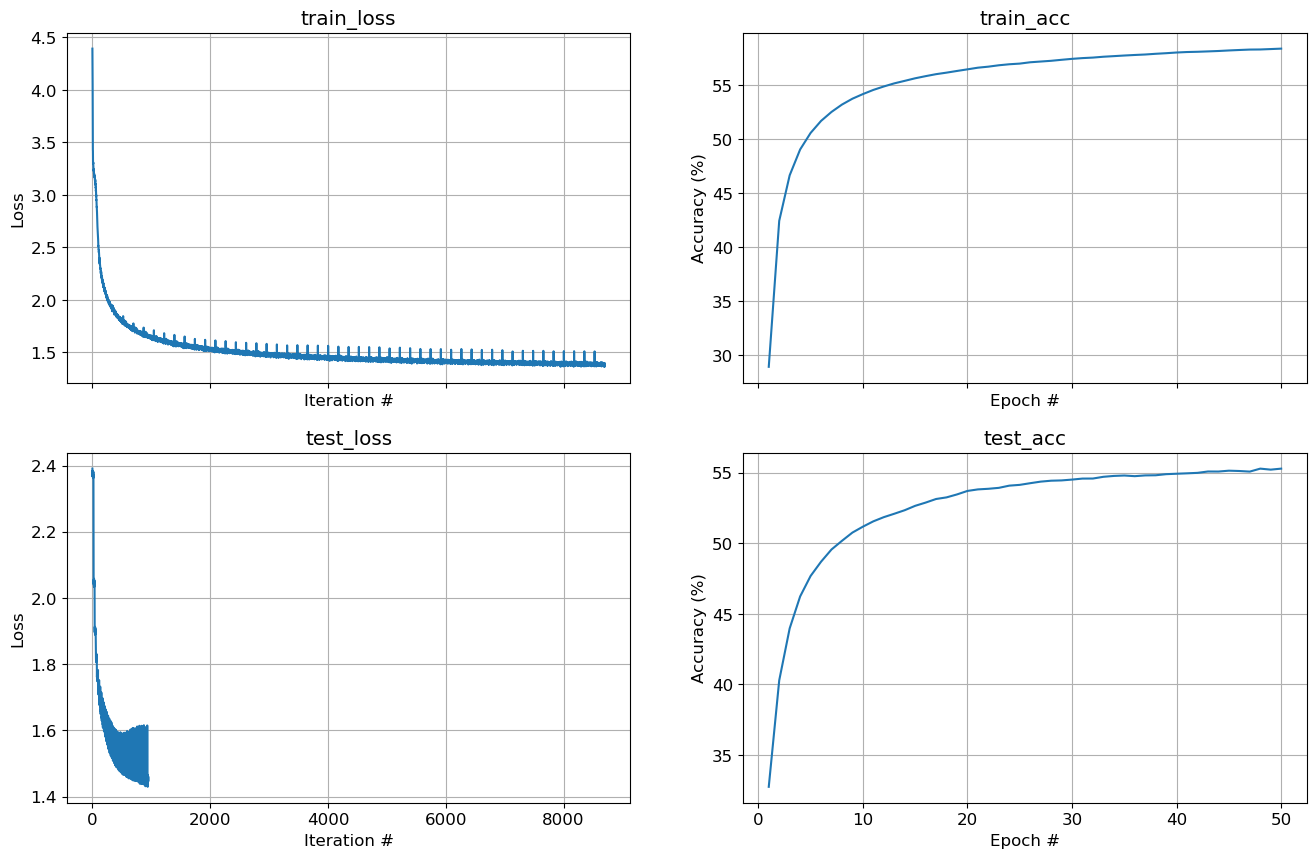

In [20]:
from cs236781.plot import plot_fit

def post_epoch_fn(epoch, train_res, test_res, verbose):
    # Update learning rate
    scheduler.step(test_res.accuracy)
    # Sample from model to show progress
    if verbose:
        start_seq = "ACT I."
        generated_sequence = charnn.generate_from_model(
            model, start_seq, 100, (char_to_idx,idx_to_char), T=0.5
        )
        print(generated_sequence)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:
        # Print pre-training sampling
        print(charnn.generate_from_model(model, "ACT I.", 100, (char_to_idx,idx_to_char), T=0.5))

        fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=None,
                              post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                              checkpoints=checkpoint_file, print_every=1)
        
        fig, axes = plot_fit(fit_res)
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

### Generating a work of art
<a id=part1_8></a>

Armed with our fully trained model, let's generate the next Hamlet! You should experiment with modifying the sampling temperature and see what happens.

The text you generate should “look” like a Shakespeare play:
old-style English words and sentence structure, directions for the actors
(like “Exit/Enter”), sections (Act I/Scene III) etc.
There will be no coherent plot of course, but it should at least seem like
a Shakespearean play when not looking too closely.
If this is not what you see, go back, debug and/or and re-train.

**TODO**: Specify the generation parameters in the `part1_generation_params()` function within the `hw3/answers.py` module.

In [21]:
from hw3.answers import part1_generation_params

start_seq, temperature = part1_generation_params()

generated_sequence = charnn.generate_from_model(
    model, start_seq, 10000, (char_to_idx,idx_to_char), T=temperature
)

print(generated_sequence)

ACT I.

                               Enter HELENA

  SECOND GENTLEMAN. O my lord, and the citizens was better to the cliff
      not the great part hath to thee for the man and lies,
    That he hath seems a thing in oee command.
    Do not the made of courtesy, and the breath
    The soals of the wars of the rest your son
    Where in the stones in the friends in the country
    Than he shall be not love her soul encounter,
    And the well and her more of the weak of the trumpets it hast thou
    what a more than the world what bear on a brow

    Heaven with him that a must be proved him.
    I say the more of your intent of more son,
    Shall dear fars that contents so bare them in the rest in this
    man and with him and see them that with the love,
    Which I were the great prophet of his soul,
    And all crown of the sense with the death.
    So love thee that it be seems and my lord.
    What an excellent father, and you the sense
    That will see when they are be as the

## Questions
<a id=part1_9></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [22]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1
Why do we split the corpus into sequences instead of training on the whole text?

In [23]:
display_answer(hw3.answers.part1_q1)


**Your answer:**



### Question 2
How is it possible that the generated text clearly shows memory longer than the sequence length?

In [24]:
display_answer(hw3.answers.part1_q2)


**Your answer:**



### Question 3
Why are we not shuffling the order of batches when training?

In [25]:
display_answer(hw3.answers.part1_q3)


**Your answer:**



### Question 4
1. Why do we lower the temperature for sampling (compared to the default of $1.0$)?
2. What happens when the temperature is very high and why?
3. What happens when the temperature is very low and why?

In [26]:
display_answer(hw3.answers.part1_q4)


**Your answer:**


